# Домашнее задание по АОТ. Подготовил Бахарев Никита Сергеевич bakharev.ns@phystech.edu

## Пункт 1

По данным поиска Яндекса на осень 2009, в Рунете — около 15 миллионов сайтов. Это около 6,5% от всего интернета.
https://yandex.ru/company/researches/2009/ya_content_09/#toc3-1

На момент января 2023 года всего в мире 1,132,268,801 сайтов, среди них 202,900,724 активных. https://siteefy.com/how-many-websites-are-there/

Если предположить, что процент русскоязычных сайтов не поменялся, то получим **73,597,472** русскоязычных сайтов, среди которых **13,188,547** активных.

Можно попробовать оценить актуальный процент русскоязычных сайтов. 

Согласно https://w3techs.com/technologies/overview/content_language получаем 5.1% русскоязычных сайтов. Данные получены путем анализа открытых списков топа самых популярных сайтов https://tranco-list.eu/, https://developer.chrome.com/docs/crux/. Tranco содержит миллион сайтов.

Получаем **57,745,708** русскоязычных сайтов, среди них **10,347,936** активных.

Критика такого подхода: в топе самых популярных сайтов получаем не такое распределение, как по всему интернету. Доминирующий по популярности язык скорее всего получит больше мест в топе, чем должен по соотношению по всему интернету. 


## Пункт 2

4% сайтов индексировано гуглом https://eu.tennessean.com/story/money/tech/2014/05/02/jj-rosen-popular-search-engines-skim-surface/8636081/#:~:text=Google's%20index%20represents%20only%20an,is%20currently%20available%20through%20Google.

Не понимаю, как можно оценить надежность таких данных.
Если бы мы имели доступ к большому списку разных сайтов (в том числе неиндексированных), мы бы могли оценить по нему процент индексированных. Но если бы этот список можно было найти через поиск, все сайты бы быстро были проиндексированы поисковыми машинами.

## Пункт 3

Можно искать большие источники текстов и оценивать по ним языковые статистики.

Например, есть готовые корпусы текстов, википедия, livejournal, новостные сайты. Возможно, можно написать робота, обходящего фиксированный список telegram каналов и собирающего с них информацию. Выбор корпуса зависит от задачи.

Еще можно использовать знания о языке и "здравый смысл" при оценке достоверности статистики.

## Пункт 4

Распарсим часть статей livejournal и подсчитаем частотность "ноль" и "нуль".

Обойдем всех авторов. Их 3152, если выставить страну Россия.

In [28]:
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import numpy as np
import asyncio
import aiohttp
import requests
import matplotlib.pyplot as plt
from IPython import display
from base64 import b64decode

In [46]:
PAGES_COUNT = 3152
ARTICLES_PER_JOURNAL = 10
ALL_JOUNRALS_URL = 'https://www.livejournal.com/ratings/users/authority/?country=ru'
SLEEP_SECONDS = 20

async def get_soup(url, session):
    BEAUTIFUL_SOUP_OPTIONS = 'html.parser'
    OK_STATUS = 200
    OK_ERROR_STATUSES = [404, 500, 403]
    try:
        async with session.get(url) as response:
            text = await response.content.read()
            status = response.status
    except (asyncio.TimeoutError, ConnectionRefusedError, requests.exceptions.TooManyRedirects, 
            aiohttp.client_exceptions.ClientConnectorError) as error:
        print(f'ERROR {error} {url}')
        return BeautifulSoup('<body></body>', BEAUTIFUL_SOUP_OPTIONS)
    
    if status != OK_STATUS:
        print(f'ERROR {status} {url}')
        assert status in OK_ERROR_STATUSES
    return BeautifulSoup(text, BEAUTIFUL_SOUP_OPTIONS)

Возьмем все формы слов "ноль" и "нуль". Будем считать вхождение этих подстрок в тексте, если символы слева и справа от вхождения не являются буквами. Например, ",нули " считается за вхождение, а "развернулись" нет. Для этого напишем соответствующее регулярное выражение.

In [36]:
NOL_FORMS = ['ноль', 'ноля', 'нолю', 'нолём', 'нолем', 'ноле', 'ноли', 'нолей', 'нолям','нолями', 'нолях']
NUL_FORMS = [form.replace('о', 'у') for form in NOL_FORMS]

def word_regular_expression(word):
    return re.compile(f'[^а-я:]{word}[^а-я:]')

NOL_REGEX = [word_regular_expression(item) for item in NOL_FORMS]
NUL_REGEX = [word_regular_expression(item) for item in NUL_FORMS]

Избавимся от заглавных букв через `.lower()` и добавим вспомогательные символы в начало и конец текста.

In [24]:
async def count_words(text, regex_forms: list):
    # we add extra symbols for correct work of regular expression
    text = '#' + text + '#'
    result = 0
    for form in regex_forms:
        result += len(re.findall(form, text))
    return result
    

async def handle_article(url, session):
    #print(url)
    text = (await get_soup(url, session)).get_text().lower()
    nol_result = await count_words(text, NOL_REGEX)
    nul_result = await count_words(text, NUL_REGEX)
    if nol_result > 0 or nul_result > 0:
        print(f'{nol_result} and {nul_result} entries', url)
    return nol_result, nul_result

def get_sum_of_tuples(tuples: list[tuple]):
    return np.array([item[0] for item in tuples]).sum(), np.array([item[1] for item in tuples]).sum()
    

async def parse_journal(journal_link, session):
    if not journal_link.endswith('/'):
        journal_link += '/'
    ARTICLE_URL_PATTERN = f'{journal_link}[0-9]+.html'
    REGEX_ARTICLE_URL_PATTERN = re.compile(ARTICLE_URL_PATTERN.replace('.', '[.]') + '$')
    
    journal_articles_count = 0
    first_previous_result = ''
    ARTICLES_PER_PAGE = 10
    nol_words = 0
    nul_words = 0
    i = -1
    while True:
        i += 1
        if journal_articles_count >= ARTICLES_PER_JOURNAL:
            break
        soup = await get_soup(journal_link + f'?skip={i * ARTICLES_PER_PAGE}', session)
        urls = [item.get('href') for item in soup.find_all('a')]
        article_urls = list(set(filter(lambda url: url and REGEX_ARTICLE_URL_PATTERN.match(url), urls)))
        
        if not article_urls or article_urls[0] == first_previous_result:
            break
        first_previous_result = article_urls[0]
        
        if journal_articles_count + len(article_urls) > ARTICLES_PER_JOURNAL:
            articles_urls = article_urls[:ARTICLES_PER_JOURNAL - journal_articles_count]
            
        journal_articles_count += len(article_urls)
        
        articles = []
        
        for url in article_urls:
            articles.append(handle_article(url, session))
                
        sums1, sums2 = get_sum_of_tuples(await asyncio.gather(*articles))
            
        nol_words += sums1
        nul_words += sums2
        
    
    return nol_words, nul_words

Мы обходим топ по популярности авторов, потом берем последние 10 их статей и считаем по ним вхождения.

Фукнция `parse_all_pages` обходим все страницы топа авторов в отрезке \[`first_page`, `last_page`\]. Она запускалась несколько раз на разных машинах, чтобы ускорить процесс. Размер отрезка страниц был фиксированным - 60 страниц.

In [38]:
async def parse_page(index, session):
    soup = await get_soup(ALL_JOUNRALS_URL + f'&page={index}', session)
    # we may need to filter i-ljuser-username class if displaying settings are different on livejournal 
    a_tags = soup.find_all('a', {'class': 'rating-journals-item-user-link'})

    journals = []
    for a in a_tags:
        journals.append(parse_journal(a.get('href'), session))

    return await asyncio.gather(*journals)
    

async def parse_all_pages(first_page, last_page):
    result = []
    STEP = 5
    async with aiohttp.ClientSession() as session:
        for i in tqdm(range(first_page, last_page + 1, STEP)):
            pages = []
            for j in range(i, min(last_page + 1, i + STEP)):
                pages.append(parse_page(j, session))
            pages_results = await asyncio.gather(*pages)
            for page in pages_results:
                result += page
            #print('result:', result)
            print(f'{i} step result:', get_sum_of_tuples(result))
            
            # livejournal may ban us for spamming get requests 
            time.sleep(SLEEP_SECONDS)
        
    return result

Результаты всех запусков (порядок отрезков страниц сохранен). Первое число - вхождение слова "ноль", второе - "нуль".

In [9]:
result = [(158, 191), (281, 354), (368, 619), (308, 488), (322, 487), (103, 184), (273, 542), (115, 148), 
          (219, 308), (277, 317), (298, 402), (220, 290), (149, 205), (138, 239), (115, 132), (73, 127), 
          (199, 477), (245, 204), (150, 153), (185, 151), (97, 126), (29, 90), (8, 8), (4, 3), (8, 5), 
          (7, 19), (11, 1), (8, 6), (12, 10), (37, 32), (17, 28), (12, 25), (52, 49), (40, 21), (42, 78), 
          (32, 88), (41, 124), (23, 35), (15, 11), (6, 4), (25, 22), (31, 18), (15, 16), (7, 6), (9, 34), 
          (10, 23), (2, 23), (14, 26), (10, 17), (9, 2), (9, 18), (2, 10), (25, 30)]

Во второй половине топа было много заблокированных авторов.

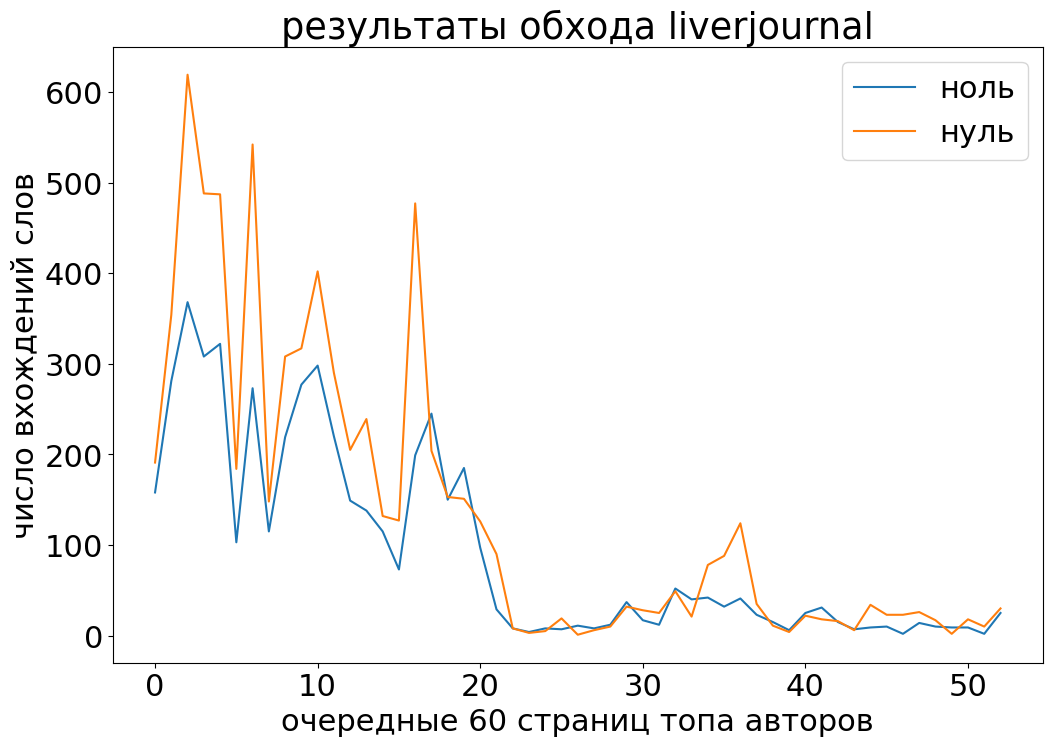

In [22]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 22})
plt.plot(result)
plt.xlabel('очередные 60 страниц топа авторов')
plt.ylabel('число вхождений слов')
plt.legend(['ноль', 'нуль'])
plt.title('результаты обхода liverjournal');

In [26]:
nol_result, nul_result = get_sum_of_tuples(result)
print(f'Нолей: {nol_result}')
print(f'Нулей: {nul_result}')
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Нолей: 4865
Нулей: 7026
Соотношение нолей к нулям: 0.692428124110447
Соотношение нулей к нолям: 1.4441932168550873


### Позже я узнал, что можно просто сделать запрос https://www.livejournal.com/rsearch?q=%D0%BD%D1%83%D0%BB%D1%8C&sort=_score&searchArea=post

Результаты за всё время:

In [37]:
nol_result, nul_result = 637684, 880927
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Соотношение нолей к нулям: 0.7238783690362539
Соотношение нулей к нолям: 1.3814475508245463


За 2019 год:

In [54]:
nol_result, nul_result = 12769, 21244
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Соотношение нолей к нулям: 0.601063829787234
Соотношение нулей к нолям: 1.663716814159292


### Теперь данными НКРЯ за 2019 год

In [45]:
base64_nkrya_image = 'iVBORw0KGgoAAAANSUhEUgAABLsAAALZCAYAAABf6iOQAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAT0TSURBVHgB7N0NfJP1vf//t7OaIloE1yqOMJB2oq06C3KkPXps1R2KnNHKESr+pLrNqhvFO8DfBDz/A+h+3HgDdVPqNql7qBWHhU0pv6llv3kKzlF2HMW7VuFQJtIq0CjYSFn/1zfpBWmbpOkdbZLX00dMSa5c15XrupJceefz/X5ParYIAAAAAAAAiADfEAAAAAAAABAhCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAAAABAxCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAAAABAxCLsAAAAAAAAQMWIEAL3g0Ucf9Vy/9dZb2rJli4YNGyan0+m5Hj9+vG644QYBAAAAANDTTmq2CAB6iAm5XnrpJc/fJtAywZa57NmzR7W1tZ5rc7/529x/7733CgAAAACAnkLYBaDHTJ061XNtAi9TwRWMCb3MdKbqy1wAAAAAAOgJhF0AeoQJukzAZTdfDJVdCUbgBQAAAADoCeHXZ5e7VuXPrlJJWYW2flCr+sNSXLxTScljlTl9lm6/1imHAJxIXQ26DLsZo2nqSOAFAAAAAOiu8Krsqi3TnNsKVLJDcl6Wpcx/StLwQdLB3VXa/OZW6aYXte6OJAE4cUxVlrmsWbMm4P0mxLI7p7/88ss9f7dlAjPThxcd1wMAAAAAuiN8wq6mKq2ckq1lO5zKXlKk5VOS2ldwNYnxJYETzFRkmYouc92W3YeXCbBM0PXYY495pvv3f//3doGX6cPLTEd1FwAAAACgO76hMOF6daVW/U1Kua3Qf9Bl+AZdTeUqSHZ6vlC3umQsVWWTz3T7K1X8YJ6yxicrMTFZqRm5KlhRpupDrec155I280lMVOoV2cpbWKIqn2ndH5Rp5f15yp6QptTRiUq8JE3ZM1eqfK+CPTuV3GpNO61ItW3uqX4iW4nW8trd95dFShvZ/vkl319+bJLap6zHjs7XukOt5+nevEgZ5rF+7mszpao3rtSc6RlKvcRav+RUZVyXp6Vvuo6v+Y51WnRnttLM/aNTlTY5X4vWVMnlM4+ymYlyjp+viqY2s68vUV6iU1krqltvDTPP27KOzTNj+nwVb2uZY02RshP97NeWS+Kd66wlWvZXqWT5HOVNzjg+n2lzVPyX42tm79fUByraP3XPchKV+0xtq2kzllS1mbDW2nfJnmX73ufaVqz5ZruNbrOOI1M1500FZZ7/0pnZyki1jsnRyUq7Jlv5T1d6n1fLuoR0bDfVq+KpOcq9JlXJ1rGYPC5DufcXqbzW7bs0z7HXeh2taVMzlH3nUpXtcgddV1O1ZY+22JYZbdFcTMWXPSqj+TtQBZgJw8zy7ZEcAQAAAADoijCpg3Kr4rUKuU4eq9wZKaH1yeWqk8vtUMqtizUrbZD1xb9BFU9aoclhn2n2l2v+1HwV709R9vS5yhvukOv9cr3wZL6yNy/Qi8/mK8VnYXEZBVo+/aKWVWpQbeU6PfXMHOU3ObVpYbpnvdzV5VZAEKe0SbfrlhEJ0p4NWlW4TPn7B2nT83lyqhOswGXBk1bIYe2lds/5YJ0alKjshXM1cahZ8HYV31+o7R3N012pFQuLVaMOJ1TVU3matmSrHONylDvzFp3t3qfq92t19pA47xTblmrGzYWqdmYpb+ZiDR/k1u4/lVjrka3N1cV6cV664tQ57m0rrXku0+6UPN3x4Cw5j9aqvOQpzb+5Sg1rXtSsERma87jTG6YdrtCqB4q1O2OOHpzcEoCePdZ77a5S+aY6JVx5o7J+4NQgd7VKn1yp+bc3aNDrVpA1RD2ifu0iLf2jq/UraW+JCm6dr61Ds3X7g3cpaUjL3nunWAVPfRh0fu6/LNU0s03jM5WbZz32tEbtq7HCw0EJx4+BUI5t1Wvd3ZNVsFFKn3qL5uZbx2JdlcqeW6q8TVu1bE2Rckf4TD4sSwvm5chpnkeTWw27KlT8dKEK7ojVuldmKSXAO4WpwvIXdNkCBVuB3HPPPZ7qL5oyAgAAAAC6KjzCrqZqVddYgYIzWSnxIT5mvwmDHEpMy1HWBBMTuKywZL4VkByfpPLJRSrelaQCK0SZm2pHCbnKTS3QhIKlWvx8lkpuPR5POYalW/NKPz6D61J08O0sFdXUWHNPl1m1uEnLVDbJd0Wy5GyoUvbT5arYn6fckEOWWpUsXKGtQ6z1GVOq0jYFNvX1LrlPHq70yVnKMvNskjY80PFcq55epCLrOedOdah0fZAJ95ZqWWGFdNUyrX861xuCtFKt4sVFqrTWr3jNMmXaqdbUXKUnTFDuM4v1VHaZ5iarE6znvGSlqpwFVtA4V2NadknWNU41XpOvVU+U6ZYns5U+qaVftkNulT5YrIYR6cqeNKb1rIbmqujVXJ8bspQZX6vxP9igN952K3tCDwxjsL9MC5eXSdfkKquqVHZ9muvNMlW4UpT/fKFm+T5/R7kcQcOuaq2ytmnV4GwVvVyorEDHegjHtvu1pVr4ap3S7y9TiU8/dnmTU5Q3aY4WLV+niU9kHw8jByYqbUKWT6iVLecnbyj35WrVHlXQsMvuYL4tf/1y2U0U/d0HAAAAAEBPCJNmjG41HLKygtMGKS7UeG5vnXYrQQkJAUKNpiq9salGjotzdGNq62niJtyirGFubX2tXPWtVsMll6vlUl+typeLtWlXnMZmpClYBjfcOdyKJhqsxylknoqhNwcpZ94spQ9sf/++T+qsgMJ6fp0pnaop0uInq+S8eb7yE2ODTurabIVzh+M0cXqOn6DLUrtZ5X9zK3FC7vGgy8OhdOsxY1SlTa9XqVP2lqus0q2kayYqpckt96GWi2Os0lMccv33Vm1vUpc5znXq7JPd1n5okxxa+7V+v7VPfS+ugwregM+l8iWLtO5wpubOy9Ign4ndZh1PdujMzuZptZu0eYe1TSfdEjjoMjo6ti1bN72heocVAk5tM2CDM0e5GXFyWfdXtGrCar3G7GN7f72q3yxW8ZsuxV+RrrE9NLypHYwFq/YyIZhp+ggAAAAAQFeFSTNGhxxW4OM+bAVGIXZCX299YXbpbA0fGmiKOtXuteac4rRigzZihitppEPunbu121qenTvUr8lXsu/3dIdTmXc/q8LbjgcKpr+l1b8uVfm27aquc8l9VJ5mYW4r/lGoQY2pGFpSJl1XqLkTBqlibdsJ3Krds9vT9Cz0+piWSrGEXBUXpCv2xcKgU+/bawUOJyfJOTJA0vGptW2OOqzt5Gf0S2eSJyAr32kFckqRw2HN47Dbuy18990hV+tAaY+Zp7WmK7KUuMLPMuMaOgigfOyvVMmTq7Vuc6U+3GMdN263dz+4HcpsM6nZr6l+8xcruAswe/fmFVq0tkHp8xYrd5gVfPrcFz8uXSkxi7R6SZESZ+do7NCWbXioUUF9uq9lmw4POlnHx7bLOj6sZDU+UUlx7Z9TYqIVvr5Sq2rr+M9KbLn5gyLlXlLUerrJC/TsI7kKtZgyGHvExo46nzf9dpmO6gEAAAAA6KrwCLus8Ok7JnR5bYeq6qUxQzt+yO6aarmHZCox4Dd1K/w4GmQGfkK1uAkLVHRrS7s0txUoVJZq1RMzNK2uUC8uzJTjbys1Y+oyVY/K1V13F2pMYoLiHKZz/TmaFjxbamFN3NRSMeTO1LJ52VbQ4K8cbLeqq631H56k4SHuwWOVYkVzlR5noi8TvHS2Ry1/gsRPJ3uvLvqnsYp7eYOKnspW0vSLFHtot7a/VqyVT5ao0m3isBZHzP8cGjOzSAsyB/mZX4KSQnm+rgrNn5rn6Ystr2CBCsYkKuE06/adxcrPL2k3edw11n69rU17yz3rNP/+Uv/zb+n3rPbiuSq62cSNrTvYV2KeCpfs05zlS5V3zaLW98UEiY6O2H8EL6UK6dgO5qh3iljfbTkiW8uW5LaEp265PqhQcdEiTbuxQc/+ZpbGDPQ/K7sSy4RUwZgAK1jfXraO+gADAAAAAKAjYVLZFaf0K9LleKVCpWurlTczqYPpa1X533VyjE7RdwI+Q6ecI6yv9TurregoS63m2PShqmvdcjiHe8OkloosR3yy0tN8an0yMpWwd7zy1pSofHam4n+7WpVN6Vrw1DLl+5Rc1Z6m0FjhUOMWn4qhQKHefiv0+8gKibISQ+is3yGHb6XYtaEFXGcPtZ7A0a2q3WnFIol+ljLM2jYnu1Vds1tqW/uzq1o11jYbPty7EeKvX6yHNs/Q7OW5SlvunSTu/CwriMqXHio6Hs04z/bMc7d7kMZcNkZd5f5TiUo/cihr+bNaPMXn+br8by3H0Db71ajZoUEnt5tSsbGm435vv2ez1uR5w7em9tM5J8/VnOrN2vqUlPvIfG+zxL8VKX9JkCEEzj1bCeb57zThWaDnH8qxHS/nMOt5v12jaisrHdOqnzi3anZa+8yRKafvbnM4leKpSGv5d1qmFYrWKnX2apW8bYVdGf6XFGol1uWXXx5SiGXm1VFwBgAAAABAMGHSZ5f19X1yvnJHuFX5xCwt2lQffOLaMpX/zQqDrkgP3AQrJkUTr0mxAohSlfyldSWMa6MVluxxaOy1mZ1qwmX6lzKVO85W7SLrVfFmdYjN76pV/JCpGLpLi24O3EDRtWmDKtxOpaV1FPpZHG5VPLJI65qyNNdTKRaauHGmr6Z6bXi+VLX+ml8OzVTWOIe1qUtUtt/3Dmt5L5aq6miKMjJa1i/GqezHN2nH2+Vat36dyt7coW2vF2nupCS1qt9yZijzYmuer6zSur3qMvdh0zxykBKGtg72qjdX+n8uneD4pFTzPf2eLdbtFweOGs2oivOfqlbSbYu1YHK6J0xLPz8h+MyHpSnTChZrXmm7TX2EcmxbxmZNlNNdoZI1barOaktUssmluCuv9tsXXCtHW47aIJG4CbBM88SO2M0YQ5mOyi4AAAAAQHeESWWXZWC6FqyYo5ofLVPRD65S+fhMZaYm6ezTpcbP61S9o0oJd76ou4ZuVemS1aqwpl82KXiPVin585X3ep6Kbp8mV16O0oc51FBTrtXPlsl96RzNn9768e49lSrf1BIA2M0Y19crflKOp5N2txVoxL1crlVL1ilh+hjFuaq06dmVeqF2kELp49u9pVjFjhTNsSuG2mqylvm3DVr5RLm1fnOVkxrCTF1lKl4fp/SFCwJXivnjzNWcO0s14/H5mjajSrnXpihBLu1+f6vcGcu1YIJTufNmqWz6Ms2e3qDt0zL1nTi3dr9ZYm2TWqXcWqw7Lm49S8fQpA6aoCYpb/4sbbjZmuf1uarIzbKmd8jdYO3fbeWqGbVAJbM7rvgyQV2Ko1wbnlqpzNOzlORwqWrjKq38fYMSunXEW2HrmmJpRJ5K7h4TeJ+6KrRobrGqE/P1YrDp2rIC2Fvm5arU2nYFUxuU9+/pnj636nZuVZVjipZnnxLyse244i4tuL5cBcvzlLv7FmWPsYK2/dtV9myxyk/O1LL7s1s3Yj1Uq8pN5arzVKq5VfdRhdb9utx6rvnKDnKc2WFXR80PQ6n+MvMwTSJvuOEGAQAAAADQVeETdlkcqbNU8n/TVfzkKpX9qUIlT62T66hDcfFOJY3J1NUJVXrqNiu8OpSi/CWLOw534qwA7fkXlfTEKhX/dqlK97qtQCZF6TMKVTQz2wpJWk/u2rRMeZta/hFjLXeYd9o592V5g4MpD6lo70Ite26epj1jzeucJKXnztGzM2tUMGmDOtTkUMqPglQM7SmxQpCl2n1+jhYvzVMIdV2eJnaOy+7SohtD78rey6Exdz2rF4eu0MoSKwBcUqJ60zzvwkzdfpN3/RzJs1S8ZrhWFK5WWeF8FR12KGHUWOU+tFh3mbBPnWf28YsvJ2lVUbFKn7P2Sb0VLg5OUIq1f3PSQnrGnoCmsPCgFj2yWvmTl1n72amUa27R4hdu1xs3TtMOdYcV8j0wN0hVlEvlD81RcW2SCtbcpTGdHMkw7orFWvNCklb8okRlTy5S8SHrthFjdXX+QevYnh36sa14ZS1Zr+KUFSp6cbUWvVwn92lOjb3S2md3367MEW0mN32U/WCd92/r2HYMtrZZWoEKZ98VtALMNDk04dRjjz0WNOwKNgKjzczDjNYIAAAAAEB3nNRsEQB0kanaMiGV6Zerq2GVeZyZTyihGAAAAAAAwYRNn10A+idT3fXoo4/qrbfe8lx3FkEXAAAAAKAnUdkFoEfYFV5208aOOpq3pzcIugAAAAAAPYWwC0CPMQGW6WjeVHg5nU5P6GXCLxN82Z3Um/vti7mffroAAAAAAD2JsAtAj7NDL3Ox/zahl2GCL/M3IRcAAAAAoDcQdgEAAAAAACBi0EE9AAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIkaMAAAAIsSjjz7quX7rrbe0ZcsWDRs2TE6n03M9fvx43XDDDepJbZdn9PYyAQAAENxJzRYBAACEMRM6vfTSS56/TbhkQiZz2bNnj2praz3X5n7zt7n/3nvvVXcEWp7RW8sEAABAaAi7AABAWJs6darn2gRQppoqGBNAmelMFZZdidWby+upZQIAACB0hF0AACBsmeDJBE52c8JQ2ZVZnQ2furq87iwTAAAAnUOfXQAAICx1J3iymxSapoehhk/dWV5XlwkAAIDOYzRGAAAQduz+sroaPBkmfDIdydvz6u7yzDRmnnY/Xd1dJgAAALqGZowAACDsmOooEzzZndCvWbPGcx0qu1N58xjzd0eVVr7L88dUfZn5mMove2TGRx55xBNstRXqMgEAANA1NGMEAABhxVRF+Y5+aIKjzlZKmQor83gTTtmVVmY+oSyvLRNa2SMuGmY6828TevkLu0JZJgAAALqOZowAACCsmHDJN3gywZEJkEx1lwmxzN9231q+/zZ/+xtB8Z577gkalrVdXlv2sn3Z6xRIR8sEAABA11HZBQAAwooJn+zO3n21va1t/1ptA6nuLs/WtnrLVHWZZQfqtwsAAAC9i8ouAAAQEUyllOk7y+67ywRU5t8287fvv20mrOqpYMrM57777uswWOvJZQIAAKA1KrsAAEBEMP1f+faBFWpll2lu2JnO7YN57LHHPE0UgzV77OllAgAAoDUquwAAQFgJVBVlKrnMxYRIdhWXfbFvaxuAGR31yRVqFZaZpqN5hbpMAAAAdB2VXQAAIKy0rYqy/+3br5a/UMu+zUzr23l82393tLxATCgWar9gHS0TAAAAXUfYBQAAwoqpiDL9c9lNFs21v3ArGN/mjr7zCmV5gZjKLtOMMZR1CWV+AAAA6BrCLgAAEFbs8MluCmhfusLMw4RUoYRdHTU9DLUPrlCWCQAAgK47qdkiAACAMGLCJ3MJtdlgIKYfr7Yd2/fm8jqzTAAAAHQNHdQDAICwY1dYdbb5oi+7j69QQqeeWF5nlwkAAICuIewCAABhx3TuboKnt956q0sBlD1qY6iVWt1dXleWCQAAgK6hGSMAAAhb9iiMJowy1VId9d3lO2pjV0Knzi7P9zFdXSYAAAA6h7ALAACENRMmmU7fTcWV0+n0hFAmjDJBlN1pvLnfvpj77fCpp5dn39/TywQAAEDoCLsAAEBEsEMoc7H/NiGUYYIo83dPBk7+lmf05jIBAADQMcIuAAAAAAAARAw6qAcAAAAAAEDEIOwCAAAAAABAxCDsAgAAAAAAQMSIEQAAAAAgKDMQxZo1a/TYY4+pv7NHiDUXMxpsf8D2A3AiEXYBAAAAQBBmtFUzsqoJPmpra9Xf2SPEvvTSS5717etRYdl+AE60sBuN0bzhmIs9vDcAAEB/Z6oEnE6nLr/88hP6pcmupHjrrbc862DOn0ylgn1tmC+f9t8A2rODmkcffTTsXivmPcCs+z333NNn6872A9AXwibsst9oTLIejm+UAAAgepnzGHMOY5rvmGvzw50Jn3prWXbAZcI1uymOv+kMM61ZHxN6Ub0AtGdeF+HcnM0uFDDfofoC2w9AXwibsGvq1Kmek0LeZAAAQLjyDaLMdW/M33yh7Gxw5dtkx5xr9VYQB4QjE9T0ZkDd2+z3hb5qGcP2A9AXwiLsspsu9sZJIQAAwIlkV6vboVRPMSFVd0M0O/SijxrgONMEORz6mQqmL58D2w9AX/iGwoA56WIUDAAAEAlMdYPp/8X8kNdTTAW80d0fBs262edchF0AACBchU3YRR9dAAAgUvRklYCp6Orpju/NvOg+AgAAhKuwCLtMST19RwAAgEhhzmvsDuK7w/wgaJou9kYVlpmn3awRAAAgnIRF2NWfnXTSSQIAAOgLZnTH3uzT1AReZhkAAADhhLALAAAgDJk+vzrbp2lnq8nsPrx6sn8xRJmmCs0f5/Q03fW9ZK2oVuQ6qC0/u07nDZ6ilxt9b/9U5YumKHXkYA2OH6oLvz9fG+yXZNNOvTzrap0XP0CDnam66cm/6thDPy3X/IkXavDgwRp60RQ9tOmgItnB//6VZn8/VUMHD9AAa1tM+dkWHXvGAbdTo3aWzteUy87T4DMGWNvpOs0v+7TlMdZ2f+xHuvqiodZ91ra/4GrNfmmnAEQ2wi4AAIAwZPrT6mzYZZokdja4Mv2m0ncXuidOWUvKVP56+bFL0c1JikiN7+lXMzL1k+1n6pyYNve9tlg/enmklv/lgA7sfU9PJG7QDxdu8IQ1n/5mpmZXZWpt9Vc6sGW+Bqz8oRa/ZR50UC8/8CNtGP2EdtYf0HuPjtTa/Nna8KUilBVavfmeYm9+Tu/VW9vitZ9IRda2+C/vvQG3U9Ne6/2tURMLN+vAFwe0eeFQvZx/n172bKcD+rTxUs0r3em5772Vl6p81mw9/5kARDDCLgAAgDBzIgfvMdVdZln03YWuc2iQM0VJ5ycduziHmNtdqnxmjrKvSFbi6GSlTZuj4m2uNo+tVdH1icerwkbnq8xt31Ws3OQ8ldT7WWR9ifKSc1UccBwI77JzM7zLTp1QoHU9MWZETKyGZi3XhqIpGtrmrsaDB/SV8wKlftNMd6ZSLx0pfWmiroMq//02jb/zPl16pvXPYdfrvunSy2us11zjZm3YNFI/vDdTZ1rh2ZnXztYPR76q5zY1qleYbZrYvhKv1XYPab91VawuLViuxTdc4Hm+saOnaMqle7WztoPtFDNS05cu1w8vP8czj5H/dr3Smj7VXhNoxVyg6T/9iTITYz1LOCdjotJi93rvAxCxCLsAAADCTFeaMHaH6buLsAs9rXZNgW4rqtPEh9dp02vrtPiKOq340WyV7PWZqKlOB11O5a+vVe2bCzTmZPWIerPsJ2uVdv+LKnvlRRXenasxQ9V9Vugy8cbM9lVdltismZp54BFNmfu8Nrz0kH74i0bNnjtRsU079W7tUI1Mij027cjRF2hvzbs6+NlO7dQFuuAc+55zdEHiAO18vxeb4cWka8Hr27RtW8vlxXwl+mz3kPZbT2ncps3vWQHhRbGeJowBt1Pbx1X9VdvOvFSpbcc4a/xUWx57ROVJUzQxUQAiWIwAAAAQdky1xYlkRn0Eek61yp6r0Hd+sEn5V3iPZefMxbrjzQwVr61W7syWZo7uWtXUn610E0S51UOq9YJZ9m2bNGuCd9lJJyL4OP1STf9xmp67d75m/uaAzsz5lZaPNsFNoxq/jNXg4xmOYmMHKLbR3N6or2JjNcBnNgNOj1XjF71U2WWc7FDckHjFx7f8e/8gxcouewtxv/WIgyp/cL7KM+Zrc4r1z6Yg28n3YY1/1SNzn9PIB8o13v6227RF8y+bqEeqrFgscboWP/NDXcA3YSCiRVxl13s/S9N595Yfv6GpXDNHXq1Halr+fXCLHplhTTN0sAaPTNWUReX6tNXjUzXAdFwYP1gDBgzQ1U9+6n++AAAAfcRUWZnmhSeKWVZtbU+08QJaNNWqeleCEpN9Q1unks9P0O6amuO51rvbVT0kWSnxAebjrtD8q5KVfEmyUsdnKPe+YlV21KLOWnZtu2X3voOlM3XdL87RE9s/1sfVmzW7abGuy3/Z+i4Sq9jTrVDLJ7FpbPxKjbHmdivossKcr3zm85X179gzzlSfCHW/dVuj/vrYTZpZNUXPPTpR3mcbZDsdW7+d+tWMm7R27BP61c3nHJ8wZrwW//WAvvrqK737iwtVfmOmHvpvAYhgUdaM8aBennWTnjvT+nWg9oAO/OXnuuAPP9IPnz5eBnywvlGZK3fqQP0BPXdDrAAAAPqbE9VfV18vE6j6f5vlHpeulEBVODFjNeuFjdr4yka9uGqukmuWanZhZUezVS/WRQW0+fevauSMmco0fXadfoGmP/wTjXxtrTZrpC4cuVc7q4+v1c7339PQxAt15jkX6AK9p/eO/Tr/qd57/yuNTOyJNpf9VaPee3KKbvp9mn71/H261P5KFhNkO5l/WEHX8z+Yol8NW66XH86U3zgwJlYjM36imy7dqfItnwpA5IqusKuxXGtfMx08TvS2o//meM3/8aXa/NKGluquRu399ICGfrOPfikBAAAIQV/0n0WfXehRMUlKGlWnmh2+FYO1qvmgTsMTE+Uw/3RXqvTVBmVOSvf+25+THUoY6u1EPeniLOVmJaluV62CF3dZ0w6zlv3Bia1WHJk0Uu+99qp2erKaRu38/Qa9N+xCK8w6UxNz0rTl6Uf0VzN64J6X9cjz1g/w/3aptZ3SdH3WXv1qZbkONlk/zG9arl9VZ2rKFX30o3wo+62bdj5zk6Y8e4GWP2sFXTHeppyNnm0WZDtZ3+Ze/vEULY+ZrecWWkHXly2PazJ3/VXlb+3UwZaM7OBbv9JzW4Zq/GXnCEDkisiwa6/1S4Bphui5DL1Ov/q0pfD34AHrTe5MDfV5X4s9Z6gGHzioveaNUDv1Xu1IjRwZYL5PT9FQ51DP5bxLr9Ps0l7sGBIAACCAUKus9uzZ0yPTdGaZQGicysnL1Ie/XqSizVY4tb9WFU8v0qrqdOVNTpKa3Kp+fqVKT8tWzmi3db9LLpc3rWjY79tYzi33IXNxqb6mXCV/qNbw8xMVF2zRVmCT8+9jtf3J+Vq5qdrTRLdqU7mq9qtXXVDwc80783ldd4H1XcJ5oa57YajmPXOfp++oM2/8uZ74brluGjlAgy+brwMzfqXFGSbQilXmwl9pSs1MXRA/QCN//J4m/uIRXf9N9ZEO9lt3NZXrkYUv6723HtF1zgEacIb3Mvj6X3k6oQ+4naqs62f+qr9aQdl5Z9iPG6zMZe95Kr42PHidZ/uZ2y64s1wXLF2r+WMFIIJFZLd8Q+9cq48fzfT+w/TZlfSQ9+8zB+vM2IPaacq4RnhvOvjpXh0YfIGGmi3x5Xt6d89ITRkRYL63HZ/vwddmKu3HjwgAAOBECzWgMtVY5vLoo4/6vX/q1Km65557Tmj/X4AtfnKhnj20SIvnTdDSWinh4om6/ZcLlGu6g9q8SHkLy1Vvnctnpxa2elzlFfnWwV2sXPMP02fXFYmab/3piHMq5dq7tDg/xbq9KuiynbcWqujQQi17IFsrP3Ur7sJcPbQ6UynqIbHXa2399a1vO/1S/bDoDf3Q7wPO0cSlb1gXP3d9c7zmvfyu5ql/CLrfuismU0/sbNYTAScIsJ1S5mnbkUBb6AIt/8P1Wi4A0SS6xqCIzdRN/zZb85du0E0rJ+qcL7do+S82K23Gcplir4O/X6stl2bqkdNDnF8MfXoBAIAT7/LLL/eEWB1VW91www2e63vvvbdd4GUHXaFUbL300ksCuiQmXYvf3hbgTodSpi9WiXXxa0S+1r22QGN8v7HUlyjvqjLv3848ldTkBZh3rop35CqweKXPLLQugi+zTXe02abnz1LZDt8bOthvANAPRFkH9Wdq4qNr9cPGxUpzDtbgi36i9773nH5120gdfOlHSnv4oH7y4E0K1Hr7WDPGoYN1waz3rF8UZgsAAOBEM0FVqAGUCbxMoGUCL9/Hhxp0GSZYs4MzAACA/i7iKrsu+Olmfex7g6cUNvP4v0+/VD/59Wb9pO0Db/il3m1zDnf9swd0vc98v/qp2qEhIwAAONE62+zQDqpMdZdpArlmzZpO9cFlHkOfXTihzkpS+jiH4tp+W3EkKPnKZCX0RE/oAICIFV3NGAEAACKECZ9MdVeoFVf2dCYo60xw1ZllAD3m/DwtW+Ln9rhMzX0yUwAABBNlzRgBAAAigx12hdpZvWE3aewMwi4AABBuCLsAAADCkKnQMs0Sffvi6ml2315ANDMBsem3Dl3D9gPQF8Ii7DInc5351fJEam5uFgAAQF8w50im6qrtSIs9wczTjPpIX12Idv35u0go+ro6k+0HoC+ERdjldDpVW1srAACASNCTX57MfMy5Uk8GXmZeb731Vq9WjQHhwg6UwzGwMetsXsd9Gdaw/QD0hbAIu8ybCydbAAAgUvR0pYA9L9PssDtfKM1jzTwMM2IjAG8zPDvwMK/dcGiSZ17LJmAy697Z0Vd7GtsPQF84qTlM2uGZEy9TSk/oBQAAwpk5lzFfpHojTPKtQuhsmGa+2JkvovYXPACtmZDGHhSivwc2dhNn81ruL69nth+AEylswi775M00Z+QkDAAAhBNzHmPOYR577DHPv3uzasr+Iml/mQw0AqNdAWbWxa4040dFAAAQCcIm7LLZfUgwogcAAAgXpkrA9Kt1oqvU7QoyO9gy50/2yGj2+pjqebN+AAAAkSLswi4AAAAAAAAgkLDooB4AAAAAAAAIBWEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiRowAAAAixKOPPuq5fuutt7RlyxYNGzZMTqfTcz1+/HjdcMMN6klmGeZiL8/o7WUCAAAguJOaLQIAAAhjJuR66aWXPH+bcMmETOayZ88e1dbWeq7N/eZvc/+9996r7jDBlj0P3+UZ/pZppiX0AgAAODEIuwAAQFibOnWq59oEXqaaKhgTQJnp7Iqsri6vMwGWCbzMxaybXXkGAACA3kPYBQAAwpYJnroSItmVYJ0NvOxgbc2aNZ15mCdkM4+xwzYAAAD0HjqoBwAAYamrQZdhV2XZTQ9DXZ7R2aDLMOtpr293m1ACAAAgOMIuAAAQduz+ubpTJWVCJ9ORvD2vUJbXlaDLZgdeprqrq00oAQAA0DGaMQIAgLBjKrJM0NWZyix/TPBkKrw6Cp9MSHXPPfcEXZ7dLNJMc/nll3uCNH/szu0JvAAAAHpHjAAAAMKICZXajn5o94cVKrsJo6m2squ7AnU2b1d1BQu6TBhmHm8ub731lu677z498sgjfgMvMx9zux2MAQAAoGcRdgEAgLDSNiQyAVMoTRF9mcoqex6mYuuxxx4LGHaZ5QUbddHcb0ZntKcx8zX/NqFXoOouU/lF2AUAANA76LMLAACElbYhkQmUTIWWqe4yIZb52+643vff5m9zm/m7M0zFWLDH2Mv2Za9TIGb9TRgGAACAnkdlFwAAiAhtRzls23l9oM7lTTBlKrECMfcFqtCyH992erPsYPPsaJkAAADoOiq7AABAWAlUaWWaMtqjHRom/DL/tpm/ff9tM/MK1t9XR5VdvkyAZfrr6mjUxo6WCQAAgK6jsgsAAIQVOyhqG0DZHcTbQq3s6ury/DF9f3U0aiMAAAB6F5VdAAAgrARqAmgquczFBFN2FZd9sW9rG4AZHXUUH2qTQzNNqJ3OBxv9EQAAAN1DZRcAAAgrbZsA2v/27bPLX6hl39a2Squjqq1QR040oVhXq8cAAADQcwi7AABAWDGhk29llLn2F24F41tV1VGVlVmeXTUWjKnsMs0YQ1kXs0zT3BEAAAA9j7ALAACEFTvssqut7EtXmHmYkKqjsMtUbXVU3RVqh/Nm3e35AgAAoOed1GwRAABAGDGBkbl0t9mg6cerbcf2/pigy1R2mevuMsukE3sAAIDeQwf1AAAg7NhBUWebL/qymyWG0lG8WZ6ZrqOmjB0xQZc9PwAAAPQOwi4AABB2TIfyJuh66623uhR42aM2dqYyzARVZrldDbzsoItO7AEAAHoXYRcAAAhLvoFXqE0MTcBlQqfOBl328uzAy+43LBS+fX0RdAEAAPQ++uwCAABhzQRXJlAywZfpSN40N7QDKbvTeHO/femJ5oh2n2Gmc3szL7M8s2xzbZZpbjfLsgMxM00ozSUBAADQfYRdAAAgItihl7nYf5vwyTDBV3eaIAZijwppB1zm2g6+Lr/88mPhGwAAAE4cwi4AAAAAAABEDPrsAgAAAAAAQMQg7AIAAAAAAEDEIOwCAAAAAABAxCDsAgAAAAAAQMQg7AIAAAAAAEDEiFGYMUN828N8AwAAhINhw4bJ6XTq8ssv17333qsTZc+ePVqzZo3eeustzzqY86fx48cfuzZuuOGGY39H2/oAAIDIdFKzRWHAnByZk8Pa2lo9+uijnAQBAICwYc5jzDnMY4895rk2P9yZsKe3lmUHSiZcM+dM/s6bzHSGmdasjwmZeiOI62/rAwAAIl/YhF1Tp071nBSaoAsAACAc+QY/5ro35m9Cos4GReZxprrKhEzmXKungrj+tj4AACA6hEXYZTdd7I2TQgAAgBPJrla3Q6CeYkKh7oZodshkqs+6W1XV39YHAABEj7DooN6c5PTkySAAAEBfMVVK99xzj+eHvJ5iKuCN7v4waNbNPufqTrjU39YHAABEl7AJu+ijCwAARArTWb2pVuoJpoKqpzu+N/PqavcR/W19AABA9AmLsMuUsNNXAwAAiBTmvMbukL07zA+Cpqlgb1Q9mXnazQjDdX0AAEB0CouwCwAAAO2Z0R17s09TEzCZZYSqv60PAACIToRdAAAAYcj0+dXZPk07W01m95kVSv9iXVmfzurM+qB/cW0r1vxbs5R2SaKciclKzchWwdOVcgt9or5CS2dkKDnZ2hfX5GvlZpcAIJIQdgEAAIQh039VZ8Ml0wSws0GR6Tc1lL6yOlofs9xQwraOmiqGuj7oP1yvzdfk6StUNTRXC365TuWvPqvCmRN1kTNBDuHEc6ns/8zRpsTF2vLODv3xP5wqu3+Ryg+pz5iqzVBf12ZaBqwA0BHCLgAAgDBzIgfvMdVUZlnBAqhQ1sfcb/e7FYi5r6MAL5T1QT/irtCKhSWKvflpvfhwnrIuS1HS+WOUPiVf+ROc3knW5yvR6fQM3OC5JOapZL/34dVPZLW+74pFqmxqmffeci29M1sZ45KVODpVGbcuVUV9y301xcobn62l21pqxzbPV9qEparyPNalioVZSrtznepblp88vVj1x1a6ViW3Jss5Ol9lLQ9vu46Jl6Qp+75iVdkBUVO11i3MV3ZGqpITE5V6XYGKth2vlvIs47qVqvbdNn9ZpLTUOSpveT4VD6Qqa3nV8fv3l6lgvLWsVuvmUuUzBcoebz3nZGv6O1cef84h75OtKt88XLm3pSsuRoq74g7lOt9Q6ea+q7Mz7w2mv7+OAi/7PYTAG0BHCLsAAADCzIloMujLfMEMFi6Fsj72aIqBAi876DLTdBScdbQ+6Ecqy1RWn668/DFBq7gcyQVa984O7TCXbUXKHeK93bW/Uc7bSrRjh3X7k9mK831Q3CB9J2OWCtf8UdteK1TO4WLNf7LSe58VmC2f59S6+xapfH/rZdW/Mk9z/jRGy5ZkK97Purg2LtXKdxzt7vOso1kP67Ll+Vlyvr1Iy9a3JE0xZyo+eaLmPLVeW97epOX/VKOl/7m6dbjVKW5VPGGFd+74Vtutfu1s3faclLvKes6vP6s8R6kK5paoU3nX/lorzktU4rEnGK/EEbGq/Wi3+or9/hAs8LLfO3qzX0AAkSPiwq73fpam8+4tP35DU7lmjrxaj9RYvzrOvVAX3utzYtRo3ZeUqvlbzd8v66bBAzQgfrAGm+uRM72/sjRZt8dfp199KgAAgH7DVJecSOZLaDChrE+gwKszQVeo64P+wbWnVnXxiUoa3MGEJ8cqbkic9xJnxztu1dXV6WzncOs26/aBsa0Ds4FjlD01Uykj4hXnTFfONUmq21ktu54qftJDWnZNpebPW6faoy1z/KhYsx+qVe6KBUqP87Mehyq0YkmFUu68Rd852c86mvWwLvEJCRoU47uu8Uqfkq30853Wc3AqMztDzl1WqNSkrtmxSsvWna078tN9bqxV6XMVGnvnQ8q92HrOQ1OUO/NGDd9Spjc6k3Ydcqsx1qFYn5tiBzrk/rJve1ALFngRdAHorBhFkfEzblJsznMqf3i8Mq1398Y3X9aGM6do7XetOz87oIPDfqLyvy7X+PcfUlrOXgEAAPRHpqrJfDE8Ucyyamtr1RPr4xt42V9oOxt0dbQ+iBR1qrVCnPihCX7vde8q06rHi1X2zm41mFDJVSf3Jb5TxCl99krdMiNPBb8ersZD0sp7d0sFL2pWsv86s6pfLlPp0Lu0foI05/E2y3t3pbIvWWX9GO6W+7BDSbcW6tlJLYnZoWqte3yZVm+qUp3JjNwNqmvKbNUB/7HH26z5uBw5ftaiVsVLVsud96xyh63SimPTV6v6I5fKH7xKqQ+13HbUmkfTcNWZ6jV/ZWr+WMFWbKMVePnc1Oh2y3HWIPW1tu8Pdv9cBF0AOiuqwi6lTNdN51ytl99sVOa10ubSDTrn+ld1qdkKn36qA2cO1TnRtUUAAEAYOlH9dYW6zM6uj+8XWhNadSbo6uoy0TfihjoVV1+japc0ZkgnH9y0W9U7hytppJ9gqqlKK340W5uuLFTRK5lyDrQiomdyNWFTm+lcNdr+iUPOjDjV1VrXCbtVWbNbLjnVtrCrcVexFhe7dctv8uSMKW6/zPPzVPT0LRrumbZcKx8sUIFzo0puTVD5wjzN25Wrot8UKn2otb47liprem3Ax3u8s1LTHmy/mPr1S7WidqIKn0yRo83zabQSrZwl6zV3jE9dVoxDcR1VzvmKT1SiylRjBYnpQz1LVE1No5xpCeoPfN8fpk6d6rmNoAtAZ0Vkn117n5yiwaY5orkMNU0Qv2q5Z6Rumj5SG14qV2PjZr382jmacsMFnnsaa9/Vp86RGupvhk3lmn3pUA11WpeRFyptxs/11y8FAADQJ/qiv6qOOqjvChN02R1+9+T6oB9JzdTVp1Wo5DdV6nQjuY8qVaUUpYzwc199pbbtSVLODG/QZTTU7Wu9jKZqFd81TzWTluuhCVaQE+NU7tLFGvOnOZq9tm1lYIPKlqzQvknzdXuy/9VxnDxICS3Ha9IVebrlmkHa+nal3NZytr5Tp/Spt3iDLou7rl77mgI/3nM5u23cZgVY7s1a+niF0u+bq/SBbe621j9phEvVu6zIa2j88Ut8nByd+cE+ZqyyMvap5NcVclnr6Nr8lEp2pmviuP4zNqYdeF1++eUEXQC6JCLDrqF3rtWB+gPey95X9cNzBhy775yc6bp008va8NrLKndO0fWJ3tvf++/3dM5FF7Rqu35MTKaW/3Wv9tZal/de1U2fLdb839CJFwAA6BuhVjUFG/mwM9N0tMzOVln59tEVrNP6rq4P+pGBmZo1O127C/OV91CJyrdVq3pHlSpeW6cyn9EK23Or4sVS7UvL1Fh/GUxcguJPq9P2Km9nVa6/FWvlOt8Ay6WKJbO0Qndp5X1jjldxDc7UgkdzVbdkjlbuOB6Nud9fracq0zX37vQgHek3yn3IbV1cqv+gTKVv1ilpdKIVNJ2t4QkOVb+z3dtfWH2FVjz9hoI9u0Dz37f2KW0YepfmTvLXoViSbrzJ2pZPz9Gi9VWq3Vuv2h1WkPh8Rec6qLeeYfrs5craNV9XXZKo8fNqlPHwg8rqbOVdLzOBl3lvAICuiL7RGM+Zopsu26zlD5dr6A03aaS5remvWvu7RqVlXBD6fGIFAADQJ0INhkz1U7Avi6aJUE/0fdWZoKptZ/QdjdKI8OecXqQXH89WfOVKFUzPVOakbBU8XKKtdYFrvcrvH6+CzWP14N1Z8hf7aGCW5v5HpuqX/KtSx6Vp8vJ9yvnfuXK2dCpfv36e5mxM1EMr8pTUpurJcfEsFd7tUMldPiM11rt1UcHcoIGP+2+FyrLCrcTRyRo/dZGqkhdo2Y9SZDrLyrl/gca+M0dXpaYq7eZixd5mzStOnVbvOlu3z8tToFrH+KmFenp2inYUzlDGFeM14dbFKqvtQsfyQ8Zo1tObtG1HjXZsKtbcjFA7/AKA8HBSs0X9nCnzDfVEzIzGeF39Yn38aKb3BjMaY9JDGvnaG7qvpYqr8fc/0sjpe7X4PVP19Vc99L2b9OroxXr5F9frHDNBlbeD+sXvPaFMmdEYb9KG2DMVaz4omwZo6LX36Ve/+IkuPV0AAABd0pnzm7bsoCiU6qaXXnrJE3qZx5i/DRM2maDrnnvu6fQ8urM+wUZdNPfZnVJ31Nl9R+sDAACiW8SFXaE4+MIUpb4wUZt/90NvuAUAAHCCdef8xgRDdhPAUNjhkB0wmX+HGnQZJoQyIVWg6UNZn2BBl+80oQReHa0PAACIbtE39uCXW7R85V+V+cCvCLoAAEBY6qjyqS0TDBkmRDKBkunwuTNBkXlMsOlDWZ9QRl20mzSaYM5e566sDwAAiG5RVdlVfu+FmvKbRqXe+oSeWzqRsAsAAPSZ7p7f+DZJ7MxjTKDUmaAo1OV0ZX264kQtBwAAhK+o6qA+89F3daD+Y71B0AUAAMKcCaxM8NOZTt270vTPLCOUYKkr69MVoa4PAACIXtE3GiMAAEAE8B3FsLfYndiH4/oAAIDoFRbNGO1fCjvbPwUAAEB/1VPdNJhzJDOfng6Z7M7mOzvf/rY+QDQz7zORricHMgMQOcIi7OrM0NgAAAD9nT06YqijKYYyv54MmMx6vfXWW56O7CNhfQAAQHQJi2aMpl8GfsUDAACRoqf7nbLnZX4g7E6fWeaxZh5Gd4Kl/rY+AAAguoRFZZdhTnQuv/xyQi8AABDWzLmMCXF6I7wx8zXzN2FTZ8M0Uz1lQjhz3VPV9P1tfQAAQHQIm7DLPlkyJfGc9AAAgHBizmPMOcxjjz3m+XdvVimZZZkmkuZiBBqB0a64MutiV5r1xo+K/W19AABA5AubsMtm99lgnzABAAD0d2aQHdNR9ImuUrcryOwgyZw/maDJXNvrY6rnT9QgQP1tfQAAQGQKu7ALAAAAAAAACCQsOqgHAAAAAAAAQkHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiBGjMLJnzx6tWbNGjz32mNDasGHDNH78eM/lhhtuEAAAAAAAQDQKm7Bry5Ytuvfeez1BTm1trdCaCQLNNnrppZc828dsKwAAAAAAgGhzUrNF/ZwddD366KOeyiUEZkIvs63uuecethUAAAAAAIg6YdFnl6lWMgEO4U3HTHNGU/1mthkAAAAAAEC0CYuwy1R2EXSFzmwrs80AAAAAAACiTViEXaZpnqlYQmjMtjLbDAAAAAAAINqERdgFAAAAAAAAhIKwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAESNGkWBvsXKvmK8Kd9s7HMp+cocKJzkEAAAAAACAyBc5lV2ObBXV1Kp2p33ZoWXXEHIBAAAAAABEk8hqxniyvLVq9qWVelWsyFfWuGQlp6Yp++5iVbqO31v7yiLlXZOqxNHJSpu8VBX/b5EykhOtfyfKOdJ7nWyqx5pcKrk1S/OfXqn8CalKTk5V1p1FfueVfEmqMqbNV8kHLSVnTWUqSM1XmV2BdqhCizKcSrxzndybgyxvRrIKNgoAAAAAAAAdiJo+u2qfn62C/5eoxRt3aMfb6zUrrkQFD5bJk1HtWKmChTs05md/VE3VNq1fcavG/ssCbdpRo5q1+Uo5P1/rqmq0483FSjch2tFqlb4u3b5mm3ZsW688rVbB8gp5MqwPrHk9VKPMFVu0450tenZqg1b+ZKkq3e3XqeqXy1R2cqLizD/SgiwPAAAAAAAAIYmSsKteFRu3amzeHRozxPpnTLwy78zV8E0bVHFIqn69THUZ+br9Mit2inEofkS8gjeAdGjs5Bs1xqRUDqdyf5Alx+ZyVTVZ83qt3DOv3GSHZzrn5NuVHVOm0so2s9hVrMXrnJqbP1axAgAAAAAAQE+IkrDroOo+H6SE+LjjNw1JULwVgtW5ZN3XoEHnJqgzPXzFxfnMa/DZGuRyqcH6s66uToPOHnR8XjFna3hCg+r2+5R2NdVr3ZLVctw2V1nxUmOHS3Or7P5UpY4zlzRlTJ+vdTVuAQAAAAAAoLUoCbvOVMJZVuC016djLSuUqrfirgQrsxp01iA17GtQZ+Kj+gO+89qtOiv8GmT9mZCQoIZP6o7Pq2mfdtdZQdsQO/5yqGHTUq3Yl6P5U50hBmwOZS3Zpm1vm8smFf5TlRY+Xi7iLgAAAAAAgNaiJOyK19WT0lX13FOq3C9PZVX50yXanTFR6QOllIwMDXq9SMV/8wZYrppauYLOz62tv33G2ym9u1Ylz2yQ48pMpcRISRMmavifilW8w+2Zrnb9Kq1zZylrjP3YKq16pEqZP71dSd3pj8vBSJMAAAAAAABtRU335/FTl2tZ3TzNvy5Zuw8PUlLGLSpcmOXtHP7iu7Ty/kVacNd4Ld0rxZ1/u55eO0tjAm2dk+OUmRarVVPTVFHbqOFX3qHld6d7q7QS87Vs4UHNt+a1ol4aNPpqzXpqrtLNnU3WxV0j97hi3XVZZ8KqlmaMD3rnETtioh58NFPEXQAAAAAAAK2d1GxRP+d0OlVbW6v+waWSGeNVMX2HCieo3+pf2wwAAAAAAODEiJJmjAAAAAAAAIgGhF0AAAAAAACIGFHTZ1fPiVPuszuUKwAAAAAAAPQ3VHYBAAAAAAAgYhB2AQAAAAAAIGKERdg1fvx4bdmyRQAAAAAAAEAwYRF2DRs2THv27BFC89JLL+mGG24QAAAAAABAtAmLsMsEN48++iiBVwjMNrr33nsJuwAAAAAAQFQKm2aMdoBjqpZo0tieCblMIGi21Zo1azzXAAAAAAAA0eakZovChAm5TNhlgh0Cr9ZMU08TBpqQi6ALAAAAAABEq7AKuwAAAAAAAIBgwqIZIwAAAAAAABAKwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAiSX2Fip8oUvkuAQAAAFGJsAsAgEiyt0KrH1mhsp0CAAAAolL4hF2b5yttpFNOZ8tlZKKSx2cod+ZSrdvhEoBeUF+mgvGJylpeJbcAoGfVr81XanK2Vu7gHQYIyf5KFd2apsTEbBXV+JvApcrfLFL+5DQlj05UYnKqMqbPUdGb9e2mdO8q09I7s5R2iTXdaO90xX9xdXm6PtNUr8rnred8fYb1ftKyjtO685zdqn2zSPNvbZkuMVlpE/I0/zeVajWlu1YVz/gsNzFRqRnZyn9onaoOCQDQx2IUVhxKmb5AeZc45Ha7tK+6QmXrC1Xw+iZ9+Pw6zU11CEBPcansoXkqi8lV8Z0p4tUFoKfFT1mgO9ZkaOmCYmWtyVdSmJ2VACeS+2/FKrhrkSrqrPNgJfidpmrFDE17vFpJk2/Xgh8kaZAJZNY+pUW3Vmj30xu1OCPOO+H+Ms2/MV8lR9OVd9sCpQxsUMVvV2n+zdVqWPOiZl3s6Nx0faZe6+78VxVsksZMytEdOUmKa9yt8rXF1nPeqt3PrNfiKzr3nKufzlP2w1s1aHyOsmfmafhAl6pfe0HFD05T5b4XtW72GJk9UPHQDOWtl9Kvs5b77wlKiHFrd2WpVv+yQNNqGrXxmVw5BQDoM83homJe8/gRo5pvW9fY6ubGqhXNk88f1jzqlhea65oB9Jj3VzRPGDWqedqvdzcDCANHGpp3V2xofmHxtOZLrc/LyT9d3byhYndzQ3P/1viH2db6Xto8+w/9fU2BvlP3h3nNE84f1Tz+jtXN//XrGc2jRk1uXlXdZqIjW5sX/rOfc+Iv32iefdmw5gt/sqHZPovevmxC87BRE5qXvONzXv3lfzXPu8qazufxoU7Xlxrf2dC84f3W3w+aPy9tvu1i77aw31lCfi6fb23eUL67ufUcdzevvnFU87BLZze/Yd/R2NDc0NhubZr/66fjreVMa17NFxMA6FNh32eXI/lG5aRav6/sqNKHTS037q9SyfI5ypuccbxMeZr/kmvXjnVaOjNbGanJ1nTJSrsmW/lPV3qabNU+la1Ep0/TyTaXxDvXHW/atW2RMkabphi1Kl+er6xx3rLn1Al5WrS+un0TsP2V1i9Eecoan+wtj77Omm5ttd+mYq41ee3Wo9WyjaZ6VTw1R7nXpCo5MVHJV2SrYHmZatvN0KWSWxPbPx9TDr/Ldzq3qjeuVIEpzTZl8KkZyr2vSBV7fZdZrjmXOJX6QEX7la4pUra1HrnP1LZabuK0ItW2mbT6Ce92bndfyM+p/ToF2mfOkVlauqPNFrGOgUV3Zh87VtIm52vRmioFL9APsB2t+a/8wM/6W9sweZy1De8vUnmAJ9DxfnardlOR5t+Zq6wrUj3l8snjs5T/UJttYo5F0+R3dJ5K9vpZ0AcrlZXob5+3VrmuVFUx6cqedPx3yfrf5CrR9zkeU62V11nbb3qxjjUaMM//N4tUMD1LGeOSj70e5q/x0ySy3no9LMxXtnle1rZKtZ5X7n0lqv7AHEehvAbbHK+XpCnr1vkq3lwfdPsevxw/Vt0flGnl/davuhPSjs0re+ZKle9VUJ73i8RcFde2v6/8vmQ5x81Xhf0eFeq+bOf4cZe2sMLP+4VLZXeneu5Pvr+89bqNzte6Ns0q3JvtY6XtfaG+Txx//bbdnvlrXa3m1eXXfsDXTss6XrNUVU1tZtxUqUVX+Hmf9CPYZ4B3XuUqSPZzzGQsVWVTZ9fZ/+eKOcYyphVo5aY2TW468R7i2lakggnjlWbNZ9Ga7XI1uVW1fpHyp6Vp/IQCFf/N/+dfh+99nvfUROU9X6tqa35519jHq3k/LldtU9tpzftgqgo2+nkHdVd49kvr48P6HL8yWxOH1WvDy+WB33ft9zXfbTfa27RozjOV6rBBVZvP3NSMXBWsKFO1n6ZGQY8Jz3pY67/ezz4w7zHtPmM6fm/q1PPr1Ofu8ecT2n7u/L5rx9/22V+u+ddYx8z0IlXZN4e0P7yv8eS7y1T/t2LNsY5lcy6QeEnL+Uh9+2mdHb3H71+nfLP97itv/95wyNoG46zX44zjn2Mdvz904Twl1Hm3ET96rDJmFml9YZ6+00ExlWPQIMW1vkFxA63deNS+oVrlm6rluDhHN/pWZg1MV+51KXJtKdMb9Z2Zzu8zDG2ftNkmnT8fs57exVnKOr/NRhkyRmNHWbfV1Wlfp56z97FZGc42Fe1OpVifBXLVqc5eIUec4vzsC7e70bovXgmUxANAn4qIBgOOts/CXWV9oNUp4coblfUDpwa5q1X65ErNv71Bg163TgaHtEz2l6WadnOhquMzlZt3l5JOa9S+GutDdVDC8Q+4mERlP3C7rh4Se3z+Rz9U6f8pVLtTTbOcu2ao5Czrg7NgsfJUp8rS1Sq6e5pqDq1X8fSW0MBVoflTrSDCna68/Ic0K75R1a8Xa9Vsazq3z3QtGvY3WB/GmZrzZL7GxNRq3QNzVNpqinqtu3uyZr/uUOaP5uqh0bFq2LFBq3+Zr2l7rBOjx7MUf2zafXLtt7ZZWoEKb73Ic0vdxqWa/0rrp1L9G+uxD27V2dffrrk/SFJs/VaVFFlfdG7ep+KXFyg9Tj3DOjlf8KR1chejNicVnXlO7cVdka8FUy7S8b3WqIbNxZr/cuvp3NuWaoY5BpxZypu5WMMHubX7TyUqvj9bm6uL9eK8dAV9qsOyNOd/5yjp5GNLVuLQ4+tfsFFKn3qL5uYnWBu6SmXPLVXepq1atqZIuSNaz6rj/Szt3rxBVbJOwn6QrVlDY1W3ebVW/LJA+Y51Kpud0nriQxUqeaVWube1Pp4qf1vq/cIR7CSsqVoVf6qR45JblB5sQwd1UJVlm+UakaEbs78j52kN2rpmlYruz5eGbtLiK+wmEtYXjKn5KqlzKmvaLVrgtPb1J9XW8xyks4eN0ZzHnd4T3cMVWvVAsXZnzNGDk5O8q3/2WM919TN5mrZwqwZdlac7HkxSnNt67f1+tebPKFfVE+u1bEK84sbPUuGTuZ5FuncUa95TW3XRHcuVl+xdj7gUb5MQd3W5ynbFKW3S7bplhHXbng1aVbhM+fsHadPzeT3WJKFT+9KP2lfWqeK+dGUO9LmxfoNKXqtXSNyVWrGwWH67fAnxfcJw7a+zvoVZr4OFOd4maDUlmvdIhTrUwWu/M6+drgrpM8D6YuNyO5Ry62LNShtkvTYaVPGkFVYc7sY6W58ruQvnKtO8tqywyH1guzYUF2nZnfUa9FqJ8pydnKe1LfNvXaTto/JV9PpdynQ/pQmTizX2iW1acG6ZVvx0nubfbL3u1lrzTmx57p1673Nr+69nKO/ocOs1OldZQ6xpN1vT/jxPlXut9+NH2rwfWwFA+VoruJqQ3er90/2ndSrd42dHOMYqMy1exRvfUMWhbGUNVAAOjbltuW4f17J3DtVp6/pVVlA+Q43xW1Q4KcC7tQlbrPeY4v0pyp4+V3nDHXK9X64XrPfa7M0L9OKz+UppmWVIx0QnhPLe1O3nF0SnP+M6u+86XIEqFc0sUIlyVfREy3buxP4wXH9eqql/jlVStvX5MCVOLus9+gXrh5S8Hdb5yFrrfMT3eDGfyfdM1PCTj9/UuHeDVj7SEv4PsX5IuSZeZa+XqGx/5rHzQc+qvllqhR1xyrw/x3M8d3wsdP08pUvHmTNbc2eqZckBxKQo89pEFb+4Sis2p2tumtmLVuBqffaW1TqV82C6d/7uGlXvcituSnK7z7SklETrOK1UVbX1j7gQpwt2ntDRPrG3SXfPx9pq2q3de62TnZThOrszzzngc3Grbq/1eRc3VgltVsS9v16uo+Z5faiK3xdq6aux1nF0uzJ76lwZANA1zeEiQDNGT5nypcOaL/zRC0GbajSWm2YSFzbPLLMf/2Hziu+Pah52+czmDQHKjHc/Obl5lClDbtuKyy4Tv6P0eIlz5cLmq0ZYt01c0bzddxW/tKa9epi1nHnN/9Vy+/ZlVzWPOn9am/LzlvJon+ls/7VgfPOoqxY2bz1ilr29ecW/tl5245/Mtrmw+bbftn4i2x+f0DxqxITmJVVt131U8/j/3Hrspg8LJ3vL4Xe23NBS+j1+7huttmljyz441qztyBvNs63pLv3pfzW3U72qeXKrJnANzS/cMqp51NRVzbt9nvMLN1/YPOqfZzfPvrn1fZ16Tr6CrFPdczPaPPbD5lU51ja3lv9Gq4Onsfm//vMqb6l7oOW0PJ9hVy9p3n6k/b3eZjnW83/yw9Z37H6hecbFpilBabvjtaP97N9uz3MY9f0VzceWZI7FUVc1T5s63nM8tlqDxv9qnnf5qOarciY3X+q7z9v63FrP84e1Ok6MumenebbhivfbPsB6PU201uPG1cGbNJhjq818t5ptPeKq5oUVHTRh+tL72KsWt16n5roXmm+70NrnP2rTnKJxe8trvP1rqvlP3veD2eXNIdn6f8zxMKP5hc8DTxPw/cLyxr0XNg+7zFqPI8GW4mdfttPyOsqZ1jz5/EubZ/6+9Tbb/Wtr/1w4uXnyv45qvtB6/bZat/Nvay798vi0283r/vwJzbPntr8vpPcJj8bmDXdd2Hqd317ofa/+bUPrdQ71tR/yayfIa9Dfe3Q7HX8GeFSvsN7LfD87rOVa6zzsqiXe12pz517vgY6TxnW3Wa+tS5vnVXR+O2y469LmYRdax+cnLdO8s8T6PPI5vuu87+mmCVNDy3MP+b2v5T112Plt17nBOq7HW6/dttOOap5w47TmC8/3WZ+W6UvvsPb5ROv4PN/3+GhZRc/781XNS95p9s/zGevnHOCT1c3TRg1rnvD49uZAti5ueU6VrR/b8PuZrT/TQjkmAq2Hmd+LbT5jOvPeFOrz69Tnbmf3c9f2XeDtU9e8wTpGRl06o3m1z/lO6Puj5TVuvS5mrmtzvFjb+kJ/0/p7P2jbJP9t7zrOeK6u1XPc8BPrffpSa983eLddR8dCl89TQn3vCcLzevHXjNGzYh82v3CXdZ5prduEn8xrnnfzVc0XXjy5ed66D4+/Hx47rvx82vjuw1Cn86sT+6Rb52P+1VnvqZ7m0WUNnXvOgey0Hm+9nq+yPhdbTXVkQ/NM6/Zhw7yXUZdPa17ou60BAH0m7Joxul27Vb+3XrXWL2AV64tUcPM8lblSlJufE/QXH8e5Tp19slsuV0uBeO0mbd7hVuKkW5TV5cqVdktRUlZWq18kNXCMcrNT5Pi0QhWm6VdTlTa8XiOlZilrqFvuQ/YlQWPSzHSVqtzlO89a1Xxg/ZI0Iilgx71byzao9rR0Tbwyzmd+bg2/LE0Jqta2bT6/AbprVWv9MyEhIeCzcG/eoAqXU5kTxsrhMz+lpGtMnFtbK9s0Q3O7VL/fJZfvxXWww+ZD9WsXaembg5Qzb1brX2Y7+5y6qnazyv9mHQMTctv8+uZQ+vQcjVGVNr1epa7YuukN1TvSlT01qfUdzhzlZli/TG8yFQytVqbD/exfgpzDzS5okKtNU67kSVlyflCq0r8dv821qUQb6lOUk5UUfP/stX4RdTs0fORw9ai4eDkHSw0NDd5/W6+HN0wF2cU3Kjetaz+BujaXq/xwvK6emtP6B1lHim6cZv2K/ekGlVWqW4ZbG9khaxt32FaqUQ2uNq8F84tvSAPNBd6X7ZyVqZwr3Cpf79vsq1ql67Yq7tqJSjutg8fXFGnxk1Vy3jxf+Ymx7e8P4X3Cy6W6OuvJDUnw/nIeoqCv/U6/dtxqONBmmx9o6Hj00FA/A6xf8ndb+yYhSHuUzq9zo9yHzfuk91K7o1yr1m6Vhl2tzJROzrNpuyr+XC/HmCxNHBpgBeMzNTHN4XmtbDXHVhfe+xzjsjWxVTlEnDJzrfcY8378duumSIPSrHWJ81aWHrN3g0o3SenZEzXI3yo6ndYcreNud/A9Zwansbdb/a4qrXu6VNtjUpSRluT/AeY9ZlONt+lSm0Fs4iZY+36Y9Zn2Wrm3UqYT5wXuQ3VtXucuNRxqve5deW8K+fmF8rnbhf3clX3nn0tVT9ym2a8OUt4ThccqCju1P2zmXOCa1p8P8deZ52RN+3YITVjbujRXORfKOocsPd58en+59RxdctrbKoRjocvnKb1y/unDMVxjrslUSpxL1a+XqMRs79FjNHb08ONVY03e8m6Hv7e1GO+Nbrc79Om6q6fPx3aVaPZ/lknXPai5E1pm2J3ncqhKK+9dqq0JeVpw95jW1Xcx6Zr1dImKny1W0SMLlPfdBpXcnaXsB8rUA2eqAIBuCLNmjNaXuwcylfrA8Vvizs/SnGce0qzLfD569leq5MnVWre5Uh/usb44tnxgu60v75n2NJ/u0+6jVjjVw1/mnUPbf+UbPiLR0x9G/efmX9bJfK1pRjVfaaPnt59BjNP6suzzb1eVtlqf7yl3jgkQ5llflPZYD3CVqSA10c/9DiU0HNSxumwrxKhtcihxWOAvsbt31cndVKviGckq9jdHl/eLpL3F69fkK3WN/C47XQHsL9PCJeZEpNA6ERmkirXq+nPqqk93txwDfr4kOZPktF4d5Tvr1Hkt6x+fqKR2O83a9onWCaf1RaJ6r5RlP70O97Nh+n5ZpeIXy1Xx/m7VWV/wPadl5vge1n5qR3KOcs4vVslvK3TXxabpgsvbPGXcXOWMqNIqBWEdhCaOShrcem0cnrPEButLXdtVc6mx7Umip8+up1S8cbOqqner4bD1Gmzyru7xuVqvhz3WfCc41dVX4r5aax+dPFzOke3PYONHOK0vHRXe/RFiAwjTZ8jqX5eqfNt2Vde5vH2cmPcP63RbHYVQ7kotm5CsZf7uaxVEdG5ftpegzMmZWjG7RKV7s5Vn5v03K9jckaCJszN05mNLgzy2ViULV1gn7bkqLkhX7IuF7ScJ4X3CwzQTsd7PEjKcoTcvCeW135nXzgdFyk0t8rsoR7DWoCF+BtRbb9guK8obHihI6so6W8fJomuStchnyriL87T8N4tbvuh1Yp5OK3A8YLqHSQiyD+IUH2/da4JU0/yyC+99Zv7t3nGHDddw60ekfZ+YaY8nYY2ONGVPSlDeulJV3zrLE+DXvlKiitMyVXhtnEqWtF+sBsV5gpR6T6IcsPGXyu9LVfJ9PjfFpyv/yac197JAYWSdaveaY8HZfuy6mOHWNnDIvdPaHtZrOz7k8wJrPe5PU/L9fu6KOX7Qdf69KfTnF9Lnbhf2c5f2nR91r8xW/qbdSn94vRa0+iGjE/vDPkNNcLbv+8hhvTas12TZvjrPZ1WnfiqJSVJO7lit/E/rPfODfM0639qer5eq4rBTuTktzfw6PBa6cZ7SS+efXm5VLp+mGb+sU/p9Jdpy61jrs6FMTy1fqNmTN2tr4bNafK21TrFxntEEG/xlO03eGx2m2WGo03VXT56P7S3TnFvna+uIAj37cPbxPdDV5+KutsKrfK3cNVYLXljgp2linJLS0uVd80xlTc1TzvJsZf98kVZkZR7vsgEAcMKFWdjl0Jg7CjUrzfwyM0iDzk1Syog2nzot/WGZviDyChaoYEyiEkyVw85i5eeXHJ/uyPF59qTjnX+2uvX4n0e9F0fGHO8XzbaTnmydIJ3v80hTZeW2TsCuTAq0RO/V0GwtfvwWpZzSfgrHsOMnVO6aau22YoWMkcGet9vTp0ze8uXK8XcuNjip1Yll3DULVHRbcutp9qzT/PtL/TzYWm6TFbosWaR17kwtm2dORFztl9+J59R9QX6V7NJJXAe/ch71ThHr8+rreD9bXzh+k6/sByuUMGGW7no4XYnnxnlOzDY/lKX5/jpesr505WRbJ/RPr1PF/enK3F+qkjetU7ElOUqIqepwHY22R0lcarpSTi5X2ZPFmvhgjpJi96n6z2Va/cQqrfvAmv7Yt5d6lc2erPxXrOXdNkuLZ6fIOdia29EdWnljgcrbLMffskLXUQdknZjT31ZqxtRlqh6Vq7vuLtSYxARP57OuV+doWmEIM7C2ed7j89v8Wm99+XgqX8veP35Lp/elH4MycnT14HyVrq9V3h3W1+bfrlPtiGzljovV5iCPO1ZVVTTX0/derRrV9qtiaO8TlgPVqrG+uA5P+o461onXfiB+XjuynvPih3OV6PtaPVqjkvvmqyzYvEL8DNhtbQv3kEwlBunHRZ1dZ3OcFFrHid1/ZP0OlRc/pdlTa9Xwm2Llnd+JeVqfGYMcJm92KXCk21LV7Ghb1dDT7322WI3NzpbzWVNZOktzL65S6doq63ifo8wh9SoJsDzP5+HRYPO1gpy7ilSQ1vIkXLWq3FisVXdOVt2S9Sqc7G8nuYPP0wTY9r4J+bygzXq0cG1apoJfulsvu1PvTaE/v8597nZmP3dh3/kxyJms2IHlqvpTpWqvd3rCimPrEur+CLr+bs87V1c5TWXY8gKVrqvUrPuH641XKuQ6P185l7ZM0OGx0I3zlF46//T4YJXmP1WlpNll1vHRcj6Rmq0Fz47R8B9M0PwHVyjrysXWe3+CEgZK2/eZAKn1eYe7rs6KJOOUbjqmCnW6HtPN9yQTdN1coA1xeSr65VyNaXWy2oXn4gm68jS/crjmri6y3ptD2WcOpWRlKennK1X1zm7piiQBAPpG2HVQn5CSqcyMwB827j+VqPQjh7KWW79eTfH50HK1ecy5ZyvB+kV6907TG+UY9QzTeaX1wabW5QS7P6qV2/rFMt4EASdbJ32mcqMhVgmXjVHwj0CXykwlTmKeJl4YaJp4OYdaz/NtlxxJYzSmg2Knqneq5BqYorGJgac5e6j5hb5CDXEpGnNZxx/sjqHJSk9rU8NVs0OD/J2YWLc1blmhRWsblD5vsXL9Vkt07jl1WUtVQnXNbrX79XWX9SXeOukePrwr3ZFb6z/MrH+Nqq1vn2OG+N7nVo31q7UcmXIeW2QI+7nJ+sLxnDXNqAK9WDhLKTHHH7sjyKvYaX1pSX98kUo3LZBzV6m2xk1U0TVWsPK2gmupsnC1rbKw1nHxvK3KXzJf2WktlYnxKcr+wV3KbVp0vEP9vRtU/EqtnFOKVXR/pk/TiVrF+n7ROdk6+bSOAffuWk9zkq5s7eFOpxxHK1S90zpJTmxT/bCr1jqBTVDmsNBOxrf+drUqm9K14KllyvdZmdqOmgXaTh6kJCsQTG/zRNxrrfWyw64u7st2BmYqNytB035fqqrpSSp5pU4p+Td6mlH7D7usoMO3qurawNsklPcJz/OqqtT2ownKGR3CizTU136nXjvmaTk1Zny6z3a0NMWqvKO3rpA+A6yw4b/r5Bidou8E3DddWGdznFzie5xYYfQl1na/ZpFWr6tS3v0poc8z5iKNSXWo5J0KbXVl++8Q+dBWVfzZej+9ZKzGmu3Shfc+995aT5OcVlNb285UYww/t/2XetNMLSe5SCXrKnTH0XKV1jiV9bCpmlknv1qqSZ1xwV+rcUnWdvMJmdKvSVLDO9kqLi5V7eR8P+8h1mfuCGv9zboqq/VnbtOHqq51W4eQtT3M/u3EeUHb9TBce0yF4fHqk668N4X6/EL63O3iZ1yn950fjkvu0PLx9Zp652zlP+LUi/fbVcud2B82E0SYDMT3Nre3Sl5XJqijxtZ+mY7qJ8Qrf+MGVVrvn2XWZ+KYu3OOv490eCx04zylV84/vdzvV6n6qFN549qcXcY4NTHjIi3aXKUd1iGa7kxS0miHSt/fYb3Lpbd63VRX1ch18neUZN7/HSFO1109cT5mB10DraDrmQVKH9Lm/s4+Fzvo+rMJuqwfzC/uRDjpbvCEsQ5HrAAAfSfs+uzqiOkHxW19TU8Y2voEsnpzZesh0oelKdM6+ax5xYzIox5TXbbh+NDahhkR7/dVnuWlmw9R6xf9qzMS5f7bCyraFLynCfffntIq00/GjFtbf5FrY+w1VyveXaHiX1cGrzEwfWW8VqO4cVd7v/AEEHelFSie5lL5M8Wq7oGuGFqrVvFDxaq9+C4tujnwiUvIz6k7hmYqa5xDtWVtjwG3Kl60AoSjKcrI6NovcmOzJspprX/JmurWd9Sa/jNc1ja++lhfRaHtZ2/pvSPhbJ3tO83+Cr1RGWQLxU9UzpVS+ZqlKrK+RCdMym3XR5JfQ70nnrvNl+pWzKh0Rdr89maVrV+nstc3a8fbZSqcmSGnb8mI2/ur+6BzWw/d7X7bfCH3ucGMHHWF0/N6WP2Xru1pxxUTrS/41vH6fGnr/jHcVXrhxQq5z7H28yWhzcvTN12M9SWm1benelW8Wd2Dx2EX96UfY6ZkK+mDUhX/nxKVH05X7uQgXwYc1nH9yCKta8rS3HnZgRsBh/g+4XmdbKxQ/WDry/nFCkGIr/1OvHa6JZTPgNoylf/N+vniivSgjaZ7ZJ3tz6eTOzvPeOXclqfE/aVa9OC69u/ZVihQtnC+Sj51Kve2lr6juvDe595Wpg27fG+xQvo1G1R7cpLS0vxtnSRPZWmdtX2XmqDm/Bzlpiog1x5v+OM8t4vVLqcEeJz1HjPxmhRPM9+SNu8xro3Wj2N7HBp7baZ3u/TweUFPvjcFfH7BdPkzrnP7zj+H4q9drKJ56dr31G0qeL7lOO7M/rAdrlDpxta9H9WuN+95DqVfkd7F+iiHMv89R87acpU8sc76eW+scq7z2RYhHAtdPk/ppfNPwzQ3TrCinB07atvc49LWdz6Ue6AVNnpCICvAvGasZz+8sMNn7c0566tVcoyxzgOHdma6buru+dixoCvff9ClTj6XY0FXUpCgyy3Xfn973nrNv1imGmt5af/UU+M3AwC6IuwquzoSN876hd9Rrg1PrVTm6davhg6Xqjau0srfNyihTTOSW+blqvTWYhVMbVDev6d7+kap27lVVY5cFc1O78LSHUo4tE75M1zWl86xGm79blnx29Uq+SheWctvUXrLZ+WYOxcr/03rl6c7J6huaq4yUxKs76Eu7a6q0Kb9mSp6Ok+xfynRisVFqho4VgUxFVq3vmURTbtVZX7+/mSrStfHK32C9evUtXP14OQKzX5qhibU5OrGK5MUZwUVdTurtPnNRuWuKVSW9cFd8fxiFVvrMvH+zOD9W8Tnas7/LtPWBxdp2vXblZudruGDTJl3tba+uVmD7ijT4gx1iXtLsYodKZqzJi9oR+yOEJ5Tdrcr560vf/NmqWz6Ms2e3qDt0zL1nTgr4HmzRKvW11qhTrHuCOlLvJ/1v+IuLbi+XAXL85S7+xZlj7HSk/3bVfZsscpPztSy+73DuteHvJ/HKn2cU0XWCf7SNYnKH5dg/TK+WSWFq63HBtsQccq6fqIW5herRCkqWDEmtC8Gg1OUPEKq2FFlfUkb0/6LfpxTKalBTuKGjVGa9fjC3y5TceosZVqT7n67VIVF5da8fSe0vqzcOVfZrxWo6EfZqpueo7FOh9z1u7V959m6fXl+0KDXY0i25t6/QRXz5mvqrdW6MesiJVjbb+t667W3I0HZj98VcjhyUVq64l4u16ol65QwfYziXFXa9OxKvVA7qOcanFjvPV3bl34keyswFv3GCqcmFwbuoNxwlal4fZzSFy4IUFVlmtOF+D7hqlfV5qe0bH2dEm/OPfbeFkzIr/0QXzvdFvQzYIqWZ5+i0iWrVTEwXcsmBf/C0ul1Ptqg6i3lKjdNVk0/dvVVKn9ulSpjxmhOVkqn5+lIm6uih+uU/2CBsv60SmOTGq3gyPqSWJirrPut5+NyKtsKGhdk2I/o/HtfXPxurbg1T7unZ+miIfa0LjmnLtct5/vfLs5J2UpfPsc67qzX+cKcIJXMbm2v3C73aWN10fkKqq7K2m5xLZ1Ju2q1feNqFe+yjusfZAasDE3Jn6+8163P3NunyZWXo/RhDjXUlGv1s2VyXzpH86e3PLKnzwu68N7UlecXWNc/40Lfd8E4lHRroQprpynvwXzNH7reOneIC31/2AbHqmrJDOVb5wImJHKbaZ8pl/vCAs2a3I3S78tyPf1aLltjvX9etaz1AAwhHAtdPk/plfPPFuPydMs4K/h+yNpen9yiidbndJy7TlWvF1v73K0xd9+uzJZjzjm9QHkvWvvBel27ZmQpZWCDKtetUkmt9bn0UO6x4y3U6bqnG+djrgrrB5QClexKUOaMWFX+ZqXajkmTNGGWss4P9bnUq+z+PM15xfp8m5Slxk3Wd4hNrecXe2GO8jN2a+l1BaocfbXSvpuk4UOtc/lD1rnbJusHiTetx95Y1OVzSABAz4i4sEsj8lVYeFCLHlmt/MnLvF/Kr7lFi1+4XW/cOE07fCaNu2Kx1ryQpBW/sH5JenKRig9Zt40Yq6vv7FJRvMeYu4s1sWaxVi4vsb5gWL9sJqYr//E5mutbcTEkXQvWrFPSk9YHrHUiu/T5erlNNcmFY5WZO8ZTkl/+3HwVbzO/GFWo8L6K9gvaU6w5O2q02Ar38obGK3v5esWPeUrFvy3TU9aXmvoma9kjLlL6tXlKPs2ay0PZyntlkDJ/UqgF13b8VTHp5iKtH2adHD1TqnVPlKnOZZ22npOksVdmKac7JevWeqX8aLFu77AcvOPn1BMcybNUvGa4VlhBQ1nhfBVZvxQnjBqr3IcW667pY7rxpdoKOJesV3HKChW9uFqLXra+ep7mtLaftTxzsjnCO9XWkPdzifLmFWmx9d+qh/JUYvquPj9dOTOLtMa9TFc9EXhNHFdma+I51snX0BzdmKzQmEDmSqcKny/XG/XWl+3Ofp+wvrTf9VSh3AtXaMVtWZpvbY/E1Im6fcUaJTz7ryrwrbIcmq3CNXG66Ilila5bobJP3dav09axNnlW68qnIJzTC7U+3johtY7Xp/6z2PpdNU5Jl1ytuc/OVX5a6CsfP+UhFe1dqGXPzdO0Z9yeYz49d46enVmjgkkb1DMcyuzivmwvSTn/PlZL//ahJk7JCn68WtvccdldWnRj4K8mFctDe59wvTZP2fdXeIL2wrtDDFA78doP5bXTEwJ+BuQf1FO3zVbRoRTlL1kcMBzs8jo3Van4vrxjA4A4zCill0zUgqet4zW5K/O0QoWphdqUcYvWrbXClT+VeUddjHUq7Qe5Wjw5S2OGtt7unX3vG5SxWEUp5Vr85FIrfHFZr40UZd5dpLk/CRKKxk9UbsYilW/qoOrQ2h7lm+s9lRXpQQ9ib/93eU+1/NMKh53W/spduFxzg1QLKs76zH3+RSU9scr6PFmq0r3Wa3uo9R43o1BFM7OtH8V8Ju3h84LOvTd18fkF0eXPuFD3XYesoO4B6/1u72TNuTtfw58vto7x0PeH5zkMzdWy/2+Q1v1slRY9XSv3wESNvW6BFv/vfI3pVpWnqWBL0cp3q5U5ZWK7H3U6Pha6fp7SG+efHjFJyv+19WPNEytV8toKzXu6Xq4Y6ziyPmNylyzTXVNTjr9fW0H+gt8Ua5B1e8nTi1RyyDo2Ls7UnKcf1CzfQQVCna6bunys1u1Q5S63p4q1/Ollx/sEPT5nZY243Qq7HKE9FxNIV3or42peKdKyV9ovMv7mMcq/9iLlFOSqYX2ZSn9dqnqXdRyfZr2Xp1jn/Utu1x3Wtu7J3swAAJ13UrNF6L5ti5QxpVhJj+9Q0eTu14CU3W39ylSVr7KNc/1WttQ+k6uMh6QF1q9eeT1RQo4+0a/389+WKuv6Ig2at0klt1KKD4SNN+crdUaprv71Di3rYhXuMU3lmjMmT29cV6JtD3ej4iQI96Y5yvjBGxrz+B9VOJmvh7C5rM+eVM2pDfwZ2d35l919lfI3X63iTcuOVTwBAIDIEHF9dgHoIRffqtsnxGnrs6tVcUgA0AtqVfL0BtVdfItuv46gCydQTYmKN9YrcUouQRcAABEo8poxAugh8cqe96DemDxby36Zo7F3pfTGQOkAolj9+kVa8U6SZr1wey9U7gBtNNWqYmOV6l3bteHpIlUMzlbRD3p2REQAANA/cGrZT6VMXaxl16S0Hn7bR0JavhY/3HZIeoSbfr+fTX9ab2cLAHpD/OQibZss4MQ4XKWSBwu0zuWQ8+IcLf7/FiurG33cAwCA/os+uwAAAAAAABAx6LMLAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARI0ZRoLm5WX/+c6Xe/NMW7dtXr9gBDiUlnqec6ycpLu6MY9Pt/XSfyl59XR99tEtfffWVMjL/Wf/2bxMEAAAAAACA8HBSs0mCItyhQ4f08tpXdMl3L9K3vnWOFWQ16rcvrdfppw/Uj26b4Zlm3746rVzxtK695l900SXJOm3gADX/o1mnnTZAAAAAAAAACA9RUdk1cOBA3TxjWqvbxoy9VH/6U8Wxf//+lT/oX65K01WZ/ywAAAAAAACEp6gIu3yZQrZP9n6qioq3NNYKvIyjR4/q/Xc/1MUXXaglS1bo88/3a9i3ztW/T52sc4eeIwAAAAAAAISHqAq7li9/Qp/8/VPP31dl/LO+970Mz98NDS41NTXpz29t1Q9/+L808PSBKtvwun759G/0wAP3KCYm6jJBAAAAAACAsBRVozGaIGv23JmakZer99//UMWrX/Dc/uWXhzzXN07/d33zm2dpQGysvv/9CXI1fKHa3Z90ON+NG98QAAAAAAAA+l5UlSwNHnymBlvXpmliQsI3tXTJSu3ff0CnnHqK5/5THaccm9ZUcw04LVaHvjrUah533/WA33lfcNE4AQAAAABwInz4/vv6zujR6q5vf+sMAZEmatvn/eMf//Bcmz684r95lhyxp6r6g481ZuwlntsPHTqsL784pLOGDGn1uMdXPNxuXiYA4w2i//ufv3/BfgoD7KfwwH4KD+yn8MG+Cg/sp/DAfgoP7Kfu+/D97gdVZj8AkSgqwq7qmo+195N9GpU4QqcPHKjPPt+v360v08iRw3XWWd4w65//+XKt/90GnTlkkM4443S98rv/67l/6NCzBQAAAAAAgPAQFWHXaQMGaEfVe9q48XW5G7/W6WcM1AUXnq9/m/S9Y9Ncd933dNJJ39DqZ573dFb/naRRuvUHNwkAAAAAAADhIyrCrm99a6ju/PEPgk7zjW98Q5Os8GuSTwAGAAAAAEB/dO3VlwmAf1E1GiMAAAAAAAAiG2EXAAAAAABh5rU3/iIA/hF2AQAAAAAAIGIQdgFAR/Z9JL3zB+81AAAAAKBfI+wCgI589aXUsM97DQAAAADo1wi7AAAAAAAIM4zGCARG2AUAAAAAAICIQdgFAAAAAECYYTRGILAYAQBC84+vBQAAAHTWmjVrtH37di1atMjz71/84hf6+uuvdffdd6umpkYPP/ywDh48qFNPPVU//vGPdeWVV3qm+7//9//qZz/7mRISEtTU1KSGhga98cYbnvkNPmukAPhHZRcAhOqL/QIAAAB6yj/+8Q/99Kc/1bRp0/Tyyy97Qq8FCxZ4gi/jk08+0aRJkzzh1ooVKwQgNFR2AQAAAAAi3ifb/qSvPv9UvW3UtVNDntaEWfv27dP3vvc9z7/PO+88z+Wdd97Rv/zLv3juHzmSCi6gswi7AAAAAABR4e3C+epN37osM2DYVVFRoenTp3v+/uyzzzRx4kTt379fcXFxOumkk45NZ/594MABz9+1tbXHmjS2teRnP9VzvxnmqQ4bPXq0Zs+e7WkGCYCwCwAAAAAQJRKzblRfSU9Pb9dn15AhQ+RyuTyB1Te+4e1lyDRhNLcbH3/8sUaNGuV3fuPHj/fMz/Tldfvtt+v3v/+9pkyZIgCEXQAAAACAKHBu6pWeS3/yrW99S+ecc47+8Ic/aMKECfrwww891Vzf/e539dFHHykmJkbnnnuu38deedX3Pdcnn3yy53L06FEB8CLsAgAAAACgD5jmi6ZTenMpKipSbGysZ/RF04zxnnvu0cyZM4M+3jSLdLvdSkpK0ve//30B8CLsAgAAAACgF02dOtVzsf34xz8+9ndiYqJ+/etft3vM7373u1b/djqdeuONN47N77U3/qLnn39eANr7hgAAAAAAAIAIQdgFAB05dEAAAABAf3Lt1ZcJgH+EXQDQkSa3AAAAAADhgbALAAAAAIAwY/rsAuAfYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAGGG0RiBwAi7AAAAAAAAEDEIuwAAAAAACDOMxggERtgFAAAAAACAiEHYBQChOnRQAAAAAID+jbALAELV9LUAAAAAAP0bYRcAAAAAAGGG0RiBwAi7AAAAAAAAEDFiBAAAAAAAes2aNWu0fft2LVq0yPPvX/ziF/r6a28XGeZ67ty5nr9dLpeysrL06quvqqmpSdddd52+/e1ve+77n//5Hz3//POevwsKCnTPff9JdRcQAJVdAAAAAAD0gQkTJuj111/X0aNHPf9+8803lZqaqjPPPFOffPKJzjvvPE9QZi5nnXWWAISGyi4AAAAAQOQ7WKcT4syEkCcdPXq04uLi9Pbbb2v8+PEqLy/Xtdde67nPhF3nnnuuAHQeYRcAAAAAIPI1HpY2/169auhIafwkv3dVVFRo+vTpnr8/++wzTZw40fP3v/7rv2rjxo269NJLVVlZqf/4j//w3F5bWyun0+l3XgcOHPBcz5gxQ9/85jd133336Vvf+pYAeBF2AQAAAACiw5DQq656Wnp6ut8+u0xTxv/1v/6X0tLSPIGXqfQyPv74Y0+1lz+DBw/29Nd17dXPauXKlfr5z3+uhx9+WAC8CLsAAAAAAJHvnBHeSz9jqrdMJ/SFhYX68Y9/7LnNdE6/bds23XnnnR0+/tRTTz3W5xcALzqoB4COuA8JAAAA6C2mumv//v36l3/5F8+/TfPEq6++WsOHD/c7vZn2tTf+omnTpnn6+7JDMgBeVHYBQEcaCbsAAADQdVOnTvVcbG3DKTPS4pVXXqmBAwd6/v3888+3m8eGDRuO/f3WW295wq4XX3xRANqjsgsAAAAAgD5y6NAhPfPMM54qLQA9g7ALAAAAAIA+8Mc//lHf//73Pc0XTef0AHoGzRgBAAAAAOgDV111lefSFWY0RgD+UdkFAAAAAACAiEHYBQAAAABAmDEd1APwj7ALAAAAAAAAEYOwCwA6o/GQAAAAAAD9F2EXAHSG+wsBAAAAAPovwi4AAAAAAMIMozECgRF2AQAAAAAAIGIQdgEAAAAAEGYYjREIjLALAAAAAAAAESNGUaC5uVl//nOl3vzTFu3bV6/YAQ4lJZ6nnOsnKS7uDM80bvfX+u1L67Xj3ff1j6PN+m7qRZpi3X/KKacIAAAAAAAA4SEqKrsOHz6s6g8/0r9OuFo/feBu3XHHrTpw4KDWvFh6bJq1a3+n2j2f6Pbbb/Fcdn60S+t/t1EAAAAAAAAIH1ERdg0cOFA3z5imiy++UGedNUTDhp2rMWMv1b66es/9X399RJVb31HO9dfp2992auR5w5Vt/f3nLVt15MgRAQAAAADQnzAaIxBY1PXZZZo0/v2TvaqoeEtjrcDL+PTTfTp69KjOGzni2HSJo0Z6gq5P9u4TAAAAAAAAwkNU9NllW778CX3y9089f1+V8c/63vcyPH9/+eVhnXrqqTrllOObw/TVdarjFH3xxRcCAAAAAKA/MaMxUt0F+BdVYdcPf/i/9FVjo+r2faY//KFc+z/fr1tune6p9vKn+R/SSW2K3+6+6wG/0/7P3wnFwgH7KTz0t/30bZ+/6z/7Soe/5DgyeD2FB/ZT+GBfhQf2U3hgP4UH9lP3sQ0B/6Iq7Bo8+EwNtq7PHXqOEhK+qaVLVmr//gM6I+50ff311zpypOlYdZdpwmgup59+Wqt5PL7i4XbzNQHYt791htC/mQ8C9lP/1+/2U+Mh6aPj/4z/5gBpEMcRr6fwwH4KH+yr8BAt++m91T/T/7z6rEbd8BMlTZ2pcMPrKTywn7rvw/fV7W1IWIZIFXV9dtn+8Y9/eK5NVdfQc872NFv8eOeuY/d/VLNLJ598ss499xwBiGJuTgAAANHFtes9AQAQzqKisqu65mPt/WSfRiWO0OkDB+qzz/frd+vLNHLkcM/ojMY//dMYrS/doGm5OZ4ArHTdqxo3LtUTggEAAAAA0J/QXxcQWFSEXacNGKAdVe9p48bX5W78WqefMVAXXHi+/m3S945N8/3JWVq79nd68slf6xvf+IZSUi5QzvXXCQAAAIgmTYeoagYAhLeoCLu+9a2huvPHPwg6zamnnqIbb5ziuQAAAADR6otd7wtA/8dojEBgUdtnFwAAAAAAACIPYRcAAAAAjyOHXQIAINwRdgFAZxzYJwAAIhVNGAEAkYCwCwAAAACAMEN/XUBghF0AAAAAPI58STNGAED4I+wCAAAA4OHyacZIk0agfzOjMQLwj7ALAAAAQDt0Vg8ACFeEXQAAAAA8mg5/IQAAwh1hFwAAAAAP1673BABAuCPsAgAAAAAgzDAaIxAYYRcAAAAAj6ZDNGMEAIQ/wi4AAAAAHozACIQPRmMEAiPsAgAAAAAAQMQg7AIAAACgI4ddAgAgEhB2AQAAAKAJIwAgYhB2AUAwTUcEAAAA9DeMxggERtgFAMF8sV8AAESDI196mzHGDDxdAACEM8IuAAAAAHK1NGM8Y8QFAtD/MRojEBhhFwAAAAAAACIGYRcAAAAAfVX3d891XEtlV2P9JwIAIBwRdgFAKAYO9l4fOiAAACLRV595w66zx13t/XdL+AUAQLgh7AKAUMSc4r1ucgsAAADoa4zGCARG2AUAAADgWLPFAd/8lgAACGeEXQAAAIho+9/9i+eC4OxmiwMSCLuAcMBojEBgMQIAAAAi2Nv/McNzPeGl9wQAACIflV0AAABAlDtW1RV/rgAACHeEXQAAAECUs0dijKUJIwAgAtCMEQAAAEC/Z6rP/v7/ShUbf66GXXW9gGgXbDRG83r56rNPNOCb59IPH6ISlV0AAABAlDtct8dz3Z9HYvz83T+rZs3P9fc/rhOA4Pb8sdTTX6G5BqIRYRcAAAAQ5b6q+8Rz3Z8rQOx1BODFaIxAYIRdAAAAiApHDrsEAAAiH2EXAAAAIpZvwPXFrvcF/46NxpjAaIwAgPBH2AUAAICIRcAVGns0xtMShqm/azr0hQAACIawCwAAAEArA+K9FV52xVd/QoAJeAUbjRGIdoRdAAAAQJRrrG/poL5lNMbYlo7q7Yqv/oCQCwAQKsIuAAjmH197r2McAgAgUh3vs6v/jsbIAANAa6GMxth0mGa/iE6EXQAQzBf7vdcDBwsAAAAIB/vffdtz7dr1noBoRNgFAAAARLFjVV3xjMQIAIgMhF0AEIqYU7zXTUcEAEAksfvliu3HTRgBAOgMwi4ACMUZQ7zXhw4IAACceE2Hjvc9RNMsgNEYgWAIuwAAAIAo5vrYGxzZIzH2V76jMdLpNgAgGMIuAAAAIIodaQmO+vNIjADaC2U0RiBaEXYBAAAAAAAgYhB2AQAAAFHMbh44IIHRGAEAkYGwCwAAAIhiRw67PNenJQwTAACRgLALAAAAUeHzqreF8PRV3d9b/ftw3R4B0Y7RGIHACLsAAAAA9GtffdY67Pqq7hMBABAIYRcAAAAiluvj94TgDuzwjuh2xojRx2475bQ4z/WRL10C0D8xGiMQGGEXAAAAItaRw18IobEDLsMOvlwtndcDABBOCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAD0a3bfazEDT/dcN9E8FWA0RiAIwi4AAAAA/Zrd99oZIy7wXLt2MfAAEMwXO7397dkDUADRhrALAAAAiFL7333bc336t88XgPASbDRGqh8R7Qi7AAAAgCh3yulxAgAgUhB2AQAAAAAAIGIQdgFAMA113utB5wgAAAAA0P8RdgFAqAYleK8bPhUAADhx7L7Fhlw4TgC8GI0RCIywCwAAAEBYiBsx2nNtjzQHAIA/MQIAAACiwFd1fxda+7zKWzEVN+IChQO7I/2eHGluzx9f1ieb1h/7t6ki+9ZVObroJw8L6M/MaIxUdwH+EXYBAAAgKnz1GWFXIDGnnaFoVfXzee1u+/sfS/WtjGyaTQJAmCLsAgAAABCV7L7ATv/2+brwBw94/q5e84QO7PiLAADhiz67AAAAELF6srlbNDkrxVvRZIdBfa3pkHc/9lYFmmkeaaq4qOQCgMhA2AUAAICI5dr1nhD+vtjl7ZD+RPQtZi/D9THHDvo3+usCAiPsAgAAABA2BsSf67nurQEH7OqxI1QFAkDYIuwCAAAAopTdTDFuxGiFi9iEb3muGXAA0c6MxgjAP8IuAAAAIMqZPqvQGv29AUD4IuwCAAAAgBZ25/z09wYA4YuwCwAAAEC/ZffNZffVBSC4tv3ZEdwiGhF2AQAAAOi37L657L66AHgFGo2xbX92NMlFNCLsAgAAABA2TjnN27/YkS9d6q7Pq7wd9A+5cNyx2wZ80xuqfbHzfQEAwhNhFwAAABClDuzwjuZ2RhiNxmivq2tX74RRA1oqyKiGQX/HaIxAYIRdAAAAQJSzq6WAcFW95gltvOECzzUAEHYBAAAAgB9HDne/qSROrLadswOIToRdAAAAiAp2kz2EF3/9avW2wcnejr+/2EW/XeGmbefsAKITYRcAhCr2dO914yEBAAAAfSnQaIwACLsAILAv93uvBw72Xjtawq6vvhQAAJHMrqKiGg4AEI4IuwAgkKNfe69jThEAAJFm/7ve5oGnf/t8hZO4ltEYe7OJ4YBvekdkPFy3R0B/xWiMQGCEXQAAAIhYX+ykz6WOnHJ6eI3EaK9vT3Qe33T4C+88Tzuj1e0DErxh11d1nwjhgf7VAPgi7AIAAEDEssMMhK9AgVRPcO16z3Mdd94FQnizw0+a3gIwCLsAAAAA9FsEUgCAziLsAgAAAAAfZ6V4O+i3+zUD+iNGYwQCI+wCAAAAAABAxCDsAgAAAKLQ51XeqqW4EeHVPNAeKbGxns7jEd0YjREIjLALAAAAiGIxvdDxe286PlLi39VbCNTCW28eG+HgyJetRyo9XLdHQLQh7AIAAADQb9mBkx1AnQgnIlBD7/nqs+jeb65d77f691d1hLaIPoRdAAAAAPotO3CyAyjAH6rwAPgi7AIAAAAQlfqiagy9Ixqr8BiNEQiMsAsAAAARb0D8uZ5rmqXBV7CqscHJ3iBh/7tvCwAQXgi7AAAAEPFi7T6YorwvH192iBM3YrTCTczA0z3XRw67BEQrRmMEAiPsAgAAAKLYKafH+b399G+f77l27XpP/c0ZIy7wXH/RpiNuwPi8imo8INrFKEp89NFOvfrqa6rd/XfFDnAoOeUC5WRPlMPh8Nzvdn+t3760XjvefV//ONqs76ZepCnXT9Ipp5wiAAAAINrYIVjT4S/UV+ygzQ7eTiTTj9cB/UWH6/ZoyIXjBAAIH1FR2fX111+rtPRVXXrpxbpv9k906w9u0kc1H+t36zcem2bt2t+pds8nuv32WzyXnR/t0vrfbRQAAACAvmEHbYGqz3qT3Y/XV3WM8gcA4SYqwq5TTz1Vs2fP1BVXXK5zzknQeSO/rfT0y/XRx7s893/99RFVbn1HOddfp29/26mR5w1XtvX3n7ds1ZEjRwQAHjEtlZ7/+FoAgP7vWOfjLZ3TA0AkYTRGILCo7bPryy8PKW7QGZ6/P/10n44ePWqFYCOO3Z84aqQn6Ppk7z4BgMcZQ7zXX+wXAKD/szujj/Uz0h7QU0wn+TUvPeG5AAD6h6gMuw4ebFBFxVu66sp0z7+//PKwp/rrlFOOd2Fm+uo61XGKvvii7/ooAAAAAHrLgR3ekdzOCMPRGE8Ee5RKe9TKQEwn+TVrfu65oG+03Ud2VWekYzRGILCoC7sOH/5Kv/zlbzR+/DhdmOzt6LK5udnvtM3/kE5iwEogetkVXHZFFwAAEeiU0058f1jdFdcyGqPr466PFNlR5/d90U8YeoZd1QkgekXNaIyGCbqeevLXGjFiuL7//QnHbj8j7nRPJ/ZHjjQdq+4yTRjN5fTTT2s1j7vvesDvvP/n71SAhQP2U3joL/vprIOHdLp1/eVh6XNrnU5r/Erx1r+bvv6H/s6xxOspTLCfwgf7qucd/rzRc93YdPy2fdZtX3RjW0fifgr0nOzt1t1t1h2fvb3Zcx0zIrXVeh7WAM/1558d0El+1i2U/XS4tt5zfTQ2zu/0vsdPsPnZ04W6XBzXU9vLdx8YHe2zSOLveboON7X7N8cmok3UhF0m6PrFz3+l80aN0PXXT2p139BzzvY0W/x45y6d/51Ez20f1ezSySefrHPPPafVtI+veLjdvE0A9u1vnSH0b+YNnv3U//Wr/XTkVGm/9Yvv6afqdLNODYck64fCmFO/EfXHEq+n8MB+Ch/sq96xvyFW/2Ndx7ac8X5lXc4+K1ZDuritI20/2TVRgZ7TpzHd32bd9fVpMTKRVJx17buegW43Qt1PvseHv+ldR+I99+vAJ0Hnt+uvO4/9zes4dD35erL3pS3QPo00H77v/3narw+bv9eJjRAMkSoqwq5Dhw7p51bQdeagQRp72aXaXXu8rDUh/puKjXXon/5pjNaXbtC03BxPs8bSda9q3LhUTwgGAAAAILrYTSU76v/pyGHCAvQNRmMEAouKsKu6eqc++funnsu7737Q6r7b77xFF4z+jr4/OUtr1/5OTz75a33jG99QSsoFyrn+OgEAAADoefvf9XauPeTCyPnCboKxAYz+iT7W1BLAmv7ovvyfD6Kmw37AV1SEXd/9borf5oe+Tj31FN144xTPBQAAAIhk9uh1gTpnPxHe/o8ZnusJL3W9k/n+xnSMTtjVdwYnX+YZZdQeaTTSmdEY/VV32YMvnD3uGm/YRYf9iEIMNQgAAABEqb4acdAO2zpiV6icclrr/oYGJJzrue7tihU7DAy2vqE+F6CrTHj1et44/fn/myEAoSHsAgAAQMQbcuE4z/XnVQQT/U2wwMquUIk774JWt5+WMMz72F6uWOmrMBCdc7huj+d6wDcjs6rOhL7m8sXO9wUgNIRdAAAAQD9kgp63/yNP763+mfqC3UG76+PebWZIEyt011d1n3iuI7UJqf0abGIwBCBkUdFnFwAAABBuzBdb00Su+aRm9YWYlqaDkTraoB0g2KGeP6ec5q3sOvKlK+A0TYcIINC7fF+DRw67jh2XjMYIBEZlFwAAANAP2U2zGus/EXqeHSDEtOkPzNcZI0Z7rl27Ajcf+8LnvmChGE6MAfEnpj+3vvLFLpoyAqEg7AIAAAD6IbtpVm98abf7LgtW1XSiRFI/ai6CiD4X29KUMZKaxwZqvmhGYwTgH2EXAAAAEKWCVTX1plADLruqrW3H4/Z604QQ0cAeqMHzdy/3oQdECsIuAAAARCQ7ULFHYkT4sava2nY8blek9XaTrriWZoyBlhOpTeXQf0VqH3pATyPsAgAAAPo501F9pOrPgdEpp7d0UH/Yf19cjCQZWarXPKGNN1ygvz3xU/VXjMgIhIawCwAAAECfITBCd9kB0Ck91Cy3vx2TvoNU+DZpZDRGIDDCLgAI1cAh3utDBwUAQG+L5GqucEHfYOHBDoDizrvgWLPlrgx8YL/mDuzoXx2/01wW6DzCLgAIVcyp3uumrwUAwInU051S21/q7T6p4F9HfYPZgcrp3z7fc01AGTn6a8D0xc7jxyKjMQKBEXYBAAAA/VxvdUpt90l1ovmGQoGqaOxpBif3TlMte/5npXR/AIO+2o7oWb7NBftr81r67AJCQ9gFAAAAIOzY1VS+fRgB3eFbzdWVZpC9wQ5l7ePdCDRgAoDjCLsAIBD3l97rAacLAIC+RDVHe3Y1VW9vm2ChGvslcvXUvjVhlRnh8f/95Bp1hzne7SrHQM1q2z2GPucQxQi7ACCQxpawK3agAADhbUDCuZ7rcOro2bdvnkivXurP+yVYqGbvF7tTdPS9rr7W277Geuo1Z/e3Z9anp1/HgUZjtJsGj5iU57kONRwDIglhFwAAACLeaQnDPNf9tR8ef/q6auhEBoThtF/Qv3X1tW6/3uxKPt+wuTt8+9vb9/Yb6qwjX3qbLJ5yWpwGfPNbnr97esAKIBIRdgEAAABRxq78OCPIaIx9HRD6fsnvS/by7fXxxx7VsqcCknCy548v6+3/yPNcRwJTyRcz8HRP+NUTfWP5hsV1f+l82OVqqcoyr9UBCd6wyw7QGI0RCIywCwAAAOjnAo1Y2F19FSTZzyfYSIu+X/L7kr18l5+mYPbofXEjLvBcR2MfXl/VfeLpl+rvf1ynvmKHjN05VuwO6U2T1DNa9mdPNP/zDYvN/HoiQKOvOKBjhF0AAAAA+oTd11VXRr6zm3QdrtujvmJX7dgVN+gbdvjTU+GtHV72RHNBOxC1m0fue/t1ddVZKd7XCyOQAh0j7AIAAAD6Gbv6wzSngn92wGQqi7rCHqEupmXEukDsJoqmegmRyw4uzQiG9jHx1WddO7b8zXfYVTme6/1VnavSPB6onisAoSPsAgAAAPqZL4414btAA+LDbyTJcGBvY7uKJxB7NEaEB7tasLNNf+3mhnHnXdBjFVTHgirrNXz2uGs8f3e23y57vUwfenY1o91sM9BojAAIuwAAABChIqUiItauYIrAEQuDjfjYX/olOiNA5/N2EGI3T4tWdsVbJHXO3zZU6ir7NWtew6YS0YRe5rjuaohmVzPSZxfQMcIuAAAARCTfiggcZ4cT/SGkCTbiox0I2FU2fcXuB6ptwHCsn6iWyq9or8AL9wDGt5N731CpOx3K2/3J2eFZQkt1V0905m/Wi9EYgcAIuwAAAIAwcOTL7o/i5quvmufZYVuwkRgNu0+t/iCUICuSK/CiQdtO7u3jszsjMtr9ydnh2dnjrvZc798Rev9vdnNMu8KwJ9YLiAaEXQAAAEA/ZvdB5IqyL7f2l3n7+bd1Sksn4ieiooggK/rY1VjdGZGxbVNqcyybQSfMsd3ZCsCeGmkSiBaEXQAAAEA/Y3/B7qjz9HDX1c7EDdORuNHdTsRDYQcNvtV1n1d5q3MChXHR6ETsi7b8jVxqV+KFuj7+qg2PjfbZjREZ/TWlHnLhP3muP3/3z+qKngjhgGhA2AUAAAD0M0daqpViWqqXok2oTR1PFLsJWbRV14Wisf54GNQX/Xb5jlxqi+2Bjtx7YkTG/7+994Czoy7b/u9sdrN9UzbZ9A6kUqQEpGikGQUVotgFRR+VYhdewed5rf8HfRBfCzx2pVhQhAACorTQSUKHNNIr2bTN9r75z/Wbuef8zuzUc+bUvb98Dmdzypw50878rrnu6+Zlo+/HDYvOVPd7Vz4a+H5XIc/6bjhGSDdGQfBGxC5BEIQolFeb913tJAiCIAjZoI67AYrQknOkC95giiGQn4Pk9VLBODoy8rLRHZr1lrMLuV1BQpqbkMfItigI/ojYJQiCEIUKS+zqlhMMQRAEITtwkHw6XeF0uPwuX0ok3cLfMz2Pbo4ZP9xcPjy/nB3mVuooFAYcJM8OPpBuR0bePpzbGKY76e0XqOm+dtO1kaetb4vSjVEQvBGxSxAEQRAEQSh60smGKlaCSiT5+bi7IjqzrvzC3zNVxunnmAkLzy9nh0mpY8IhVSyk0/mQtw+3bWzepddQzfQ5arorv3UJCYIQPyJ2CYIgCIIgCEKewSVKcA2x4KNnI2UDdlXlonySM7vqNKdNLmEhS8RSf9ghlS+EddnxNs5dExkuZUxFxHMrjWTw2MnfvdXuzAiHlxscQs/zof/tVV7J7kOIaYAFO96nBGGoIGKXIAiCIAiCIOQZPGCFa4hFp2LIRvLDTZjgEk43WIBKJ1MpLG6ChZC/sGswrMuOSwn1ronA7siYgojnVhqpg21q0bdNwWvX8mW09b5baPB8tSbNh/63V2aXLZTXyDYrDG1E7BIEobB54jbzJgiCIAhCQeImTLCAVevj7GIBKltB3eyUYSGS51F33Qw1it0txPlYqXxPZ6abGxCy537yGvX3ult+EFnQXvzWOSQIgjsidgmCUBz09VDsdFsdF8uHZtt3QRAEQcgViTLO/HGnsFOG563PxXUz1CnUDoFcnsrCK5NOCbEz082LKYuXqsB6cGDNCgpDOlligjBUELFLEITioP0gxU6XJXZxB8YoNG4i2v5KYhqCIAiCkAZx5u7kOg9LzyNzg51T3KXRD7dOjpkinfymoYLerTJbOBsexEk6JcQskIVpsuBVLsn7KjvMnLzw5jASBMEdEbsEQRAywZ6NRFtfJeouzCucgiAIQvGTq0wfPY8McCg4u1RYDKsI4Zjy6+QYN0H5TemUvGWLncvvoo133JgTUUpn7c3X0dovL3LNqco2nNeF7Cw3UhVU+fV1ITp+svAcdtsZyqWzghAWEbsEQRAEQRAEIc8Ik1lVLHAoOIsObh3o8gF2okGMY1GCHXeFwrb7b6ONf7uJGlc+QrmExbZt/8xM7qpTQPWDX1PrIUqlIqgGCWhO7BLZ9nAXSaV0VhCCEbFLEITCpS0DpYtx01oA8ygIglCkeOXwFALOzKqhVELXGyELK9Xlwq+PIqixEy3Xrqh0YGEnrqwnXo4c3h9WrOF9E+6nTCxPp4DKwNWGWxR4G2ERNgxBApoTPkY51wsvzzClkIIgJCNilyAIhUt/BkLp46L9kHnf10uCIAiCkC5eJXQQCrKRV5VJeCDPA3v+PuzO8SOotNALfn0qDpmwgk6+oYtKThEoVXg5jl90trpPRUTbet+tlA3wneFqM51tD9uPBzkJeRvpjRC+39tmLt8oDRbYBabvz7w8naWQXDJb9+TPSRAEd0TsEgRByAR9eSzECYIgCEXDym9dQo9fcXZe50QFwQN5HthzuRi7c/IF3X2TipiRa3Sxi51VuYC31bJ6U8zcuyo7JZW6EHdwTeL7BzkJo5REMi1bo5chswssG/lzgjAUELFLEARBEARBEPIcPS+KgQOkryO6y4iFjlzlgQWVZkXrYpe9bow6qYgZuaZ16/qkf+faEVg6drIqf8Q2jOB8Hbiw4i5v1MsQowhsXiWRfgR1HHWDRd8w5ZJ2aeUZXyBBENwRsUsQhOKgq50EQRAEoRhwC7d2y4s6sGYFpUOuXElepVlMlC52LERkyw3D2VRuTjoWvri5QKY5fPhwpFuzse0cxvusW8e+nZGn4XrjeeFpB83HpjXqdRWTjqTp531C/d244tGk16z9/Q/o6auW0gs/vDLaPDge6zWEVftzjfVif3djG+toNL//AWNd4rExC05ynTbWOZ5vwftDLhNnx9EwsLjbud8Ue3ka3A1SRwLqBSEYEbsEQSgOOttIEARBEIqBsOHWTqdOIeMUkcJ2scs23DXP9TlLPEzFbeeHl6ASFXb0TXrbBer+wOvxlr5yZ8qgklouGxxeWWNnfe19/hFb5Nx63y206/FloaYFEvlrCVHILfC984CVBWeJR3pulx+prFclspH5HcOuM87hYpGLP69ChC1BSAkRuwRBEOJG8roEQRDyEhZUCrmbno7+PaJ0iosCi05xBZp7wSISCzBhu9hxOReXPmYaO1/Mcm+FCdFPhXRELTfs0H9D6KmbMcd6LP1ldnCtKaDVRSjnZJG2bPQEJSSx+AbxCeLWult/aL82jMDEIlZQxhuLfdPf9Qlz3tc8b35GiI6Hfo4+N7zci37rlT8/W9uyIBQ7InYJglC4NDVSXtJ+kARBEIT8gwWVuJ032cCtRE4PGe/N0HeqdYTHZ5pE1lG4EstEN8bslDGWOrLT4g7R9xO4wpbQuZYOblmr6vfKDbGrduZc9XfH/njKGDGt0upa+++g1/d0NJvvGT1R/bvhpDPVv7f+8zZ68YdfUH/P+sDldr1l2Hlwe4wfR8mi+syqGpr0jgvU38jtwnNqnzL+XTt9ruf08f3CzktPe7P9WWHWJ8PCWJRtuf+XF5MgCO6I2CUIghCF0nLzvq833Ovbm0gQBEEQ0sVZSpWqO42dKVxyli/w9zvwuplDlq/B75lycgGnKBKHEGWLXVZe1+h5J9kZVE2rn097umo+1bxS0t9+74FzCa8rsUr8IHZVjJuonGYQbcedeCYdYYhdYTPAPD9Xe3/Hvl3q7xpjuyqtrKXq6Uepf+9Z+XCoz8Fyw2v2v74ycH5arGwwfJbfPLutd919yi5HLskUBCEaInYJgiBEoXq0ed8a0r3V102CIAiCEDcHY85byhZu4fuAxa22bdFzyDiDKYojJlFmFk1Ui9vJxeiCR5KIEyCsDAwMhLohhH3AeH3NtKNoeEUNlVRVq393tx0KPQ3XG+ZB3QaMac9Rf+83BEu/97Q37lKvGzF+lv3YWEPgwmNV046k+Zd9Vz0Weh61eXB93PhbzZPx96i5J6p/j7M+b8sDt6r78rETfT/jsDWt3vaWwGXS09ZMkNq8RD/nOtbXP7tPw2zLEKyHf/7WQaWVHXt3qnsu8Y3S5VEQigkRuwRBEARBEAQhj2BHhzPvhwUiDIRbLLEmapA7D3jrZoTvEhcnYcP3Oaw7DBzgHaUjI4tufoHzbjhznZwOtFSENzfRw03UchO3wgpeLZvXm24jCFLGv9ndhfLGMO/3E4EwHSVOGSKa+bf3PEG4UsHtVTVJjx/18ato8W+fpOO++lMlxkWZR30e9FuFIWDh8UNb1tidGMvHTjDFtRMWq38fhLsNj4/zF7tGzTvBnJetwfOiPst4MQtr+vpzE730dc8urpY0yoYTgf3mfsHbbG8Blm8LQjqI2CUIgiAIgiAIechgYcXK9DFEndZt4UQjJzzg9QvjFrxxioTObLGowls6Qld/f7+6BQlSEJiw3uGUKq83xZ7qqXOUINO8OT2xq2Pvm2o6JRWmCwt/D/gIcC2WEFQ9fc6g5yBy8fyZziyrNHEgQNDzeN0IQ3jE471tLWYZo/F3Rf0kU0ibepRaHoet92Iafp+B74fX9bS1+r5OrRNrnnSnWVjBq7QyIWizYFom+6ogpEQpCYIgFAPNe4z/HUt5QasE1AuCIAiZA4N3dkhNXnyBCqoP6ySyu/JlMHsqFZzlhFFyilCu1USrlGutkPKNwghdYcvf/IDTqN94XZ0hcEGMARBv8Fj7vt32Y6nQbm1P1VOOpIGVj6ppsujjRlfrIes1h43XDPh+tnqN8dr+gdRepz/ebHWArDvqLfZr6o9bTG8+dZ/6e+RRx/t+Br4fpoXpBC2vA2tXWSWTx6tlMWzYMPU47vUbg7+xHnFfN2uecpDpYikeEwQhOiJ2CYJQuAz0UF4SNrxeEARBEFKAS5yQ2cMZUmGdRPy6TGVPpUrUckIdLtfKVpkWlrveCTMVwgpdbm4gN0eQ17TB3tfMvK4qQ7Dp6+tTj9XNOU491rRlrf1YKgxYn4VpVE6erf59yBDXvKbZtHmdek3tkRCd+nw/u2/AzN3qS/F1/HjTpjXqvqJ+YtLzWAa7nvyH+VpDeAtaDsMqDYGwo406W5uorNJ0W+miFdMPh5mxWFjMc4pcJSWDi6tY8OKyWDjg6mYG58mpbozfuYUEQRiMiF2CIBQu4qASBEEQhhBwLUFk2XTHTerfqeRu9bXnf25PvnWK9CKO+fQrXYQAMmLECBo+fDilwwmfukrddEadfBbNvPsNSpf3a9MYddYFdJRxizovXpz9g9vTep3++DEfumzQ86PO/wTNN25hueDPL4Z63VnX/WXQYxDSenp61HoFbqIXHiu1RDR0XYWDUxCE1JHMLkEQBEEQBKHoaNlqBrEj5LrQCFtqWDsj+nfj8sdclfvxAN6ZdZVOhhiXQLamEeod7fPSKytzOq/chC5QXl6ettAl5AelpaVUVVWlBK1B4foOxx6LqK1WZ1LuqugGujEKguCOiF2CIAhu9FklkqVllBbth0gQBEHIPn1WSVs65XG5ImypYf38k6nQaLG7MSaXaOkCUlQxidcxd1jMNH7CHIt4YVw5fqJXWVma5x9CXgKnHkob3UQuht1dDJfpCoIQDRG7BEEQ3Gi3SiSrR1Nk9CyxvjzNFRMEQRAKDt3pVVpdE3kQfHDNSnWf7263fO8UOX7RWTT7oitUcwAnduZSSJeZm6tLdSYUR1dRgvXq7ODo3AacQrAgCKkhmV2CIAhxI1ligiAIQgbQnV61aZTSZcLtBldV69b1qrTSWaIYlbqIg30WB1q3hC9j5ID5VMo54TxLtZTRL1Tey+kjFA9cxshh9fo657D7uumJ7d9vS0B5I/yDHXt3FlQXUkHIFuLsEgShOJAOiIIgCMIQgge3fB+mO2DLZjPHzC8DKFWeuWoprfzWxbTr0WWUKuw4iyrGsbjW15H/4fuMXzfG1371LRKKFzdXF+D7sppaW+Xya4IAZye6MXbu3U2CIAxGxC5BEAqX7vbE3+1NJAiCIAh+RMlTykf08r66FEqdei0xKBMZQByqv+vxuylVTv/R3bTkjrVDxqXiFDrgjnv++5+l3U/eR0Lx4ubi0+9HzyuMbqSCkO+I2CUIQuHS1U6CIAiCEJaoeUq5wqvETi+dG7MwuiBkh/ZHyMTieTjw+krP1+jB8OiIyMJXXPMQBnaFcRfOQgICR097M6363n/QwXXP0/CqahKKF7ecLmf5KjL5wiDdGAXBGxG7BEEQBEEQBKFAgPPp1OvvSikXi4Wgulmp53250eoQD7c+cGvW54FLHwuplFFnza++Ta3b1lPV1CPp1B+l7o4T8h8/kYupsYT5ssrC6yYrCPmCiF2CIAhx036IBEEQBCFT1M2IVyiKC3aj7F31CA1V6i3HHXe+DMO2B26jxlWPquV33Jd+RKUV4Vw9QmESphEB7+No+CAIQmqI2CUIghA3fT3mffVo875NujMKgiAIuSedDoR+cPD95MVLqXLcJFXG2LjyYcomLA7wvOQjbuJGy7Z1tP6269XfC/7jO1QxdiIJxY1XVpfOjHd9ghZ9+2aasvhC6c4pCCkiYpcgCEKmKC0z7/t7SBAEQRAyRa7zqjj4HgH6k4zBOWhcmV13F4f39xZQGSOyzl760ZfU31OXfJTGnbCYhKGHW2dONJGAKB3UTALdGJ04c/EqGyape78sPUEoRkTsEgRByFc2G1fgX/m3OMMEQRCGEDwghUMqLGHyqlgIY2EsTux5NgbVUyyxC6WMenC9MJjV//tfatlVTzuK5n7iKvtxcfIUN15ljHGtd2cuXlXDFHXfuV/ELmFoIWKXIAiFCQtA5dXmDWSjO2PtGPO+vYkyTqvxHZsbxRkmCIIwhOABaUWAoyMqttujJv7Aa55nDKrhRBm94CT1eW6ljH3tCRdYnNRZgd6tITptcp4W5jNXwPnWaAiCyOl6y9d+SoIQFTi30I2xUJsyCEKmEbFLEITChAWgimrzBrqz8GPPpYl93ZQ1+npJEARBENKhY+9OdV85Nl4RDbCAxUxefIG63/3YPYNey2JU3CH7LOIVipus0QrxP2Lp5ZFcfILAsHMrV+XLgpDviNglCIIQJ817zPuRDZQ2zXvN+1YpYxQEQRDSo3PvbnVf2RC/2MUCFgffj190trqHg2qo5QTVssNsi7/DrGmt2Sxg9MLcucsEQRCKGRG7BEEQBEEQhKKjt810+JRVxV+2V4g4Q6szCZb5pLeb7q5sdWVkkYk7TuYK3t6C8tO6DPGxctxEqps+N+k5yesaWsj6FoTMIWKXIAiCIAiCUHS0WG4jFkGKGRZYWOBzwxlaHRdewffsIMtWd8RCEjUPvm5lhs1bRIKQDm7dGAVBMCklQRAEITMgzB6liChDHDmBBEEQBCGIA5YQwiWBYYCgh+6HEPi4hDBbeAXf1y9cRJvuuMkOgxcSNL7wqLpvWHQmxUFvby9deeWVdO2119L06dPVYw8++CC9+uqrdPXVV6t/v/HGG3TnnXfSnj17qK6ujk499VRasmQJDRs2TD1/991307/+9S8qKzOzSXt6emjp0qV07rnn0l133UW7d+9WnyEIglAoiLNLEAQhU5SMMO9TCZjvkw6MgiAIQnxweV8UES0MQcH3eng9h8ejA2Em4O6KHZtfonwFy8BeF1nqBnno0CH66U9/SqeffjrdcMMN9NnPfpYee+wxevTRR+3X7N+/nxYvXkw/+9nP1G3GjBkk5D/oxigIgjsidgmCUJg0NZr3cE/lE13t5n1Fmify7VoofXcbCYIgCEI+4hV8z6Iah9frf9fG3InRD2SGbbv/1rwJyucSxlELTsxa6eWKFStowoQJdMYZZ1BpaSlNnTpVObvwOAOxa+zYsSQIglAsSBljIYDubs3GwH7keCmFEgQncE/lU7lgpyVMlcd41bpLxC5BEIQ4qONOeVvX0VCCc7Uqx02iqASVI/oFscPB1dfeptxMucrUeu2ma9U89rS30JEfNMvwMt28AMu5c99uJbA5RcDGlaabavyJZ1HcwLVVUmJ6Gfr6+mjatGnq73379lFDQ3KX6HHjximBi8Fr8JgXa9eupauuukoFqo8ZM4bOP/98OuaYY0gQBCFfEWdXIQAHy9ZXE04WQRCSSadcUBAEQRgycK4Ul9MNFViQqmiYTHHDQhpEMSfs4MqWuMhuso5NL6r7ncvvsr+77uzKdPMCXs6d+we7yZrWZa6E8Wtf+xr95Cc/UTeIUTqczcXoXQA7Ojqora2Nxo8f7zntefPm0fXXX69uixYtol//+tfU1dVFgiAI+YqIXYIgCG6wuCxuSkEQBCGLsChT2RDdheUF52pl213Fn8efn212P3aP/beb8JRtIAwqt9e4SVSXxVJOuLoaG5MvmuPf7PbauXMnlZeX+zq7GIhmJ5xwggrFP3DgAAm5A+IuujFyBpwgCMmI2FUISF6PIAw9Wg+SIAiCMPRgUaaqYUro97CrystBxblamXAytW7xdknxY/z52QSiEkovOQxfD8rPFZzXNXpevE0CgjjllFOUuPX000+r8satW7fSM888o3K74PB6/vnnae7cuXYJZBAvvPACVVRUSMaXIAh5jWR2FQKS1yMIQw8pyRQEQRAi4lWe6ZerlS48bTfXGLvT2K2W6awszhdr2/gibX2gUz3WcOLZtPvxu/Mip63xBSuva9GZlE3q6urosssuo7///e/0l7/8RWVunXfeeSqw/uabb6b169fTlVde6TuNNWvW0Fe/+lU7swsdHeEGE3ILujHC3SUIwmBE7CokEFRPx5IgCAYDPZSXqP3UYPT4hGDV3kRp0X6IBEEQBCFV/HK10sEuufQIvmd3GrvVMp2VpbPrsWXqfsb5FyuxC+QyKB+fzeVmY2JeD2VlZfSrX/0q6bElS5aoG7NgwQJ1c/KpT33KdZrf+MY37L+XLl2qboIgCIWElDEKglCYcJnf6PGUt5SWmfd93ZQWfXkq7AmCIAhDGhaxvILvK8eaj3OpY7boXL9KOc5qps9R2VijrTD4bLm7+HvrWWV2CaMxL7kS3IShSWlVrbrPh1JeQcgmInYJglA85KvbKxWK6bsIgiAIOcUvVysduCzRi0pLBMtkGaUOd2Nk4OrSCZrfuODvrWeVNa58RN2PPyG7JYzC0MN2EFr7Q12Wu6IKQr4gYpcgCESv/IvoiduMM7FNVJCwu6uYQt0loF4QBGFI4hyoxoFfrlY6cFmi37zCXWW+di1lEwTTT1lslt7x/LXkcLDfus387LpZ2evCKBQ/ktclCN6I2CUIQoJOaYYgCIIgCIUGl8117Rvc9TAoVyvTlNWYAlu23F3M5MXeGVP2MmnIzjJBXldrCGFQEARBiA8RuwRBEKJQbuYeUHe7+/P8+PARJAiCIAjZIFE2t2vQc0G5WunAAk6dT3kkl1AdeH2l5jCrpUyx8Ir/j+pOeS/NeHfC8cLB/AfXmLlZvEw4QD/T6HldghAn6MYoCII70o2xEGjeS4Ig5AkV1eZ9l4fYxY/XjEl0ZowDTGvkBBIEQRDCEUaIEdIDjiXA7i03SjVhi0sZM1nKh9LF/iPPMQTAzAlqUTm4xipNnSdil5AZIHRXZkDQFoRCRpxdhYSXk0QQhiJ9veZ9sTqoeH8vr6aMgk6PzY1EbZIRJghCcRFGiBkKtGy2BKYZ8QtMXDbJZZRusNjIrqpcwKWDnIeWadi5xk62g6vN784OM0GIG3YrCoKQQMSuQqJLxC5BsGlvMu/hoMpXqq15az9EkeH9vSLDYle7IXK98m+iTdkZAAiCIAjesPMpznytXktwKc1A6WAi+8pb7BqKYiM717A+Ja9LEAQhN4jYJQhColSWBSQhHkot1xncU/kKi2riHBUEYQjAgk9fe3bD0sPCTqCKPCpHqrWcWa1bkjsZsnMuiGy7qrzgrpDZdpix0CV5XUImqHvy5yQIgjsidgmCkKCvmwoSLmUUwSY63IFTnKOCIAwBuJSPBYhiorS6hjJBWZV7N8VURJzetnACWSbIlcPsgBVOn4kyUkEQBMEbCagXBKHw4VLGXAs2HEhfPZpio7TcvOeMMkEQBEFwodYQU+CegnNJL5djJ1Mu86IgiGHe2ratV/8urcp+eHydtXw4wyxb8PIfMz+zzq79+/fTX//6V9qwYQOVlpbS/Pnz6UMf+hBVV5txCJs3b6bbb7+ddu3aRXV1dbRkyRJ6+9vfbr+/r6+Pli1bRo888gh96UtfonnzEuJce3s73XnnnfTaa69Rd3c3LViwgD7+8Y/b0w7Dli1b6He/+5367Kuvvjppvr/5zW8Oev0nPvEJOv300wc9fvjwYbr33nvp2Wefpba2Nho3bhy9613vokWLFoWa12uuuYYOHkzOKT355JPp0ksvVX+vWrWKHnjgAdq3bx/V1NTQKaecQu973/to2LBhSe85cOAAfec736GzzjpLPZ8rWs74AtHqi0kQhMGI2CUIghA3pWWUFiyajWwwhbMDO4xL6MaJWf1Uip2BPC6xFARBEPKWKMH37A5jcuFyYoGttyO7Jaxcvjkmg2IjBKCf//znNHHiRCXmQOS55ZZblLj16U9/WglAeP6MM86gz372s7R9+3b6/e9/T2PHjlViUEdHB91www00c+bMQaIOuO2226ipqUmJYGVlZWq6mP7ll18eav6efPJJ+uc//0mTJ09W86LT2dmpPvO6665LetxLSHvwwQfpueeeU+IUhK6XX35ZfZdJkybRlClTAucV3/Vzn/uc+q5Mebl5YXHTpk108803K6Ftzpw5tHv3bvrtb39LI0eOpHe84x1J84HplpRIkZQg5DOyh+Y7UlokCEImadWubkpHRkEQhJySyzK/qEQJvufcr1zCXSFRfhmmi2QcsNCFvDCn4Bcnra2tSuj62Mc+RuPHj6dp06YpxxFcXuCFF16g2tpaWrp0qRK4jj/+eOWagggFurq6lDsKDign/f399Oqrr6r3QkzC9PE6PNbc3KxeAwHqP//zPz3nD6LQtddemyQwMRCfKisrafTo0Um3ESPcu21PmDBBCV1HHXWUeh1EKDiw4FgLmleIghACGxoakj6rqqpKTXv48OF0ySWXKDcXHocQCIfcjh07kubhpZdeUo60hQsXkiAI+cuQcnb19PTQX29fRq+8spp+dMN3k57r7u6hv99xD61es44G+g/TcccfTe9fer66IpBTuvMzQFUQcgqLwOUZ7lQ41OgXl5cgCEIuaclA1z4O44+7dDDRiTG4c2RZDsoWB82DldmFYP0wXSTTwbn+6heeTJkEpYGf//znkx47dOiQEmwAnFxOoQn/vvvuu9XfY8aMUTc3BgYG1E0fE/F0d+7cqVxPRxxxhKc4BU477TTP5yB2QWSC+2rdunVKeIIQt3jxYleX2Vve8hb7b5Rerly5knp7e9U8BM3rjBkzlOD1xBNPqM/CayFYXXjhhcrdhedxA3gdSj/Xr19PH/3oR+3pQRhEueh//Md/0OOPP06CIOQvQ0bs2rt3H/3+93+mUSPdr6rceee9tGPnbvrc5z6pxK7bb7+T7rn3QfrA+99DeQXKm0ZOIEGIDd3Nw10Z8x0WgStE7BIEQRAEPzhIPu7Swc79pmBU1TAl8LV1s3Ifzs4uLmdXyWxQO2MOZRMIO//617/osssuU/9GtpVTzIIbCo6wICAczZ49W7m3UBIJlxYysyBEYboAQhNuqQA3FoQyOLHOOecc2rp1qyoRhAD2tre9zfN9f/jDH2jFihXqe6Fksb6+Xj3uN68wPowaNUr9G2IVvv9f/vIXdY9/M0899RT96U9/Ut/9oosuUk44BtODQIbPyQexq/6FWwhn74XkChWEbDFkyhjf2LCJ3vrWk2jJu84a9FxPTy+98PwrdOHS82j69Kk0c9Y0usD4e8Wzz6srBYJQ1IibJz44RJ5D5QGH1UcpEWTnWkVmOmslUSgCpyAIgpBXsGMsDJkuFww1D5aLq68j+1UT9fMz6+zSgRPpJz/5iXIjzZ1rlm7CpeSGm3PKDZT2wSn25S9/mb7+9a8rFxQcWBCk0uXEE0+k//7v/1Zll8jdOvXUU+nMM89U7is/4Mb6xje+ocLlb7zxRpWvFTSvcHn98Ic/pI985CM0depUVaKI5fT8888rhxkDcQuh+RC6ENoPUQ3AIYfXokwyX+AS4ZYi7DArCOkyZJxdp592irrfvHnroOf27GlUVxVmzZxhP3bE7JlK6Nr9ZiNNnxZ8xUoQhCKDQ+JHjw//Hs6/0rsxclh9FFGx07xSSuWG2FVpCV7dbZRxmhrFOSoIglCg6N0G4yyD9KI1QsmlXi5YWp2FCzle8zFuEnVaeV3Z/MxMlUs6QUkfSuzgaoKQwyCvi11YDNxMeDwMyLhC5hZK+NDpEeV/9913n10iGDfI5YK7yg84tHBD2SFEqOXLlyvhKuq84rMAMr04uwv3uMFtBhEM4fro9vjHP/5RCWD8unxgaz2E1JtIEITBSEA9wdrboeyzZWUJ7Q+21RHlZaHsvYIg5AGpOKgKAS7V7MqC2FXo9BmCYnOjBO0LglCwsOsolYwrt26DnE2VS4GJgegDamfkrqSxoiH7DrPRWRAeAULY77jjDvrKV76SJHQBCELIn9JB50G3wHg31q5dS3v27KGKigolIOGzMFZCEH66wCn1yCOPJD325ptvqiB9N+Ba42B9BuWK7FLzm1cEzaNsUXe6wRGG96IMEiWKyA5zTpvnadu2ber9X/3qV9UNwf8PPfQQff/736d8oWWr2SUVTRF0Ri84Sd0fXLOSBGGoMKQC6r3wsvYeHiAaJnqgIBQGqTiohjrF1u213RC5XnmIaGQD0bHvJEEQhEKDB6pxZVxxrlbcAhMPmJ0Daj8gNGXbVeUE5ZRNtIqyyZiFJ1GmgYsJrqPzzjuPqqurqampyX4O7qcTTjiB7rrrLrrzzjtV8PvGjRvpmWeeUcIYQIdCvYwPLjBMg0sAIeqg2yEcY52dnSrYHl0QOQge04O7CuWHbqCsEOMtvBfVNDx/CLeHKIX8LWSIoewSIhy7tAC6HiJ/DGWLmBcId//4xz+UGAZXFsSt119/na688kr1er95xec999xzyuSAecV8QCBE6SQeQ+7Yz3/+c5o1a5bK5WpsbFRCHFxd+Kwf/OAHSd8LLjo4xtDJMl+wBfOazHX/FIRCQcQug9q6GhVY2NvbZ7u7UMKIW01Nsk31y1+61nUa23ZlxgFW1dVJ47R/79vfSR1t4jZLlUytp0LGuY3t3HmA+oeNoFwStJ54nvt6BowTGvO1k42/sffGtY/4TW+6x3zWt/UQrp23GfcH0pgvfTqd/YO/a1xUde1PWvcdLe20L8Jn5Nv+VNPRQoinzcSyKmTkuFc4yLqKl64+877xQBe1uizbVJd3JtdT0Dz70dLRZ9/zPHYY0+HpxjHfzun2V9SFnu6w8UcRrV4V27wE4fYZvTXjA18TF+Pf/zXq3LWBusYutD9Hv8COv83bgN1FsL8ftz4lCHHgehg2bNigyvDgOsJN54YbblBC0he/+EX13KOPPqoEsIsvvtgOlUfJ4N/+9jf7Pb/97W/VPboo4nXIqILj6bvf/a5yS0EcuuCCC+zXQ+zCNLzErm9/+9tKeGKQtQUgHkFUgrB1//3302233aZErA984AMqiwu0tLSo/K53v/vdSux673vfqx6/9dZbVQUOXv/xj3+cFixYoB73m1d0rfzCF76ghD+Ey0MYRD7X+973PvU8HHGf/OQnVcA9hCwst5NOOkl9JhxezlJICGQQ6zDdKOzc00alw0tpuDF/yBIbjr+Hl6jPMF1qplNNz1QLylfj/d5rn0/n2CIIhYqIXQYTJ4xXav/mLVtpzlHmQX/Txq3q4DNpUnJ+zU9++t+D3g8BbPrkDLVU3ppsOR43ttK4DJL79s2FCA74GVtPhUxjckD5lNpeYxsLf4IVN6HW084d6q60fmzitftLjEvYMe4jftPbZN4Nms9eQyQ8iA5HI6gmnfk6ZDquaiZOoBo41owL86UjSuLffpvb1bSZqsPh95G83J+s42VGllWBIse9wkHWVfzstDr3Tp46juq0ZbvWuk9leWd6Pe0pVT8ZNL6+gsZE/JyeqlLaZ9zXGfc8jwebK2ibcV9RSmnNt3OZbX1pi7pvOGJe6On21I/CT2Ta8xIGr/V0eOxotYyYTM7H9A9/ZtBjbmIXC12m2NVPfX2m2BWFo48+mn71q1/5vgaOqGuuucb1OYTD4+YFRCbu7OjGkiVL1M0LlB76AVENNzfgstK/G8QgiFe62BZlXiHwXX311Z7PQ2RjoS2ISy+9lFJhyoQaJcSVWmIX37PYxWWZYcSunqdXqNNS3u+99nm/Y4tcaBGKFanRI1JurpNPPoHuWfYAbdu2g7Zu3U7L7r6fFi063rbn5g3FVnYk5J7OAsyC4q6HJbl1oA2i3SobqB1DadHXbd6XZvj401ek3Walw6QgCJQIUK/LYUZUVLqsMr+4uhcirD7O6TGcC1YaIVusfuEiajjpLJq8+ALKFXp5aJQSTEEQBKHwEGeXxXvf9y6688576Re/+L1S0xcunEcXLj2P8o5CFCYEYaiQCZGq2hLO2g9R7HD3SGRciUAkCIKQczhQPpXufZUNZgB8nxZQz6JUut0AIQy1bVuvMsUgHibmc1LoaaBr45gshbV7oYtzkmkkFAPSjVEQvBlyYtesWTPoRzd8d9DjI0aU0Uc+8n51EwRB8IXFoeY9xt8T/F8LlxdeC2Ep6LVulFrutb4MBu+Xlpv33eIcFQSh+HEKN8VCVcMUdc8h93HCwhALaRx8z59ZKBTT+hYEQRD8kTJGQRCETMKlllFKBvm1w7NUplltBa5KmbQgCEMAp3AjRIfLLaOUMeYLpdU1JAjFBndIFQQhgYhdgiAkU6iCB7ummhqp4OHsr5o0s7/Cfk5thj8nW7QnWq2LcCcIQqHBjqzKceFLA4NI5JbNpTjhMsZCdErVirtLEARhSCBilyAMdQas8jjOmZJcuNTJtiMrXbIVhJ8t+PuAbnFsCIJQWLDTrKIhvjD53o4WdR9nPhVPUxxSgpB7Tph4mARBcEfErnyn2xIeimUwKuQfHFLOpWyFALKywOjxlFdky5GVCcqrzfu2gyQIgiAIXrBbrFAdUrkOyRcEQRCyg4hd+U6XJXYVkhAhCEK8IBAfsMgXFxxIX15LVGGJXf0ZDMIXBEEQCp7ethYSBCE/eOHNYSQIgjtDrhtjwYI8Iu7+RseSIAhFSlsWnXaca8VClyAIgpAzWjabmV2p5mCxY6lp9Sr7Mf47TjdTi+XsKlSH1IzzL6b6hYsKMlxfEARBCI+IXYIgCPlEvyNDTQiP3vES5bnctEAQBCEquPCw6XmiWuPCw6yTKBv0WpldIsJklrKqOillFARBGAJIGaMgCCbckU/vaCekT74u1z5HuSLPZyF3s9SXsS58CYIgRAUXHpobE7mWgs3BNSvVfdwdHgVBEAQhTkTsEgTBpMTqIKh3tCsk2Ak1kKPMKS4/LHeUBPJ85dtybbfml/PASgqkg6QgCEI24DLvAhbOM901Mc4Oj4IgpIZ0YxQEb6SMURCGOsiCA+hsuJ0KAx58DNcEGnYm5eoqPJcfppt/5TawKi33fk4QBEGIn06rQVAWXbnsmEKeVBxkqmti6xaerji78oXf/OY3JOSO+fPn02mnnUa5gPdD3i879u5U95VjJye9DlmAyPBDNqCU8QpDBRG7BEEoPHjwUTOGig4W6/S8KYTVH9hhPlc/lTLKgHRjFARBELzps7LFkH0l5AcQW3AThh7Ln12v7nm/7Ny7W91XNiSLXZwFyNmAgjAUELEr32HXTW0RDuoFQcgdLKrxsYWdfcWSTyOdawVBGIJUjptEnft2GwPeXZQJuGMkPkfIH3LlKhIEQchnJLOrUKi2BqTd7SQIeUNzAYeZB9F+yLyvLlKhmUsiiyWrq01CpAVhqLJz+V208luXqHumZaspytRMn0NDiQrLzdG5f5dnOVMq8DRarNLIiob0pykIgiAImUTErkKBc4C6ROwSMgSXzbGbMIgnbiN65d9EjZuoKOFuhaUhxSDJ08ot/VJ+GQi2aeyzuAlCEdG6db3Ku+LyHWCX2rmEqHP5XW9bi/dElTvUIktiOvJ0QFx5Ol7lTKnA02iycsWkhFEQBEHId0TsKlZwYgbXTZ8MAIUMoG9XO9eSQO5ZW6nQbYUiV2ame5bn53DY/xB3j8INAofI2puvo6Kj3fpdKGZHpjAkYRcXB7IHwYHOLSFfL2J6ApRIAgmnF4T84JyzTiJBENwRsatY2bTKvHrfLqU9gg98tRoB6FHQtyuExetXwIVkuAySyyKD6LJEKL2rIwtScXYFc34Oh/0Xunu0tMy8T9Fph5wbOER48Fy0iEtYKEJ6O1pIyA5lVti1IAiCIOQrInYVK5LtJYSBr1azQBAWFhL4fXuyWMrIg/Ty6uTHy60T77CiUrbgMsh0XJYsSPV1kxAAC7cpCoOhnR6FSJPm6OqWbkxC8dC1bzcVOizUlVbH5+plp1tlQ/xh8nWz5pEgCLnnoUdWkSAI7ojYVaywICA5QkIm4JK9+qnmfePm7DlFeJBe4RC7bEEoC+Um3MGwkDsXFtuxIebv07qliEUvIL8NQhGRkc6D+j6Shf2FhanaGemJSHoeGQtoVQ1TSBAEQRCGGiJ25TMsHkR13egU8mBcyD68rQUJV5z3BBfN+Fnm37vX0JCBOxgWsmDAzic9Y4zdcoXY2TCuzDQLDrcuKvRyY/ltEIqQWEVq3R1aQPtL5DyyFIkrRD9vwHnPTmOZbX+FaNPzxd2ARyg62BEqpdyCkIyIXfkMO1ii5ikJQqrwthZU4sR5T3A4TbauQu/ZPLQbIsQVLM/dMGMSbSLB7jgJYxYEoUDQ8/WKUqQWMg/OXV68j2jzKqKtrxLtWms28lj/TGFe/BGGHOwIbS3mKAZBSAERuwqJkQ3mvYSBC7mGM+HQwQ/B5tg2cbJ4YAcNWdyC5YXcwA61FEprM1IOlS/oeXZxNjsQhBxSLAJXx96d6r5y7GSKi6bVZpZP3J0Ta6bPoaICTXdwDoPfjmnHEM06IXHxL86LP6uXEz1xmyGovUKCEBfSjVEQvBGxqxiRLlvpg5MeWNhxK2Z4W6mI6Ebi93EHvwlHmPfb5AQuI3BHR3Z9pUuqXTgLBRYcUwhh79yfELuKrhxAd15KswNByCs695oh+5UN8YldDOd4xTa9mninlzfgt2PGsURT5qcXIeKFHHcFQRCyiohdxYg+wBuQcqSUwFU+WNibG6mo6bTcSOURxC63bojjZ5v/xnPiPIwf7ugYF15dODl4vymG7b4I9p+iKgdwZkCm07F3KBwbhYLhwOsrk/6tlzWmjLN0TZyQSdTNKLJOjPbxsTzxWCYa0XDOp5wnCTEi3RgFwRsRu4odCSFOn6GcQ+WGVzfEcVZnxkxvczz9ivjas2ccdlAFZX/E0ZQiHUpiFNWy7YzkwWhlAW0X2cSZAZmqAxiDtKHgehUKlljKGp2la+LISaK0qpaKik6t6Q6TiUY0/Dsl3XAFQRCygohdghBE+xASDFlA8hOsvMSmbHUo5Om7udH4RDXfrpqyeBWU/ZGtphSplq+GRRf1slVWzYNRyUxzh/cb3bkgRAfd2SD07RxC3WfznELK7EJp9IMXzVM3J5wXWNkwidKhzsrn2vbALep+9IL483zSncchjzgFBUEQsoKIXYIgJGAByU+w8hObck2uHFEgl10UoxJUvppu+bMu6nXnYCCaRvlJ177dVJS0ajlt6TQ7GeqZkNh3UMI5lJtx5BmxlC1mCb002jnfnBdY1TCF0oHztPra2yhTpDuPeYebM5j/jkuYch47Y64a6O3tpc997nO0bds2+7EHH3yQ/ud//oc6OjroyiuvpLVrk7e5H//4x3TXXXepv/Hc5z//efriF7+obpdffjndeOON6jm8hv8W8h++AFDmcGCySF3UjXgEwYGIXfkM5+bwwC0sUrqYPvoyFLt5MlIullsyWVY7erx5X+jHkDRchvpJIHdHEzQ6tQF02xD8renOnIAgpAd3CGzZHIP4ZV/UqU7+d5rox5RC6yKpD5yLrozRzRnMf4ctYcVvs1+eofPCTxarBqqqqujYY4+l5557zn6sra2NNmzYQCeffLL69759+2jy5Mn0s5/9TN3OPvtsEgoDZzdGFtLrZiU7SFmk1hvxCEKxI2JXIcADNy45Crqyrp+UiVCTGvpyK2bxcMAjqNwPr3IxFkqGYvBqNrK22I0TxwlyphtXFIlYzN3RigLeL7GfhilX9kLfdvozvB3lI10iduUb7MbkgVyvJSKxsFQ5NoXuhrxvoPkKiMndox9TYhHlQhBXJ0Z94Fx0AfVxgN/mKHmGWXbJvvWtb6WXXnqJenrM4/bLL79MkyZNUgIX2L9/P9XX15MgCEIxUUpC4cAlR50RTrYlF0Dwg0/oo7gH2w+Z99URHYfFTLtWIpYOqayPdD6HBcq4cYrF9VMp44iwH54w5cpeiHPYhI+DQjDsdBmZmeMNuzFrZ8ylvase0R43haXKhsFiV/3CRbTpjpvo4JqVlE30z+t1OLtat5gljrVW5lZchJ4enJr9vebvmE8H4NLqInR1u8UQDLeWQdjOtUHHU+exszMzwvkNN9xAJSWml6Gvr4+mTZum/p4/fz5VVFQokWvRokX04osv2q4uAGfXuHHjPKeLMserrrqKDh8+TGPGjKHzzz+fjjnmGBJyD7oxzpi/iJpWrxrUnVYQhjri7BKEIAaGoHvBDy6jK42xc1+hwyex6eZ18clySY6WbdST+3yChX19Hci+m0AXqdmBmO7yGYoCIw+KpUtveKR7p01fe0LgcgptiZydeJxYkXn1IXM9BbiHa4eKq6vGuugU1oGli1luDndnaWyGSqK/9rWv0U9+8hN1gyDFQACDuLVy5UqV4fXGG28o0YvZu3cvjR/vLUjPmzePrr/+enXD+379619TV1cXCYIg5DMidgmCG/ogcCg5GYJKEdt8HEzDs9SNkeetNo+cZfk4T6kQ9eTeC/0kPheCU4rZY0Ud2qqL1GkE+NtiT6rvF+IHx+Wd64jWP5PfDQQykPHG2TSV4ybZXQj1EPh8IxvzllLZJuBjhMc2BIfYou/cQpMXX0BFRV8KcQ5uhBWvOAIiByXRp556qnJorVixgmbPnk2jRo1Sj8MBtmfPHpo6NdiFPWzYMDrhhBNUIP6BAwdIEAQhnxGxqxiR0sX0kUGcO/0+J4UslGRr+3Obh9Jy8z7bjpOg0s50xIVMkOlSVP0kPux3VuG+uc17c4a2ZrvEKWPw4LW8moQ0yDchafVyomf+SvTi/USbVxE1biJ69V+UV+j7dAYy3tgNVdEw2e5C2NvRQmnDv2M4dvN+k6ZYx2I6hDmAkqNM4Czb5A5svujfzaO8Do6zMfMX0ZTFS8kTbIPYLgupeUWYGIIwTk79d8/tWMH7Apf156AUeuLEiTRlyhS65557kkoYUdqIEsfp06eHms4LL7ygXj927FgSBEHIZySzqxhxdo7Bj26FDHJSJpMlXTgpRAv7accQzTiW8p5UO4RmC5ysYnmmmxPVFiGDC/sXToQhvnntZ2G7A/o1DGAhD583ktIjX0pRMR9YX/t3mPdg/CyiOaeRECPcBYy3TxY5dZdWGPLZNZQNnN3UMHhNt3Q5VXauSewzEGNGjTeEhs2yjuKCz6P4uI7zgDTFOhbTIcx17ktufsHCOneUjBMO7vdF/27puHHhLgSV1YkLYIUMGsPgOAlBLGhf188V/fK4+PwpR6XQp5xyCt155510/PHHq38/9dRTdMcdd9CHP/xhO+vLjTVr1tBXv/pVO7Prs5/9LJWXl5OQe9CNccPfVpAgCIMRsSufYUt02tbqVhG70iGTg4ewLa3zjZIiz+vqj1DWEFc4PfALqGchrzPDpQ/l1sAOgl+qg5UwAjGmj4wY5wm/V9t2IXXsbqHWwCRVkdMp9oiLOHewcK5fKDnUaO57Q+gCF4cxF0J3QH1ee9taqG3beiVywS3FsDst6+gO3DgcyLiAMeskKgj4+FiRZvC+fq7oJhjqF7vwe47jJ34H4zh3MCgrK6Nf/epXSY8tWbJE3XTQdfHEE09Uzixw+umnq5uTpUuXJv2t/1sQBKFQkDLGfIYt0YWeAyR4w6JArsq33DoQ+b7emk+vLn5c7jGU3AVxhdNnC1v48BDyeJCcjotBX/9e7iEMhiB0YZuZcyrRqR8a/N6wsBOPt7/yWvO+EIP2MwELpPqgKpV91elMLFSxPlWa8kiI5YthldoAnfddpyiZS/TtK4PLr7Sq1u46yF0N8w0uuawcOyl3opYXcZT+66WLXe2FU8rIx8fyNMQu53d1Ewz1Jir8+9ufPXdXd3c3vfrqq/Tkk0/SO9/5ThKKB3RjFATBHRG7Comg8HAhPjhLgU9IMiXe5JsolG7IfD4OtjKB3s0u1XB6rHt0vkLmTjYHBbxuYrqanDK83I4wrv6Pn226jVLd33jAwNtfRWqia8fenep+9ALTkdDlKDUqWNxcBqnsq7aw20AC5fb4zRfDdAdXvmUDAs2JOtAe/+8CC0iAuxjqj6U+4d5wj0WAw/TrZs2znWjs9sokLAL6ors0o5Y3M07hZu8mKnj4IlaQUBtVtOJ9NYsC+s9+9jO6+eab6SMf+YjK7hIEQRgKiNhVjNhuHRmQpAyXVrEgkGnxJgdBpa4EhcxHdYJlgmyHz7uhDypTDXtH+SNK9rCtIWC6sQgGBiBqZyv9ddna3zzo3GuKW1xWVDTdGVn8cHNk5sP+VCg4owUyXVIclZI0L1Zkgt6E+y8WEcoBC0j1CxdRrOguHP69S1NEZPEc3RLhRNNh0UsvaYwLFgF9icOl6WyEsX8HFQRxdFPmbQOZk2qaDsHQ6ajOQRTEVVddRT/+8Y/prW99KwmCIAwVROwqZjh/QAJr8xPdoZejoNJI5Ms86oOQXBMmnN6LVkfpHYJ9+QS5OoOly0ED4XSvOOsZZixeublRucSwXBv0yTEre6QygOd9b8p88z5VB0ih0uVSDpor3PafPHR/9xw6YP/d21QkTskUsbsxNky2xblMdXxld2po+KJNOlEELP7CqYvpFFIpI0gnH5d/V71KIZ2OantflYxKIR7quIx7a36WcQtCrhCxq5jhH918u/pcSGRz8J3vJ4XtIUqYcmDNzyk84Exl8MulZZPnmplVOm4B4pzNk24oeFDGWJxXnP0GD3YosCYSFskxq7ejxRjErrJdJ66gfPWJ27IjTMQlouod6vIRLE/cvI6lcE+idHjrK1TwuO0/w/PP2VXWl/jtHN7fR3HDbil2SlWOm6Tuffe9HJDJboux0OcoBU/FXauXS4+zuiEXQimj3/5SG+B2Z3R3WBTBUJy1QgygGyPnAOL8QxCEBCJ2CYITvQwrk4Nv54lQf567u/ikrNSn1XSuuzSyINSdZbEkyGXmdsKsd17ElfDjzzNFs1knuE+DByH5HgoeZjvxItX15zZgYAEyByJy48qHaeW3Lqa1N1/n/oIDOxLHmWzmK+kiathBnA6Lu8PzvBur17EUx3E4KVIVGNn9MuEI69951o2yJoV1mmH6exLHq/7uDoobdktxBlZFw2R1n4mSyXRA90VQ1TBF3XO5YtNqM1ia57fMUd6YLqHENb3BBx+3UxFh9HLphtnm33s2U97j5xZnYT/od9f+3StzFwx52fAFVP4s6WgrCIKQUUTsEgQnehlWJnEKaNku3WqL+D1bs7Rc0sEOJs+y2BWU9eF2wuwUDjBQPeH8RIlYpuCT68qAzlMDKYqv+nbiFZjNYoPTJZjq+nNzq6XQ7Yrt/ygH4DKgVMqMOPurzyuQe//2xN8ZHuyU9zSbfzj327CDOB0+RtWMobzrvKrPh9c8sYiaapdOp/slV8Kzs/uoTp6tl8O9if2vrzN+sSsjOJdvDBdRWqxji1dYvB5eHyehuj7qDT74OJGuCM/HCOwzB3yyu/A83Ja4FTJugpkuGLqVOdrH4AKIsRDyGunGKAjeiNiVz6RSeuI1iBRSI5NOIaeYkO3SrX6PIHGvwdJAiOBxvUvhUCKV8jBdOMgmPED3yhjjLJE4HEdRA7M5fyhHDRvY/h9qgBgCz+wMPaelLbNi1/ABzXGQ9IS1blIVfvKt86o+H17HUhZRUxGCojZeyCTO7qM6ebZeykoTp5kjxzXEWl7I0+LSxdjw7O6a+m90Iq8rMa/pCOqx4nQdpYrznJVLGXVx3wk3asEtF1EOzuB4J/yb5HecdB4bwuYhsrDYXkC5ZkJBwBfanI0w0BwDFE2naUEIgYhdhQCXnoT50dWJK+NnKJNJp5Cze0+2S++88Bos6WV3XuRj6/tMk0o4fdAJdibJdAh+GKHTzhtyDK5sx0xhi6W+JVQY0OH7s6ic4eNzaa/HsmaRNazwk+8XUqKWXUUVvNwcv/mYt5Nvx+AS7TRzREWsHU55P+PSRcCDuZbN/qJatgd9nfvN781ljDpc4pgzdNcRbz/pZAnyOSuXMh7Y6f1afT88lIPGCs7geCcVIZySYaoB3Do+csmoNGQRYibhUk92ilZax8qi6TQtCCEQsauQCPOj6/b6fM/4Geqwrb0rT8QuL/IhryeXIpEXqZR1Bp1gZwpdRCrN0HrUc1u8BHd23rh1rmIRqJC6eDnQ3SuDTio5sBmuB79ulTFR1tdp/lGepmsj39HFHa/lqXePTMf5lOu8Hb8LDyHdlHATvXbTtbTyW5dkdeDTkuFOYTyY6zWEMHZMcedDt9dl67tzNpdexsi5XVgmzqD9dOFBLn+GL3ppe6q/rfzbrJfWhill1F2YXvsTGkqgzLExT8Pu7fMSS7zyy0PUly8f/ztF7BIEQcgUpSQIQjL6QMKvrAonb7iiN3J8cEC5GzxNiAJw+Xfn+QlPrsrudFIRiXCiXZpBgS6Vde/lbPKDnVj6gD0qYTpqplveppOK4I734LPTbdiA9YJlhc6gKawjOD+aaBV17N0ZbsDoARwdlZrzhPZbgz64HpBnhAERjjmpbEchKPEqYwTYDrCMIA4Ffb5bwHIayzfnYB8cGeH1YZyt2YKFLLeGIPx7ogS/Ywc9vXv5Mtpy/61JJbZbH7iV5n3yGop/Pgfvwx07NlBcHHjdFLOc7oV8g8ujS6trqKxqcIk0HGrOoP10iSSa6aXtqZaS82+z0+UMUX/nOnP/qZ86+H26IORV0o0LBNhf8Ts+fjbFSpj9GsdO7HNe5xIs2PF5iVseopv4nIGYjP3799Nf//pX2rBhA5WWltL8+fPpQx/6EFVXm+tl8+bNdPvtt9OuXbuorq6OlixZQm9/+9sTs9nXR8uWLaNHHnmEvvSlL9G8eYntsb29ne6880567bXXqLu7mxYsWEAf//jH7WkHsW3bNvr73/+u7svKytS0MW+1tYO31cOHD9M//vEPevbZZ6m1tZXGjRtH73rXu2jRosG/xQcOHKDvfOc7dNZZZ9H73vc+9Rjec8cdd9CaNWuot7eXpk2bRh/4wAdo+vTp6vnt27cnzcvcuXNd52VgYID++7//m0aMGEFXX3015SvoxpjzcmhByFPE2SUITvSBhF9Z1c41xijhVXOwl9LnWNPkgWI+W9nDOqqiltpGJZWyoe3GVeEnbjPO8jIU4JnK4NfP2eRFHIKd8wq0G1HL21KBnTecD6aTShkWDxZcQve3/P1/6cGLwg0gW7ckQqQTzo8Yy5z0EkYsZx4c9WRuWY/otgLq0xVp3AKW8wl90Ow2UHc6BTtT7PiZ646zQQz3dnahO+irN12rhC4ILw0nnaUejzNHKwlLXG/etd3eboa1H6C4KY25g6H9m86/zXyf4oWGVjucPvk4xI6zTCx/THv2RVe4utoGwfsLfr9TLSX36sJbHdAhVBeE8Brn5+J4yb9FzSmea/kRZr8OytZy/v64XTByC7C3IyPiEbsgEP385z+n4cOH0zXXXENf/OIXlagFcUvNgiFW4XkIOxCHLrroIiUIrV69Wj3f0dFB1113nRKyhg0bNmj6t912m5oeRLBvfvOb1NXVRbfcckuoecM0f/rTnyqx6Vvf+hZ9+ctfpr1799Kf/vQn19c/+uij9Mwzz6jv8LOf/YyWLl1Kf/jDH5Q45QTfr6QkeTj7xz/+kdra2tRn/ehHP6IjjzxSfT7EvP7+fjXN2bNnq+fwms7OTrr11lsHTRuiHwREQRAKFxG7ig3nSZqQOdIJ0XYGmlr3m+64SQ3MV3z7Yso4UdxFYR1VUUttcfIKMSosHHTrdoXY8z2WkyZTGTapZF+F7YgYN84r0JmAB4Q4BqUifkYNtQdcAuyTncbuCj84A8jNfREFLlkC7D5RcAnjKEvky0K+Ukm/z3LkfT/M54dpUJFLklwULgN1p1Mw6gDTmUWXy66HfPxwEzBrvMWFg6vNbREiyNk3r6IZ52fhd4apqFJ33U3xiV1u2XgcAJ9PmTRwhwLOCXPi2bU1DeBGPfKDV4ZzpTq7jKbSJdCrW3NQ7qmdIekhKOklyZiffCxvd/7+hL1gFHNDFriZJk6cSB/72Mdo/Pjxys0EtxNcXuCFF15QziUIR2PHjqXjjz+eTj/9dHryySfN2TXEK7in4NZyAoHo1VdfVe+dMmWKmj5eh8eam80LKg8++CD953/+p+u88bTx/vr6epo6dSqddtpptHOne57bjh07aM6cOer7QMg6+uijaeTIkYNe/9JLLykxauHChYPef8IJJ6jvC+fWqaeeqsS+pqYmOnTokFpW+Hw8h9dgWeA9Onjtv/71L3rHO95B+Q66MUr4vCC4I2JXMWNfUctNZ7OiwS1DCCddfCKYylU5Z6CpdV85IouVxV7uIrcBeFzdmpwghwPuuLCZRXxld5SHmOss9dOvCmciTDpsOL1zXwzqiJgpsi2yeYmfLH6Vuzgy4ghIdqE1w1lBoeCLEWOnmfdxlKYGUNJjObvcLoDwvh9m33CW+/CAOF8aa/Q5yjWd25zTnRo1I1HPogNZ7noIVxbytVSpCh8/PDvIue93vA9ABAE8OGJHY9z0HNqn7oeXJ7t94iq3YUeU7l7iAHgOhM8H2B2aVM5MiTwtXi+xd5UMA5/X6FlbcXYJ9Mu308U03q+cTnkOredtPe6cPD+XcVh0Z5wTfEcvZ3zMDVlQlvj5z38+qRQPws7o0eb6ROnezJkzk96Df7NbasyYMXTiiSe6ThvlfLhBHGJ4uixAHXHEEXTmmWe6vh9C1TnnnGM7sCBQrVixYpBIxRxzzDG0du1a5STD577++uvKfQUBjIGAhpJNiG5OZxfEsZUrV1JLS4sqY0Q55OTJk5XQhu8Jwe7xxx+nnp4e5QB78cUX6dhjk8u+//KXvyixEO8pBCR8XhDcEbErX4kjiJvLngq8s1nWcToY+IREdwboJ4ExBsuXuFjHs46bsyYTJUy6mBHGWeIsAXPDWeqnf0acJ8kQKY49xzgjOzfc6537ot/JcSYJK7JxplemgtNtV6HLfMTlHLKmU1ZRTrnEPvHEd8Y2iPliZyK2i1wG8vOyHkjhN4JFr3xprMH7Nw/UnSIUi/s8+M73jEQHcGVBJEpyCnrhIsSxMFQzPTFY5MGRb/fQNBjYb4o8Hd3d9oWSqrqRttNpqMDiXp0WTs+gnJSpaJhMWaff4epKFT/RyMsFqWdI2qWijt8cvsDFx8xcdGzkefOKrOhzWYb8G4rv6OeM58cycPyHCAVnEudYQdRx5mvV1NQol1MQELlQ9gf3FkoSISAh2wvljpgu8BO7mMbGRrr88suVAwziE3Ky3IDT6pRTTqHvfve7dNlll9Evf/lLJWrBkcbce++9SizDfDlBPhdEsquuuoquvPJKevrpp+kzn/mMEsUwz5/97Gfp+eefpy984Qv0ta99TQlncJ0xL7/8Mu3bt4/OPTfkOZ4gCHmLiF35Sq66tQnhAkvTLV3hkyb+DOtk6nDTm+bTqzOUL5Uqbm2zvQh78tblkmfhB5/kjopwBXb/DsoIECmwzlIN6+9Lc4CRqoBtl4xkKGSbtxM9AN/LaeNFXG4na1utrTe3l6gDbHaLRHWhOF9vO0z2W1kjzhLcmoBMm3Tg9eH1OxKljFIvTy1EWNDjZRH1GJ4rgdqC3T9KPA3aj13KU1nsYueTkzBlvlEpMQaboL+nz75QUlU70vgu6ykO4u5gaOOWAZhG2SqXKVa6iFm1uQ7XdzvfCRJ3ouLlgtRzvtwqEdiZjd+QydZyiju3i+ch1S7TbR7lm2Hh38f+eC9Kr1+/nn7yk5/QRz/6UZXRBZDp5cawkBdZL7nkEuUUQ97W17/+dSovL6eqqiqVERYWuKQgdEHA2rhxo2dmF0orUXb5X//1X3TTTTep1+O1CNgHcKlBrNIFKh3kbyFU/n/+539UThlC+JHZBVELQt2NN96oxDRkd11//fXKDffb3/5WvRdiHhxjKAeN8t0EQchPROwqNIIcF/meq1KIuA0I9XDjdMrjHKGow0fkaYPUPp+Obk7CnrzpyzCMO4Rbl4+KMNjmE2MeqDTn4Kqwk3ROjvWrxVHRBbJMdqd04nTauAliOhmat6CgeTfnS6w0mifpdgkjY7efz6BDqth/D3RRz2ugrpchRhVggVOg5t+FppgH3y7oQlRSeZ7XvuJSnsrbf63DXTR6wUnqPhNlvl1WGWP5yHFJj8cVyO7WwTCW3Bq3DMA0ylZ52bp1Wkw3HzBt4mq8wCKVmwDrta/oOV9YvqrroVb2Z/9WWBeW8LweTRAHfJEh1QtX/R7n3Pp5o18MRK11/D8UXyk7yvd+/etf06WXXkonn3xy4qMMQYddWAxcXW7dEN1oaGiga6+9lv7f//t/dMMNNyjXE3KwuJwxDOgQOWnSJFUyCPEMopabswwlhsjKQrkh3oPOj7ihHBGiHQLoEbAPsc0JgvaxDOBoQ/kkRC/khSF3DJ0k0aER5Y3vfe97lWCH8k+8FvljeJwdY3CqFQroxigIgjsidhUb+dQevVhwK+tLtzyOrxzzCZJl/a+tyY1rIBC3TkLpoi/DMC4efk3YcHqISjhxhtCV7WwsP/pzJEjrJSNBxH1lPypRyyhjcB3Z4fQ18Qw+WTRTeUhcwgic2y+X/WRCiA36PQjronPN9cnDTMiw+5RXqaMXbk7KLHZl1IWoUPlaLrl37DgM1Z0vLgbM38zDjvWSqYwwkG+5NbzcvfK4dPGxLhcuL7dmB+xoi3JuYzfdcdkvRnh0HXQ66JyljOzMHjvV/fls4Zcj6XTpM/p5o18MRMzHEQg26LD4la98hebPn5/03IwZM2xnFLNp06ZBOV5eIENrz549VFFRoQQofBbKGxGEHwREJpQk6u6yIEfZgOUMZSBW4T1vvvmmyhlDptZXv/pVdYML7KGHHqLvf//79nSdTjZMz+85nqfnnnuOVq1aZU/7b3/7G23ZskX9jdB6QRAKizy1kQixgZN6nLBgsFIjAlhspJv3wleOHSdIfZ0d9t84SQ7VSSlVwroA48iPc6Nbmy5OBv22UXZ1YXsO6/zhE+Vx1okyBvQ4MQ0jiETpVBkVr5PjTGOvxwxmWLmJK/x5fMKfqWYHAcQVih1Ey2YOzT6Z2ratN0W0PRvNJ8fPGvyGmDtyJRHk2gi7L7nl+uRTJqS+bXsN1HXnCW+TeN9ICiaKUJwB9BLckWPqg+fF7qaXuEDDApOzIyD+3USr1GfE/XtTPswcUHb3D9jHhJHjxqt9Am61dFxN7A7LSah7APhuux+7m3YuX2YLlV7limVaCWbs5ZhhcGt2YAend1MoeP8r97io5JXv53TQ4fcdv/Vqf5udcGbzbza2eTyPSIPxsylt3ER8N/zOffg8ynmM1Rt4+GWd4mIHmkxDSJu6kNIBJXpwPJ133nkqm0sXZkaNGqW6E951111055130uLFi1UZ4TPPPKOEMTWr3d3KFcXABYZpcLkiBCUExn/6059WYfF33323cl9xaD2mh/JCt9wuCG2YFgQqOMIwr5gPCG3sLLv99ttVaSFei4D6J554QgXNo/MjOkoipB4B/BMmTKAf/OAHSdNH2SEcZnBwVVZW0pFHHkn33Xefco9BnHvssceUWHbUUUep3C6Idffffz+9853vVGWNDzzwgPpczMv//b//N0log/CF747PhlMsH0E3RnF3CYI7InYVOxnKAyhqnNkstS6ZOk4bPQZ86ZRfWSdztROyGFDr5frQT77o2Oj5cfguYYQlXoZ4jTrBbfIWu/iKalhXl/4eTD9MJpGOV6fKOMmiM0TB3ymTOYBu4goPYLAOsP7CNDsIuw35Ye2/VXWpDahTLYfqtRxiSQPXRrP1+6ASRuAs34nThRgmaw8Dve52/8/Ws3XyEX3b9hqo684T3ibTKR1NJ9w/IkEluINwdMCD+MLORWduVMIJFX+7+oFuY+BcUW4IPXPs5VU5xgyYhgiUjrjG3yfOUHcI4mgEMHvKBEq1VUzjyofppeu/YP8bAfSTFy+lIz54hevr62blOLPLrfxwuIub3Q8+R/A6fni5QJ3nWnzugd8KN2c2RxjEldsVRzi/s0srowt8Hhc3k4ihWzQEoebmZiUo4aaDskOE0X/xi19Uzz366KNKALv44ovtcr2nnnpKuZgYzrA67bTT1OuQj3XLLbcohxbEolNPPZUuuOAC+/UQuzANN7ELItKXvvQlJXB973vfU+9HZ0WUIjIoaYT4BdHp3e9+txKckLeFMkdkfX34wx+2uzc6SydRqghRq876vUcYPT7r29/+thKzEIaPMHp+HssBzz/88MNqXiCOfe5zn1PPOQUtziWLUq4pCEL+IGKXIDhxZrPYV8mtwZOeD4PnMCjHlcgog/JCCnvORGmsvgzDDDzZpRWlPbi9jLX3tOeBBT2OVuepwN+9MoSA5xQ84yRKrmAaQkLLnu2E09qy2lHq3xwSHZY4yqGQhzSw19h2uzvNQZuXWIt9gI8jmSi59VvWEJghdiFAf8p899e0euTMsSszXbE/TtwG6k7nie66CIOb0zNKuH+a8Daod+4LhNeNMe/sLuJ8rlxSUm5m7MABmSnnMtxenYZI3RVx333tpmvVsj7iC9eaD+i/z7oAXzbLcxob77hJ3WNZT158AU1ZvNT3M3Pi5tJxKz+M2jQjSAzXXaD6scJ5rmWXKe51b0jjzO3KVjyBn/s2SsC923HYFqbTd/bCBfWrX/3K9zUQkq655hrX58466yx18wKiD4LivViyZIm6+X02Oh96gSB6BgIUhDRdTPMD+WQ6EPLgQEt1XnROP/10dRMEoTCRzK5iI93OMkIwmSpxKzMHAfVTZqj7UC3ms0FcAbZu08QyDMos0jsyhREH9fIe/I0Ta6dgmQtYKEjnpFYvv4oKf/c4BgjG51d17XdpJe+S/8KwcBVGPOVtIg0hgZ0fTFAAN5cfppubkwijNrN4Zr3lRPOJcT6uRN6u4xZOwojqnIdzIIXOpfY2nXnBxxfr2LH+nptp5fVmSU7SQN3pPPEqq/IiE05PHviH+XgrlB6lcGMnW+5AxzqFe+vgmlWJ8Hctl8xv2+btNBNlvpVV5vIqa5hpn5OUlZnHsJY0A/H599HtO7HbqzOCKxPfP92cL0wD+z9EyZO/fWug0AX0+a9zNA/IOOl2EmRaQ0zH2VzFq1Ms/3v7a+a9syFNnLldYSMFbLeoy/7qFXCvC3dhXVv5UBIuCIJQZIjYla+kmuuTbmcZYTDOEOd0y8E8ciIO02HKS6I6kcKU9+gnx0GZRXo5YlT4PfwZ6WatpYMtuFnLJZXvE6ZzH0o83Mo8ePutjuHYsGcjjdv1FNGmVcmPu+W/pCNchRkkeOTF6DlHYXAtP0wB7pyHoHuUQo6feZT5xKT53m/yC0DONPVapp3XYCtMOWQeAAHFVbRxbkd8MShXxwMsz5XLiJ75K9EL9xkD+1d8S7M4b8vPCXXQEH9WfutieuaqpeY2yBdjjP2OhaXKsYPzreJqyOCKleVTMXG6fU5SMtx8KqmrZBrE5Yza+egydZ9OBhhPY/q7L4nyNtuxl9F14YZfs5SoTUKC0LZHhVeH5xrrN87rdzKdjsRepHohL2yeaVCDH/s7Sfi5kBqc15UP7l1ByDdE7Mp3nD/CfMIQ1tmR665qhYbbYM9ZnqO7V1JZvh45Eb2Wa2fk2NyEIHsS1S0YprxHX4ZuLcd1nB2ZosDv4WXdlUOxKxvg+73yb/PWpi1/fbsOU26mX5V2gwdAqQw4/FrUOz8/zMm/R16MnkHEA9hsd2ibOH0W0YgK6u8d8HfU8bKIU3yx1lFf5Vj/12F7qA/p7sp2B9GwWNtUZ0uzuu87bJ3a8HbKxyLervhiUNjjgZvgn05jASxn3iexjW99Ve2z4w685vpydimik2JZhXupmO6UgvBlu9CM4zcLS275UCwWRc2mS5em1asoHZzOzVTggSFytnY/frf6+y1X32g/H+V4gdfyNKYsvpCiMPeT19Dsi64Y1Dwg48QVURDmgpi2PSZ9tlMA0p1cbp2UeV7jOKeNUibPxz79mBGUZxoUfO+kP/3cLkEIgsV1vjAnCMWOiF2FBp8wpBOsK3gTpusWl75EPZFhPNwqXYfMgX1VwxR135pmmUfKODNvMuEWdC5Dv3IoZ0emsODkVJ9nt5PVXJGprm7IXWL2bkr8nalucliWupDmDBx2w69FvY7TCRcRDIY7Dphi3fg5R6v7qG4SHgxHKfFi0QAD19oKMxbzUGfAd9DF2LhKWaIEHrMovN9D7GIRzrles5hb5Yu1zDpazGPV4d4QyzDN7cu3tCkIXl7HnkO0YLGhjpjla1Ut2we9lLe9mulzqHbGXKqttwQFh7Cgb6ONKx9JcguysFTrUibHZXRxC8HtG181/3BZPjzYSuczuVwTAqATt46TfuxabopUDSedRXUTzDLR3tZm2vC3G7WJWOdeHjlv6LwIJr39gkFNAIJAueORH7wy8vvSxi+iIO592xlX4JXdqAtHo1zEM/1CSLrHSq9weTe0suBB7/eKtEjqXutzoaAuQ2XswtDAuFCCboxOvFxe3Bk2Z2MMQcgyInYJQhh0S3+64o/HFc2Ozi7z4bFma/mMX3XxyvPRw2mDWoqninMZemUWYXnjhFbvshYW5/dyO1nNFal2teMBl5cDp3Fz4m9duLDLLWLqpqc7kPTyqz4X12JSdkmEcPo086AwGO7t6qJswwP4yjHjqKLcFLu2vvxc8BvjLs+x9qUuy9nVuOoRFcD94EXzaOMdNya/Vnd2uQ0g7ZxCxz5YErFrWyZwmd/ODkuQ4OOJW5ZclO3LS+xLFV0UxrKfZQ1KBryXI0rcyqoSZW4DXR1Jz3OpI9hrrOuEuG++Du5G/f2ZZsBarp3t2rHC+h0ZO/cE87k0ShlZVHYrY/TqOOmFWl4GCJTn34eOlmb1uP07bAvS7mLXtvtvVfdTzozm6sopfhmLUfbtMG5dZ+mwl6tMP69y614L7POxHFcs8DnUKI8LcfrvrV/sRanVK0xzmg0blmo/UKEQSXl947eZ94Nir1wQhBQRsauYyJQwISRodeRtxZi1M3DYzOwqLc2jJqlBLcXd8GozzrhlltV6dH/aY7mTonQuxLQwbaeLiU88+/KgVCDVvDcMjDGI1YVIBv/m5Yfvr06CrO0ylZw5v8wW/bOjXI1ujxCInE4YPyV3X6yy3Boq1Lpxk5mR5JguO2PcnCIpsWejOd0tG6gvzDbH+8CeTRQL1sCpecPz9PgVZ9NL/3Ml7bLcJxv/dlPya+Gy4/XtFFLzPTTZ2qaadyVcUe1Njlwgtyy5KMcDL7EvFfRgen16vE849jcOYue8rsqR5uvaGhNCEQRWOBkhaOGGvw/y8rCcSBU+gg9cY8AOt88U1vcdY+XYcXB+VDCf+M74ruk2lGAwrfGLzrb/PaKmVi3HXVYOlx87l9+lXovlmKkOkxnBbb9gonQsDePWdZYO+wnIx59nuh5HevzuxxVSH0XEdjteBLnOw/7e2i46yewSIqJfvM2HC7mCkIeI2FVMpCJMCNHocQx6Usmw8bia2rR1g7qvrDNPkPQr9TkjlUwPZ1txJ90uA0cWvnSXBU6K2ankF+7tBC6Jk5cal9gd7+ETz3woFUg1+0jPV7LEFBsuYcTz3PmPhRPe5ipj6CbnXK884IhbbA8Txu+DbtEvtba1Elw9Xf+MmZGkl3wGUNbbaQpkAdiuLmSEWdvum5vfCJeHxNs43hfHFVprO9/9xL22MDD3km/Ywsag0sx6j1LGMCWwAxkQxJA7hwD3xvDiH5dt9PA2w/PlNqiN43iQSoi31/L0OCY4s6kgwoCWg/vsxw6sWaHuUZ7SYAk2qpTR2henzj/WV4ThYPQ4crCY1q3r1X1p5WAhgffH3hQ/T303g9ExCkvT331x0r/LrQss2/55m7pnJ13Xzo208+ZrlFOS2Xa/+ZoZ519MsYBt/gljmluDjzlp4efIcutYimM/BJ42x+80CHPc1wVdPwG5xspD9RLP+OLX/hQ6yOpEEbGdx4uornO/7t3D88AhKxQ+sv0IgisidhU7zpwEwR+vDAa+crdzXfK/U8Hjampbk2WJt9zMcQ48UsYv0yNV3Mo4tau+ww9bA9RtL5v342cVn4CbTiDwhNnm/V6HCMAlFchfYuHkgNWRkLe5OJajNVgfGDHS+rc1YPIT23mgwPtPmO8f1lnQ5H11vb/H/N4jKivN2SjpSzzpFb6vgayf+ikzqLZ5uymQBRxHuSxr8sK3mAKj8R12rHklXDYRlhu2deAUMlPBEnj6urto+nkX09v/9xFjMH6J7YQZ5KoZO928d5YG+YlB6XTa9INLMzCYDCoztD679UCjyj0Ce9e/nvSc66A2TNdYwOs8VTemE6/fGI/gba9sKr0BAwtLyORSpXhklebNOFb9veCMs2jU9KPICy5v7G0LLp1X5cEhSuyrSs22i539A4OeGzFqjDXfqV3Q4bLD8YvOcn2+smESRWWyo/ywpHaUEoix76781iX0yk+/rh7vbjlErS8/opyScEyiNBjfAzlkyN6KBd7/M3nepucDlob8fV+93BShX30o8d4oF1l5m+dtPNULI0oIKzO/Q65Kt/g7+LnOkxpa+IhdfP7TkUKzC2FoY22H55Stk8w3QfBAxK58hQd4+dr9qlhhcac8wAHDDpmgkj032GXg0t0Qobigqi6mgVW6hOmyFBUvl5HldCjvbjFPpFmomX4cxUKuhV9djBmehniI6TjLFNXysq5yw6GDgQcG5/w4CzvVEUS2gE6jA8PLzPnAZ7QFnGTZYeCW6BZGPHVzFoSEXUvdZA6460aPU/fVJf2JFx0IdgUg62fsZC03Zuurge+ZedzJdMRCU2Swhcmw8Ot3r0u/fNAaBDbv20Nj5ieCauuskPIWp9Dg3GYAHCabXzD/Tkfgj4ruugs6gbdcXL1d3cq9xOHnNl7L0SuA+4X7TFeN01EW128xu4OdvzEe+wSX46psKv4uPV1JQpEuiEHMZJGmpbOH2vY3qo6go8qHkxe1XtuECy9d/wV65JKTVemeH32WIDZcF/WsZV5XlXo3MLyHv7tedqjDTV7CglB5O8+Mj3fGvLLbC8eTxg3mMh5pHA/Gv/9r9jLm0uDp776EYsfrvAL7NrbRJ26jlNm9xrxngd2JsyPvzjUJIRzb4U5LLOdzpjB5kM5S3XQuvthO1PAO3STaIpTUu8HHyLiOi8bxRV3n1MQ7ye0qbrB++eZ8XBCE+BCxK1/hAV66LaGFzGCXMQaU7LnBJzOOgHuUOiEUF4yaNlPdZzxDxQu7rNA62Y4qzvjmPVnbtkdL8RHdh8wTaSxTFm6KjXQ7WzrLFHWhi7dJ2yWkDdpLY3DoWeJAb1mlezMDv3INe2AUQjhwBhqnSVl5BdXWm6KXVz6SG2N0sQuDPa/3GNtr7aEdNOcMy20y7RhVUhspDwkDJ+w7+mAyFax10W8Fteu5RnWzrE5M21yEDd5m9m83xR6UfPLjlksoK+iNFgIceJ1vmq8tHW0ec1DK17JvT+K9XmWDbqVD+M4sxuO7b3rev7lDKrlyXh3gPMR4FnbUOuR8sn17qXNfwi3o7LbI5X0o91v7pOmCKmvZnboLxvp9g7jDLkXdWeYGlygmheJbgh6HyqdSqt+48mF1j86J6QIn4OyLrnAPlTfmFW6vhVf8f6Yz8qaH7afGnPEh5ZRc9J1b1HxALIuthBHwNu91IUF3O7al4ObAdPdY+9jkEJln+Iztr5l/W51DlSCP7ak1gmjEF7j4+6VzfjvKIcZFpT9CsxSg75/KcWodJ1h0c0Mvmw74rsNqrOXX0yZixxBFX++htwFrO3yod65U8AiCByJ2FRp+7pQwg00hNZwDkwy4HDCI4LKrWitQO2OljEFXNVlgYhGvJkbRlU8SnctwhPmZlZ0HzBNpwCfWccCuplRPjuOinPNqWujgmlWpCZrOMkXOLhmrnXhzWZp9BbqBYsESB/pLtSYAh/YksrXcXJHOBgRhBjnY5rhUJUJuE+ASvfKRpriFwfWE2abopAYnvD9r7i4WDJzZRiNZ7OJt0c3dhf3klX9TWV+Hct3sOdRpi0OR85BYVErH3WWVFrVZQe16Nzr+fq4lZPY2szMhdM06gWjOaeQKD+ZiEiQVODZZJaC26O4zoB/Wbl4gKJ98pLqHuNLbHaILZ41LU4xtVkYSD2B3rTUFL+B2rEwlV07vxOiGJr6xsDTIrUaJ9cfHD73bIpf3bbrjJmNVbjVuVlg9l4Y74LK/QdsEtj+4h5CdZpxzsNAEBmW+OSivqDAnMXxww5WSavO7++0T+F5un7F35aPqvmHRmZQu2BcgeHnlmWF5ojRx3ievce3oiPcdf/WNdMyV12Wu02W7S2i5fv6Xyr7HXVdx/Pb7befte81y8/U4BiITE+I3/u2xPXni1c01FYI6yAbBYl8qHYrD/qa6lU2Th5Bhzcew7g7v1whFhe7qct57vX4Q7Ja3iKthhyAUEyJ2FRN+g00JLgxHmKBlZ85EiAGZTUD+S/M+s0ygwhooZIwoVzXj7O7p1omRYWdX+5uJE/E4RcU4XE1xYJ0AY2C58lsXq7KglKbBJWcoL3ErqahwdKSMelLvJaxb+0h/SWlCtGoL6CKV6qBmtlV+B+ElgoOBXSUlZebnYnA9cZaVWQRBkAdKTf6t62srzPf39w4QTTvW3F+c7i5L6MKgFK979q4/U2tX4jgSJQ9Jobu7QpRaumK5LbraDlHlnJMGPe0ZUq9vV2DOqYMbPThfrz4oRrGLs+hQ0snT9xnQ93Wa67p2pilGsruJ+qysKHY2ugmsdnltjymo4nvg2LRgsXnD83F2o/TqxAh439XEDc6Aq+UBjLWcu62wdFWqaIldtdogB+V9ukC2r63X/C5wzLlcKOOyv0FlhXp+2851SpxngpoulA0zuwtXTNZKebWcNNXEgcg1zw7b5TNXLVVZWc6LAQdXW11T5588+EOtDCdk7RUszvXjllmnH7dSyelhUXdKQOMXXl+8X0yzhHiOFsD2tDdCx2Tn73k68Qj4Pbcduo3h34f9D6XK2N/x/aYfQ5E5ZK0jP1cXo85jGoLd8S7CuQhexY1XGWMk9N9G4292zQqCkEDErmLH5QRa8MGrxETHOUjhf/dHGBQ5RCb7hN8SZMaMm6juU23NHiuplBG6tekG/R4DPeA8Ec5E2RSfUKZS+hEXlvPywOvmoC1UeLkFnBUYAKq8nCnW4JbLS9y6Qk04IvF3hGwSfMb6m3/o/qS1j/SUj0o+vkTJGQybHTZ+dqK0jt0FTvhztQw4dqgMs1xVmL8xM03njykmafPtI9SMHjtW3R/Yu9PcNydZy5wFFE3owvLdtOtNlZGlEyUPyYYHodtS7MZm7XcdzS1UOXlwMDlf/e3Yu3Pwe7HfYZlD6BofMXMsDtil2DA7sZ48BvTYd2rGmsfqytnJ2X7dfOzhsmk3wZX3CQgKvKz5uIOB7DHnJhxmceQWhulsCaztnI//tnhjDYT7re8CMYzD6fVcNvPfCTFo+KixiW03RO6czf7tib8N4bVz23r7n0HHrYF+Mx+vpKIq8aCWk1ZhOaVY0NPhYyNY94cf2H/j+Ac3GMTaQU4rdC5caRwX1z/t6sIKjd9xzLpIU9bbQVnDbdvXz+e6I7gKAQR0Fq+CxBr9AokSf619CL8z7HSNKnTrF7qGp3kBSi+7DgN+9/l4jfnA/h3Wta7ns7K4NirExbhj32negj5nODdkaU8SQQ4fPkxC8YH1qq/nlEUvff/LVbMGQchzROwShDDoQkw6ORMepaZ8wn+wrUOdZJfXVNLCt5+Tcmv2WEnl+zrbdDM+nfOS3of7TARi8wCmP0a3RlggPB17jn1VXC/hCVvKiAweuB52Lb87MVBhAcgtaFgfzFSGK2/m8iFbnAlyhfI645wlt+3F+dlRXHYoocNnYN9BNzAnLhlw7FApGWWJCpZDquPAXjq4ebX5GC8bn5yL8sNm98aDe/eZD7DAiO+qD5wwf8eeS02bzdBnZ+e8yGDeuAlBxBJOhTUYbja+b9nowfsRiwEslAz6bCzzXAhd+kAcg0PeljzWkV5Wx9sUL/uedsulxFe+3bZ/HszvXJf4XP17Yx6Ofw/RyUvdj0e1LqWQfvDx0OOY2lc51pqelYtnHSOc4k2ZdfUeYhg7nTiLjdHL/NQywbaL74eBusMxyGV8XMprw4N6ax8/4rjjlNDk6QyMADse3QRX/diowuGt9czOMtdget5G/HL1wuCXl2odY8r6Myh28W8ki0nOsnvnd4vawIOzACeHiAjAPOB3BaXMTrGGna5M2AsY+gWZdOMR7NyuEM4uHK/RRZKP1yecH+3z9XxWHCvw3eOMd6gdbQoeDrGrr6+PhOKjt7eXSkpKXAWvVEQv1Y3RoETcgIIwCBG7BCEqI5zOLmsQFeaqil+pqUEfhAVcQTWYcsxJdhlVTimJcR5cXDhJGAOyzrqpmQvD5nWVixbNqqxwgn2yrwtcYfOcWBRVg1KcfOsCF+ct6eA1cOggLD1MyYU2L8j6UTgH8lbmUHe55ZoK43jxyC4JzbHnJkoIN68KfDmXWJWPqk96fOcazdWi5425gUFNv5mH0WxlXyUt8xfvTxK6vAQ8zzykIHgf2LORImPlePR2dVGFi7OLBaFU8uIgJG6840Z1U/g1o4gKOzRYcCr3L2Ns32S5Gg8PPsFvOWCtM/sCg4ublIVaFn/cjjt+zlZnl9EguBPjCPdpDpTw9EyBORFObwkT1vHzcIUpdkEM49c4c6dYEEI5o3KGYftkgWNPCAEV4gAP6he8w5zmzKOo4ZhT7LJHV2cgmQKVnXXncdGCHY9uQfe8XSL4Hay75Qdqu9u76hHru7mE0+ui/M7owfd5R8kIdycyi2F8HIqSQYnp4BiKdaq7fr3AuoPw7VbuqDtd+d9hYBExjngEiE18USDIrb3t1UTTG5/jdWhC/p6GQQkcFebv6bCeRGYXbp2dneLuKjKwPtva2lwFLv0+UPTi31wulTWoHFFKgiAkI2JXMREkJAjpwQMb5xVfFq7ChBR7ZILxoEENSowTzNbD5onYhLry3JTc6d8xjvIdxqsTI2MMcveOOyHWE8kkeF3lQYZdX3tC4NLLdvzQnRfKVYFcI5zkYODjs0zVID7kyX3gvFhOsv5h1vScV/TDZpNEAfNuicBqIBuwT3CJ1YhR45Ie37N5QyI7SwtjZ4fK6AVaKZjlFmje5SiRma6VywUIXcAzDykIu9TyEEXGGgCjK2HF5MGDWhYaBjl5QgBxZePfblK30GIZcuUQcu4nVKqMMks84YE4OycwmHUpYe1hN2F1IhycRZ+eQ/soEF14dbq6MkGAs6unfGTS63ib4SYHfPysmGaW5CKAHrDTSgfOqSV3rKWzb16VcIbpTSscy3NQhpaeS2QcW9oP7jd2qAqaMe9YX6HKFw7lN7Zpdqe5Cf0sViM8Ht8N8/T6Td9U95hP1xBmXZQ3vl/t+ALN7eIBLH53uUOf/t34+bHTkjPnwrDL2l/xuxFHhiXcgriYcvx54d/DQm9cXZZHWecn+wPyDdn9hRzIVL+7LtCFKWEMgS1oGMtD/dmVcHbB+QNhpLW1VTmBRPQqbLD+uru7qampifr7+9X65Zub4OX824+H9sfoMhSEIkMk4HyFr9ZVRziAeQkJKmS31zwhypeQ7nyFHQRunbKQ74Dyt+o0flQ8MsF40MCDkt5xM6nx6Tto/JxjzHBuDKixfvt7kx0UJeXK/q7yHqJY6oM6d+purlRyNVhwdeaJ8HadiRLFMPDgIGrOSQbQnT5hnF1OsQQlTGpgf2y8y9J1XvjYwduNLhI416XbdlgeQ2gqPgeiHgQODMQ9tnevDnYIj+9oaVLlmcr1guMkBi8IdXVz5lguo4OG2JUUxl1hBZhjX4Yoox1TvTo6poQ2f2q5pzA4LK0bYxwiBi97CCEQDTqN7wXBKkoHJ93Nc9AQRuumhtj+WFzBgHTWSf6vcWbPQczFcQOlfdq2BoGyr7PT+kKDmy+ghDMJvzJEkI7QpYnn2E9f+uEX1Pyhi9/08y5OvI6FS4/fENX0AVjHJ96e7NB9i1I9B4sidOCqsHKasKxx074zMrSwPcA9qn6H+FhtDOqxT615/N900oUfpRGHO22nmVcZI7aRMSUenw+M9cxll26CKe/DmI/5l16rMgS5lHG0277FxyXsLxA/jGPEvDPOoZV/v5kKGr4wgOMdryt9G8LzLvuGK6ok2hKHJwUE04dFOV0j7jdwiU2J6fMBRD98L2zPXo5wXBzBsQXbRzoiW0V14hwxzQtyrnlcxvwNg9jV3UHDRlTagheEEQhe/TvW0MDWl2mgfhodnnUiDTx7B2EShxddqN6ed2IYttXVZvdUqh1rOsyrRxGtfcL4/dxvOgMNwXTXnnaaPCEm8TNPcDq0WNBicWv48OGDhC4/N5fr4/rFk/3mn1Wlw0kQhGTE2ZXvOMWpVFq96yG8Q5XVy2ny7qeCXVJ+JS8YXOOE0rlOtA5TcfL64w9TT3ubeVUXrgiUTSEjCAHDfINTAo/huSjZPgHllEmkkkthd2nTRCV9QJIreHAblHMyEKFbZQo4w53DOGScZXB6Z7Q40eels9lyFPCxo9sSwnR3FtZ10HLS96d0Mu/sjBbv0p2kDnaaqHCo02X/tFwBFW7ip+UE2LP5jcFh3PVWqW2IgZNnHlIYavwzq1yxXgtHWoVPUDd374vSIMF8fUL42/X43cFl3Bhk8vrycGgp2JkxxSHceJQeI79urEepHBx6KOEMBEI+xDQck6aEF/xsXBrAwIHEItDam6+j12661hSq+btjX3H8hkDIefCiebTx1u+ZDziOT5xvxb/7ldMXJD1fNyNE/hIz1hqk7ww45nBpp7GtH1izQpU1H+7pVt9jdLXZLVh3p+r077dcNNwR0wfnNHD8KSuvoCknnKF+r7H/cDkjcC1h5OMS9kfLeTlm4iSqqkvBReonSFrHrsrO/ZQx9AtCzm63TtEmbFk+3rP6MfNvPxdwIcKiE/ZBr2MLuxRHxeRSx+9fzBeOldBhXCSEpjGspz3J9WMLJMZ2Pty4LzW2C4gluC8dbvy78yCVlpbm363DmC/M5/iZVHr0mVQ6cqz5+Iyjzcf3b6FS4wLycEOgycv5D7q98bR5o8OBr1Xry7rXhS43d1fo3C6+yFIS77YoCMWGiF2FRiZavQ8FjBP3UpygdmdguWkdpgLhE2mH24IHnFzagXLG3u4uev2p5QlxCPcYmOHqGN8QIMuZOZuej7/kMU5hav828z6uE85UYJdaUBljQLlRurAgw6VDSc4hD+xSV+s9rdsyk0ujDz65o1ogUUoT0zkxG+kSSOxwC3KZohIItAFJX42Z35Uk7ow1xZKyPsdxoavdzitydlfMKqlcqNC2bT+HWUpdIinZzQMBdqDPchN4lXE7w6ON74JpQNzBzUYTV5Kodinlwnys9i+37WxpHjwNJxAT0SkNAfQxDF4hWuEGV+HcS76h7nctX6acSZ3bVrvOC4QwZFKBnhbrOxq/U66ltdrFGD4OgDFRGiLAiQPBzdGJlN1hqoyZ14U1qD/4uinUNg2Yy2hEl/k75pVDV1Zmnlr2DniLXbxtOqcBZ+mE2XNo4alnmIHiBvMuvUYth4aTznIPp9eP1zhHsvKsps47miLDgonb9pDtQaVTTHWKNmHK8h0dY1UZX7HBx4wDHqWMmksxLbihxeh4z2FsYcNan8OMdaWLHiyQDO9sUWLXcBaN6upN0chYx3klAvGtp80U4zCf+uOjJ1LpBEMAo34q3bPOeE0eznvQrXWvKebh1tMa6j32etRufgJXoODl0jm2rEwC6gXBiYhdQvGjuyJyEUzO4KSTr+w7rqyy+MGlHVzOuPeNV82B2Ns+Yd5jYAZHCd9QEoTHIHph2ih5jJM4rwBzCYUlMOSEmojd0zIEShABl+SEcdewo2bS4gvVIBrvierKCUNSeWWn1XWMB1McjuwUAXlQxsKrG3xClk6mIJf2YVv3EHZZvLFLv7DvLFpKZVZ2Fu9r5vyag5ZhvZ3KTWJjB7+GHxyxOOGWn8QllZHXFw+qohy3rNei/NLP8cMh9VE76rEYamc87Q/4Thw6z+vf2Ib0UkjlJOTl7eaYcHFjYjliOx01wXKuObYpCCkdLdo+niGHpg5EK7i4wBEfuJJmnH8JLfr2rWp7wLzu/dcfzRc69h1kn+H7qNd1WOKTIULZ2XIe6K69KGWoChYHdq+xHyqt0i7ANO9Jeh0Hw1ced5YtlE058Qz1mJsrtWPPVnU/3FFuqQhoaACxbewUrdOscYNwfbKxLI+/+kbX99jB/yxGTTaXx8zjTqRxx55KBYMeOM2wOIrn+HeLH+PjQ7NPkw1Hx9iijLLg5eWV29Uc0AU6LChfx+/JtHga6AwSNypqTNGjvy+p5M12dnVZYpchFimxpLLWdHp1t0YTarJ1a7ecXWMmDn5uxnHmcwd3UsXh3szOR78hBu5ZT6V7t8Q3zY4D5vzj1tUaSeByc3alJHppnWPPOdE8ZpZr5zFevwt8oSFsVqwgFDoidhUTAXkgQxbdBZcJkSOsW4jdGakEdAeBky+IAPh+IbrVBYIsIpzYpZqtwdsgb5NYB5g3DJQyFT4flbChviny+BVn08OXLHIVE3qtXCyImiyOBJUy6p3ZuAQtlW56fthZOYaQgdtBDmd3ii1OhwNKozDg8Fu3vN2nK6Cyq+FQBMeV12eWjrAHSked8jYau+Dk5Gn7iXce2GHiGnbJ4P6IYtfI4LLNQVgluHCGVvqUMapmGAatW6I5u3g7nP3BK9R9264t/m/ggeYEzhxqMqax3n5abcO8fdW4HBtdlgHK6kDlaKvbptf6PWw5iyoy2LTFcr9u+O33lCsJDiQIXQCDjZO/e6sqw6uoNF0hve2J3yN8923336r+PubK62jcks9Sb6vpSGvb8JK6t915bcm/HzyQSXJ+hYXXhSYOJAXGs6htiCmYRzymjgnYnqwOfPNPMD/XVcDtN38Lhw33z4/hedePkZjemEnaBZEwrkZnFqZxUaO3p08F6k+amsOLK3HA+0TrwcS+xA4lPvdwc6wPFaELcOMFLB/n73pceV06GViOStBAGSP+6ziUlPWkbm37qGQYhK7xCdGkfoJyTg3vbLbL5MIILVm5He6n4b1dpjhXN3bw88bxZviUOer58U2vR5vuir+bt77ucO9p20/Dd62l4TteMd8fx/drOWB+NyVCtnoue7f1EEboChtMb2MdC0q1CztJFzAEYQgjYlcx4WW/Z+t1HnSgywl6eY1fVlNzigPcsG4hn9I4dkvoP06R3CDObnVRMn7c4CDjVIUp3gZ5m+QSxlwF0+vw+s1ght3O5Xep9YZBotvVM124YnEkKKS+c59V6mq8ngfAced2sRgD14hr3pNXx1cuB/MTR/E8roqnuw0E5HbxwLneUdrlmZ1lzfPUY06k2Q11ZjkwdwU0PovFyKgOqNjQnR1OVi8nWnlXcvmOdZxp3r/X1/ED4QLHGGx3YR1nLK5C+OBysjdfW+E9fxhoQujGQLOBxa6DSSKtEr6Cyoy4nNoSfPauNEOPy2tGmY87mmjwurdLGcszKHZZA+j2La+r5XnM5dclPQ1XEoSskVPMDpOv/+Vn9vdnJ9jsi65Q62rMGR+iPqv07+Dzj1rvt34T+pNzBJFdhfdNXnwBRQb7IJYp1o213thV3L1nW+LChPE6ZKOBBi4fnGFeWCkxhKRZxy1yLYOtrjbnubc0urgw0NZEZbWjEg80NQa/icUebTvY124ur/GTJlJo+gKyGq3Hh/dlKEaiycWBpB/vrNJq+5xD71bqZPsrQ0PoAhVWxIPq6Opwd8Wd1xUzSZ33rN/VYcb3cAogJcaFw5IS476uPiGc1EJEKlEOKjdBJlZ3VNQbSvswb4Y45/kauLvKy6mit4lKW/aEm25Lozld3A7tDvee9gOJ93TEkG+GstHulsQ0+zo9l7+f0OVcx67dGPduNs9J3H5ftQiHh1ZYmb393SQIQjIidg0FqrUrg0MR/Ucil+Vr/NkjBg8AEuJHYnAa2Q2CE1/keAGUM/o5lzIcwD4Iu4QxT1xdOiq8dznRE7eZV8LV1fBDlA6b7vhf+293Z5eVK6UJV0GWct5G8Hq7BG11vAIMl1fC9cPOHwVvL14dX7OJW25XOhiC7u6mDhXoTjjHNK4A204AY59yc2q5wcvOTWDix/g1kajxOH5D+MHADgNdfX+3wqxHhMiVieoQZEEWQihEHAiBvkHw7BzCQFMbmHftTrjBzDLGgDIjfq8lavB2P2zYQPLzuaA3Mbg42hC6vNx0FdVmSd/B7VtUhte6m69T+zSEwxnnJzo2Vkwz10lV3Uh1zyKUExwHjvzglTRl8VJKCe6itye5scnI0db2Zq0LLmEcM19zkB1h/n3UyadTx44NgybNGYQjtFwxG+3im9uxr4IHa+wKC/ObzWKPth20d/cql1xJeWX45i1B7mvrQlVZbydlDZ4XPUfN7XlnWTfve3NOHRpduCeYYvKgxgtx5XVlkERmV60KqMf5R5LQBXGk09iWkd9VNzZR1mhs28NHlJuPw0UVh2Mprhs7n0ZP8n4N5n/6MebrNq0K9x0Mgct2VO3dGG5e4Ozi9+DvdL9b+z7ru02wpnnA9XXcdVEXufwEr6Rtgf/G9oxzkq2vkCAIqSFiVz7CJ27ZEiKKHfuqr9XWvS1Hop9WX58xcNUdJ7/Yhjb5uH4yHMCeBJY3D1jyoYSRB9RNjYlSDx5IYNDNpRDY/8qj28DZ1WUHybuUibG7CLlSSeVDHrDzht1+XuHO6aKXV+K236uMMZdAaMM2rl/F1xop6MvWCS8/FhsZDIyfveuPtONAuxlujenNiJbLwsvOrXSAH+sNcO+54hHQTnu1ATyWBe/vXEI2JtjRwttR2JB6FiVYvJuy+MKAN1jrh3P6LFdllbEeeF1079jomWVoo12wgXiMfcUtG43h7/X4rb8w3YQR12UUuhrN7zh67nHu4enqRYnf9HGnLFHzv9UqXzz6yusS3RYNhvEyqjXFLlt0jvuYzeIAXIzG8uf9ZVR1pfm4cWGCs9GwrpJC8HEch1tuRAVNGBexLD/g4tvohrHW51ulaUGdc/n33NFMBcfVN1Y+Zf5jZwoicy7gC3O6UF3jkY/I8HmiXsqoOypzKQRnE73xgn6OF1deV4ZRwoZ1/BtmuTiTXD+Ws2uYsf8klcEZ63e4lefl1uHP87bjdSp5/VEqMcSjSO8Le2vda96PrPd/3dQF1FcziUoG+qhk3ZPmvddr8VyTNb8jRlBJTyeVdBzynz7eg9fxv5v3pf/dDlrzYBwjSyprzL8d8+FXshimdFH9zfEfwHkBts1FmLf+rp8ygwRBSCBiVz7CbbQzke00FLEGGj0V48x/Z6IjY0DorvmcdYXRkanGA28e/DE8ANLDnEOx4B3mvTWIyRYrvn2x6q629b5bzAd4meyyBhoYIOXTFWacRKxclij1OP48omPPSdyOf09KDiZ2dSHTyK1MTBdasI7ZueHnrmF3X63mGspEeR1PC+WVruHmjs6HOYMHgzutgG2X9aQLCAwvP7cOcKC/zBjozznNbAbBzpcYCCNoejLKw8nGzo1ZJ5iDPLgnLQcLHC1+eV0Mr+OwoinPf+VYU8iFANLXbTm7nGXyOPY4RW5LqBk7eZpaF9iG66ewEOazTbHAYxxfuazuuDPfbT6Ww99JdF7cv8XMHzviTB/hT/tNR0kjMrwA7gd1zLRKmSYvWkynXn9XYj3G3WZeL/0yBP+yDc+p3LrREyyR1FgfG/5mBsI3nHj24P1pwdvV3fgZs5PK6HB8GzlufNJ38YK3Pz7u4N7O67JC5gOdXVze6TgG4Li6Y80rpviLaaRb2p9L9GgFp2OT9xtdPMzz0r2MwVl01jlHeU9z/HldGUQJHNbxbJi13duCiJXjVVI3NjnLa/REUwQzXh9JiNq52rg3hJ8NK/wFplRvnS3KcVZi/H4FvfbAxLcYot1o07229SXv1+7bYk4TIpNxAUX9fWBrwHfdb81Hg3mPz0j3+2K5YVrjZphiF/7u7XIVtVIWugDHfwBsx3q5cr9LdYYYJATBFRG7ChE3YaUtg+HnhYzW5aun3LxS7ulSsdu6ZyDfRXfrOQSfVrt7XHK5Cl9p5y58oeG8Lfw4ZvGKNjtqBuVIcf5RvpQw8sAZrhMsI840wRVwDBz4lsLJse7qQnmRWykqr28OZ2bnBpf+uOFWIle/0AxTj7OjDmfHoXQvqXwv3/L+PILbWTD0c/24we9zKxnjQb7eHQ+vx3auC5d2uH/D4NKtMIKmJ3ouj12qeDCR34PMMb182aCjpXlQZpkbLKS0bgsndjmXE7bHHj6NcIoS7OrS3ZyW0A8xBCIP3j9ynPV75vfbVZ0oY0QJ49T5x1JNTaX5/ee4d9tzCz+PE6z7dbf8gHq7rLK7snLvFzu6mELwWnLHWnU/COu4M2LkmOhdFqPCGXtKDGqkWSedrtxaNKKSegf67RJGlEsOwtgu92+13IWvPGQ/fNA4HqG0ShFwDHWWCB9uOWTmdRmfrbZ7v7w6xqNDLNyU2AYONlti7M54XbAZwetigv7dnA2IWFDs1hxw+dD5OBdMsrZn60JfZec+898FJPoNK7POD/sTuV3Y/lVw/cjxg3OejG1jGIs4YYQaCD0bVyiBTLmjBnoN4ev19MQf5w0uJ0wXQpBxPAl6/UCJ8Zq5p5nzA0Fr9zoPsWurOd/jDKFr4hHm3wd3UaCwh9eNmmQIg+PNv5t2xfPdjGOMmm4JZ6oNFrf8bmp9O7ovJgXT837M6Dmz9pjCPNaec9ZJ9tiFS+AFQTARsatY6PfJYHI7GRoqaAJWN4tdXleKOcg+E2HG2XbrTbFcOXtDZpWkSVLgtHPgzAP0fOnCqO8jKFk74fzYHGe6qwu4ZdKwaMIiCgsOfiHhbiVytTNMQSfOUkY9Fwy3Azu3mk/opSHleXCFfKT74IW3Q6+cLRYWo2RnsejMpX4QOZC5tPJbFytnD8OCZlXDFIodZ1MF3q95n4Joobk/utoOuZZxOmExBdues7TTDS7J1fPcGrxK99w6WlrHv9qx45QoCGfPmInWgNwvY4xFE+N4PqKvixacdZ7579kn5axMa+PfblLLrcItl8oJ//aOCLHvODvZMiz4xFl6ju1n0VLTybpgMb25ZTNtWfkUNdVOpq333aqcfA0nneXpEty23RA0e7rM3zdr/rbdf5v/Z/L5iHFM4W2Ut6uBfaaTobfvsPmamhB5o5wn6Fi2qhPmt2+lMed/xnyA8+38CCoVtdZNaXczZRXeJrD/OH+r7H3D2sZ0R+XIIebscgTVV3YeMB/P47yuQVjild6YYVhbk8ryGlY3ZrBoUmF1cGxvChRX1G3HqzSsq4OGGdvUsGPONd+7az0Na2kM9/4wN7jQ8N+o8eHfU1tPw+acZr5vy0uDv093hyrlHGZs/8MMEXfYqIk0zDhXV9/F77tj2eG/Mca8GMc79XdzGt/VEFLVNMZNNf+NdYL/Ulx+Okn/1juY88Us/TjI4xV9TGGNXbgEXhAEExG7hgLOk6GhhPaD0FtqBgRnZDnoOVBueFx9Bk7xg0mr9EnvttWYecHr4OvJreOVcKM75PKphBHLBiWLKP9CyVpMOF1dwK1MrMV28iXECHYieTl/3DoM1s83nV1xhdS7ldMmldZ6lAvlBGxLLsIxi41eHep40J5SdpbFrkeX2ftk4MCeP9cSh9zy20LBxw0+jux3ZGGB2YkA8a72LtcyTjcgZgB8ryD6tEw3Bl0BtQ9O/G07OqcnHrOEKbh3Rk47kkbOPIqquOQtqDTWEs1OuvCj5r8h6PuUmoZt/JAK2E+3WZlbY483y/ls0cUJRGLbaTOdAnF2sgWqa6J7GXzaKIFggjpGb9+yidaveIIODxtOux+/Wz2th+c7qTvqLbTl5efNf6x+nA699rQ6Vo2osH5rh49w/zzQ121vo7xdlfZakQNl1vu98up0ggQqLE9c1ADbXk48znmNaEyCjqYqu9HaZr1KRXndDPQGC2dR8esGje0c2XO4MOOEtwfePnRH5VAIpneiBdWP6Nxv/p3neV1JWNtekhjC27+1rgeJRBDCuttpWH+v+RjuIWDt3Zz8WggyeByvn3uq+d7px5j/fuPZ1AUg502JScY0a8ZEex9ErKlzzfe+9nDi+yiRabv5+FhDZCorNx9rmGo+tm+z9zRb9pqvgTg2eqL5t3osxe/W0piYHv5dYy3/nvbI4pbC+H1QQp7zOS5hxH5cG9zx/aFHVtkXcssqfFzGgjAEEbFLKG60q+HdIwKcXZmEr+y7DFTcxA+QVukT4FDmLJQyOgOu1TzrDrl868KIQTeX8MSE09UF3MrE2MFVprm02InkJWxyiaPu7MK03TLBUsWtnDaptDbuwV26OJxAbmJjJtj2T1PgwrLHMuNlz+soqYulRdrrigdr7LDjEkbdLWls0+11k2n1I/dTU1f4slMWBvl7ecGCK5cHMhCVWvdY3wmiwQv3EW1/xTMrR3W9NKitH0ejp8xMeswXTczoO2ycusw6ieKCy1L5FuRye+2ma9X97IuuoLJp1nHby320yRKDcHU+rFDs7LDHIg1EmwyKzbztIqsL2ylE+EGZYvrrGyYpcaz1YJNa3xVbnqey8gqqrLdC5kO47riRB9ZBdYU50B/gsjNe534XqDiD06+ZyPTjzHvOsYQghLxGzsFTYmJj4t9+2TfsbMW2ji6+uc4Cg6DF84vvdshHNBsKKJHPCqqHKFkgeV02esyCcRwd9uL9hmi1xRRDvCoD7GiTRvPYi2178yqzrB3bKS54YtvYqB2LeN/EeSJfGI2r45/VETglFyqO61qWoI1baW6DdbGDL/440WJMFPjO2DbwXVM5n8E82aXG1jFKcx1HychVQh4ExpceMNeR8ziif1/b7as3XnBpZmEt79r6IeboFIQAROwSihv7RNj6QfJq051p+GQ9myddenci/YcUJz4xB403rTVzutglMii3K19KGDMEBmpuQotbmRiXu+n5UEEuFBZInBk+Yyx314E1KyhduBGCLtbgb1uI2LPRvM+Xq+T6fFSNdhUbnbAzzpnjxFllbp0UdXRBDaHdYOsDpsMnkdnlXvKV1rqy3RuNg0oY8bnY3zbecSOtXnaLCuWunrUw7JRVB0F8H3M63i4oLwcqaKudRAe3bDD/gePN1lfNv8cl7/eYfusBS1CAS81yquGxwGwtLIPebhW+33fU6RSEM/zcDXznx684m565aqkqS+Xb45ed7SlKYhuAyIll5ud6UuC4i3WmstUi5G+xeNFvhRLzwIdFmwzB2y7nLwZ9Py7ZXbvyKTpsCJAVo8bQMee+j6JQYX1mf/shGlFj7n8VRx5vPul0LblhRxX4/Lbq5W0v3meKVPgb+9CpH0o0J4EIgAw4vwshx76TOuus7RqCBPLKIPCm2wymKY2ugbYD7qC7o3IoAfFPP98otJB+3vf5OMoXZ6fMtVxcLm4hdtFju8Z7sC1ie2cRC6LXM381p+XWaXiulXu4/dX0z42TymhTPFdAkyXMJ6aDeddL+hwXeOzv6DbfvE/pgpCd95mCSG139mxIdk06YwY0XB1e+C4Q8vSqC3xPPoY4vy+OXyzSZbHplCAUCyJ2FQtxtyUvFvhEmK9i8UmBW0dGtyslYQmyGfuIS+zmKXMMtHngzQPxlJhkDbA4nBdX/awQa69g56hw2SKcKzw4Us4uZLPwj3WRl1Nwh7jRLi4IdsKwc8rNAeRXssrOvkqXbCA782brekoXboSgizVhOvrlDC2P5tAbr6ptEMs6FVcXrxu3QHC9FHX3Y/eovyGo8ba+67Hg8j/QsOhMdb935aMUGT7ZxYmuVsL40vVfUGINBBpkSOndNKMwabHZSXCnTymjlwMVTHzXxbRhy1Z65Nc/ph1btpj7PFxIk5JFA2SlNe+zjoWaCL9/1w7fHDWs23X//Bs9+Msb6MWnHqeKicEDea/cNp0Xr7/SdjBh28EN+xn2Q+5E6EQXVZOEv26XgQiLfjgORzkG6mWrWXJ1OQnjkGSR/uCG1+ilf9+r8rvGzQjoYupoLsHHwf5dplgKcd1erlhmfKHKbTDrdG74wQN8dkWijH3BYvMzuDkJXhPUhdVYB3vHnWCKZBDHeFCexWYwg+fJOq/B7zw3XSkkN1PcTNaO44WU1wUg8KJEG9sV9nlsoyhh9XGyJpULIifruHON2xIadsr7adjc05Kzs+adNlh8QUne1Hnm3ygfDJv/5XbraErMR6rTQJniwneosH5VivnGM4kyR+drG6zH3EoZrQ6WZqnhsOT5SiW3yxC3Xeejzpp+W9NgUYtLpCFE4vwbTt9XH0ruAg6xjEVJoJcw2tuFJmir+0OJ7UXfdgxGTh5ijSkEIQARu/IRn3wnT/zakrO9vzvPypAyjduJcHWIwNtUsMsIugc/FxDs7dUJjgfeaQWQs5sAV6D5qh+A0BV0Uh8Snn+UvPHgRzkDMP1TP2yerBU53LUsKb/Igtcju7bcHEB+JassgFW4CE/8efz56cDbmd5NEH/391jbNJ9cZVFQx/LwLOPVcruaN5nbtWvXOP0tKQjILJogGw1iEkRduKGwXlkYgdtHTb/au7lF2hlrfOyyBusbHrlHBeTjMyHSoKRu4RX/H516/V1q/qIwxRK7kNPk5Why2z50jrn8OjpcWkqr7/sLNbb3mXl4jgF35/7d1LLP+n3DSbu1TR3YsXVQKTTAukfJIAS9rVZG1uR3foTCwKIcu5ScrL35OtuhdfJ3b1Vh5rgt+rb5OW7LwrVUFiIJ1g3WC1xDfLxXDtpG87gfxdUF+Hcc5e9ZcnUBPROQBdAgWITfawjOa1Y+l3giZDMWPg4OWFlTHT19yS+o8bmQxOc9fmWHDNYTBC4MII85N/0ydhx/II6xK2b3uvRcF+lcbOPIAM7rSmUaxQS2GWNdt42ZW1h5XQDbFYStk5eax9Awrnhsy3Amqts7k78zzsPwGEQVCLRey2PasQn3I8SYVLNeUxm/uIF1yDmU7Khy6y7qV8rY7OKWZPGTHZBR4Ok5BVRujuE8RkHY4hJp7Js4/9611lzGEDK5C/ic081jGF6D5e5WsunMBeZjjXURRXVjHIoZfYIQAhG78hmvkFS+ihe25lyvKR9K8ImwHpQeIugxdrpDlFlkCj2cFz+k+EGF+BST0AW4ZJGFLg5bDyxLKhIw+GUhwE1k0LsmsnDDy4hhdwO7vnRYJHPLzmHBBfOQcrabBZdZ6t0E8XfzPufJVYiBZZrzsXv5Mnr6qgtVeZlZYnaJ+/ZkbNtd3X20d8sGJfj45QuBdARkFh0nGyIHO0+mv9t0d637ww/Ufe0Mb1EDg3qsd0wnpX1DO2EfMC5gbLrjJvX38VffpEQaCH0QYOpmRBRWrHmb9HYzu2vncnd3l9v24ZzGER8wxUYIVG65V9hGm/dZg3ouyRg+gnq7uwZ1cYUYhXW/y5ofzN+i79wS2rnnF9APkZAD5t9y9Y1Jr/VbFp6lshi0sOCFgSIEr21W/g0EkaiDEBYreNCTZVeX7tINQhfh6049z3Q74RgRUnBhV2udJRS3d3Ulv4BFs06X3C6+aBVW0IAogN+/ODt44rNZJOBSbycY7Gby/Mu5rIs8NiAUxro+MHru0HG4qe3QZz9QeVU+xyE8B1EMxxpsy3AZpSJ42Y0WYhAZcZ7KncVx0cBtu9ZLGQ9ogheOwW65kfx6PBdUsskNnjj7jF2hzuOHW7Ygps0l7Fa3W3VsxPfB3xAyeX1g/ljYg0DmVrKpj134WOJ2LmZdVK+qy1Lnd0EoAETsKkT4Kl7nEOyuGAU+EU5qzZuhzpTsnnO2i9fnw+PH389lwk6RoMBkX+AIKLfKoHBFO+YTYRZZ2BVQv9DKJnp9aIhdnMHEeWVObIHFGMzbJauOEit2N7i5atwC7XUaLIFt6323UjqwA0YvU3MrWXPtsBYT6wyBA3lJrxpiCQQpbP+4QRyC4AWHD7Kp7Nuzj9LyX/+PcZF2K8375DWUDWa8OyECTD7TdL+E7ZjK+waXvUZCG9Cu/7cpwkw/7+JAgS8sU85MuLvc4O3D7/NmnH+J2g+wPF764Rc8p0E19YkHx5riGdY3H+ewvlmMgmPt7Tc9TMdceV3k7+omvGN/4oD5uZd8w1UcZKEH88Dz5NsAQQ0UrWOryoW63xyQqFKkGC4sZMHVBbB8l9yxlk77n7tDd/PkdWIvF4h7cPT6NRDgQZqxjOBqRag98r7A4dEOBytv924ZO9z4JcMCfCBcIrnbRURHUDjKmF4MyPVKp9umfkzGsig0N5OQP0CEgQMSQOTZvCra+93K69IBxxG40k72ucgx2TpPwfyygMUXtN2Ebc5xO+SR2wWBC/ssBC4W/Vjomu1yXHOUZit2WRcfJ8y2u92q4wS+j9s5OH4n+PcDOF+jh9R3W+cb2thGdWMElrBXWTeSBEEwEbFLKF7aXTrC+JVEhOnq5IXdTr3Hez4q3Uuc2GXiNpCrjaOUEfOGEwUMQOK8om3hFEl0J9NQgDOYOJPJiR5SzyKH2wCbB+ZOh5ZboL0Oiy/plDLqYqo+yMXfcN0kz2jwNoTpQZzCLaxQi4wklKpBKIFLCyV5Z9+8it7+v48owYMdbMim0m8ATpywjia9+xvPK/AqQdRD6yHk6OWnWD7sAuJ/+8FlpymVMuJk17gy3NXaQttefFptL3EKfDj+8DKG80mHBVe/Mk3m6Cv/2xYot953y6BpqOU/alziDcYJu55rh/Xx4g9NhxjWOxxrqWbHsai89g/XqXwzCKTI6cI2hnUJcc4NbEuYJ7yORWQ9r80VCF7KNTsr8dgRKXaMTCpDmpV1d0qU5Q1hEI47Lv8MBQ/S9u+gmsM9tOBtpmCPvK5BZbJ+F5L4olWus0qxvthdorth4DThvEycGyBKIIhUSpH0Y7K4uoR0gQOSM12x/YYNrfdyU6VL0DkH5ld3pAV1JR3lEKe4E6vqZGkJXOzKwv4E8U+VgX7Y++KFni2oNxWZFKFcGsucL0xPcHxOUki9T7fl0nJ1V1ZRQYIgmJSSUBykk/dQrPCJsDMrCyfaEKDwo6T/iIbp6pTOfBShnZ4dExh480A/7WyiAoNFJv7ebmDgDFGQBRa3rn88MHe6hFq3WFlJY90HoFwe17ZtvXKfOF0nGOSjk9708z7hmeXEwiSLDjoDNdHt8BAIeNvA30FZWhA42MmDgbMu/GK7wvtxM901yaWecLyxwyoMEJA79+1WwiNEjVY7eN1dLNNFNLfSLghY7IaqDQiGx/eCEITPVC6hKCKOMQjeuXUTvX7zjWoaJ1x9E8UNyjLX3fID2rX87qRthQXX2hCCItbX0ZezuHST2e3R+J687auyN/2qvzHwwDLG/gE36Lb7b7MFz6DtJojJiy9Q08Xyxo1FPAhuEOX8wGdDrMV2icB/zmsLLKOEM4IHKuk4bDi0OEuurlTB+k7ZXbh5FUHamTD3GPXPxs1v0FiU/OjozRmwPPTfURbAUrlAFTdwbWCQjPJVDIh54A1QvrR7rTmA3vrK4G54UYL2veDzmkILZBfyE2zDqB5Bh0aU1sG56gf2TbwO1ORAfIbjqq0p0cGRg9zd9gc+LkOMfuK2wc9zx8oozZXwnXHBHDfOD4t6oQKf5edgwz4OgW7nGkr6Hs7XGN9rZH0DlXnka+pNdwRhKCBi11ABB+/u9sECTzHjZWNGhheew/KIc1nwMh50Qp5mG2YDiBX5CHdQ4/IsgIEtBoUoz4w8oC8wePAMscnve/Jgnl1wehA0gwEjD/j1wSOLX37TR8A4RAq4zPTBOMQhnkcIFl5iF29fbs6k0orKxD9CDMZ04Qrgb4hEfq6nXY8uswUOv4FzKp0WnWBeIFDyfIUBZXRYfm7zpsQcOKJc8tbcGGOIovh8lL9OaUh8Hyw3dNWEM9JtWamOhFY22NxPXpOR/QqiodqOjPnT913ez70EVydYJnBOYTqY3luu+rkdQK+WIW9HVv4Ju0G3Wc4+HD8QeJ8u2F5wg1CFbZznAftLkAsP88kiNZc9Tn/3JeE+OI4yMuTnFCsYmG7ispsa2vbP241x6j7aseYVmvmVnw9+PQ/yMIDVf1vZSZ0PF5IgDkDIYnfXnk3m/EG0xMAZFyJfecgUD/C32zaSTjnmCeeTIMQKGmtwow3ce7ma4P6CKwrbO7bh6cdQ1lHO2ncQvfiP5Owut3N8HC+QncWuS3Z/wRU1JcWmBpbIpITrPZara0J82bgKzBeOg3q5pA9e+Zp8YTWteBRBKCCkjNGiu7uH/vTHO+jaa79H3/g/36Xb/7qMent7qWjgk8H+NLoFFRJtLnldTKY6MvIy7m4NNx+UcEa5OWoAD65b8vQKDIfT82CVGWO5nDjPqljhssSg7nfO5eMGZ3Lpzi7dOecHO5sgLvAJDO5ZHIF4APECpYJutNjupsHOpPKG6Yl/hBiMwcnFwpWzFMyLbf80r66m6+QJA4sYmK+1vw8nqED08RPhID6h7HJKiA52Y+ab+zqXv4JE2efF9PpN33R9HwQXLr+LQ/RzQy/LZIHHnL9gwdUJlzNCbMWNryKrq8oYgLztE2ZZCCXcc7ztwxkWp5iHdYd9lB2CYafN2yMLcGHFUSEArH+IebjNOY32HGpWQheWsasIyYNP/Te72adMKVewYwsOFy6DwgAc4DtMs0QALrVi4upgJwhxwh1HAbZpZ0wHhF1kWyHXC8/BCbVoae4uqOMcXO/+7XdsQHYWfoNw42MR3pvqhQred3euS4jccWfn1Y7x/Lfqxqg9NmbyNBIEwUTELos777yXduzcTZ/73CfVbcumrXTPvQ9STsiX0NVCxu6A6JIxk82OjH7zUQRwqaKzhI8H9HCqFDNNa02xj7OYvHBeYXPtrGhlcumZXey48rpCx2CAyAH5cEkBXXQ63ip5g3PGLwS/0sX2Pmy0dsJo5UF4obu6WFjgz/W6isjB32G6KcYFu4ZQftixN4UW5A4gpECACiOisDCql/lClGQxCMKQU5RE9hWX0QWV36XLvEuvsTO30BFRzasluro5Er3ANql3Z+Rui27LSC8VhdgWJB5nC2yPLDTD1RU2tF1IDc8yWc671H+zObcm4JiUVeB84ZJLgMGzXgYF4YC7dkIkcOYhlWSu+YcgpAS2ae42uv2VxOPYdtF0wRZ1Fw/e3nMBBCZkX6GE0FkunEmcgfwTjqDYcUayuI0RZdwoCIMQscugp6eXXnj+Fbpw6Xk0ffpUmjlrGl1g/L3i2edz4+7Kl9DVQqbVx1Hl1pExjqvEfNKttxhv9Xd2FTIQKNjx4BzAsnBTzLldEKW4O1tQOLou4niFfHOJWNe+3coxh2n7Oa6ccED+LkPAwXs33WEKXAgxx+dzlzw3dxdnMrmJakmPBWzHcErhMyBY4DN1F5WXu2vTHf+r7pGvlC2wvbKDiT8/bIleHJ+NbQbLBNsQxL5dy5ep7QLdAc15uskWmPAalAICiJaZFlwwfQ4bh0iJ+euySjRLq6JlIyEAntc/C6pe+wpKReGOg9iWT5z+o7tVh8JsuA6HKnZHR699kI87KGNEORUEonz9bYV7C+cRCLV2c3bA6YUBKYQ7OGLQuROljUDO+YR8hDsQQuBCqZ6bmyufGiNAoEN2Yja7kuql1HF14XXidMxpXVjtboxWfuHIcXnkeBWEHCNil8GePY3U399Ps2bOsB87YvZMJXTtfrOR8g63Vtxcwy0tp03cOjEyNRlydvFJd6eLiOZxEot8JuDlaGEnBQ988wkuURzjEszO34e7qxUjXMI4OqQbiR0iXu4FzjqDKIBytsevONsWrCo9gkZ14Czi8HN0nAN6l0KIXngebibn9uQXgq8e6+miIDDfHNSuCwPcMdDNVcauLog/mSrN84IdTAlXW/ay5Ros5xKENj2HC+IQOhACdCTEvmPnRZ13cdacb9hmIDwBzF+QUOUHXHQs8HqVawMsf2wD4p4aeqD8F40pPAVF/GZzJzKUAOoCUWWeuabRGQ4lUVM8urBhUAxxgN0nfPEN99Uidgl5CPa/KdYFN3QUhZsL2yuaSeSDmytfYMFvcvDFyZTRL8h75ZGBEdKNURAYEbsM2to6aMSIEVRWlsjrLysroxHlZdTa2kpFAYstcedU5StenRgZFqbaMrw8uIyxvPg6MXKJIpcsOuGBbbF2fOEujEEljAwLBX4OIjhqIFBh2UEAAhDJwpZ1NZxovg7LHAKD7pKBmMAB2xv/mtzJzy8EH48177PEdJ9ur+wYw/zr08H3xmNurjJ2Vc3+4BWUbSCqhA4cjxneZ1CyyE44Fvsw4Gc31OOXna3WJbaFI7K8jDA/vN5AUG6cF9gWIOThO2XTvScUDpyJ5ys4H/8e0zWFASX/nuJ3vBAv8EEcYPcJuq9B/ELAfBF2bBaKhGnHJkrkIHxhe5WL68lA+EMGmJfQHQdh3J/9ZkXSsMP9JAiCdGNUHD582P3xAeNgEUIP/Mn757m3r02TVd/+FB3YuXXQ4/VTZtBJF37UdHM5PvfBi9yvvM85+W00c9HpRJtfMG9DhAc/dVrSvzkNadH5F9GYmUeaV4g1mtc8T89+/8uUCrOOW0RHnXG2ecWZrzp7zEdU0BHMa93mGi5ZHPS41YEQwdtRWUuFQ1ghCiLGlDMv9BW7sMyOuTL1LnQI0GZ3lVvGkHp++TLl7HJuT35ixr79++jgru2045ZfUEdLwhHptp7c3Bl4DPPFN51cuLoYLI9tD9xCfe1tlE30bQbL3bnOj7/6Rnr88rNUR1NwtPF8LhxPEEtRRtm2bb3dwSkVuCuiIKQMhKBsZvBkExG5hHwHAi0aiqiOi+Lkyhns/vSJXOlsa6PKkaNp9IGNxhhx46DnMYUlX7Aa0OhjyNlyMUooToYd9lJ6hhDbd+yiH//oJrr+R9+13V0oYbzq69+ir3z1MpXjxXz5S9cOer8Su2Kmcf2r9PrjD1Nv9+DyobLyCnrr+z9OVfXJB7stK5+i9SuecJ3eyHET6K1LPzqkrK2Rl0dPFz1715+ped8eSoVU1gtoKR9FK+tPpz5yD5Zc2PIyTWnbQvlIY/Vkemmke2lVbX8LHX/wOarsbadiZe3oY2lb5SzKJyZ376DKvk7aWH2U6/PjevbQMU3PU1l/ch7ha/Un0q7yqZ7TPPrA8xSE3/I4ov0NOqJ5ddJjvcPL6MX6t1JTaT3litF9B9R9tucBn1vffYB2Vk6lrpLKQc9j/xnftYc6Sys910s2qBjopMqBjpyuI0EQBEEY6lSOKKEpoypp56FO6uwZcH3NKTNG0odPCI6+cPJgxyRasiRcpYIgFBIidhGErT669prv0Wc++wmac5TZQWPd2g30m9/cSj/44f9VJY1C4QOh8ic/zWwnMyF9ZD0VBrKeCgNZT4WDrKvCQNZTYSDrqTCQ9SQIQiaRzC4i5eY6+eQT6J5lD9C2bTto69bttOzu+2nRouNF6BIEQRAEQRAEQRAEQSggJLPL4r3vexfdeee99Itf/J5KSkpo4cJ5dOHS80gQBEEQBEEQBEEQBEEoHETsshgxoow+8pH3q5sgCIIgCIIgCIIgCIJQmEhmlyAIgiAIgiAIgiAIglA0SGaXIAiCIAiCIAiCIAiCUDSI2CUIgiAIgiAIgiAIgiAUDSJ2CYIgCIIgCIIgCIIgCEWDBNQLBcmjjz5J9/3jX/TFL3+OZkyfaj/e09NLdy+7n155ZTX19vXQxAnj6bzz3klHzZmtnj94sInuNd63ft0bdHiAaObMaXTh+8+nhnFj1fOvr15Lv/31bUmfNWvWdPrilz5HQnRSXU9h1sNDDy2np556jjraO9VzH/zQhVRfP5qE6Kxft5FuvfWv9I4zT6ezz3570nOPPfYUPfnks9TS3EqjRo+kt73tVOP2VvXct771A2o+1DJoehMmjqdvfONL1N3dQ//n6m8Pev7H/+/7quutEI0DBw7S73//J6qpraHLPv+ppOfWrd+g9rU9b+5V6wnr8ZRTTrSfb9y7j/7+t3to2/YdVFVVRYsXn27cTgv9vBCeVNcTIlSfe/Z5evyJp2n/voM0cmQtnXb6KXTmmWfY7//Rj26knTt2J03zsisupTlHHUFCNHp6euivty9Tv0M/uuG7Sc9hHd7593tp48atNKK8jE466Xg6//xzafjw4er5u+9+gJYbx0adc859h/E7do76G8e+v99xD61es44G+g/TcccfTe9fej6VlZWREB3vc4keuueef9LLL79GfX19xn5wJH3govdSXV0t7d9/gL7/vRtcp3f6GafQBz7wXjnni4mgc2sQdM6W7vOCIAhuiNglFBRdXd30lz//nVrb2u2TTp0HHniItmzdRld+4TPGQKGOnn56Bf3mN7fSd793DVVWVqgf4zGjR9HnL7uUKspH0D/ufZB+95vb6Jprv6Le39rcRtOmT0nqyjlixAgSopHuegpaDytXvkgPP7ycPvbxi2js2Hp68MFH6Xe/u42uuuoLNGzYMBLCgcH1v/+9nJ59diXV1tUMen716+vonw88TJd+5mM0fdpU2rJ5G/3hD3+mhvFjae6cI+mKKz5N/f0DSe+5685/0DjrBLelpVWtj6uuTl4vInRFB+viL39ZRhMmjB30HAZ1vzMGbEvefTa95dPH0Ju79tCtt91OFRUVdNxxC2lgYIB+8+tbacrUyfSVr1xOjY376M9/voNGjxpJx4Z4XghPOutp16436RljX3zXkrNp8pSJStT60x/voFHGejj++GPUNFpb2+gjH/0ATZs22Z6uDPiis9cQd3//+z/TKOP3xwmOi7/65c00Zcok+vrVV1K38Xv2pz/9nXp7e5VAAlqNY9vphhB52ukn2++rqa22/77zzntpx87d9LnPfVKJXbfffifdY5xvfOD97yEhPEHnEnfdeR9t37GTPvvZS6i6upruv+9fat197etX0GjjXO//GBdddHCsu+mm3xpizHT1bznni4egc+ugc7Z0nxcEQfBCRhxCQbF3335DDKmky4wfVJy0ONlnDCbmz59DEyeOp6qqSuVMwAkqrtKCT17yYXrve5cYA/cpNH58A73r3eeogV17e7t6vqW1VV2Jwvv5JgOJ6KS7noLWw3PPrqK3ve00OuboBTRp4gT6qHGi2rhnH23atIWE8MB9sGv3m/SlL3/eddCH9TRx0nglbEGEnL9gDk0y/g1XCmhoGJe0jjBI2GwIYm9/h+kIwnqsG1lrvGdC0uuE6KxevY4+eemHac7cIwc9B2fKxMkT6Kyz3qYGHAsWzqV3vvMseny56TzZsHEzHWpqpo98eKla/hBWzjjjrcqxF+Z5ITzprCeIK1/72hVKYMSA7ri3HE1z5x1p7FNb1fMQYVpb2mj27OmD9jshGm9s2ERvfetJtORdZw16bvuOXbRv3wH6kLE/4HdoqiECf/RjH1Cuu+7ubvWaFkN0hCCpr4faGvOCAZzLLzz/Cl249DyaPn0qzZw1jS4w/l5hvB+/c0J4gs4lXnzpFTr/vHeq5Tx27BhjPV1Ehw610IY3NitxTF8/uO02BOby8nJ6i7FvATnni4egc+ugc7Z0nxcEQfBCnF1CQTHNOOmc9pGl6m+c+Ds5euE8+ve/H6OTTz5BDRYefvgJmmpcAcdg24221nYqrxihrqwDXDVfs3Y9/dd//bc6UZpmnEC99z3vVNMSwpPuegpaDzt37aZz3vkOe3oVFeVq4LFt20464ohZJIQDy+3ST31U/d1/ePBAYq4xYIezC24VDMxXr15PB5sO0dFHz3ed3mOPPknzjMH5eEMEAxiYd7R10Le//UPq6x2g8RPG0rnGepOSq+h88EMXqPtNG7cOeq63t48qDdFYZ5IhqmDdATiEsH+UlydEkdmzZioxC/tn0PNy5Tw86awnN9ra2tXxD3R0dKgB///+7++pq6tLOVdOOflEVZIl6ygap592irpnIVGnzxCkSo3fnREjEiWHkwwRpH+gj/YYA3gM6PEb9eCDj9B99/2LqquqaJ5x8eZd7zpbHVP37Gmk/v5+mjVzhv3+I2bPVELX7jcb1fuFcPidS2Bf6Ovtp6qaKvuxsrJSGtdQr84R5sxN/p3B+x997AlVis/uYjnnywzOc+ugc7Z0nxcEQfBCxC6hqED2SV9fP/3gup/SyFF16oQFVwTdyqZwovTAPx+i00472bbHn3POYlq4YB6NHF2nBhkPP/w43Xjjb+kb3/iy+nEV4iFoPfmth+HDS6inu1eVLOjUGP/GiasQHxMmNNDlV36a/vem31JtbY0arF9+xaddr3zjCu6KFS/Q5y77pP3YggVz6ZJLP0JjRo9WA72XXnqNfvWLm+nLX71MDWKEeJg1czo9Yuwj27fvpGnGQBqC5L//9Rj19feqAV57e4exf1QlvQclV9iPkHkT9DycEEL6BK0np2AFkflNQzj51Kc/pv6NYx7yueB0wXFwy5Ztqlyo3/gtk3y1+Jg4cQKVGOcETz+zQoliKKVDXhSuB/Qa+wP4+Mcvom7jbziT9zbuN0SvB+nggYP06c98wvjN6lBuOwgvDLK6kP3V2tpKQjzgfGHGzGn01BPP0pSPTFT7z/PPv0w7tu+iOXMGOyvXrHmDmox9Do4+Rs754sd5bo3ffr9ztnSfFwRB8EPELqGo2P3mHlq+/Ela/I7TqKamhh5//Gl65JEn6D3GlTodDCz+9te7qbS0lN797nPsx5EfNVIr58IV2P/6z+vojQ0blX1aiIeg9eS3Hua6nMSaiAMlbjDIw2D6qCNnG8LVPHryqWdVMPOln/pYkgsIPP74s8YgsUE5GBgM9jCQYFBqsmvnbnp+1UsidsUIGjucc+5ilUUDIEy+5fhjVZkH9gk3dyU/EuZ5IR6C1pPOTmM/QfbXxz/xQaqrrbUf112RkydNpLbWDlq58gURu2IEAtbFF3+I7vj7PXTvPf9U5wnnnnumeq66xhxwo+SUQYOVmpoq+vnPfkMdHZ2u+xOAWDZM0kNi5cMfWUp/uu1v9H+u/g6Vlg2nE098iypFrKmpHvTaRx953BC6FiWJWHLOFy9u59Ze+wOfs6X7vCAIgh8idglFxe9++0fVUY5LFBYtOp6uv/7n6mT0xJOOU4/xjzFKDS67/FL1o+wFrs6iY1ZrSzsJ8RFmPeno6wF/wx7PWRAM3CnVDneKkB7Llt2nBnef+uRH1L8XnXw8/fY3t9Gyu+5TgwwG7p+nDCHsAx94X+A0G8aPMwbocjU2bs499x3KpdDV3U2VFRXKoVBfP0o9B1HFWa7V3tZhuk2M/SnoeSE+/NYTg6D6X/7iFlr6/vOSxGI3xmN/kt+n2EHZNm6dXV1UbuwDO3bsUk6i0aNGub4exzXQ1tammn3gmAgnLLu74E7BraZGfqPiBHlbX/nq5Wp5Y/1A/PjmN79PY8Yku4+3bttBW7Zsp48bIqYfcs6XOl7n1kHnbOk+LwiC4IdcYhKKBmRkHDx4kGZMn2Y/hqt7k40rsAg5Bfgx/stf7lSdmPBjHFSeA2dLU1OT6j4nxEOY9eTEuR6mTZ1Cmzdts59HaPDOnW+qrkpCfOzbu59mzkisJwwm4PLa51hPzz77PFWMKFfB5kG8+WYjjWuQ/SkTYKAHAQVlJCtWPE8LrWy16cZ+scvYP3qsEiyAYF/u6Bf0vBAvXusJQFT55S//YAjH59sdGP2AS3ac/D5lDKwnHPeeeXolHXnkLM/Stjd3NaqSrfr6MeqiDYTizVu22s8jww3Pe+WHCukBQQTiyosvvGqc6A0z1tXMpOchKmN/QodZP+ScLzWCzq2DztnSfV4QBMELcXYJRQNOJKcbAso/H3yE3r/0fHXFZ+2aN2jDuo105plnqB/jP//p78YJ6Db66EffT417EwP2kXW1ysq+bNn9qvsVrhai1fUDDzyk8jv00iwhPYLWEwhaD8iC+Mtf7jJOdCbT2Pp6+pcxLeRIHSlBpbEyy1jezzy9wrifQRPGj1NC1ZNPP6eceAwG7MuXP0VvX3zaoGy85cufVh3KpkybpF6Hbma7d79Jl1zyYRLiZf/+A1RVVaU6mmLfAghiBrNmzVChzX+9fRmdfe5i2rtnHz35xLN2mHrQ80J8+K0nZHn94he/pzPOOJXGjB2jugIyU42LAevWb1CdUFl0Wb9+Ey1/9Cn6pNVkQoiPQ4ealXiCRgDPPruKXnzxVfrSlz+nnmtubqFHH32Sjjv2aBo5qpbe3N1Idy27j9729lPV7xsiQNF85Z5lD9CHPnyhOvdYdvf96rgJEUyID5SNcofLNWvW0z33PEDved+SJEdqoyHArH5tLX3t61cMer+c86VPmHProHO2dJ8XBEHwQsQuoajAIPqeex+kH9/wS+PKT5cawH3Y+PHFiQss0KtWvaReh2wNnbPOfhu95z1L1InoHX+7h1qaW1UpAtrHv+f8d0ouQMz4rScQtB6Oe8vRKtwZr8FgBOLZZz57saynmFmy5EzlxLv5d3+iltY2qhtZqzJRUIbFvPDCK9TZ0UVvfeuJg95fZ5zoPvzQcmOAf1Ct0+nGieqXvvT5pIwUIR7+9Mc7VGcq7C9oDPAxY39iFwr2i09/+hP0178uox9ffxNV11bTO411e+KJx4V6XogPv/W0cuWLal/6978eVTed63/0XZXd9fBDj9NDDz2m9svx4xvo4k9+yJjOHBLi5amnVtCjjzxBlVUVyt365a9+XmWkAbhWmg0x7Pd/+CN1GetrjDHoRug5X6wB733fu+jOO+9V4iUuAixcOI8uXHoeCfGydct2+t3v/qjyuiBSfeTD76djHQ5jrMcjDIFYz1lj5JwvfdAlNujcOuicLd3nBUEQvBh22Dv5TxAEQRAEQRAEQRAEQRAKCsnsEgRBEARBEARBEARBEIoGEbsEQRAEQRAEQRAEQRCEokHELkEQBEEQBEEQBEEQBKFoELFLEARBEARBEARBEARBKBpE7BIEQRAEQRAEQRAEQRCKBhG7BEEQBEEQBEEQBEEQhKJBxC5BEARBEARBEARBEAShaBCxSxAEQRAEQRAEQRAEQSgaROwSBEEQBEEQBEEQBEEQigYRuwRBEARBEARBEARBEISiQcQuQRAEQRAEQRAEQRAEoWgQsUsQBEEQBEEQBEEQBEEoGv5/XIRq7BWYpiMAAAAASUVORK5CYII='

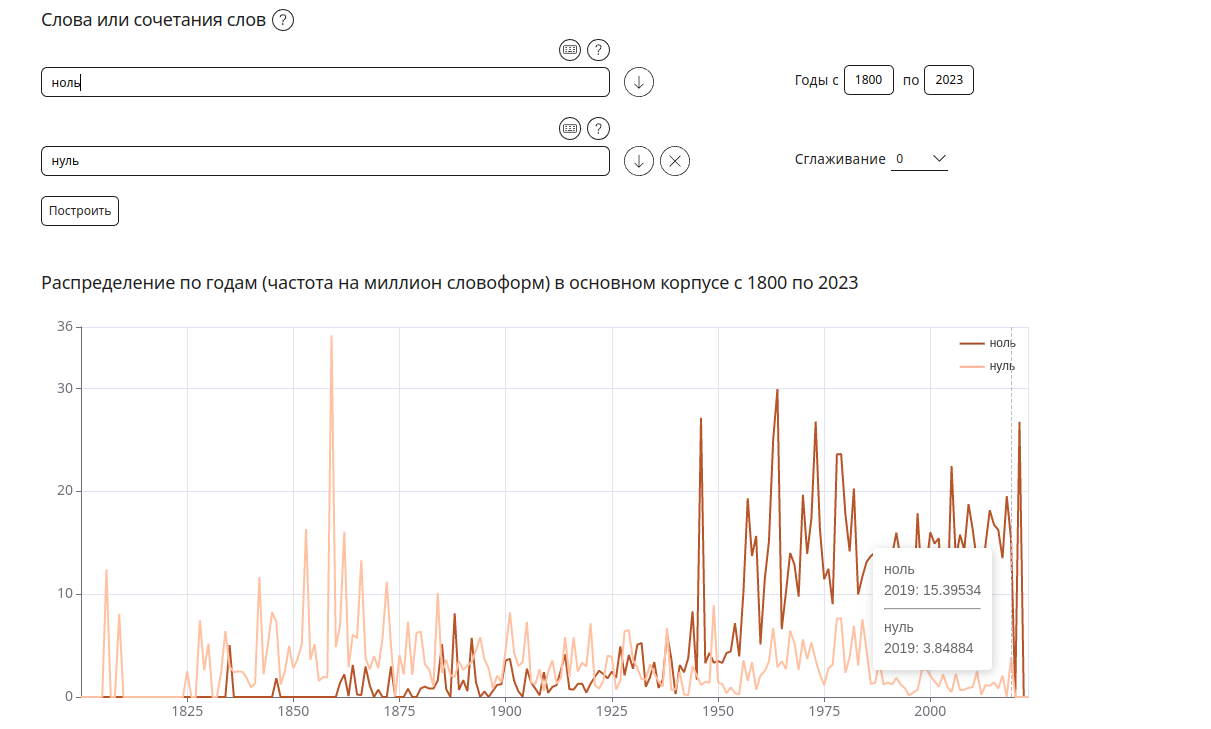

In [46]:
display.Image(b64decode(base64_nkrya_image))

In [47]:
nol_nkra = 15.39534
nul_nkra = 3.84884

In [48]:
print(f'Соотношение нолей к нулям: {nol_nkra / nul_nkra}')
print(f'Соотношение нулей к нолям: {nul_nkra / nol_nkra}')

Соотношение нолей к нулям: 3.999994803629145
Соотношение нулей к нолям: 0.25000032477360035


### Google Books Ngram 2019 год

In [55]:
base64_ngramm_image = 'iVBORw0KGgoAAAANSUhEUgAABhQAAAMYCAYAAAAjFg2oAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAbtQSURBVHgB7N0JfFTlvf/xb5Yhe0IgLAESMKAQCCAgAQU1WAWroBW9oq1ikdblWlutrbW1i/5vbe1i63pFbtWqtIpFrOIGWI0CsgkRiCQREoEAYQmE7AmT5X+emQkkIZNJMlkG8nn3lZrMnHPmnDNPDpnf9zzP41drEQAAAAAAAAAAQDP8BQAAAAAAAAAA4AGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgUaA6yOEjtVr1WY0ysmp0OL/W+lnq09v5XJ8YP114QYASh/tZj/mpO/ivL/544vukiHj9ZugNAgAAAAAAAADgdNHugUJdkPDG29VNPHdyme1ZVY6A4aIpAZo9K0BnukPHj+nTo186vjeBAgAAAAAAAAAAp5N2DRRMb4Tf/rmqxcubgMEED5+uqdaDP7V1m94KAAAAAAAAAACcbtotUPj0sxo992LDMMH0QDDDGyUO91fiOX6OACH/SK0jeNieVXtiOfP4UitYuH1eh43ABAAAAAAAAAAAvNAuFXwTEDQOE0YO99ODP7E1eCyx7ptZAQ2GRjLLEia0r/wVf9CDb+S4X8AWqsj+8Ro9LkWXXTpOsUHyMXal/e1eLdhol/zHaf6TdyjZps63e4kefHSl8mvMD6FKmvew7p4c2fw6Nel6/r6ntKHM+n7MfD19V7K6YtdPG5VpWvDAAqWZ8xWerLsfna+kFp2wfK38w4NaYpq5f5yu+NUvdbX/Gj3/3BKlFUVp3LW3a/4FsQIAAAAAAADQPvzVDhoPc3TtVQGnhAmNmeGNzNwJJkjwtCw6gL1MRbmZWvP2Aj3y2wVas98ueFKm9Df+pbQSoT0FJWnSqFDn9yXpWp/VwrZ4aIPW73J9HzdeUwZYIdQ7S7Rhf5nsJXna8K/3lE6zBgAAAAAAANqN190CGvdMMGFCayZZvuiCdsk04JZNsWOSlRDe8FG7vVB5WVnKLbLLfihNLz/5skJ/OV/jwoXmFG3QkrenKOnbI+h10G5sSpqQpNCNG6zIpkyZm7JkT0ryeH7zNm5Wbo3z+4TzkhVj/feArd4lLdCmwDN/vncAAAAAAACg03gdKJi5E+qYoYtaEyagM0Rp+Iy5unFYE0/Z87Tm+b/o5bQiqcAqlC+frnHXxglumOzLau75q17TW5Mf1HUJRArtxTZykpLCN2hDiZXZpG9Wlj3Jw7BHeUpLy3WtnKBJE2Mc3yZdc4uuKPm30gpjNO6qb2kEeSUAAAAAAADQbrwKFOqHCUZnhAnVf39TNZ9sVE3qBtXu2if/lGT5DRko/4snKuC717RoG7WH/q7aok9UW5gqVe6SX2SK/KJSpMiLnf/1wMwZYY7d/NdMKG2CFDPx9IUX+FuPOSedNsxjre2BUfXwM47jMsdpjqvuK/A3dzn+265ssZoy99vatmOBYxif/K2blXtNnOIowjZpxCWXqfSTlcq1gpjU11ZqygNXKJZz1T6ChmvSmEht+MwKt4q2aXOWXUnNJQr7rfBhn/Nb27BJGh/tejwySVffZX0JAAAAAAAAQHvzKlCoK5zXMQX0jmKK7PZ5v3AECfXV/WwK8NUv/Vu2F38nd4V3EyDU5j5shQmpDR+3fq57zK/vd+Uf9xurwDmkyW0sXVbtmEi6vu1WiLA9q1qfrql2nIP6QUtLA4Wmjs88Zr7qjtMEJiZYaFehwzV6iJSWbn1flK9C6z/0UXCjb4q+fXG6/vBhnuy739NrnyTr3mkxQnuwaXjyaEV+tkZF1v+2eRj2KHdDmvJq6tZLVqQAAAAAAAAAdDSvAoX8I7Unvu/T2/PyjXs0NKd+Id4U1SvPutTjOqbobpYL+vpDNQ4VTJhQ8+U0j9swvReqrWUDkj4+JVR45M92R3jgjumtcLgVx3jiNZs4vrr9rwsU6notmJ4YpldG+ylTWZnr26BQtw2iaGeqVqSmKX3nHuUXWivYQhXVN14JY6Zo+iXJivMw94K36zclf9VT+sM/01VkTnlogq6+58e6YrCzBF22e41WrtygtBzr9QrKZA8IVWT/eI2ekKLLLhmn2CC12nF7DyVceZ2mpD2lNUfsynznVa05925NiVYb2JW3aaXeW7VBmbvzVWS3KTK6v4aeO8k6HylKiM7VWw//Vu/ttxZNmqu/3j1FjmmLD7yn3z78lmPugBHf/qvuvdgqrq97T+9+lKas/fkqs0sJ1z6in013Bh32gkyt+TBV69OzdeBIkcqqbQoNj1H/ocM1fuplSkmKaVS0tyvtb/dqwUZrQ9Ep+tnvblRCYaZSl6/U6i9ydKDQLpu1nwnjpulbV05RnGsuZRXlKPW9d7X6yz06UFBkvb+R6p8wXlO/eaVShrWs3G8blqzR0Wu0psA57FG2PUkjmkoUanK1OS3P+b3p2XBu6Mnn9r+lh/7nPUfYEHvlQ3roqthT1zf7uvxj65xkOva1rCbUce7jh4/W1OmXaVzfei+a9ap++pdUK+KwtvfNX+qhbzURt9V7T8w5u9c6Z6cOtZSvlX94UEtyzDJTrGXm1lvG2RZWfrZZWbuOqNC8iaEhihk4QkkTp2n6lARF+rt/zZa0AwAAAAAAAKA9eBUoHM4/WVxvSe+ExhM4u2PCiYsu6HHiZ3Pnfn2BD/1AAbd8S6bobkIE0zPBFNvrmJ8b3MlfueuUMMF/2IvO4Y2s0MDRc+HwS44woW752kMvyc/0VHAxYUj9MMEMc3TbvEBrX/0cPTUyvqp19FAwoUJr1T8+c0z1eyI4ggTreKoeevpELwYTmLQXe9ZKpe5yfm8bMlTxjd9GM8/Couf06ro8q+xZT2WZ8nMzHV8bPl6hlHk/1I1jmigce7u+G0Vpz+uvdWFCUJwuu+1uV5hgV867f9FT7+RYheJ6K9SUqch6rTXma1WSbrzzDqXEtW4OBLv9uFXoTdJ1147TtoVpKipJ17/fSNO4741TaGs2VJmr1L89qVe3FtXfuooO5ShthfW1erUum39dCyZ9PqINf1ug5zfmn3zIP1YjEp1F5PyNL+vpV9Yor7LBUaisKE85aebLKt5Pnqsf3JKsGDe/voXbl+gPz69UTlm9LRzJVfqHLyt9a7bu+OlcJeW/p6effUuZDQ6nSLnpqXp1+2Zl3vIz3TG5BYVt21AlW21gzSfOYY827LRbx9LEWchdrw2HnN+GJk1VUitOflHaq3ryxVTlNjgnZY5zn26+1nyscdf/UPOnxTnPf8JojY5M1Rprl/K2b1O+FSg0PpL8rdtOTA6tgnSl77KK/AmNXzhL6a4pH0ITx2to3fm22sLKhU9qSXpRw+VLrJAha4Pja82qFM3/wY1Kcvvr0Xw7AAAAAAAAANqLV2MU9YnxO/F9/d4K7cnMKVB/GKAeH7/UYD4Bc7e+GebIhAwn1rGK7/UDBhMO1Oc/6mPH0EZ1PRBMsGACBv+4h04sU5P7kCNYMA5bx1Y/DDFhwoM/sTnCBMOEKWb+iIumtH4OCcecEPWOz3Es9cKQuvkh6vdYaBywtEllkXI+e1V/WZCqfFMMtVlF+W82KozX5Ct1wR/1cl0Y4B+q2KRkpUy/TJddnKwR/V1Ll1kF8mf/oOfTGhVFvV3fjbKMJfrL8xtc+x2jKd/7oa5LdG7Lbj33fF2YYF5vzBRddtXVuuJS6/X6ul7vSLpefeZVpZepdWqckUjohG/rW64qdtGmJVqSYW/FNvKsY/3LyTDBFqm4cdY+mnNy4TglRNsc52Plwle04Vjzmypc95JedhWRbZGxio2LVczAJI22moo9Z4mefuFkmBA6IElTLr1CV3/rCl02eYRiHD00rKL1uuf19OuZavIIyjbrn44wwaaYRNf7Zu3jid4kh9bo5Ree14KFzjDB1nuEkqddZp3rKRo32FX9rilS2uJXHQV5z2wakTzeVbA3wx5lN7lfORvSnO+91VqTJia1OMwp2/qy/rCwLkywKTJhnKZMv0JXTE9RcmKsQv1d+/vaX7Rglas4bxuu0cNdr7DfCgVOOQ5r+S059X7OV3rdZNH12HdsU7bdtc9jhjvDCitsW/nkX06GCeGxSpqcYv0eXqaUC6zzHF3X2yZVC/66RDmValJz7QAAAAAAAABoT171UKivfm8Fd0whvrn1m7q7v36x3dy57264H1OEN8X5E3MOfLJRdZM0O8IBFxMauJt42dEjwfRScAUJpueCI3hoxPRMaIoJFcxxtGZoJ7OfdeofX13PhPrHVKfxz82zivp/ul2pzS0SPUJX3DRfVw9ueDd4/kfPW8VOZ9Xd1jdZN945V1MG1F+mTLkfPq8n3zA9BfK1YdE/NXroHUqObJ/1m2LmLnhq4UrlmeKsf4ySb7lXc+v1bMjetNlVbI7UuFt/pTsm1tvYfxUp819P6umPDiiqv01lJVLruhbUidSUOVdo9Q5T5M3Xmtfe0tRfXqeEFnR4yP/oZSuAcJ2T/lM0964blVx/iB17vtL+9bSe/yRP+R62lZeT6xjq6bK51ns3rtHQRQlX6/bbQvXWu9bvz5T5mjstrsGhXvctE6osUGquFSqsfl9rZoxQSuOhm6zQqcjfOo83/UzzL6y3/avS9PyjC7ThiAl3NshMvxGadKPuvyNFsScWKlP6okf0lCnMl6Vr9YZ8K9BowR3zCZM0rm+qVh4ywx5tsIrwIxoOe1STo81bXWcmcpwmJbWwl4m1D6++ssYVQsVqyrwf6MYJDc9Z2e6Veu7JJcossfb930uUNu4OjQu3afjY4QrdmKYye7a2bS9TyuR6Z7Jos9J3m29sCrUeLiuzzmf6ZuVdG6eTgy3ZlZWe5QxHgkxA4XzVvA9f1ls7nW0hNPE63X3bZUqo/yaZtrDYagurrEBu/0q9vHySHrrq1CGXmm0HAAAAAAAAQDvyqofChRecvCPfhAGNJ2luzNzV7+6r/pBJ9b+vHyi4m2y5Tv2w4UTR3RUOnBB5sZpTP2yoLfrE8d9V9QICMxxTXc+EpngzMbU5PrPfpleGmVOhbpijOqYXhhnuyPTSaD82xcQlKD4mpOHD9kyt/DDHWQQNHaHr7p7fKAxwPKG4S+/QD2e6hocpSdN7H+W2z/pNOZCqBU+/5Rx+xyp0J93wA82dWL9IbVdVhasniX+U4uMaJxORGnHtD/XQb/+qR+4xhXy1Xd/L9O1LXftt7dc/V+R5Xseck4/qnZO75jYMEwxbjMZ9+8e6cUxLko4YqzB+t65rsohsU+y4K3THLx/SHY3CBIfoJN14sxUAmOZqCuUZTXfXiEy+RXMvbLR9q5B/xeR6cxOEj9ON8+qHCY4DVNL0FCW4fh1yd+WqRf04/BM0fozrPS1wDnvUQM56pbmGO4ocm6zhLaye569/V84OMDYlXHm75k449ZyFDr5Mt9/g6qVTkq7UTc6eA6GJo5Xg6tGRk5HT4DjK0l09D6yg4IpvDnW1h20n9tGhJleZWa4Q6ezRziGaTFv4xLWtyGTNbRwmOBY2bWG+Lhvg/DHvs9XKafIS21w7AAAAAAAAANqPVz0UEhv1ODB35re1oF4/jKgbSqnxnfhm6J/mmOfrhjqqCyJqK3Y1WMYveEiz2/AzcyrU/dBo3fr75k5LJqeur35gYgIE89VgfxrNqdB6NsVNmKKhjWvrNXYVHshS1o585W99TwuytumyO398Yugg5aYrvcD5bcykqzWlbzPbv/RbGvfRU9pQYhU9rQJr3rfiFOvt+o0XK9ig55981TXkTKhGXPND3XFxbKMCqk3xZ8fLtjFTdquI+96zC6SrpmtqUoIi6yZhtoKImFa+R+7EffPbStn0B608YFfu8teUOvFepTQXUrT4nERqyswpWpm+0jG5sFsJKbrCQ/BQtj9NqStXa/POPTpSUDcpc5R6xw/X+HND5YyR7DpyyHQParytGI2/uOkhhWIG9rfOtnMoq8hxKRrX1KTaMbGKsVbOsd5Xe0mhY9mWFLwTkscp5qOVyq8p0ra0bNkTR5xYL2dDuqvnhrVvE4e2sIBepqwtrkDDv7/i+xYqM6Ow6UUDY9TbuoSVWb8f2VnWa188Trbw0RqdYFN6hl1l1u9Jdk2Sa0LlMqVvdfY8sJ09XpMm2pX+dqYy7bnatjVfV9T1yLACBuf7btPQMaOd53N3mrJcbSF0iNVmd1vrudn7qFjrl3e/1fALs7TtgHV+BjRaIMFzOwAAAAAAAADag1eBgrlT3wxjVDdZsQkULrqg9aGCCRPqD3eUeI6zaG+K6XV37Ruehvqp3b3/xPd1vRkaD29kAgY/19wJHrnCh5jefmopMzlza9Q/vsaPmxChbtimtovS0Etu1I3Dmn62LOstPbXgPeWYcftfeFVDfzPfURwu25frKtyGKmF4XPOF26AER8F1w1artHpoj6z6uqK8XL/h3e5WOPBUuvLqtZGQ6Kgmtxl5wXW6etNftCSrTPYDaXprofXlH+rohZEwfITGj5ukpITI9rmT25agK/5ritKeWaP8yky99a81Gn/XFDmymyZ+BRzn1DX2v8dzEpekhHArUGhm7oGYhKFyP4iQXTkrntazb2Y6J66u93hZUb7K0vNNvnHyUXsT/QdM8b1/01u3BYXKOQW2NGDgADfHEqpQ24mXVcumZLfETVJy35V6zyqeF21NU/Z/uYY9smdqfd1wR33HadLZLXwXaw5ozyHX8VlBU+rCvzY/BFjdLufnqVBWuGG9o+OT4vRqRo6jqJ9l/bqOMCMPVWZpc5YzJjFBQWT0cVmLKdNaLHdruoouTXG0haLtmc5gyD9OSa6ZlcvyDpwY0qps6xI9tbUFO1RTqPx86/Ua9fRpvh0AAAAAAAAA7cerIY+MxvMJmMmLD7diguamJjyuH0jUH+ao/nwDTak/EXODQnz9AME1jJE7NWYOhbrXdq1Xv9eBCU+aO76WzCVRX+M5IcywRsG1GY6hjbwPEzwLHX615l/lugO8KE0rNjor2FWVx+uWUGiEp8KttUxd5dgqTJfZvV+/gZp85R1qMNCM0l7/l9JKmtiUmVz6nod177VTnBMcO9YvU/7udG1YsUQL/vBT/eJPryrtUCsmUm5uz5Ou03UTXEXirf/WvzaZoW0CZWviN6t15yTMMSZ/c2w299swExA/+0ZdmBCq2AlX6MY77tXPfvEz/eyeOzT3qika0dvTPthka0HNPjCw3aZicbIK7+MnuPqoFGxWmmvOY/vODdrsuqs/9txJJ4ZT8swKlyrVepV2lbvCmMgx4xXnmLQ5T9vSnVGAPWuzHCMZnQgKYqz/Ouc4sOekaVuR87W3ZbiG8YobrXGua8nJttAaZSpr4jhsthYGKwAAAAAAAICXvK4Eml4K114VoDfernb8bHoaPPInuy6aEuCYpLg5pjC/0BFAnHys8Tqm4F43LJAJDAJu+ZaampjZzDvgrgeD6aVQ6woKzATNAX1vaRgyuNTsnNdgzgU/s5yc8yKYUKFuP82cChde4H/KXAqmp0VrJmQ2PA3jdGLfrHNgn/cL2V78ndxNTN1WMWOSFPd6pnJq7Dqwa4/1SJICg3q4nrWKmMWeBquxOyajdbCKmyYb8Hb9Jvdz4lxdF71SC8x8BUUb9M83Jmn4LU0MyeMfqRHT51pfN6ooN1uZWenWV7a2ZeWoyCrIFu1M1YK/lOmOX85veqieVgnVuGu/paQvX1Z6WZE2vLFEU4Yny9ZE02/dOSm1zonayNqPj9LkmgFASd9+UHdc3HB8/YTEcZpyYbz++rNXldm6Jtsp4s4bp9j385RXU6TNmzJ14/Chyt60zXlM/rEalxzXiq2FymaGvDIBVNzVeuiXV5w6pJYnfZM0fuAS5VrZwIGMdBV9c4r2pGXK8RbVCwpix4xW7Du5yrNna/P2Mk0Zl6XMHGfbjk0ad6Inwcm2YFPyHX/V/HGEAgAAAAAAAPB9XvdQMEwIYEKFOqbwbgKGR/5sdxTY68+PYEIE87V0WbXuecB+Yrgkw2yj8XBJZtif+r0Ujk+7pUF4UFdorz/3gCm4159zwD/uNw0ChOpNZzkDBld4UFuYqpr0aSdCB+c6DzVYxwQkdcyxmSDEOVSTc//N8fz2zy0e1KXBvtbvieCYR8E6vhNzQLgmaTbHbb43x1q/J0a7q3YOYxM6sL+r+FmmnKzc5tepzNK2Xa5AoG+8+tu8X7+xyDFzde+tUzRu5twT8xQUrXtVSzKa62lgU2TcCCVfep3m3vUz/enRX+rGca7JJAo26N1V+WoX0VN045UJzoL9kTV6zSooN5UVhA6Ma3BOmu0jsS/LMfdAm9TsV96BuvM5RVde6Gay3kN5riGYfNCAZCW7fu2L0tOUWZalDVtc4z8NtJ5rTZ7gmDfBdQYOZbfxvMZqdJIzhrDvylRmkZnI2rk/9YMCDRyvJMcPduVszVJZzjZr3+UIQZLGnowxQmPrfj+s5XIOCAAAAAAAADgdtEugYJg79uuHCoYJC8xwRqbQfs8Dx/Wd7x93hAjmq65HQx2zrrseDT0+fkn1QwVTdK8861JV+CU6Cu31C+xmObN8A1Yw4N/3uw0CAtMbwQQL1Z/5qeZLK0woSm2wvJ8JIeox+zay3iTU5ticx2V3HFfj42mNxqGJOT5zXOb4zHHWD0tMqFB/2faQn7ZZua7Ccu/Y3s7ic9w4JUW7nl//llKPuF8/76N3leaq9cYmjXbe/e3t+vX5J+m/vjdFMaa1BiXo6jmu72vyteafS5RzYhiYMuWlrdTLf3lQDy3KPLVgHxqnlNnTTwyVc+RA+xVyYy75tq6Icxat8z55TxsKmlgoLqnBOVlzyN3WirTh3dTmJ2RuBZub11jz/ga1U6TSAWKVPMGVGhxJ14b3159oIwnJya3sYRCq0WNdEzhXpmvlh82EOYdSteB3T2nJqpxGc09Yb9+YJGcIYAKwjzY4J1r2j2kQFDiGaxrlio2y1mtlWpazV0X0cI2vH4IMHqfhdW3hs3ebbi/OrSjzX3/QH158T2kH2meYLgAAAAAAAKCt2i1QMMP/mKL7L38S2KDwXufwEXfrSbfPC2x2eCRTQDdD/XgqpJu7/U8JE+q2YQUE/sNebHKoowbLWcFDwISvm3zuwZ/YdNEF7k+ZOZamjt2TuhDEzJ/QkuXac8ijoowlWvB2jrPAWn/setsIXXap6677skwtefJlbThl3oEy5X6yQE/XrR+epCsuiWuf9RuwNWip9ectMAXgl99xra9Cpb2/RGuy8pW35nk9vyrvlMJxflamDrgKxaHhHiYpaA3r3F12Q4piHUFH2anzQDgOwzonl9Q7J880cU5qipT+ryf1clqbxzuy9iVe8QPr7shfr3c35J/yGmn/fFKvpnvxGp0gZkLdPAlWcLRig3N4If8Eq422fgriyEmXKdlVwM9b/qQWrMhR46O3H9ig559ZorTdVuiw6C96fk2jGbGH1AVCZUr70BXGRCc1DAoscWOHOyfmLrG285nz3EcmjWs450P9tlCSppefaWpeDytMePc5PfdhjnLWvaUF1r7lkCkAAAAAAACgC7XzbKrO+QZui/FTRlZts3MKmOJ7S+ZZqGOK6GaiYtMbofqlf58Y8sgU2c2Xu7kV6jNzKZiwoDb3YccwR7VmyCPry4QIjuf73OJYpjkm/LjoghplfOU8PjMJc90wTeY5M/TR9ixnb4U+MQ3DBT+5DxvMMTh6Kgwe4Jh82hyfGfao7vgaD+PUcoXKet8qrjcxV0DZoRxl5eS7iu42xV76bV3W/+TzMZfM13UZjzgKz/YDa/T8b7ZpRdJoDe0fJZvdKtpnpSt9v6ss6x+j5G/fouTI9lvfvVCNu/6/NC7jecfEzHkf/1PvJf9MV8fFWkX9y7ThLyuVZ7eK5ose0i8+G6fxifGKsdmVl5OmtPQ8ZyHZFqcpUxLUnmzDrtB1U9L0VDNDKcVcOldXp/9RS7Jc5+T/Oc/JCOucqCRP2dvTlXPEekeCYhQTkK/8NtX8Q5V86RS9tz1V+SY8ePEhPbgxWeMSYhRaka+sLzYo0xSve8cosiD/lDvxfUZf670bYhXRc04+ZDt7kib1VuuFJum6m1KU9YzznKS/8Qc9uGqEkhLjFBNkV+GBbKtt5KrsxCTMN+rmKY0ao/9QjU6MVOpnRbLbnb81kSPHOSdrrsc2bLxGhK/RhhK7nIuFavSYoafsUqzVFq6z2sKrpi3kpmrB/9usuERXW6jMV25GmvN9cmzUats3Xa0EploAAAAAAABAF2r3QMEwvRX6XODnuJv/9nk6Mc9AvlV8j7GK7I0nM24NM99A/TkH2sL0Vmg8pFFrmAAhcbj1TRNhiAkYmvJJ8u/UEu1xfA1ZhfT0DcprdplQxV06Xz+8NqHh8DhWkT/ljvtlW/ScXl2XJ7tViM3dusb6arx6nFLm/vDk/ATttX5zIpN13bfWK2tRusrsuVr5ykolP3CFYhOu049vs+vJF1OVaxXji6wQIdX6asAqzibfcoeuGKB2Fqqkb12n5C0LtKHIzSL+VmH4rh9LC5/UknRrISv4yE2zzkmDzcTpsnnXyfbmX/VeGzsR2BKv0x3X5uvJN9KtwMCu/PQ1Wpleb4HIJN145yRl/s4KZeSrYjRuQoKWnEgUbBo+cbxa0UoaCE26UT+7y6Znn1+pnDITqGVqg/XVkBWsTb5Rt9/kGlar0XPDx4xQ6Geu3hLW+z1izNBTh5SyDbdCrFBt2FhW98IafXYTSYDVFlLuul966Wkt2WQFe3Y3vx+RI3TFrfN19fB27FEDAAAAAAAAtEGHBAqN1QUI3gQJvsD0tlj1WbVumxfo9ljq98hIPMeHj9ffJlt4lOKGjtOkS6crZZibMq1VfJ8y7yGNviBVK1alKX3nHuUXWoVSW6ii+sYrISlZ0y+dorhwdcz6zYi58EZdse4hLdlpl333e3r5o3H62aWxjrvLf/nrSUr9cIXWb81Wbn6RFavYFBkTp/jE8Zo2I0VJvTvoVu/wcfqvq5KUboIOd8sEWYHB3b9T0sb39J51TjJz81Vkt+rG0XEaOmaSUqzzMSIqV6++5lzcZp2r1u+tzQqJ7tbDZ6/Re8tXKy0r19HbITQqRgljUnTlzBQlhGxQpnybY9ijf+c4h/oJGq5J49oaJzhFJl2nn/3PJG34aIXWbM3RnkP5ViBlc5yX/sOSNClluqZYvwvuzrdt+GgND90gx4hUoVZwMLypJa3gYexw2TamOXr/ONYJcrPBICtUuO0hJaWnauXqzUrPPqDCkjLZrfc8pn+Cho+bqssuHqdYsgQAAAAAAAD4AL9ai+CRmVS6bh4IM4G0mYS6cahgJqCuCxTMkE6PP9pDQJsUpeqvP3tVmTVmmKSf6ZH/at/hmQAAAAAAAACgtTqlh8KZwMz38MbbzrkRzH/N/Alm6KMYV6hgei5sz6ptsDzQWNHuDVq9ao027InT3PuuU0KTd67blZu62hEmmGF1EobHCQAAAAAAAAC6GoFCC9VNHl0XKpjwoG7y5cZGDvdr8WTT6E7s2vPRv/TWOjPBQqae/VuMfjgvRXGhDZfJW/WyFrzvmlWh/xRNS2ImXgAAAAAAAABdjyGPWskMabT07aoTwx81ZoZDIkyAWwUbtOAPzyutwPVzaKxGjBmuuGgrVSjLV25WujIPuGZfsMUq5e77dSOT8QIAAAAAAADwAQQKbWSGPMr4qlaH82vVJ8bPMfRR4nC/037iaXQ8+4E1evnZV7XhgN39QuEJumzenbouybtJiAEAAAAAAACgvRAoAF2hpkg5az7Wx5u2KSf3gPLL7LIFRyqqT7yGj52kadOSGw2FBAAAAAAAAABdi0ABAAAAAAAAAAB45C8AAAAAAAAAAAAPCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPAtUBCgsLVVpaqoqKClVVVQkAAAAAcHoKDAxUcHCwwsLCFBUVJQAAAHRffrUWtRMTJBw5ckRBQUGKiIhQSEiI449PPz8/dTvmrHbDwwYAAAAa4O/i05r5uGhuEisvL1dxcbEqKyvVu3dvggUAAIBuqt0ChUOHDjl6JMTExCg0NFQAAAAAgDNLWVmZ8vPzHT0W+vbtKwAAAHQv7RIomDDBbrdrwIAB3bM3AgAAAAB0E+Yj5P79+2Wz2QgVAAAAuhmvJ2U2wxyZngmECQAAAABw5jOf+8znP/M50HweBAAAQPfhdaBg5kwwwxwRJgAAAABA92A+/5nPgebzIAAAALoPrwIFczeKmYCZORMAAAAAoHsxnwPN50F6KQAAAHQfXgUKpaWlioiIEAAAAACg+zGfB83nQgAAAHQPXgUKZszMkJAQdVteT2cNAAAAdGP8PX3aM58HzedCAAAAdA9eBQpVVVUKDAxUt8W0EQAAAEDb8ff0ac98HjSfCwEAANA9eD0pM5MxAwAAAED3xOdBAACA7sXrQAEAAAAAAAAAAJz5CBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8CBQAAAAA4fVQV62Dufu09dFhFpVWqsj7WBYZFqF/fAYqL66MIPuUBAACgg5w+f2pafzQfyS9WcaUcfyz37hWhEPpXAAAAAOgmind/ro9S12tT5n4VV7lZKDBCA0eM1dSUqZo8OEIAAABAe/LxQKFKxdnr9O5Hn2vrzsMqr6n3VFC0hiSO1bTLpmlMX27BAQAAAHCGKt2jj5cu1XtbD6vK07JVxdqXvlqL09cpdcxlumH2VA0JEwAAANAu/GotaqOvvvpK55xzjjpEVYE2LX1Jr2308Eezf4QSr5qreVMGyCYAAAAAOHPY96/Tiy8sU0ah64HACA1JGqsxI4dr5JA+ioyIUIgqVFxcrAO5Wdq+7UttSt9zsgdD1HBde+u3NXVAx92E1aGfCwEAAOBTfDNQqCnQupee0+Ltxc6fA6N19jjrj+ahAxQZYv1RXXhYuzK/0Kbth1XuWCBYQ2bM139fSqgAAAAAwKk8e7XWVY7VtJGtG/qnePtqfR50nqYNDVZXsu9frf9b+L52lJqfAtVr5DRdO2uqRsY0Hw7YC7KU+vYyrUgvcN6cFZagq267RdM6KFQgUAAAAOg+Ah6yqI2OHDmi3r17q73t/c8LenHdEZkRjkIGTdbN/32zZp53tuIH9FW/Pn01IG6IRo6brAvODtCezBwdPV6lY1/vVHlCskb2YmIFAAAAoLsr/+p9PfPSR/r8iywd6z9KSX2DWrRecfqbembRp9q8ZacqB43RiN5dNLxq8Zf654I39aW5x8o/WGdPn6e7rh2rAaF1n3eqdCR7mzZvzVTWrgM6Vh2mPr1CFGA9ExASo6Hnjtc5/nu1/esCHT9eoKysAg04d5T6tew0tEpHfS4EAACA7/G96nvx53rv0/3OO2liJmvebbM0JrrpP+JDzkrR9793mYaYP4pNr4b31+mIukja7zT9nARNenjtKU9t/u3FSjjnYv2m8VOHN+v1396p66ZNUmJSoiZNu053/ult7SxrYvu7/6brEhOUkNDEV9KdertunepUPTDBemzmM/qyWq3T3Lr/uUfnWq8166md1g+VWvsr65gSztWdy4oabeNLPXa5tY1z79TrBZ247wAAAEA9VccrVGX+pqw6rPX/eF6vpRd7XMcRJvzjcx00H0aq7So/blfXKNamfy/VZscwR1aY8M35+v6l8QpxPWvP/1JvPPF7/XbB63rj3ZV6791lWrTgz/rNE8u0Nb9urKNgDbn0Ft31zQTnegVb9Nq/t8jzWQAAAADc87lAoTh9i3Y4xjGK0PhZl+nskOaXtw1I0bVT+ji+r8rdos2HdHo48Lbuuf47euDltaocMU0333SzpsUdVuqz9+i6Gx/T2kZ1elVWqtL6QBQ0+ip97867dJfj62ZdMEhdIEjjr5ihuMAirf3PWjXY1exUpeZIked/U5dHywf3HQAAAN1BRNI1uus756mfuTepBaFCgzAhsI8mfWe+bkhq3VBJ7cX+dare21rh+D5izFW6OaXe0K7FX+q1Bf/U6r0Vp6xXvnedXlywVFtPHGag+qVcr2vHOI+jPH2lVnztcVpnAAAAwK0u6r/rTpW+znH1TggbrgnntGzM0kHjRqlfaqoO1hzS17utP6z7du1Yp54V6e3fPqK390Vqxu+W6Nnr4lyP36ebn52v7/zpGT3w5AVa8cvzdaJHcmmFKq3/9J04V7/46XjXg7n62xev67Oj6nRByZdrxuC/6W+r3rfCjxmaEel8fGfqx9pZFamUK1IUKd/cdwAAAHQPzlBBrqDAGSqoiaDAl8IEqUJbP/1Cjj+TgxI0/aqxOrknVdqx8n1Xz4VADZw0S9d9I0n9dEhbVi7TGxutz1KFW/TWyvOUODvBFUJEaMJVKVqftUw7Kgu06dMvdcVZYxUiAAAAoPV8rIdCuYqKXXfaREc77yZqiZi+6uc4kipr/dOgE++Bt/R66mEFnft9/eJEmGAEadRtP9b1Q61y+5uLlVp/6KOKIkdRPjKsAwY9bYuA8bp6+jDr01eq3l9X6XowV2s/+VKV0Sn65sWRJ5f1tX0HAABAt+EIFW5231PBt8IES3mWtu5w9U5ImqpJUfWeq9mvrZnOcUUDz/mmbr/uPA2JDlZIdLwmXz9XVw91foA6mvml9tXUWy/qPKW4jql8x5faXikAAACgTXwsULApMMD1bY3U4s641ZLd9Qezzd/HOl00xfoDP90KC+LGj1dc4+cCRumCcX2sTzbZSt9V7/HKShVagUNQWGTLXmP7Y5p1tmuegnMSde4F03XTL17R2sNqN6OuvFqjVKTU5amOwEAHUrV8S6UiL/ymUiJ9e98BAADQfUSMbDpU8Lkwwdi/R187/rgO1tlJQ08OdWT4h+jsySm67NLLdPUlo9RwTyM0ZLBrzNGychXVDxQUaG3LNZdC5R7t2isAAACgTXys+h6syCgzXFGFdGS/9lp/SPdryU3t1h/dBx1/MEeo34Cu/QBw+KXvKOGlJp4IPBkdVJYVWgX4IEX26tPEgtbjkeYcFKmoUPXWqVCl9UHH+VwL9LlAN990vvo6fqjQoe2pemvJb3Tr1kP6xxv3aXxz59VR0H9MHo2cocsTn9Zjq99XatkMnb/6Y206HqkZ9Yc76ux9BwAAAJrgDBWkZ15xDX/0yp+1SVWqMp8jfCVMsJQfOuScONm/rwYNbPxxrY/GXHKZxjS1Ys1h7ch29l5Q/wFqvKpt4AD189+iXTXFOnjI+rw11NeHiQUAAIAv8rnb+c86e6gCN36pqsosrd9crAnne/qjvkLb13/pHGM0LEFjBnftIUWOu143p8Sp/p/nuav+T69/cfLnoNAoRQZWWoFBURNbsB53JAl9FRl+8tGiw/nO7fdq4V3+fc7X9f99l0bV9fjQ9zXtV7N06z9e0cv/+YHGX9FMVb5BQd+pYtcH+tubXzZacJiuunKUnv7zWn28NleVqZudwx1NbbjtTt13AAAAwI2GoUKVs0e0D4UJRlm5awhY/whFtnSXrIBk3eKX9PZu64j8ozV1+mT1brxMRIRCTP/0GvMa5ZIIFAAAANB6PhcohIycoAlRX2p9YZV2LH9dq8+6RVP7u9/N4q1v64005xiovSZM1sgurjUHjbla9919foPHNhe+3iBQ0KjxGtXjda39Yq1yNarhsEfVX+qzNCtoiEhR0tCTD+/cZRXsA+MUF9vWA4zU+ckjFfSPVOUfPmT9HOd+0VMK+pb/7NArpwQK1lauuFoT/vobffzmMypcW6Q+3/iWUkIbLtOp+w4AAACcxlo87Gud0iy9tfCfSt1f5Qghxsyer2vPOQ2GgQUAAMBpycfmULAEDdeVV7rGAy3N0RsLntdb6QWyN16upli7Uv+px/+xRUdNN+WIUboiJV6nhT6X61uX9lHlxv/T75bk1nuiUl8+/xe9vtsU6uecLMwXpeqD1FxzS1WDkKF1KrV583arsB+kmEF91W4GXa4ZE4N0+L3Xtby4j6Zdcb4axAa+vO8AAADoVoq3v+nqnWD94B+oQPNpqImJmrtSZIir54D1eafI4y4Va9PS151hgvUJasx1t2vepGg3ixar3DWvQmhIiAAAAIC28MlbVyLGzdath4q18MM9Ki/do9SX/qz1/ROUeNYA9bb+9i0vPKyvd2ZrX2G9+3esKvbe9Z+r9/nnaUiYfFykrnrg/+mzL+/R67+YpVn/uVrnJwSpKMMU33eqcuT39OiPnYX5nUse0EPPvKXPTMjwnVPv/nfr8Fq9/r86OQ9BVqreWpGryNH36ft1QxKt/o0m3fqK+t65TMvuHaW26aPLrzpfv1udqsqYabr8/JNxQofuOwAAANAKDcIEM8zRzfN1pT48OaeCFSrIB4Y+Cunb14oGclRcc0h791k7G93MR7biL7U+3TlEUsSEa3TDxGi3i9r37T8571xfhjsCAABA2/hoX9hgDZkxXz/qtUwvLrP+wC+3QoQDOdpsfTUWGDNKV8waoIxXVip1+Zdave2wbrvtmzrb10OF/jP06Ov/0Kgnn9br/3lLr6RaMcOgYUq5+3F9f/5VGuWabqAoc602HY7UqKu+r4d/mqIWl9MPf6ZX/vqZ8/vAIEX2H6bx33lU9917vUY13kigd0X6PpOnaUJQqnK/YQUj9TbVKfsOAAAAeNBUmHDDSBMcNJqo2RdChQHxOitonbZWVmhHerbsScNlc7dsqRVADI7XEIVo5PnD5b7fQZW1rRyZmRMUZC0/QAAAAECb+NVa1EZfffWVzjnnHHWo8v3atHaTtm7P1tf5BSqvlGwhEeo1cKhGjpmgCyfEK0L7tfKp5/TeXmePhcABU0+PUKGLFS25VZPuX6uUx9br2WtaOGFyU9t5805d9LPtuvqlFXr4fCr+AAAA8B3uw4RmlunSUKFCm176kxaZngdBCbr2p/M1NUreKVyn//3TMu2wPkuFJF2vX90yVu056FGnfC4EAACAT/D92bpCBmjCJearuYUG6LLv3aKyhS85xg+t2r9aCxeKUKFZh/XB8s2q7D9D30ppe5igyi/1f39PVdHgm3V1MmECAAAAfEdxuhUU/KNRUDDy1KAgYuQ1uus7ci3b1T0VgjVm6rnqlb5ORytztOLtLRp781g1uSfZy/TrBetUbD079Y4HdG2Tc5YVa9PbqY4wQYrWhItGiRkUAAAA0Fa+NylzW4Ul6OrbblHKAGdG4gwV3teOUqEpRTu182icrvr5g5oR3Yb1DyzXY7+4Rzdd/R09kxGpGf/9fY0PEAAAAOATmgwTmgkIIpJMqHCe+pmPE108UbNtaIquSHLOc1C89W29krpfdrVFlQ5++rre2Oo8jpCkyzT9LN+/pwwAAAC+68wJFAxChZaLPF+/eGOZHp/VR21Smqu05cuVXjZM1//mBf3hmjZuBwAAAOgAgT2CFWhueGnFEEYNQoUAm0J62NQ1IjRh9myNdwx1VKEd77+s//twj3MOhPp6naNpl6boskunKrFX4ycrtOvDl/TMu665E6LG6obZbno6AAAAAC3k+3MotEVpjt5yDX9kBA66TD+6O0WDzqz4BAAAAEAzyrNXa13lWE0b2boyevH21fo86DxNGxqsrmTfm6r/XbhSuxyJQKB6JU3TtVdN1cjo5nsZ2AuylPr2Mq1IL5DjE1FIvK64bb4uG9QxvROYQwEAAKD7ODMDBaMuVDgQojHX3a55E9syrg8AAAAAdB373tV68e/vK6PQ9UBghIYkjdWY0aM0Mi5akRERClGFiouLdSQ3S1u2falN6XtUXOVaPmq4rrr125o2oOOGOiJQAAAA6D7O3EDBKN2jTbsjNGEkYQIAAACA01RxjlYuXXqyx0GLOHs03DA7RWd38DhHBAoAAADdx5kdKAAAAADAGaFKxV9/ro8+3aRNmftP9kBoLDBCA0eM1eSLpmrqWZ0zYwKfCwEAALqPjuv3CgAAAABoJ4GKOGuyrjZfVcU6uHuP9h4qUFF5lRU1BCowJEK9+w7QWYP7KIJPeQAAAOgg/KkJAAAAAKeTwAj1GzrK+hIAAADQqfwFAAAAAAAAAADgAYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPvA4Uamtr1W1140MHAAAAvMbf06e9bv15EAAAoBvyKlAIDAxUVVWVui0/AQAAAGgr/p4+7ZnPg+ZzIQAAALoHrwKF4OBglZeXCwAAAADQ/ZjPg+ZzIQAAALoHrwKFsLAwFRcXCwAAAADQ/ZjPg+ZzIQAAALoHrwKFqKgoVVZWqqysTAAAAACA7sN8DjSfB83nQgAAAHQPXk/K3Lt3b+Xn5zMZFwAAAAB0E+bzn/kcaD4PAgAAoPvwOlAwd6OYMTP3799PqAAAAAAAZzjzuc98/jOfA+mdAAAA0L341bZTCnDo0CFVVFQoJiZGoaGh6vbMWfUTAAAA0L3xd/EZxQxzZHommDChb9++AgAAQPfSboGCUVhYqCNHjigoKEgREREKCQlRYGCg/Pz4BAEAAAAApxvzcbGqqkrl5eWOCZjNnAlmmCN6JgAAAHRP7Roo1DHBQmlpqaPHgvnjEwAAAABwejI3iZkeCWFhYQQJAAAA3VyHBAoAAAAAAAAAAODM4vWkzAAAAAAAAAAA4MxHoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeBaoL2Kuk49ZXVbXz+9pa5xd8m5+f88tmtZrAAKlHoPN7X2TalePLamNVrjZWQxvrNvxdbTXQtNEAZzv11bZacdx81arCbrVX6/sqR2O12qzQXfiZ/7Pi/UCr0dp6SME266uHn/Uln8T1FcbpdJ0FAAAAALQfv9razinlV1uFh3KrWFZe6fy51vyv1s9ZSMFpxTQYP79a1b17IUHWl1X4CghQl6prYxWVrn00j9WKNtaNmXYQ4HeyPQT7SFs1xdjislrHl2Guh9U11m+U+dEqLNfWOAt16B7Mv8J+pr+gCZKs9z3A/+T1NSLUz/HV1YVarq9wx1evswAAAACAjtHhgYK5a7G03HkXrimaOaolOLO4wgVzN21YiPOuxc5U18Yqj5/8GWhKXdsM6qK2Wm0VjAuKTZBgAoMa1VT7UZGFe9a1zD/AhO/+VqggRUf4WWGDOhXXV7RWV19nAQAAAAAdq0MDBdMboaScIKHbcAUL4SHOXgudwbQxU+wyKHShpeoKXGGd2FZNb4T8IvM7Umu1VT/GNELL+Zk2a/4l9VNMpLPHQmfg+gpvdMV1FgAAAADQ8TosUDB34Dp7JYjCWXfiuuHa9FYwd9R2pLo2ZjAHB1qrbkihzmir+YW1VmG21jFEDNdDtJmfc2iZsBArWIjq2FCB6yvaQ2deZwEAAAAAnaNDAoXCUucY4TU1Qjfl7++cnDEqTB2CNob20tFt9UBBrSorzST0tcyLAK+Zf7EDrVQhKEjqH90xDYrrK9pbR19nAQAAAACdp90DBUchws7wCHAOd2CztX8BgTaG9tZRbdUZJtQ65k4A2pOZSyEoyK/dQwWur+goHXWdBQAAAAB0rnad3tEMkeC4q5FCBORsB6Y9mHbRXmhj6Agd0VbNMEemZwJhAjqCaVemfZl21l64vqIjdcR1FgAAAADQ+dotUDCTN5rxlhkiAfWZ9mDahWkf3qKNoSO1Z1s1EzCbOROqqqnMouOY9mXamWlv3uL6is7QntdZAAAAAEDXaJdAwdx1VlLOXKNommkXpn14c9erWbe0XECHK/WyrZo7x/OLnBMwM2cCOpJpX6adOdqbF0EA11d0Nm+vswAAAACArtMugUKpI0yoJVFA02qd7cObglXdurW0Ma/Yc/Zp6YYK+bqSLXu1NP24Oltd+/KmrRYU18qP6yE6iwmurP8z7a6tuL6iM7XHdRYAAAAA0HW8DhSqq53d11XLrbhohtU+TDsx7aW1zDqVx7mb0Vv2nbv1wCO79M6Wctnl2wpyDunlP23Ts5s7P1Qw7ayyjW21bnzwGq6H6ESmvdXNf9Ba3f76aj+iJ+av0ZW3fKF3Duv0dfiwdc3crFutY/nWbV9o6W75NG+uswAAAACArhUoL5Ufd/VOkBcFtOrjyt18SCtSD2n7oKF67MaoRgvUqGBzrv7274PakmtXibXb/ROiNP2aBM1O6tFgyZKsvXr+9YPamFOhEv9AxQ/trZk3DNH0hMA2Lee9GuWu3aPXlh/Rlt0Vrn2PtvZ9SJv33cHjObOKslt26+U387XRvG5wsM4d3183f2eghoaqS5h2Un7cT+EhrVrN0cZaK/eNzbr7zYaFc5stUL36hWnihQN1w+XRig5QF6jQZ09u1RMZPTTnp2M0O6Fd50V3r+yI/vbkXmX3H6jHbo6WzfVwSU6ellq/V6mZ5TpaKfXqG6GJMwbr5ksjFF5v9c5um3FXJep76V/o2QVfaegjSZreR53OtLvWtlUzlr2fX41qa7wMFOzlSntvj97ZUKSvj1TpeA+bBp4VpUuuGKwZw3vIp1QXa/Gv07X0kL8uuXOibh/fSW26o5Qf1aLf7dBHAX314wfOUlKw9XbsOqBladYvyMAYzU4Ocy1YoQ0L0rUgq4eu+VGSZg3pwuM2vRT8a6z2569eka1re+VtzewKC/XOklx9vKVU2YVVCgoN1tDh0UqZGa/pw9r739H2YTfXu8+t9zGuj+acH9a6lXfu0n1/zFPp+GH6/R19FC0fUl2qxY/v1OLdNVKQTXG9eqiHu8uEdW35bPHXemNDofW+WYtHhei8qXH63rW9u+TfxLZcZwEAAAAAXcv7QMFMrNfGu3HtB45o+YqD+nhtgTKLnY/F9Tt1uZLNO/XzJw4rt1qK7hOi+OpKZWcd0fN/KlPJL87V3OGuQk7Obv3m0b3KtKrI0f1dy20/qCceLdPxh8doZqxat5zXrDDh3XT95NViK0jwV79Y67Uqzb4ftvbdeuxn4zR3ZOv2vcXnbONX+vnT5pz5W9sLVq+CCm38ZJcy9lXpzw8OVpxNnc9qJ6a9tLZ4UFHpxd2zVogQ19PZPo9XVOvgXqsI9mqhNmYP02M/7Nf5RaFqu3busUKx4mplH7SKP50SKNQoe+kuLT8arFl3xGtosPNRe9Yuq83tc7S58F4hGhplV3aedX7+nq7csjH63VWugltXtM2AEM2cG6sVv96nl18/rAvu6tMg4Ohopr1VVLYtUKip9vMqX1VFkZY+lqHFu5yD4odF2RRWYdeu7fl6IatQX92SpLvPDxY6SGm5vj5co1L/Uu0rlyNQKM3J19L3rEY9LkSzrEDBcfm0fpe/tgLu0pJq7TpkvVdDujZIMe3OtL/WBgptur4ePag/PbRTqUet7wOsf9t6WWekqEJbPs/TlrQCZf9gtO6c6GPBl6Vk52G9+rb1Pp4Xotnnh6k1/wyWHCjT3rIaVe4qVUl1ny4KpN04lK8Ne02YEKUfPdpcAHtcnz27TY9ssDuCh6GDAnR0f6lS385UdvFI/Xl+9GlxnQUAAAAAdC2vAoW2DK9QX/YH2Xr2Q7tsocEa0f+4Mg80NavkcX3+nyOOMGHo9CT9bm6U9YH3uDY+84UeWluudz88ohuH97EKA1X67O0DjqKnWe4xazmbWW6BtdzqYi19p0Azvh/diuXaQfFhvfaWCRNsmv6jc/UjU2CprlDqU1v0p88r9O6Kw7pxZL9W7VOLzll1qd593VmwnXjjGD14pVU4KS7Q849s19Kd+/Xy6lg9OK3rij2m3dha2PLMst6MxGEbO0RP3dPP9X7W6ODqr/Sb/7Pa06a9WpbTT3MT1LkCInTjz5KUuD9QiWM76S7esiN6Z02FNHiQptcFWKrQ8tfznG3ucuv36ibze3UyANuy3CoMXjlMYwO6sG0OHqCZiXl64vN9Sj3QRzP7q1OZdteatlpRd6e3V50TarTjzWxHmGDrG6M7/vssTR1odqBKu97L1O/fLNbq17/WpNGJSu7Myl93EhOrux8I0V7rNyKpucTR+l2efe8onZMXoHNG+8Ad+a52Z9phcAsv7229vma+s9sRJtgGx+rR+xM0wnRCqj6uLf9I129WlOudf+7VtPHW475UdPdS+NRh+nNEsUoHRCvO146rtFql5r+RoYrv1cxyu/frtU3WxTzCCh7+nzN4sO+1AuNf7dWWT3OVelW0ZnZyb7DWXmcBAAAAAF3Pq49wx6u8G+4oeuQA3TkqSinjI3Tw9U364btNTRZbraPHahy7mji2bhiWHjp3YqTC1x5R5dHjVsHe2la1VQTNsnYoIEwp06NcBeQemnhpjOLW5ik3q0B7qqM1VC1crj0KBjmF2lJm/Te2r2aPd1V4AoI1ZUqUnv3c7Ltd5gbPftUt36cWnbPDBdpyyPpvRLSunO66C9P6fs7MaK1YUKCN1muXTItVV9QjTXs5XuXXqkDBT+01v62/+p0fp2lvHdHLeRXK3W9tPKFGK363UU9sl1LuOl8/Pd9VcLeKLD98cK+yw/vod0+eYxXW5QiDNv47R699YoaKqFFQeIjGTIrV3OtjFVd3w7jHZcq17Kl0PZ8TqJk/nag7xzpfz37gsJa+vk8fZ5TrQJlz6KEpV5+luVNd758Z5/uOTK2oidaPHohW9uv7tSanQvbQEJ03Y6juvCrK7ftpTz+iz4qtQMC0p7oHKwqVkVPjKIpOv6JuXX/FXdRHia8Xa2NJhQpM76Ogrmyb1uuMt5ZJL9ZnG8o186rOvY3VtLvWBQq13g//Vn5UH6w1582mS74z1AoT6gKgQA2ZMVgz1qZr8YEird9WpeTznTt2bPs+LX7nkDbvqVBpTaD6DempK687S5fUH46qsEjL39ijFdtKdbBcCusTpknT4jXnkkidHPilRns35OrNDw4r7YBVdLTa1jnj+uuma/trUGs7ROz4Wvf98YAOnh2vB1KOa/myfKUdrrFeN1yXXDdUc8ae3GDprgN6c0meVlntudQ6zn5xkUqZOVizRtd7Uev3Kv393XpzTZGyCqzt9Hbt/6Wu/bcf1XP3Zumjmp66/d5o7XozT+t3OX8/xl2SoFuvOHmcHl+v/JAWPPq10tRT9/2ln9IfzNLyEtfKadm66ftfu4Z2qtQHz32pRbsCNeOHE3Rrr7365f/s044evaxjH65k1+ZK12bo7heO6bh1Lp6+f6C1Vdc+WEHd+q8qVaAADRnRR9deH6dxfb3r5WDan2mHwT1a1gbbdn2t0oH9zsHkRlrXthF1I5oF9NDY6wZqyvpd2lJRop2HpRF9jujZH2TqnbIozf9RT+W+vV+f7Xa2rQtmna35Kf76/B/Zeu3zUh2o8Ff88D66+bYETaxfFD9aoHfeyNU7m80y1rVxgHWNmXmWbjw/pEHwX7LT+j1YctC6LlbqaHWA4s/upZnXu4Zlq3bth6vnlD7fqW/dlGMF/ZNkZf0nlH69T88+c0Cpuysc+3jeFda19UrX9XFjjn7yhPXv9rDBevGhQYpuzTXZDDP0qnWca4u1xxznyH66YXSZnlhUINvUEVp0R2+3Z7vZ47J+Z7cs2KhfrHbd3XE4T/fdkifb8CF68VcDT+mBV5BRZF2vrWt1UqymuYID26CBVtC8X1u2lGrL9irNvLhzK/utvc4CAAAAALqeV9WLKuuDaa0Xk4/2Sx6kmROtkKDZ4n2QhiaYskGVMrYUy1nXOa4vthQ5vu9/VqTzQ3NZhQ6a4r1/D/Wv/9m8T4gcNzYfsZ6vacVy7WHkED311wla9MtBDe5orCyskqNW2ytIvVqz72rhOSurcp6nsB7qVe8dDo8LVT9rPfvBSh3sookQTXupasVr261lq9t1stAaVTq2568ePVrT/Ku05YWteuTNAmXbg3RuUpT61VhFohU5+vnj+3Swxcs04ehBPf7wV3p5Q6lKwsN07rAgHT9UqKUL0vX42kYDnNsL9fwfc5R6wHo/Q/1VUliu1Nez9MoW9402e1uRY+6OYcPrFeSD++jOP07QC38eoRn1i3clx+WouYUHKzpIXd42o4dHKt56fPv2YypR5zLtzt6Ktlph1UmrvZ07YU+hvrIK/gqPUvLZjdqnFf5MvfEs3f6dwZo6yPlQ6ZYd+p8n9+ijHccVPjBSSf39dHBHvp57PFPLD7nWsxdr8V8z9IJVzDTta5zVDnocKdbyVzP0+xMVVitM+HC7/uf/9mv1/mqrYB+isOPlSkv9Wv+z8IAOqW3su/bqLy8c0ldVgYruUaNjVhiy9PmvtbrQtcCBffrLn7/Wsixr/63C/ri4QBXkHNWiZzK0aHtdF7gKbXguXf/z1lGlW+v162OFs2b/F2foL++VNnrBIi16wtr+IefvR6n1+7H6za+0eFtNK16vviCdc14vTR3iqnZGR+iS5Bid3aeJa8fA3hpvfinKi5S+o+bEef0qvcRx9/jwsb0dYYI9Z7d+b/ZhW7mORwRpYHC1dmzZr0f/vENpXjZy0/4qWjHjetuur4HqP8CZlmR/fvDE8GYOof3002cmadGzYxr2KKou1MtP7NZnRwMUHey8bq1YlKFfPJSuP31qEq4AhddUKTs9T39esM8KWVwKD+uJh7br2U+KdcAKGONjAlS6u0CLn7Gusx+cfO9L0nP0i0d2aWl6uUrDghQfVm1t66CeeMQK4Haa9yJYiZN6K6UuZOtlBannW+Fp/QCnulSvPrNLqVYQEl13bX3Vurame/iDwOM1uUobn9+mP66wQmbrXIX3DFRJ5j498mqBx2ua5+PyV6/hvTU9KdgZXgQFa+L5vTVtbGiTvSwPWomMaR69+gfXe956P/uYi3aNDuZXqrO19joLAAAAAOh6Xg955GX5rAX8Nfb6szVnt1UUWpGuO9JC1MuM4X60RtHDBume2RHOxSqq5Si9+vs3/CBtc/1cU6Pj9lYs1x5jHtl6KLrx8AEVVqF4eaH1od6mGRe5hlZq732KCHQWFwoqlGvVB05Mwmyvcb7O8Sp5rDmZOyqX5GqLp4qHVficeV2/Fs/JUHc3YktVtWcbKyvXxreytcIq/Cg0ShOHtyJQsBdoxTq77FZR90ePjNF0U4QvzNMjP83RZxmHtSZvoGbHtGCZJubnOLg2T59bRfvo8cP01I+d8zoUfLBV8xYVa83Hh/W98xveaTpoRpIevt459Ndnj6fpkc/t2vh5oe4c29T4LBXaae4mDghTXL/6x+uv8D7BjXo1WIWvt6wCoRle7Px+zl4ZXd02+4Uoztrt7P2l2mvtl9shVDqgvZp2V9WKtmq3DsDPyw4K9qPHHcVUW1SQejaxj31H9tclI+t+qlLaqqNWUOWvpOvG6FczTGB0XBv+d4seSyvWR2tLNePqMCnnkFbvq5Ft4AD96leDNSjAGUQ88HS+dqyxvr4ZobNLDmnxv4t1LCBEs344UjeNtIr2Jce06PcZVuF7r1Zk9dVNw9uQP9f00NQ7R+nWsdb2yo/phf+XoeX5RUrLqtHUZH/tXX9YWVY76HvRcD16c0+rGdVo1+It+tmHFfpoTZHmjLR+ibbk6pU0q1XExOiB+8/WuGgTVOzWw3/cr/SVe7Vh2nAl1/uXbMA3Runn15geCXXnwq60L4qk0T1b9HoNTrt/mKZ+Z7iSPkrX+l1WNXhIX936/b5umnuYkseGaPG+cn1phQgaHekIONJcPXzOHWeK8OX6YPEB7ai03rOrR+qBmRGyVVuByf+l67FNR/XGf0o17upWThZcj2l/9lZMstzW6+uIq+M1fetXWpGzT/fdc0QTL4hRyqS+mpIU4ubc+Ovc611DnFnHu+JPaXoi3a7sQjPm/0hNj/WXfWeO7vufPGVnFWhj8UBNj6jRliVfa8VR69o4doh+f89Ax+9twYav9PNnDmvjv75W6vlJSgkv1buLrPXs1t8K11jXxmsjHMMIZr68VQ+ssEKCl/cr5f8NUsp3R2jsiq1ak2O9jwn99N93uYbCs5/cx5FX1a1/XKnWtfVPddfWpOZn22n2mpy3T6+tNf8uBGvmj0dbj1m/CxXFWvqndD2f1UxYUd2y44qbNkw/istRRkaeSiKjdcMd7oaassJ0uzM9svk3/F22BQY4TsTx8uYveCXpe7V4bZmab2L+ijs/XjOTWjbuVmuvswAAAACArudVoFDbrneON8MWqF69AmXLqVLB4XLX3Yv+jrvsojtzcmHrA/47T+zQx8dOPtTrvKF68KqIFm7guDa+slNL86wCyXmDdcP4Durj3ydaY2N3a8veAr328kENndtH0UePaLH1vZmLwkyi6ZEtRBMnBemdR/c6h21qSmiE5j+Q0OoJnlvTbrxtY3bH0BY7Gz5oswo730tQSlQrNmR6NJiaS5VdGdtLdcHUMKs2Hav7H+utEqsmFG6q5DUtWKYJ/a48V4uvdP1QXaOSMqu60jtYvVSsg2ZYLDNERd3CVsF32rSoE0MCJY60CnifF+to4XE1WdevttYvdC4b7qGZHvzkKz272oq6+vTR/NktbdOt1Nq2aYVy4SZ0sI7PjMLjNlDooPbamvZXZRY2u+9Fmz1udxUYbeYd8yRQU38wSVPrfqyoUqlVLI/ua3MUHo8VuCqlVvhjtmUvKdOXucc1aEgPhY0dqkf/PFhmh8McAcMRpVnr2kb31zUjXa8c3lNTrSL4suUVytxRrtLSA/rL+6U6cQ+zf4iu+u+zm5/LoXdPXVJXWAyJVNJgfytQqNGxIlOSDFYPm/P9Ls0r0q6CSJ0d7a8hs0frhcut89Aj0FHwT9t0zNFD4uwLBznCBMchDemnC+P2a4dVHP5qj5RcNxeK9ftx4YV1wxv10DkjrN8PK1wpcP1+eH497wyydnDI8nLtsoriexWpQfsK9KWVLdgG9JRVb5cOHdX63eZiEKOZMyKcr2cVmpOnRKnnpnzt2lGoUmvv2xwp+LvaYQtjgjZfX6P66Ee/sa4/r+/Wa6uLtfHjvY6vx3tFaNb1Q08O1VYnIEhjxoedON6Jo633Jb1UQYn9NC3W+Z7YzopWYqhVQC+zQjVzzQot1Geb7Y7lp18z8MTvbXSyVaxefljPZlmB67YqpcSZsFaOodOuudJ1Tq3fjRFm+KVPdip1d742Hh7keW4Aq+1ccFHEiWHdxtZdW4+6ubbWW6+5a3LJtkJlW9c2W9IA3TzW9bsQHOEIX17OKnW/P3vb6bjq89QTwENnjPDEGCWu/lJ/XF3h9qaEuKnn6IbE1s3R1Gl/SwIAAAAA2sVpEChUaePfM/Ts53bFnZ+gB+f2U/+aYi1fmGUVP3fqN6HBempulDonV6jSwV2lyjx68pHouJbeWlej7De268+fVEix/fTT2/opWh0lTFfeFKs1j1nFGesc3bHaWVAPj3AW6BQaoOgWzBFhSxishx+QftNUkdZRnB2p2Qmtb0KtaTc13raxIJuG9nJMgKCjh+wqqA5Uyp1jdWdyK/fbFq3Z10Vpyz8KtWLBF/r45WCNHBGl86bGanpyXaGsBcs0qUYHN+zR3946pI277Y0KNc1XeBrfadrUth13LPu7wg43Srbs1CN/L9DBoDDNvXuYxoaqg7S2bZqhqeQ4juOmkt3MWP4d0V5b1f5qnG3bz4seCnUFb9MIWnSjuWtugdc+PWYVyGsatp0aV9tJiNWc5CN6csMxvfDIJi2ODtOokVaB+6L+muo6H4cPOYuf2va1bv3+16e8TKEJJ8IrlGVd/068hhX+FLRyeDhb3XvrKmz2vWiQLt+wQ8t27NMv789T34HhSkrqrUtS+ursKHMuKnTooPMau+PNLzTnzcZbrFZBifudsPk3fDM8v56X4nppfO/92nWgUGmHatQjvdAxhNeQ8b1l8gQzfthhc+wl+Xr0v/NP3d+SKkdg3tZAobamde3Pq+trRJSmzx+j6TeWK3PzIX38ab5Stxdr6YKtyj6cpIeviWimCO861wGNCvX13wIz3Jqjx1GQ4gfUXyhYw0y6kGXXwYPWRSGownGObX3CFV//+hBq/WyK7XuPW8tZ/23lZMOer60tW+/oEec1PW5AaOvmLTrUAcfl6d99T4dshTsXfH+U7lfToYIJE37//T4t+vuivhoCBQAAAAA4rfj+NHhlR7RivblLMUqzrUJknOPG6SjNvKmfPk7fq8y1B/XFjVGaGBzgvKO3plFRze4aQsUUVE3loqXLNcXah/lPTtF8tZZVMP4wU4+8WaqSXtH66f2NCrbe7JMb4UkJ+t2vwvTuf45o5zGp17A+mt7zsH7xfIFsA8LVq4XbabJI60WY0NlsowfrsXv6OYrVW57/XL/42K7PVx9WQXJsKwMdf8VNT9KTww8r9ZMj+nxbob7YfFBbrK93xifo9z+OVb8WLXOqko079fMnD+tgaJhmXh+nsYN6yJZ3UE+8WnByLHFvOIbHdl90NWO6/+6Zg8quCdbMu0dqTkK9qpIvtE1X8bklr3Pat9eoQEe7PFRYqWPWcQ9qVJg7lpOvr6w6dGh8TyX199eOJRl69MMK9ejfS7O/01tnRVtF/k279dza+hNiByv5++fqL8lW0XdDgbZllWjDmlLr66BWXzdSD8w4Wb629Y3UhUManyd/hQ22KeyiUVqU0sROezP+eXgv3fTgWE2yruOrvijUl18V6aPl1lfqAc2+O0lzhp9ctO/ZvXTqyDP+GtKaX2SPr+dlGwmI0KQxwVr6oRn2qFQ9tpfLHhCi8eMaRQQhIUoeHXJqgTm6lUXnrmI31wN/2czvZGiIRkwdbH3FafYnmfr5/xVoyzu52jhjpC4IUtudCBv8Tyl0V1Y3XK5uMbfaISvyWmv3od2Py19BQc60yW5v+O+B3TWxUY+QFrR/N6FCW8MEAAAAAMDpx6vqibkTssN7KZhhPBxzD/orvH5xIjRQjmyhzHrefBYODVY/U4kpqdABc9eea9JSHa6UGTLfDCHjGEK+pcu1owKrYPybVwp0MCJCd943QimN7yjsoH0KT+hnFYfrStgVSv3TTsfkvCnjW9ejo0GRVt4XZ1tzB625wbh97l7019grB2js6t3asiVPy3L6aW5d4dz1n+PVNXJboSkuV+b+41JktGbO7aOZ1kP23fv0x0d36bMt+7V8Z6zm9mvBMsMab7hGW9cccUzYPHb2CN15uetW1KxCR2HR60AhoIepUUpHq1RiCuyNh3k6kKfHH7Pe10qbUm4dpTvHNxqqosvbZpV5aSkoUGEtLE62Z3v1b01vA3/XHAretNezojQkKF+HSqwwameNkoY3nDT2oxd3aPEBfyXfOkFJfYq0fmOFo2A9+7bhmh3nXOxQ7t4G57D0ULH2F9YqZEh/zRk7QHOsNndo7Q794YWjSnt3v9IuOVtn9TLDJFknOjpac74/wDF5cMer0bFdJTps91Of5MG69SLrIXuF0l/P1KOp5Vq2PF8zh/e1dsnfsWzU8EG63d38Ai2aiLglr9e/7cMNuQyZ2FODPjygr9bvkT1XjmG+kusmKO4VpJ5WwfWYQnThzcOVHKx25WdOVUdfXwv36aEf7tJG60zN/8O5mn1i8mV/9ZvUW0NfsP6tq6pQrunJF6u2CwpWf8e1p1x79lv/rRvWymqnuWZeGPN6/ayLQt8Qx4Tu2QfLHMOi9atr/GUl2nNYjmtgv1b2TmhP/foEOX63DuSVWde4qJYHRh1wXP0ckzHbdfBAmfX/db3mqnTA0W3GdT5bolGo0N/LMMG/4yfjAgAAAAC0I69K536d8SEwKlRDTRHUXqwVn5a7HqxR7ieHlWE+A/cNdY6tHBCh88zdpdXlWvFhgZxzsx7Xxg/zHWOz90uMVnxAK5ZrJ/asXfrtgsPKDQzTnHtGaubgJk55R+9TcbFSn9+uZ7fUyDaon2af1/riqrNIe44ebIc7vVvTbtq1jfXvr2sm2Zzn+e3DrvMcqOiezuPJzih0PValzM8KHMNNnGCCgf9J132P7VKm6+Zv26BIxZnqUHW17NUtXOYUNTruulm0JL/SWRetPq4ta485C/ZeC1J/R8XfrgNHGj1VeETP/jlHqYWBmnj9KN1zcRPVza5um4UVMqOa2PqEqH8rXqe92mtr2l+gWbiVQwCdIqSXZpxnLmh2ffDq19pwyLXB6irtWr5Ly02jCInUhaPNMVltp9r53LGjrqHXyou0elt5g/p6wdpsPfzHL/WH14/KOWK7v/qeHe4obNf1XOk5JlrDrZe179yvxWvLT6xbumOPnnp6j3ZVqAMc1+bXv9Qv/7hdC9bV/cIE66yEIGevGOds4Bo1NtIRcOxItY4/t+4EW+fjoyw9tviYStv19ZpmC3Q1hJIqz683uLfGxVjnLqdI6dYbMWRsr5M9TfpHa5IpApcf0xtvHHX0QnEoOKpFT2bpo31eNqAaVztsoTZdX6N6aYyZfsPMKfR6nnIrTr547qeuf5cDraCxpd3g3AmI0nnjbY5hvVb8O08HXY26ZPMevWNGSguK0BTzexDbS1PMeFLFR7T4nWJX27eu4W/t0xpz7Rgco4muwrutbkix4ip5mr+9vYQn9dRI6/23p+dpcbrr97SiWGvSy5vPwVpxXC0VPTJKQwPM5MoH9fEBZ1uz7z2gFdut721hGtuaHjquUOHh74/wumeCH4ECAAAAAJxWvKoM26y1K4636obI1guI1syrovTx3wu18eUvdNOKIPWzPlpnH6iSPcCmlNkDHB+QzaFMvLq/xm7Zqy0fbtcd6SHqV20td7jKMeTJDVdGn5jUsGXLtYOKI/rfx/cp03z4j6hW5qvp+kWDBQI19kbnMBsdsU8la7/SL14t0J6jzuFpbFFR+u8fxGtoGw/QltBHF8g75mZYWytaXaC1bFW7tTHrPM/spxFr9yozbZ/e3d1Pc6yA59zkaPVbfVgHP8nUHVkhCi+vVG5ho8JeYqxmDzcTgR7UA/eXaOKQHrLnFeuLPOt4Yvsqxdw969+CZZrYp7HJUYreXKDsD7Zr3hdBCi+1Xr+4rpBc07Kbr93y19ChIbJtKFfubutEJtT1QDiu1IVf6R1ToLb56ej6HfrNxoZrRk8+Wz+9PKxr22ZuqfZYBcpeCVYwo9bxtr2athrYirZq6yFHgd+7thqopOuGadauLC3bd0iPPZivnlHWBa7CrmNmDgnrmjf1xrNcEyFHKnmsTcvX2LX82TR92SdQxwsqdMg1a7K92tmGBl00QJNWZWv1hh368b6DOscqdhfsKtIOa1/7Tu6jc8w5j4nVzTOP6P+9WaqPXtiqze8EqY/1zuw6ZL0/QWEaeGCQhgxp73FjgjVpRozezclX2mvb9LMN4RoUbNdXmaVW0T5QyVN6OnsLJA/RnI3pem5bkWMOiBX9bQosqdQu63fU1jdQX1/VU0ktep9a+HpNCBsUav27U6S9O3L1s58f1KT/Gqtbx7tZOCBck5JsWpbqnFB4/Ph6E5xbAd2MG/tr/dMHtCs1Sz9OC9GAyFod3l9hhQuBGpdUqUsGhqitav2c7bCl2nZ9DdGs+YO19dHd2rghR3ek7VFcjLWhsuOu66a/RswYqCmmZ5Q3w2GZXmXXnaXpW77Sis05uv2e/Rpq/Tu6N8+uEutcjb3+LKU4elxF6Mpb+mnNYwe15Y2tmrfm5DXKbgvRnO8MODHUXHhcqPqrULlZe3T3vQc05dvjdOe56lhWkD3nooPa/nG5lv5po9b0td6go86gtFkBLT+uFhsUqxvOP6iHVhfqiZ9/rncGBKpkf7kjrIm7NE4zWtuTw2rfYy/2rptNa6+zAAAAAICu51WFKDDA3FnW8bPp9bt0pB67a6BVkA2Q/Ui5so9Yn9GH9dbcH43RT8+vVz0ZPFi/+PkQzRxufcA1yx2T4kf2048eGKnp/dX65bxVeVwFrnHc7cUV2rKztNFXsQ4U1XTYPpnX3GMVeHrFRijlygQ99miSpg/q2sGkTXsJbM2d5tayAe2ZWA0aqGsnOO+4X/aOs5eCbXyC7r+xt0ZE+avkcKWO94zS3DsGaWL9/QwI08yfWu3t8mgNVaU2binQFyWBGjl1sB7+5RBnIbwlyzQheuo5enhuH43tJcfrl1jF9TnzB2qiWf6Y9R6WySv9xlv7E1CjrdsK64UTdh085mp7dqtIlVN6SvvMPuS6m7YL22bmlmIVmCDovCh1NtPubK1oq8E2M9dsO1wPw3vqpgeSdPelPXV2tL9KS+wq9bfp7NF9deu9Y3T3+XUFPCt8uCFRd6dEaFCPKh08UqUeQ/rq9muchfHjeWU6ZBaL7qs77j9bcyaEKbywRGnpJTpsC9PUmcP1q+/0chXR/TXkiiT9v+/319Q453V2V7Gfhoztr7t/MlKzh3TMdSNs7Nn61Q/jdUlCoI7tOab128uti3tPzb51pH5Yd5wBIbrkztF6YKZzDoWDB8p1WEEad9Fg/eb+oUpqRf29Ra/XlISBmjfDOs9BNSotVbMTnJtzefZ50c5JmKN7avzgRvsw8iz9+v6zNGt0iMIqrPNshePhcT01544k3XdJ28MEw7S/4FYkfG29vtoGD9JDj4zUj6ZHa2xvK6A6VKEDZf6KG2aGzErSw9dHtU8wH9VHP/rVCM0/P0z97ceVfbDWCneiHefq4StPxj/hScP0uwcGn7xGlfopfqx1jXpwjObWHzZs2CDdeWWE4qz3scTj+9herPBj7kjdf3mUhlohy9F86/0eNVB3TgvxeI5afFwt1kMT54/Wg1YQPMIKZ/bsLVdpRJhSrhmh39/cjjdTtEJrr7MAAAAAgK7nV1vb9lkQ7Fa98VhJJ8yjgDOGGdqgZ3jLeynQxtpDhVb8Lk1PZEfop39Jct3VexqwF+jZ+7ZreY9YPfaHBFdPpM7T2rZqemsdPFqjam+HPQLaKMCqMffr5a/gFvZS4PradTL/vkH3fWhX3OVJWnDT6XJRbn+tvc4CAAAAALqeV7ed8gEQbdGadmOWZXhlbwVr2rX9NLSqUK+9VejlEEqd5+CKXKUeDdSUawd1ephgmHbXmrZ6oohLcRZdwdXuglsx5BHX185Qo9w30/XQqwUn5204kKc31psrcaASh3s7DfjprbXXWQAAAABA1/P6Y1xIkFRWWescvBlojl+t1V5a306CrTZWUWmVZSjUtplt+BD96Moi/eLdnfrfEaP0o2Tvxr3uaCXbc/THpcWKnjpCd57figppO/H3c7a71ooI9VNRWY1qargeonP5B9Ra7a/19whwfe1g1aX67LNCbcwr1Py1IRray8oTdjvnLYgeOUg3jO++1fS2XmcBAAAAAF3L64GxQ3qYO8wonsEz005C2lAbDun8evIZyF9Drx+hn0wLUPa2cp/vpVCQVST72AQ9OL+3wtU12tLuTKBQW+vPbd/oXH5ytDvT/lqL62sHC4jQnF8m6UeXRmmQKrX9azNvQYhSLh+m3/94oPp18/kDaH8AAAAAcPrxag6FOsVlUvlxeimgGaZ3Qg8/q+ClNjFtrPI4d9F6r0Z2u79sXTH7ZmvYrf20+XfJJKHmrtmgHmpzW80vrFVJOb0U0Hn8/WsVHuKvmKi2tTmur+hs3l5nAQAAAABdx+seCkZYiKuXAvUzNMXP2T5MO2mrunX9aGNeOg3CBKOLwoS69uVNW42O8FMt10N0FtM7wfo/0+7aiusrOlN7XGcBAAAAAF2nXQIFc6dZeAj1MzTNtAvTPvy9aCBmXYoP6AxhXrbVAOuqGhPppwDHMDQCOoxpX6adOdqbF/+ac31FZ/P2OgsAAAAA6DrtEigYZnLm4B5m6AUBJ5j2YNpFSDtMvEgbQ0dqz7ZqxrIPC/FTYAAVM3Qc075MO2vL3AmNcX1FZ2jP6ywAAAAAoGu0a+nAjIVrC+SuMziZdmDaQ3uOkUwbQ0foiLZqxrMPCpJXd44D7ph2ZdpXW+dNaArXV3SkjrjOAgAAAAA6X7tMytxYYalkr5JqaoRuytyFaAoHUWHqELQxtJeObqsHCmpVWSlVVdcyRj28Zv7FNj0TTJjQP7pjGhTXV7S3jr7OAgAAAAA6T4cECkZxmVRx3EwWKdf/oVtwzUVrhjTo6LsQ69qYwVj1aK264n5ntNX8wlqVlteq2rRT2irays85Z4IZ5qg9eyY0hesr2kNnXmcBAAAAAJ2jwwIFo7xSKik39TPrJWq5NfeM51dr1bv8HBMwd9b4yKaNlZY7v6+h6IUWqhvSJawT22pxWa3yi8zvSK3VVv0IFtByfqbNmn9J/RwTMLfHnAktwfUV3uiK6ywAAAAAoON1aKBgmCKEKUg4eysQLJyRXEGCuQPRFA46e/ztujZWefzkz0BT6tpmUBe11eoaqaC41nH3t59fjWqqXV16gKZY1zL/AOtfzlp/x93d0RF+nT4nB9dXtFZXX2cBAAAAAB2rwwOFOtXVUvlx5x2PhgkXamv9qKWdhkyD8XOFCIa58zDEKhwEBKhL1bWxikrXPprHaqnXdmemHQT4nWwPwT7SVs349KbHgvkyzPWwusbPZHNW9c36uUbMt9CNmH+F/UxQUOPM3AP8T15fTW8E82XGn+9KXF/hjq9eZwEAAAAAHaPTAoX6TDHteJWZpNT5vdkDxmj2fabAab5MYSvQKhT0CFSXF7ncMe3K8WW1sSpXG+PO2u7D39VWA00bDXC2U19tq6b3VsXxWlXYrfZqfV/laKyMiNSdOIryVqAQaDVam1WIDbaZMeedvb58EddXGKfTdRYAAAAA0H66JFAAAAAAAAAAAACnl04ejRkAAAAAAAAAAJyOCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeBe7YuVsAAAAAAAAAAADN8au1CAAAAAAAAAAAoBkMeQQAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4FChv2fO16Y1FWrYxQ3llNkXFj9E3rrlJM0aEer9eK7Zdtm+r1q1apbV7YnXzT2Yr3r+pl8zQR+8v19ovdys/4ht68MGZiq2/jR3LtWjJf7R1T6HswTFKnDRLc66drFhb3QbytOqVF7R04x7ZeyXq8u/epplnezhOAAAAAAAAAADOAF72ULAr+42/auGHO6VRVvH96gs1oHCTFv/vQn2U7+16Ldt22ZfvaOEj9+reXz2uRSs2KbvQrNnEK+5arscf+ZMWf7ZfYedM1uUXJyqq/gIFq7TwqcXaVDhAF149R7NGh2rnhwv19BsZJ7ZXuH6xFmf20ZxfP6K7zj2mZf/4QHtqrCdqrKDhtaXaWigAAAAAAAAAAM5I3vVQsGfo0/V50tA5+sGtMxRjPXRh/zLd//Q6x+OXXBnb9vVauO38nC3aHZyoGTcPUN47S7Wpqder2aNlf1+qDI3RTb+8S5cMtJ2ySN76T5VRFqXJt96lOeea58fIdvBBK4BYpa3XJGpCkBUo5B+WfdDlGhMbo9DRwxRlJRuHrSVDP16kpdmJujdCAAAAAAAAAACckbzroXBoj3aXSVGD4x0Ff8N21jANDrArb8/+JnsKtHi9Fm47ftaDeuS+2zT74kTF2Jp+OXvGp1q118omLp2jS6wcoqyk8Z7ZtX9vnuwBAzR4cN1GYhQ/OMpaeL92H3Q+EhXVUzq427Ff+XvyVBgVpdD8VVr8XqkuvGFGk8MsAQAAAAAAAABwJvCuh0JFqcqqrUK/rcfJx4JtspnCekWZrLp7w2GFWrNeW7fdhLwdO1WoUMXsWawHf7hVedbKttgJmvXdea45EOwqKzMhg02hQSfXCwsy4UKZ7JXOn6MmzdaszU/r8XtXWYvGaPLNs1X49nPaP3GebhtqEwAAAAAAAAAAZyrvAoWa5p6ze7deW7fdhGOFhdY6hdqz36ZZN9ylmJJNWvbWOi39v1DFPzRPY0ymUO1+fXvdc6FDNfO+v2pGSaHsQVackfmiHtqZqJt+nShPccKLL77Y7PPf/va3BQAAAAAAAABoqLS0VP7+/urZs6fQtbwLFJrj38Y79luyXmu3XW0FEP6xmvHduzRzqHlgggaU7tZD727Spq9u0phzrYcCnIs2FVXYAhr9HB4lW2WGFr+eoWHX3ivbx8/ooU92qix0sCZfO0+zR7e078RJfn5+AgAAAAAAAAA0tHXrVgUHB2vy5MlC1/IuUAgPU5RVbM+vOH7ysQq77KZ3QWioQr1Zr63bbkJYqFnaph71coiY2AHWI/kqLHENdRRqnrQ7hzdybby00u74IeyUF7Mr+53F2jRgtu6P+I/++NIxTb7zXo3NXaqnX1iqYY/O05ighmvMmzdPAAAAAAAAAACcrrybRjgmXgOsYnvZ19nKcw1RZP96p3ZX2xQ/aID7YYBasl5bt92E2LOGWbFAnjJ25LsecU3s7B+lmBhn2DA4Pla26v3a+XWZa5l87dldaOUJAxQf02iDe5brtc96atZ/TVZovhVKxCTqvMR4DT0vUQMq8pVXLAAAAAAAAABAOxg/frxGjRoldD3veijYEnXR1Hite/8DPfeCdFF8qbZ+tE6FoYmaPSnWtZBd2cse13MbQjXr7rt0Yd8WrteibbdM6Phv6JL4TXpnyV/1zNHzNdieoU8/yZPtrNm66BznMjETv6Ex7y/UutcWKurQGIXtX6sPsq0w4tILldigt4F1PJszFDbjJl1oBQ326BiFHs1Wxt5C2fbs1H5blC5pTfcJAAAAAAAAAIBbkZGRgm8IeMiiNgtQrxFJGlC1V1+lrdG6LXtl7ztOs26dp0vi6voQ1Ohg2gf67OsAJUyeomGRLV2vJcvUU1ugL/+zStn+5+iiSxLVq/6UBAG9lHjuMAXk79TWDRu1Nbda/SbM0rx5V2hYiGuZkEFKOjtCxTlpWrdukzIKbBp+0Rzdeu04x9BLDY95iiYPjXD+1Hew+hRu0rJXF2v5jiBNuP5mXZFAogAAAAAAAAAA7eHo0aOqrKx0zKOAruVXaxEAAAAAAAAAAD4oNTWVSZl9hHdzKAAAAAAAAAAAgG6BHgoAAAAAAAAAAJ9VVFQkf39/hYeHC12LQAEAAAAAAAAAAHjEkEcAAAAAAAAAAJ9lJmU+duyY0PUIFAAAAAAAAAAAPmvr1q3KzMwUuh6BAgAAAAAAAAAA8Ig5FAAAAAAAAAAAPotJmX0HgQIAAAAAAAAAAPCIIY8AAAAAAAAAAD6LSZl9B4ECAAAAAAAAAMBnMSmz7yBQAAAAAAAAAAAAHjGHAgAAAAAAAADAZ5lJmf38/BQRESF0LQIFAAAAAAAAAADgEUMeAQAAAAAAAAB8FpMy+w4CBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8qLCyUv78/kzL7AAIFAAAAAAAAAADgEUMeAQAAAAAAAAB8lpmU2fRSQNcjUAAAAAAAAAAA+CwzKXNGRobQ9QgUAAAAAAAAAACAR8yhAAAAAAAAAADwWUzK7DsIFAAAAAAAAAAAgEcMeQQAAAAAAAAA8FlHjhxhUmYfQaAAAAAAAAAAAPBZ27ZtY1JmH0GgAAAAAAAAAAAAPGIOBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiyCMAAAAAAAAAgM86evSojh07JnQ9AgUAAAAAAAAAgM/aunWrMjMzha5HoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8qKiqSn58fkzL7AAIFAAAAAAAAAADgEUMeAQAAAAAAAAB8FpMy+w4CBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8ykzL7+/srPDxc6FoECgAAAAAAAAAAwCOGPAIAAAAAAAAA+CwmZfYdBAoAAAAAAAAAAJ/FpMy+g0ABAAAAAAAAAAB4xBwKAAAAAAAAAACfxaTMvoNAAQAAAAAAAAAAeMSQRwAAAAAAAAAAn8WkzL6DQAEAAAAAAAAA4LOYlNl3ECgAAAAAAAAAAACPmEMBAAAAAAAAAOCzmJTZdxAoAAAAAAAAAAAAjxjyCAAAAAAAAADgs5iU2XcQKAAAAAAAAAAAfBaTMvuOQHnLnq9NbyzSso0ZyiuzKSp+jL5xzU2aMSLU+/Vase2yfVu1btUqrd0Tq5t/Mlvx7qIS+x6988dHtDTbpsk/fFq3nVtvGzuWa9GS/2jrnkLZg2OUOGmW5lw7WbG2unXztOqVF7R04x7ZeyXq8u/epplnezhOAAAAAAAAAADOAF72ULAr+42/auGHO6VRVvH96gs1oHCTFv/vQn2U7+16Ldt22ZfvaOEj9+reXz2uRSs2KbvQrOle3n9e0bLsJpYoWKWFTy3WpsIBuvDqOZo1OlQ7P1yop9/IOLG9wvWLtTizj+b8+hHdde4xLfvHB9pTYz1RYwUNry3V1kIBAAAAAAAAANrR+PHjlZSUJHQ97wIFe4Y+XZ8nDZ2lH9w6U5dcPkd33TBZUWWux71Zr4Xbzs/Zot3BiZpx82xNiPawv3kfadE7exQaE3XqU+s/VUZZlCbfcJfmXH6JZt56u2YNtSnvs1XaWulcpjD/sOyDEjUmNkaJo4cp6mC+Dpt9+HiRlmb3UM8IAQAAAAAAAADaUWRkpMLDw4Wu512gcGiPdpdJUYPjFeN6yHbWMA0OsCtvz373PQVasl4Ltx0/60E9ct9tmn1xomJszeyr8h29CHbGXKI5F8eo4aJ27d+bJ3vAAA0eXPdMjOIHW8FD2X7tPuh8JCqqp3Rwt2O/8vfkqTAqSqH5q7T4vVJdeMMM98MsAQAAAAAAAADahEmZfYd3JfCKUpVVW4V+W4+TjwXbZDNbrShTmTfrtXXbbhSuXqylmVFW4X+Whp0SPNhVVmYiCptCg04+GhZkFiyT3dVDIWrSbM3qtUmP33u7Hnz7mCZfc54K316m/RPnOHozAAAAAAAAAADaF5My+w7vJmWuae45u3frtXXbTSlcp0VvbJXtgrs0e0SoyvY0sUy1+9Xtdc+FDtXM+/6qGSWFsgdFSZkv6qGdibrp14nyFCe8+OKLzT5/0003CQAAAAAAAAAAX+VdoNAc/zbesd+S9Vq17TJt+tdSbaq2Cv/TBsteUKhCV48De0m+CsuiFBVq/RDgeqyJLdgCGv0cHiVbZYYWv56hYdfeK9vHz+ihT3aqLHSwJl87T7NHR6m1qqqqBAAAAAAAAAA4yc/PzzEps78/4837Au8ChfAwRVnF9vyK4ycfq7DLbnoXhIYq1Jv12rrtxgrW6aON+VZSkK9FD92rRfWe2vTC/cr46h49fWuitUkTUtidwxu5Nl5aaXf8EHbKi9mV/c5ibRowW/dH/Ed/fOmYJt95r8bmLtXTLyzVsEfnaUxQwzXmzZsnAAAAAAAAAEDrBAcHC77Bu0AhJl4DrGL7nq+zlVeTqFgrJLJ/vVO7q22KHzTA/TBALVmvrdtuLGqC5vwgRvWn7CjcvFgvfpKvxKtu08zxw2TmThgcHyvbuv3a+XWZLok2CUK+9uwutPKEYYqPabTNPcv12mc9NevnkxWauU6FMYk6LzFe8f0SNeCtrcor1imBAgAAAAAAAACg9Y4cOaKAgAD17NlT6FreBQq2RF00NV7r3v9Az70gXRRfqq0fWQX20ETNnhTrWsiu7GWP67kNoZp19126sG8L12vRtlvAP0rxo8covt5D+XnLrAjBpqghE5ToeiJm4jc05v2FWvfaQkUdGqOw/Wv1QbYUe+mFSmwQDljHszlDYTNu0oVW0GCPjlHo0Wxl7C2Ubc9O7bdF6ZIWd58AAAAAAAAAADRn27Ztjl4KkydPFrqWl3Mo2DT0mh/oNi3Sss+WafFGq0gfP0Fz5juL7XWOlx5TWYlUZm/Nei3bdruJnqx5PyhT6OsfaNWbGbKHxijx0nmac23jCZet/frWT3VP3U+jZummCxZq8R/v19KgeE2+4XZNIFAAAAAAAAAAAJxh/GotAgAAAAAAAADABxUXFzsmZw4PDxe6FoECAAAAAAAAAADwyF8AAAAAAAAAAPgoMylzQUGB0PUIFAAAAAAAAAAAPstMypyVlSV0PQIFAAAAAAAAAADgEXMoAAAAAAAAAAB8VlFRkfz9/ZmU2QcQKAAAAAAAAAAAAI8Y8ggAAAAAAAAA4LOYlNl3ECgAAAAAAAAAAHwWkzL7DgIFAAAAAAAAAADgEXMoAAAAAAAAAAB8FpMy+w4CBQAAAAAAAAAA4BFDHgEAAAAAAAAAfJaZlPnYsWNC1yNQAAAAAAAAAAD4LDMpc2ZmptD1CBQAAAAAAAAAAIBHzKEAAAAAAAAAAPBZTMrsOwgUAAAAAAAAAACARwx5BAAAAAAAAADwWUePHmVSZh9BoAAAAAAAAAAA8Flbt25lUmYfQaAAAAAAAAAAAAA8Yg4FAAAAAAAAAIDPYlJm30GgAAAAAAAA0AXK3vpQx7/IUHDKJAVfnCwAAHxdoAAAAAAAANBpyv69UkfvfURVu/adeCxwyEDFvPgHR7gAAGjITMpseij07NlT6Fr0UAAAAAAAAOgkpkfCgWnfUc2x4iaf7//xIkIFAGgkNTVVwcHBmjx5stC1mJQZAAAAAACgE9QcK2o2TDAOXXOnYzkAAHwRgQIAAAAAAEAnKHr8782GCYZ5/ug9vxUA4KTx48crKSlJ6HoMeQQAAAAAANAJ9kSP9xgo1Bn09ccKHDJIAAD4EnooAAAAAAAAdLCSv7/R4jDBOPbQkwIAOB05ckTHjh0Tuh6BAgAAAAAAQAcr+/eHrVq+5KU3mUsBAFy2bdumzMxMoesRKAAAAAAAcIYwBeiKTzaoatdewbeUvdV0oBB8cbLbdUr+vlQAAPgSAgUAAAAAAM4AR+99RHuiJ+hAyne096xpOnTNndzh7iMqUte7fa7X479U4OABTT5X9MTfBQCQJkyYwKTMPoJAAQAAAACA01zR4393fNVnhtjJn/czoeuV/Xtlk4+bIKHHuYnq+dAPm3y+ate+ZsMIAOguIiIiFB4eLnQ9AgUAAAAAAE5jphfCsYebnsDXhApmMmB0reNfZDT5eHDKJMd/Q791mfyjmi6U8f4BAJMy+xICBQAAAAAATmPm7veaY8Vuny964iWha5l5LZpSFyj494x0hApNcTf3AgB0J0zK7DsIFAAAAAAAOI2ZXgjNMXfHu7tDHh2vuSGLepw78sT37gIFExbRSwEA4CsIFAAAAAAAOI0d3+I5LKAg3XWaC3PM/Al1TKDgbnJmT6ERAJzpmJTZdxAoAAAAAABwmjLzJ5iJez1xN+QOOt7xL7Y3+XjwxcmnPNbcsEfmvQaA7opJmX0HgQIAAAAAAKeplg5lZJar2rVX6HzuAp/6vRPqhH/3Wrlj5soAgO7KTMpcUFAgdD0CBQAAAAAATlPNjc/fGMPmdA13vUOaChTMYwx7BACnMpMyZ2VlCV2PQAEAAAAAgG6AO9w7X3O9QgKHDGry8eaGPQIAoKsRKAAAAAAAcJpq6ZBHhrlTnnH4O1dz81sEp0xq8nF3gYJBKASgu2JSZt9BoAAAAAAAwGmqtQFB0eN/FzqPuyGp3A1rZJigwT8qvFXbA4AzHZMy+w4CBQAAAAAATlPHt7S8h4JR8tJSofO4G/LI3XBHdRj2CAAaYlJm30GgAAAAAADAaarmWHGTjwdfnNzk42YInmMPPSl0DndDHrkb7sjT82Z7rRnmCgDOFEzK7DsIFAAAAAAAOA01N+Fvz4d+6HbYnKIn/s5cCp3EXQ+SwCEDm12vuXkUGPYIANCVCBQAAAAAADgNeZrwN/y71zb5nOnVwFwKHc+ENu56kHga8si/Z6TbXiZMzAygOzKTMo8ePVroegQKAAAAAACcgTz1UmiuhwO819zQRD3OTZQn7nopVHyygR4mALodMylzWFiY0PUIFAAAAAAAOA25K1gHDh7g+K+5yz3ynnlNLkMvhY7XXGBj3htPmptngWGPAHQ3TMrsOwgUAAAAAAA4Dbm7S73+cDqml0JdwNBYyUtLhY7jdkJmN0MZNWZ6Mbh77xj2CEB3w6TMvoNAAQAAAACAM5gJFZpieimU/P0NoWO460HSkt4JddwNe1T21ocCAKArECgAAAAAAHAacjvk0ZCBDX42kzO7m0uh7N8UpjuKux4kLZk/oY67YY9MGNTcHA0AcKZhUmbfEShv2fO16Y1FWrYxQ3llNkXFj9E3rrlJM0aEer9eK7Zdtm+r1q1apbV7YnXzT2YrvkFUYlfexmVaumKdMvYWyh4co2HjL9ecay9UfL1Nle1YrkVL/qOte5zLJE6aZS0zWbG2us3kadUrL2jpxj2y90rU5d+9TTPP9nCcAAAAAAB0gJYMeVTH3Ole8tKbpzzOne4dx0ye3JTWBArueigYZtij1mwLAE5nZlJm+AYveyjYlf3GX7Xww53SKKv4fvWFGlC4SYv/d6E+yvd2vZZtu+zLd7TwkXt1768e16IVm5RdaNZsqHDji/rjc+8oQ1YIcM1szThH2vnxi/rrPzeprG6hglVa+NRibSocoAuvnqNZo0O188OFevqNjBPbK1y/WIsz+2jOrx/RXece07J/fKA9NdYTNVbQ8NpSbS0UAAAAAAA+x93kzAbj8bc/d2GP0Zohj4zQqy9t8nEmZgbQnTAps+/wLlCwZ+jT9XnS0Fn6wa0zdcnlc3TXDZMVVeZ63Jv1Wrjt/Jwt2h2cqBk3z9aE6KZeLF+bPt6kQtsYzfnBPM2cPkOzb79dM+KtgOCLTcpwpQV56z9VRlmUJt9wl+Zcfolm3nq7Zg21Ke+zVdpa6VymMP+w7IMSNSY2RomjhynqYL4Om1f4eJGWZvdQT4IyAAAAAEAnqSksbvGy5k52d8MeUZhuf80NR+RuGKPWLu+uBwQAnImYlNl3eBcoHNqj3WVS1OB4xbgesp01TIMD7Mrbs/+UngKtWq+F246f9aAeue82zb44UTG2pl7MpsEXzNFN35mlMVGuh/xDFRZUf2G79u/Nkz1ggAYPrns8RvGDrRXK9mv3QecjUVE9pYO7HfuVvydPhVFRCs1fpcXvlerCG2Y0GmYJAAAAAICO465o7a4A7W74HArT7c/thMxuQp3mNBdAEAYBADqbdyXwilKVVVsle1uPk48F22QzW60oOzmcUFvWa+u2TxGloVMv0SVTh6ouT9C+dfp8l12ho8Yo0ZEf2FVWZiIKm0KDTq7pDB3KZHf1UIiaNFuzem3S4/fergffPqbJ15ynwreXaf/EOY7eDAAAAAAA+Cp3hWkm921/7idkHqnWoncJAEjjx49nUmYf4d2kzDXNPWf3br22btuTsmwtfn6Zsm2JmvOtyToxpXK1+1Xsdc+FDtXM+/6qGSWFsgdZ8UTmi3poZ6Ju+nWiPMUJL774YrPP33LLLQIAAAAAwFu1tbWqqTn1Q3XgmBFu1yn/eJ2CLk4W2oe7Qn/A4AFNvjeeBF08SeVv/+eUxyvTtrdpewBwuomMbN38M+g43gUKzfFv4x37LVmvrdu25+mjvz2t5fuiNPl7t2lGbL3nAlyLNLGaLaDRz+FRslVmaPHrGRp27b2yffyMHvpkp8pCB2vytfM0e3SUWqu8vFwAAAAAALRE1Vb340jb+/VSTVOfMYcPcbtO6catqknmzs/2UlVQ2PQTg/q36fO/f9LZUhOBQsUn66knADjjBQQEqKSkxPHf6OhooWt5FyiEhynKKrbnVxw/+ViFXXYTjoeGnrz7vy3rtXXbbhVq0ytPa/FWacyN92rexPpFf5u1SRNS2J3DG7k2Xlppd/wQdsqL2ZX9zmJtGjBb90f8R3986Zgm33mvxuYu1dMvLNWwR+dpTFDDNebNmycAAAAAANpDRaX7nvuRI89x+1zxxclNzpngv/+QwsLChPZx2E3gEzZxjELbcJ4DLpuq0t8tOOXx2sIS2XbscQyLBABnsnXr1ik4OFiTJ08WupZ3cyjExGuAVWwv+zpbea4edvavd2p3tU3xgwa4HwaoJeu1ddtNKlPGG09r4WeFip/5A931jdhG69s0ON56rHq/dn5dNztDvvbsLrTyhAGKj2m0uT3L9dpnPTXrvyYrND9fhTGJOi8xXkPPS9SAinzlFQsAAAAAAJ/jrvDMPArtp2rXXrfP+fds25AdTMwMAPAV3vVQsCXqoqnxWvf+B3ruBemi+FJt/WidCkMTNXtS3XhCdmUve1zPbQjVrLvv0oV9W7hei7bdMnkfL9TC97OlfpM1Nmq/1n2y/8RzoWdN1oR4m2ImfkNj3l+oda8tVNShMQrbv1YfWKvEXnqhEhv0NrCOZ3OGwmbcpAutoMEeHaPQo9nK2Fso256d2m+L0iWt7z4BAAAAAECHCxwyqMnHj28hUGgvVbv2uX2uuWDAk2A3vUtMoBB5z3cFAGeyCRMmyN/fu3vj0T68nEPBpqHX/EC3aZGWfbZMizfaFBU/QXPmO4vtdY6XHlNZiVRmb816Ldu2Z2Xa/WWGCk0vh7x1WvrKuob7f32iFShYG4yerHk/KFPo6x9o1ZsZsofGKPHSeZpzbeIpvRmGfuunuqfup1GzdNMFC7X4j/draVC8Jt9wuyYQKAAAAAAAOpC7u9J7jB3R7HrueijUHKOrfXtx19vDPypc3jBhRJOBwif0UABw5ouIiBB8g1+tRQAAAAAA4LRx7KEndezhp0553NzF3j/1H27XM8Px7D1rWpPP9f94kVd30MPp6D2/VdETL53yuKf3xhMTIh2YdlOTzw36+mO3vU8A4EyQn5/PpMw+gn4iAAAAAAB0ExSdO567HgreTpzc3PrMowDgTJeenq6srCyh6xEoAAAAAABwmqk5VqS2Chw8oMnHKUq3j6rdTc+h0NYJmeuv725IKybVBgB0FgIFAAAAAABOM+4KyC0ZsoheCh3L3aTM7TGclLteCgQKAM50ZlLmpKQkoesRKAAAAAAA0I0EDhnY5OP0UPBec+fQ3XlvjR7njmzy8aYmawaAM4mZlDk83LvJ7dE+CBQAAAAAAOhG6KHQccyk1+60x3lvbh4FeikAOJMdOXJEBQUFQtcjUAAAAAAA4DRTU1istnLbQ4G73L3mdriji5PVHpobNqm5MAMATnfbtm1jUmYfQaAAAAAAAMBphjkUfJO7IY/aY7ijOkzMDADoSgQKAAAAAAB0I/49I90+R1HaO1W7m+6h0J4hjrthj5gDA8CZjEmZfQeBAgAAAAAA3Uhz4/DXHCsS2s7tkEct6DnSUu4mZj6+hTAIwJmLSZl9B4ECAAAAAABwYBz+tmuuh0C7DnnkJhCqOVbM+wfgjGUmZT527JjQ9QgUAAAAAAA4jTRXuG6u90F97iYJdneHPTxzN1yUf1R4pwx5ZPD+AThTmUmZMzMzha5HoAAAAAAAwBmiufkR0LGOf7G9ycf/P3v3Ah9Vfe4L/0eSyWUSMgHDLWJAwEpsCSigsRURL9XuFhU4W9xHeiSeveu21ha2p9puPYr71F7s2y1eetFztsAudktbEKWtWlFArOIFRbyAcpEETLiMkAnJkGRyedezJiuZTNZ/zZr7muT3/RgzWbPmvmZCnuf/PI+qRVGs5DXOGVdmeh7nKBARUbIxoUBEREREREQ0yHCwb+L5n9louj2R8xMMyjkKHKpNRAMUhzI7BxMKRERERERERIMMKxkSy7/+RX2GgRm7baiiobpODmYmooGKQ5mdgwkFIiIiIiIiogyiWoWuaoNjRpVQYEA6NqrKDpmf4L72CiSaKqEgMxQ6GxpBRDTQyFDmEydOgNKPCQUiIiIiIiKiDKIKGEcz+FcVkFatsidrqnZHyUgmCKuqB7Y9IqKBSIYyf/zxx6D0Y0KBiIiIiIiIiHpwhXt0pN2RVAaYSVZCQZJHUv1ghgkFIiJKJiYUiIiIiIiIiAYZq0HBDEjbJ8mX40vvNz0vWe2ODOrBzB+BiGigkaHMU6ZMAaUfEwpEREREREREGaT9wCHT7Ry0nHqNy1emvDrBoEoKtb23G0REA40MZS4sLASlHxMKRERERERERBlEFcC26qtvRjXEmRUK9khip/GhlcrzS5Z9F8mker35+hHRQMShzM7BhAIRERERERHRIKQa4swZCvYcnfdt5RDrkntvi2pIdiysEkgtm98AEdFAwqHMzsGEAhERERERERH1YEIhsoZlDysrAaTyo3jJYiQbBzMTEVE6MKFARERERERElEE6fSeRCMoe/AxGW5JWRw33PaI8f/jyu1M2z4KDmYlosOBQZudgQoGIiIiIiIgog6gC/qoEASWWVCeouK+5POnDmEOpXvOWLW+CiGgg4VBm52BCgYiIiIiIiGgQyhl/uun2tvdYoaAi7aCaVj1tep60Hypd+TOkkmqOggzuZusqIhpIvF4vhzI7BBMKRERERERERIOQeihzYloqDUT+9S8qz0tlqyODVVUKBzMT0UDywQcfDNihzDX1rTj8eQDJ4GvqwO4DLejqQsIwoUBEREREREREZIN//UbT7TKIuWjxAqSaJDDkts3EMwtDLnt03i04dOYl+nerRAoREcVu/2et2LnnFFw5QxCLz462Yf3mBtQebuvZ9tKbjXjhdZ9+Wq73gJaweH+vH4nChAIRERERERFRhrAKEqtaGKmo2uUIrm7vT1oI+Z8xTyikcm5COFWVguq+RiLJg7pzr9aTJ9I6Sb4fnfdtNC5fCSKidJkxY8aAG8p8vLFdSyb4ce7ZbpzmyTHd58U3GvHMlga0tHUiFu78LFzwxSI9cXHoSBsSgQkFIiIiIiIiogxh1Rdf1cJIJdXteTKd1Sr9dFQnGHKnnWO6XZJP0c5RkP291Xeannd86f1MNBFR2hQVFQ24ocxSmVBa4sLYUbmm53sb2tF8qlNvV1RTH3syYFhxNspH5+GDfafQ3hF/7yMmFIiIiIiIiIgGKRkkbKb9wCFQX1btjqyqPZLNfe3lyvOiTQBI0sRqhkbDfY+AiCgdBtpQ5qPHA2g42YGJY3OV+0gSIc81BCOH56C2Pr7qgklj89DS1tWnNVKsckBEREREREREg5Ksbm/Z8ma/7dLqhvpq2WIenE9nuyMhlSmS1Givqet3niQIorl/jQ+tsjxfEhRS+ZDOBAoRDU4ylDk/Px9VVVX6z22BLvzlbz6Uj87FeZPdffbd9PZJ7fxOXHmhp2dbZ2cX9h5q1QPq/lOdcGmB+rJSFyrOzEeuq++a+517T2G/tq+Zy84vxlB3lvJ27Ko9HEC2djUjh7lMzw+0d6HuWBvOLMvDcE8O3vywWa9YKC2JLZxfXJSNwoIs/fFPOD0P8WCFAhEREREREVGGiLaFDSWGBNJVK/fTnVAQqjkKTauetn3MSKLAziDnxuUrQESUad74oBkf7W/RkwHnTMjH6NNc+LSuFa+826QH70N1dLcFmjIpH9POdutfI4cldl2+JAdkbkJ2tvkw5oNH2tDRCYzXEgqjtcSHVCrI/Y3HCC0Z0XCyvd/jjRYTCkREREREREQZQhXwzZ99PmKhGuRsJ7A8mKhaB0nLKFUwP5WsZjg0rVwHO+y2R4p12DMRUTziGcosq/KPHG/HWeV5uOBLRZh0Rr4+CHl6RSGa/J3Y9WlLn/07OoLfpTpg/Jhc/UtW+CfKqdZOfciyVAyo1NS1YXhxNoq0BEiWlnM4Y1Qu6o8F4koGBB/DEPiaOhAPJhSIiIiIiIiIBinVIGdWQvSlCqLnX1IFJ5CkhrQ9MtP40ErYYTV0OpRUanA4MxGlWjxDmQ8dbdOD8mePy++zXYL0Qwuz8dnRvnMFOjq79HZEWVlDIl63hPclOSBfdoP9MstAFOSbJylOnOyAr7kD5WN6WxONK8uFdrfimoEgVQ767WsJjXgwoUBEREREREREpCDJFWVliAOqEwzFS6pNt8s8jIZlD1teVh6j2SwNFbvJByKiRFENZW7v6OoJ6BtfMi8h1EktOF+Qn4Uck/ZCxYVZaA109UkGyHXmZEdOJoiW1i48/1qj/vXnV33YsNWHdz/2WyYX2tuDAX2XootSTV0rhmg3X+rJ0asZ5EvuT0lRtj6oOVaunGAqIBBfgQKHMhMRERERERENVqrhutEElwc6q9X47msvh1MULZ6P40vvNz1PqhTkfFVFSrQVBzw+iCjVwocyG+qOBfSvcAV5vQkBCe2rqg26uuP+Q0LODmgJBpfLXkJBVv2fVxEcCt2p5QmOnQhg/2dt+rBmaa9kJjsrGNjvNAnsS3XEIe3xyP3a+KZ5teCJxg4MK46+BVN792yILHsPTYkJBSIiIiIiIqIMoVopr5qFEElWSTHImirYLi2GVAH6dJDXsujGefog5nDSpkiSDSOf/rXpZaNNKMhx2H7gkKMePxENTiOG5WDSGXl9tu385BQ6u3orBIoKsrUgfHt3K6O+0fTG5g7kahHy0IqEplMSsLcXNpfcwKjhrp6fx5S69LkMhz83vz1hJCsCHf2rGA4daUN7exemTCpAYUHfpEFXVyfe+tCPA/Wt2v1zI1qtbcHKiFwX4sKWR0REREREREQZQjXbIBmBXQkYk9X8BOe0OzIMX363PijajH/9RmWrIlXFgfsadQUG5ygQUSrsPtCC9/eeQvmEaaZDmQvysvSAfuhXTk7fIP7YkS4tuA98UtPaZ7tUNkjwf+zo3oTE5752tHdAby8UK6Pj0hCYlwIU5g/RZzTIbYeTlkb5uVmYcHoeRp+W0+drTGkuRmnf9aRDR/TDmY3ZDcWF8dUYMKFARERERERENEhZBcWl9/5gJ0kV1fPgxISCVCmULPue8nxv9Z39klJWMyKkpVPu1Mmm50mCgogo2Wq1APu+g62o+zwn5qHM48bk6ZUMH9e04M0Pm7HvUAve23MKb33UrAX3s1DRPaxZP/+DZv306aNybV23JCpkULJ8HdDu69vadXob2vWBz1mKyLu0X/IUBasmQsmsh+ONHSjTEiBDFG2Jxo7M1W/z0NEAoiX3S1o0FRbElxJgQoGIiIiIiIiIyIT1/IQr4ETFSxYjf/b5pufprY+W/KjPNqvHKEkTVeKkZQsrFIgoufwtnfqXyM9pNB3KbIcE5y+cUoSzx+XBd7IDH+xrwWFvAGeenofZ04t6WhAdPBIceFx5VoHtCoW2QBfe2e3Xv977xI+Gpg6cMyEf0862bkl0xug8NGuP7WRIlcKB7oHLp49Q9yQafZoL2dlDoh7OLBUNx7UExukj7SVKrHCGAhEREREREVGGaK8xXy0fzywEaZHT6Wvqt11WrTtxFX4qqVbhy6p9J8+fkNZHdedebXqezFgoWryg57VVzuXonhEhiZPGh1b1O1+SE3JZ1WBvIqJ4yYp6w+f1H6O9uaBnKHOulgS49pIS08vNmTG03zapFqg4s0D/Urn8fPXn+pcmFuhfkW7HLmnD9OE+4NPPWvUEhpC5CfJlRZIJc2d5en6WBEF4kuAyk8chFQ1dXV04syz+hAIrFIiIiIiIiIgyhKr9TjxB3dxp55huV81rGExUq/CdnmiR46Hk3tuU5zfc90jPaVWFgvEYrR6raiYDETmPr6kD+w+1ItAefe/9dPGe6E0o5OUOwUDiyhmiJzcO1LXqQ6CTqaOjCx8fOKVXZAwtjH02hIEJBSIiIiIiIiKiMBJol1X4Zpza7ihUybLvKucfyGMzhm6rBjKHJppUw5lVA6uJyFkkifDG+83YuecUXn23CZnCqFAYM8KF6dOnmw5lzmQyeHnEcBfe/sgf05BlO7q0q333Y7+ewPjihAIkAhMKRERERERERIOYqrrBqrf+YGC1+j5TWkFJ6yOVhmUPR5yfYHY6lLQ8YiULkfPtO9TaM4tAKhXqvdEP9E210PkJpZ4cDB06NOahzE4lsx1mnuPW2zfJUOdkOHaiXZ/TUDWlCDnZianyYEKBiIiIiIiIaBBz8iyAdFKtvlet1ncifaiyYkCzPD5V0kTmaoQmmtzXqh8z2x4ROV/9sYDlz04UOj+hdFgOvF5vzEOZnUyC/DIwunx0/LMNzMhzN/u8oXDnJy4NwIQCERERERERUQawWk2ejMG4nb6TGKxk5b1qXoVVcN2JihbPN90u7ZzMhi2L/Euq+vwsw5llSLMZGfJMRM4l7Y6kKkFI2xsRGqx3KmN+gtxnT1E2PvjgA3z88ccYiKRSIVHVA+GyhgQHUif0OkFEREREREREGS2eKgOrdjaDVePyFcrzMmF+QqiixQv0ioNomB0TqscdOo8hVNOqdfBW34naYeeh7tyrcXzp/WyPRJQGoe2NJp6Rp383Wgk5mZH0kBX25CxMKBARERERERERdZOgt1W7o0xsEVW8pDqq/c2qMIqXLFbu37RyXc9pef6OzrsF3sV36tulEkKSU43LV+LwnEVMKhClWM8cgpIcfaW/4dgJ51YphM9PEANxKHOmYkKBiIiIiIiIaBCzCpCbrTwf6CTwLUFwM6r2QU5nlQwIJ62NpMVRv+3attypk00v0/jQSj1RIIkDSRr415snZOT8o/O+DSJKHaN1kPTQD00oNHa3QXKi8PkJYiAOZc5UTCgQERERERERZQBVCyJVb3u7rOYvqOYIDFQSFJfguBl5njOt3ZFBkkZFN86zta/VY1QlJiQBIy2NDs+5IWKrLGmRxEHORKljzE9wF2T1Gcwb6OiCUxltmoz5CUKGMh8/fhyUfvE3oQp4sX3tamx4axfq/S54yitx2bxFuHKyO/7LRXHd/s92YtvWrXi9dgy++b/mozwsVeLf8wJW//El7Kz1IZBfiooL5mLhgiqMcUWxT6AeW3/7BNa9VYvA8Apctfhb+MZZER4nERERERERUQKoWsWYrSan2EigW12dsACZrGTZd20NULZ6nJJsyFryI3T6mvqdF9r2KBJJPmRqcoYok8hAZvkSRmBevkuSQa9cGA9HMqoqxpT2Bm5lKHN+fj6qqqpA6RVnhUIA+9Y+iMc37gW+qAXfr5mFMt92rPnV43jZG+/l7F23/8M/4fH7l2Lp/16O1X/djn0+uWSYE1vx+CNrsN1XhlnXLMTcKW7s3fg4Hl27q3dfG/v43liDNbtHYOE99+PWaQ3Y8OTzqJV2Xp1aouGpddjpAxEREREREVHGUVU5DLbBzA33PWK6XYYaR9M2yIkk8RSpSkFaGllVrEilQ7TzGMxI5UvTyrUgouRqONnb1igne4j+XVb9O5kkO4wkCAcyO1N8CYXALrzyRj0wcS6+c9M3cOlVC3Hr9VXw+Lu3x3M5m9ft3f8eavIrcOU352P6MPObq3/jFezye1B1/a1YeNWl+MZNN2PuRBfqX9uKna329/F5jyEwtgKVY0pRMWUSPEe8OCb3YdNqrNuXi5KhICIiIiIiIso4qiqHwTRAVwLcqhZPEkTPxGHM4YYvv1uZPJKkSenKByJdhV7pEG+bLWGnWoKI4nOqtbPndMnQYIVCsdFCqMGZQ5m9IcOiZZC0gUOZnSO+hMLRWtT4Ac+4cpR2b3KdOQnjsgOor63rXykQzeVsXnf53Ltw/+3fwvzZFQipggkRQN2hegSyyzBunLFDKcrHeQB/HWqO2N1Huy+eEuBIjX6/vLX18Hk8cHu3Ys1fmjHr+iv7tVkiIiIiIiIiShTVgOSc8acjWQZVQsEiwJ2pw5jDSVKkbMcG0+HKkmywqk4IZSfxIKQiouTe20zPk1kKg60ChijV/C29CQWjMiHX5ewKBWN+QkFe35kPHMrsHPGFwFua4e/QDkhXbu+2fBdccq0tfvjjuVys191PAH6/HIguuPN6txbmSeLAj0Cr3X20hMIF8zF3+HYsX3oz7nq2AVXzZsD37AbUzVyoVzMQERERERERJYtq9XwiZiioAsmDJeArwW35MiNB8YE0p0KSCqM3P4mRT/8Kxd+7EcMfvAtjP90U1YyI/EsuQOmKn1ruI8+bJB6skjGNy1eAiJLHfyqYUDDmJ4SfNgY2O4W0OjIqJ8aM6Btr5VBm54ivEVWn1XmB+C4X63WbsXhvBDqi2Mc9Ed+4/UFc2eRDIM8D7F6BZXsrsOieCjCdQERERERERJlqILTziUfj8pXK86TFz0Ajr7cMRY5nMLIkIOR6vIvv6DOkWVonlSz7Xs/MCUnGuK+5HP5nNva7DtkmVTCD/fgjShajQiF0boIxS0G0BbrgJKFtmEaEzU/gUGbnSN5ki6wYQ+x2LhftdXcn3szSEK7sKPYxfi7ywNW6C2t+vwuTFiyFa9MvsWzLXvjd41C1oBrzp3j6XceKFdZZ9+uuuw5EREREREREKh0d5ivhAoEAmpubEY92d77p9tYdH8V93U7X5TtpGuwWroumo3XEMLQO8OcgZld8Gad99irad36MwNa3kVN5NlyzZuhnhR43Odf/HWDyHHc2nMSJNX9C/qJrQESJd8J3Cq2tnchCZ897sj3QqW0LtmNpPDkE7lznDD4+WN+m3bc2/XRxgUu7z8HT2dnZIOeI74gpKoRHez29LW2921oCCEjyy+2GO57LxXrd/bi03SUBEQi2Luq+YHNrQP+h0G13n1AB7PvTGmwvm487hr6EB1Y1oOqWpZh6cB0efWIdJv20GpV5iEpBQQGIiIiIiIiIVE4cOmy6Pbd0eNx/U2bNrESTyfYuX9OA/3u1+ffPKc8b/m9LkMe/1yO7YFrwS6Hguq/D/4P/D+01df3Oa/3NUxj2T9eDiBKvvbMNublAiSdP+ywPJo7lIy03N1gJ0Nru6tnuBCdOtmv3LVdvdxT+u0eGMjOx4AzxJRRKy1GmBdtrP92H+s4KjMnSQu2f7kVNhwvlY8vUbYDsXC7W6+7HhXHlY+DaVoe9n/px6TDJDnhRW+PTcgWTUF5qd58QtS/gqddKMPeHVXDv3gZfaQVmVJSjfFQFyp7ZifqT6JdQqK6uBhEREREREVGsVDMU8s49B1lZ8Y1IHDLEYkhnY9OAbklz6pmXTLfnjCtDwRy21kgUaa/U+NCqfttlTkdnbd2AmlNB5AQyj8D4bM9zZff5PWFsl23x/v5IFJnncKo1eJ9HlLj63S8ZykzOEF9CwVWBiy8qx7bnnsdjTwAXlzdj58tagN1dgfkXjOneKYB9G5bjsTfdmHvbrZg10ublbF23PaUzL0Plc49j21OPw3O0EoV1r+P5fcCYy2ehIs/+Pj2P551dKLxyEWZpiYbAsFK4j+/DrkM+uGr3os7lwaX2yyeIiIiIiIiI0k41lFlIwFeG8A5E0r9f1e4onvkC1J/MVDBLKAiZYTF8+d0gosRpONnbJq+4qO/K/oK8LC1439kztNkJvCd65yeED2TWz/d69STD8OHDQekVZwrKhYnzvoNvfW0SsGsD1qzdirqh07Hwtm/pwXZDW3MD/E1++APRXM7eddsyrArV39ESAMPqsPXpNdjwvh+TLq/GdxaEDFO2s49xv679PpZ8NZjUcH1xLhZ9GXjpgTuw7OkGVF4/H9OZUCAiIiIiIqIMMliH4rZsfkN5ngwdpsSRCoT82eebnte0ap2e3IlH+4FDaNnyJogossKCYEjYGNrsBPXeYOBYkh3u/P4haxnK/Mknn4DSb0iXBkRERERERETkWFIlUHfu1abnlb37rGWFgV21Jeei09d/ksLwB+/SV5cPRMeX/Mh01by0Oxp7YAsosZpWroW3+gem55Wu+GlMSRx5b3ir79S/i6ySofoxy4QQDXa7D7Rg96ct+umvz/LAldPb2u7Vd5vgbWhHaUkOLjq3COkm7Zn+vNWnn54wNg+VZ/WfXbN582bk5+ejqoqt6NLNGU2yiIiIiIiIiEjJavV2IpIJwes5B9HedqZTrWgfqC2e0k2C/Fke8+Blw32PRH2syf6H59zQk0wIbjupJy0keUFEQaHJBGFUADilQkGSG4YxpeaTc2fMmIEpU6aA0o8JBSIiIiIiIiJSyrSEgn/9i/qK9cNzFumtdFTkcYUGokMxoZA8xUuqTbfL0PGGZQ8jGlJhIgkEM5JUUL2+RINBWyDYlCY8mSDcDmt5dCxkfsKIYeYjf4uKilBYWAhKPyYUiIiIiIiIiEhZ6ZBJQVlJJByd9200rVynz0fwLr5T32bGan4CEwrJU7R4vvI8aT9lt7JAZiY0rXracp/jS+8H0WDV2BQcyuwJG8jsRJ93VyhICyYVGcp84sQJUPoxoUBERERERETkcKqgvvT6T5RMH8zcuHylnkgIJ9ukaiGcKqEgz6kMEKbkkOe25N7blOdLZYFVssdg9lqHk+uxc11Eg40ru7dqQeYXpJPcvq87+VE6TJ1QkKHMH3/8MSj9mFAgIiIiIiIicjhV26FEBr5zxp9uur3tPedXKMjz03Cful2O2Up1tjtKHxnybZUMOzrvFr0CwYpVO6s++3GWAg1SRjsjY15CqOKQqoWGkx1Ip3pvoOf0aZ4ckPMxoUBEREREREREyuSEqke9HalqlyQVCFb3U/rzhweWOZA5faQaZuT63yjPl9dSWlepEmlyXMlraof/mY2254BESmIQZZKehEKBs8O/XhvzEwSHMjsHEwpEREREREREDpeKwchWLY+iCbQaQ5Frh52HunOvxqEzL0HDfY8gmfzrN0bcJ7TfvlUbnNxp54CST2Z2lK74qfJ8SRqohjRHU3UgyQmzllehGh9aqR+vh86co3+X4zfThpETZaqedkcl1tUJHMrsHEwoEBERERERETlcKtrzqIYyC7urwSXQawxFNioG5LISGD48Z1FSgrRynbIKPRJJIhjPoyqhkOUpsnweKLGKFi9A8fduVJ4vQ5rNjn1VdYnV9ZiRY0eSXseX3N9zvMp3OX6TdbwSpYJRnSDMWh6FVgJ87mtHOtmZnyA4lNk5mFAgIiIiIiIiIkt2AquSTJCBuioSxE9GkDaaobvGSnVVgobVCak3fPndcF9zufL88PkXcvwoX7+pk023y/5ml5HjUXVdsl2SY0SZqPlUb0KhIM+54d9jIe2OPCFzHcxwKLNzMKFARERERERERLr82eebbo80C0FaIpkNPja7HgniJlJUCYXuSoaWLeaX4fyE9Chd+TPlkGZ5fUNfY6v2RaUrH1Ce17h8RZ+fjy/5UcTjOvy2iSixTrVaV1KQM/GVIiIiIiIiInK4tvfMA58540+HE0hLI7vDmyWIKz3qEyWa9jdy21YDnJlQSA+Z32GVDAidmaAK8Et1grSrUlU7hA5nlutTtUEKl+z5H0TJEBqoL1QMZXblDNG/+0OqGVKt4WRHz+lIFQocyuwcTCgQEREREREROZwqAJ4zfiwSSTU/wGqVtlQnhA48tkN61EcalGtXpFXm4awCxEwopI8896oKGTm+jGSAal6G8dq5rzVPKMh7qHH5StvVNAY59qMZSk7kBJFmKAgjgB+6b6o12hzILDiU2TmYUCAiIiIiIiIinawUj5bV3ASrgbtSpRDvPAWrRIcMWDYTbf99Sp3iJYuV50kSSl67SNUlMuhZ9do3PrRSn4tgt5om9LaJKPGMgcx22h1xKLNzMKFARERERERE5GBWq6NjSQBYUa3QV7VckvumCuoX3TjPcuCuBHXjbX2kSg5IQLl4STWiweqE9HNfe4VylkLTqnWWCSS5rEH12ssxZ1XRokoqyW0TZZK2QJf+3Whr5ERSGRFoD97PSO2OBIcyOwcTCkREREREREQO1n7gM+V5qhZFiaZa0W21cltWiovhy+9Srhj3r98Y19Dbth0fmW7PnXZOnwCzHUwoOINx3ISTREDDfQ+bnheetJJKB9Uxp1Jy723KCgl5D7LtEWUSo5WQVaDeqAowqgRSrTlkdkOxjYQCOQcTCkRERERERESkswqqm63sVq3cll74xnXJnIeSZd+DSjxDb9ve2226XW5bki2q1e6qy1D6FS2erzzP7jBtqdyxOubCSUKiZNl3LZNQkvwiGkjc3cOajSqBVPvc195zumRo5IQChzI7BxMKRERERERERA6mWsEfTbA8EcLnHUiCQVU9ER4UlpXfqnYy8vhirVJQzkPortywmySQBEii20dRbCQBpWqTpWI2iNnqmAslr33pyp/pp+UYUN022x5RJklXkiBWdlozcSizczChQERERERERJSBJPCaDBJgNRMevG9auRYqZiu9S1c+oNw/lioFqySE8dzYbXtktSqeUi+a10OSBqr3wujNT1omFWTOh+wTmkxSzhHRB0LHN0ScKFWMNkalw3LgVN4TwQqF0hJ795FDmZ2DCQUiIiIiIiIiB1P1bk/1ivrwYKr/GfMWMLLC2+y+SdWAKlkRS5WCVU97o0LBashvqGjnLVBy2X3djH1V5Dgs27FBn49gXJ/MVpBjtHTFT02TXGbVDgb/+hdBNFCEzldIxxyFaKsoOJTZOZhQICIiIiIiInIwVVuhZA1ktlqhHXpadb+sArLSp14l2ioF1e2HJy2Kl1TDiqxSZ7sj51ENZ+6/X+RqBjnuxh7YgvFde1De8C5Grv+18vql2kGVzIhngDiR0+Rk97YZagukvkVSJlRRkDkmFIiIiIiIiIioR8740023h1YoWAVWrVaMS7LCqkrBqurAbH8z4fdfAs6qALGsVh++/G6Q88gMBHl9rEilQTJaf6mOYVVVDpGThFYbhFYhOEksMx44lNk5mFAgIiIiIiIicrCWLW+abk9WhYIqQBt6P1TBfDvDjS2rFJY9DLvaa8wrFMLvv9yfket/0y84LT/r21md4EjyupQs+57lPpJ0SAZVlU5nw0nlIHAipwitNgitQnCShpO9SY/TPPYqFDiU2TmYUCAiIiIiIiJyKKshsMkKhFslKoz707JFkVBQBGLD91FVKTStetp2lYKy5ZHJfZDHJL30i793o37b8n305t/Zur+UPpIwkJZUZmR7sl4/qyobtj2igaJkaG/1QmOKZyi0d/QmPXJd9pIeMpT5+PHjoPRjQoGIiIiIiIjIoaxWQycrmGqVqJD7IwFVWakdz32yqlKwE7C12kfVskkqF6S90ejNT+rfk1XhQYklg5OHP3hXT9sq+S4/mw1UTiRV0ouDmcnpTrV29pwuLFCHfl05vYH8QEdqZyjE0pZJhjJ/8sknoPRjQoGIiIiIiIjIoVQVCpF6y8dLFUyV6gFVMF/uk92EguyXO3Wy6Xn+9ZH71FtVMSSjpz6ll1QqGEOV5XuyWh2FUlUpqFqQETmFv6U3oeDOd2bo12jLFJrUoMzBhAIRERERERGRQ6kqFHKnnYNkUq3ylzZDyvkJl1QhGvEMvlW2O1IkQoiiZZUcY5UCUXyMFkvRDI3mUGbnYEKBiIiIiIiIyKFUwXtVwD9RVAkLCaSqVmhH24LJqk99pIBtup4XGjykJZaqEohzFMjJQocyR2IE9H0pnqEQCw5ldg4mFIiIiIiIiIgcQNr4HF96P+rOvRoHhpyFo/NuQdt76alQUM0XaHtvt/Iy0SYU5DaMvvjhIiUUOn3mMxzY7ogSKZ4qGqJ0MVb/l5bkRNzXaDkUCKRnhkJxFBUKx44d41Bmh2BCgYiIiIiIiCjNpLWRJBIal6/saXMkswTiHX4cq2gHFktiIJYhx6rHEalPvboVFActU+Kojk9puWU1MJ2IrAXagwmMXJf9GQoffvghhzI7BBMKRERERERERGkkg5elGkGVPDCT7MB5VkmxsnrATKwJDtUKcKuArVUglxUKlEhWbbmaVq4FEUXPSCZQ5mJCgYiIiIiIiCiNDs9ZpBwybMZ9zeVIhWiSBIlOKAhV2yNJwKiwQoESSRJrqkHfbHtEThVNO6HiNMxQaDjZe1uneSK3ZTLIUObKykpQ+jGhQERERERERJQmoS2O7HJfm5qEQjRzGqwSAxEvq0iQqAbfKgcyR1FRQWRX0eL5ptslCWiW9JLjM3QWiiQMOcSZUimadkLGPplQNSBDmd1uNyj9mFAgIiIiIiIiSgNZad9w38NRXSZ36uS4gvfRsFt1IAkBWcmd6NtRzVGQ4dVm2O6IksGy7dGqdX1+brjvET2BEJoolGSCbGOLJKKgU62dPaejmaHAoczOwYQCERERERERURpI0DGauQlZniKUrnwgruB9NKR9kJ1V//FWTFglLsxWdqvaQyV7UDUNTvJ+K7pxnul5MjhdjlFJDkrSoGGZOkHorf4BKxUo6UIrDVzZ9oP1qeRv6U0oeGy0ZTJwKLNzMKFARERERERElGISgGx8aKXpeZI4GL1pdZ8gplQBSDIh1TMCIlVDyH2Nt2LC6jGZtYNqe8+8RVSqEi00+BQtXqA8z2hvZCdZ4K2+03IGCFG8QucT2Jmh4M7vDQ2HBvqJrDChQERERERERJRiVtUJxUuq9dX2kkAY37VH/xq5/tcpa3UUKtJtyn1NRCBfNfi2bcdHfX6WYKzqeeNAZkoWeT+qj9Fdtoeqy35WVQxEqVaQ1xsabj6VmoSCMQA69Lbt4FBm52BCgYiIiIiIiCiFIlUnFC9ZDKewCqTKPIeSZd9FIqiSAW3v7e77s8UAayYUKJkSdaw3PrQq6kHsRANJIBBsy1RYEF1YmkOZnYMJBSIiIiIiIqIUilSd4LTWPaM3P9mvh7wkGWR7oigTCmGBV9VAZsGWR5RMklxTzVIwYzV/RNokESVDY1Nvy6OSofbnE2QCDmV2DiYUiIiIiIiIiFIkk6oTQkn7pbGfbtJnO5S9+6yeTEhkAD932jnK80KTCsqBzIoqCqJEGr78br0yJxLZp2zHBuVxKfMWOKCZkiHQETKUOSfyUOZcV+8+7SGXTSZjVkPo/AY7OJTZOZhQICIiIiIiIkqRTKtOCJUzfqy+SjsZrYWsBzP3zlFQBWFzxp8OomST96ck06ySClLFIMkE2deqTVLDfY+AKN08IYObfSHVDcnUk1AoYFg6U/GVIyIiIiIiIkqBTK1OSBWrobeG9hrzCgVJdhClgpFUKP7ejX0SC3obsE2r9Wqenm0WM0gkOcZZCpRobd3zCexUJ2QaDmV2jhwQERERERERUdJlcnVCKkiVQsuWN/ttt9XySAvcEqWKvFel/ZEdUqVweM4i0/Mal6/ok4AgipcxQyG08sBJAu2xt1WSoczkDKxQICIiIiIiIkqBplXrTLezOiFIVWVgJBmses6z5RE5lVWVQtOqpy0HjRMNNA0ne9sqneaJbp07hzI7BxMKREREREREREnWtHKtcnU9qxOCrOYoSNDVKvDKlkfkZFYJw+NL71eeJ23SJKHmf2YjEw+UNKUlwcC+90Q7nIxDmZ2DCQUiIiIiIiKiJFMNYGV1Qi+rtkXS9kjZ7kix+pvIKdzXXoGccWWm5/nXb9S+XuyzTZIH0iapdth0HL7kBhy99hYcOnMOvNV36kkGIhVjsHKxQ1se0cDAhAIRERERERFREllVJxQtXsDqhBChQ25DSUJB1fKI7Y4oE1jNXJBEgRzjkiyQigVJHpgd700r1ynnMRAJY0ZBrsuZQ5lPtXb2nC4siC4szaHMzsGEAhEREREREVESyQpkFVYn9KVqeyTB1bb3dikucw6InE6qFFTVNDKs/fCcG1B37tX68HYrkng4vuRHIMpE/pbehII7P7qwtAxldrvdoPRjQoGIiIiIiIgoSaR1ifQ/N1N04zz2/g+jSg5IMkGCruaXUc9eIHISqyoFOb5VlUzhGh9apScWiEIZ1QnClW2/QsFoj2S0S3Iqr9fLocwOwYQCERERERERUZJYVydUg/pSJQdUyQSryxA5jRyrJffehkRoXL4CRKEaTvYmBKKZoWC0RwpNSDjRBx98wKHMDsGEAhEREREREVGSNK1aZ7pdZgUwEN6f1WBmMzLoljMoKJOULPuuXp0Ur6ZVT+sVUESZxH8q2PKoII8h6UzGV4+IiIiIiIgoCSTYp2pLIsOYyZxqMLPpvpyfQBlIWh/ZOc4lYVa64qfK8xuWPQyiTGLMUIh2ILPgUGbnyEG8Al5sX7saG97ahXq/C57ySlw2bxGunOyO/3K2rjuA2i1rsOav27HX64e7dBIqv7oQi2aXwxWyl3/3C1j99EvYecCHgLsUFRfMxcIFVRgTspN/j7bPH7V9arV98k32CdRj62+fwLq3ahEYXoGrFn8L3ziLw0CIiIiIiIioP6t2R+5rLweZkyqFtvd2296XKNNIVc3ozU/qA5gb7nvEdJ/i792oVzPIvjKUXCoSwqnms9Dg1BgyA6FkqP2WR6HzFiTgH+2w5FSRoczkDHEeIQHsW/sgHt+4F/iiFny/ZhbKfNux5leP42VvvJezd93+d1bj0d++jDrPdMy/bj6me+q0oP+DWPGWv3enoy/jl4+uwTbvCFRdPR9XfgHY9dfH8eBTu7Rb6XZiKx5/ZA22+8ow65qFmDvFjb0bH8eja3v38b2hJS52j8DCe+7HrdMasOHJ51EribVOLdHw1Drs9IGIiIiIiIhIZ9XuiMOY1aJJErBtFGUqSRRIwmDsp5sw/MG79DZI7msu10/r25bf3dPOS1XRJLNFmlauBZEIdIQMZc6JfiizaO5uSeREHMrsHPFVKAR24ZU36oGJC/Gdm65EqbZp1mg/7nh0m7790q+Pif1ytq7bj+2vboPXVYnqmxdhlkfbdIEbvh+s0LZvh2/mLMgm3/vbsdfvQuX1t2LRRW7tE1f7B0fdMvzpnW3Ye0MFKrS0Sv0br2CX34Oqm27FwmlSklAJ15G7sOa1rdg5rwLT87Tr8R5DYOxVqBxTCveUSfBomY1j2p7uTauxbl8Flg4FERERERERkRboa2S7oxjZTShkeYpYoUAZT5KLxUsWW+4jx7kkIs0qd6QSip8plCmMlkcul/2Eh0GGMufn56OqqgqUXvFVKBytRY0f8Iwr1wP+wnXmJIzLDqC+tq539X8sl7OzT2cN6g5pp0ZNwiQjmF+k7TPShcAh7bzupFqgo00uDbe7u3dRlhuFcroD3fcxoF1PPQLZZRg3zuhvVIrycVo6wl+HmiPBLR5PCXCkRr9f3tp6+DweuL1bseYvzZh1/ZUo50QKIiIiIiIi0kiLEhW2O7Imq7JlpXYk+ZcwqESDhyppIG2PJIFJ1BYIVihEU52QakZCwVNkvyUTOU98IfCWZvg7JKuU27st3wWXXGuLH/54LmfrugPwaydced3bddrpfO2bv/f2S6fMwCS3Hzs3bsDOz+qx77UNeOVAAKXTp2NSlnE9Af2y7rzemyvMk+SCH4HW4M+eC+Zj7vDtWL70Ztz1bAOq5s2A79kNqJu5EHMnukBEREREREQkVAkFGbLKdkeR2Um6MDFDg4nV8e5f/yKIjBkK8QTr20PaJjmNDGWeMmUKKP3ia3lk1VarMxDf5WxddwAWt9JrzJWoXrAL9z/5Jyz/33/SN7lOvxJL/r4SPSOVO9QXDxjnuSfiG7c/iCubfAjkeYDdK7BsbwUW3VOBSOmEFStWWJ7/D//wDyAiIiIiIqKBwb9pm+l216wZaGlpAVnLuf7ryL73IXTU1pueL+2Osr92MZ9LGjxGl8JVeTYCOz/ud1bTur/q7xka3Nra2hDQgphtbZ1RfTYOLdBin4FghPXY8VMYVtSBZDFup60tC9F+fHMos3PEl1CwkhXjin07l+vZx95tBPatw6O/3wlMvBSLLtWC/0e34fm/vIAVq8bhrluq9DkL6E7emSUoXGGJPVeRB67WXVjz+12YtGApXJt+iWVb9sLvHoeqBdWYP8WDaGVns9SHiIiIiIhooGg3CfoJ6YXOv//sKb7nOzjxj3eZnlf03RuRM7wERIOJ+3/Mg+9//bTf9pYNL2PIyeaeIc40OMnvlqysLv17tL9nsrKyer4n63dUoL0rrts5duyYfrnTTjsNlF7xJRSKCuHRXntvS1vvtpYAAlJd4Hb3rv6P5XK2rlvbR0tOBVqb4Zft3e2LApLhGmrsE8DOTS+jtnMiFv7PRbh0pGyrhOf4HVi+9Xls/awK3zjdmK8QCLY36r7jza0B/YfCfg8kgH1/WoPtZfNxx9CX8MCqBlTdshRTD2qJiyfWYdJPq1GZ1/cS1dXVICIiIiIiooHPan5C4WVfRo6LLXPt8PzP6xDY+jaaVj3dZ7sMpx3+b0tANNgMXXClaUJBdPztHeRdewVo8DpxMphMGObJhSvK3zNGcD8nJyfqy9rV0NTeczujTsvXbie6sPSHH36oD2VmQiH94puhUFqOMi3Y7v90H+qNAcif7kVNhwvlY8vU9QN2Lmdnn6wxGDdW2+lILWpOdl+3by/2Hg3ANXYcyrofnVFOE+hXsRNAm36WC+PKx8DVUYe9nxqTF7yorfFp+YQylJeGXaz2BTz1Wgnm/n0V3F4vfKUVmFFRjokzKlDW4kX9SRAREREREdEgpUooSJsezk+ITunKBzD8wbv02ROSSCj+3o0YvflJEA1G8vkh7wUznKNAhlyXc4cy08AQX4WCqwIXX1SObc89j8eeAC4ub8bOl7fB567A/AvGdO8UwL4Ny/HYm27Mve1WzBpp83K2rtuNytnTUbpjK9b9ajV8549Aw/bnsbPFg6qLpgdbGWnJgooZ2unt2/D8/30cbV+ZhMJjO/HSaz4t6TALU08PXlPpzMtQ+dzj2PbU4/AcrURh3et4fh8w5vJZqOhTbaA9nnd2ofDKRZilJRoCw0rhPr4Puw5p11e7F3UuDy51g4iIiIiIiAapth27TLfnX1IFil7xksX6FxHJcOYr0PjQqn7bW7a8CaJYySBnX1MHvCfagfFwpJkzZ4KcIXuZBjHLxvDJX0JZ+yF88u7fsO29QwiMPBdzb6rGpWcY9QmdOPLu83jt02xMqPoKJhXbvZydfbR0wagv4Uulfnz64XZse2sn6rPHoWr+P+LGC0uNsQjIP70SU0sDqN+7A9vfeAsf1ndg1NSrsOh/XoOKwu6dCsbiS2cNxcn972Lbtu3YdcKFsy9eiJsWnKu3Xur7mL+CqolDgz+NHIcRvu3Y8F9r8MKePEy/7pv4uwnMKBAREREREQ1Wn99yD7pC2/d2K7z+6/oMBSKiWHW1tKJ5zZ/7be9sOKknG7JHjwANPv6WTuw71KqfHlPqwnBPdGvIPzsa0K/DnZ+F8jG5SAa5/oOHg78by0fnorAgusY5ubm5+hel35AuDYiIiIiIiIgobu0HDuHQmXNMzxu9aTUTCkQUtwNDzjLdXnLvbShZ9l3Q4HPsRDv+tqNJP/2VaUUYMSy6hMKr7zbB29CO0pIcXHRuEZJh94EW7P60RT/99VkeuHKia80kQ5llBsPw4cNB6RXfDAUiIiIiIiIi6qFqdySYTCCiRHBfc7npdquB8EROEm0yQchQ5k8++QSUfkwoEBERERERESWIKqEgA4WJiBJBlZyUOQqdDY2wK5p9ydnaO+JrQFNcFOz3LnMUiCJhQoGIiIiIiIgoQVQrhHOnVYCIKBGsqp0iVSlIEuH40vv1tkm1w6ZrX+eh4b5HQJktNBEQbbsjkesKVgwE2p3bGV+GMldWVoLSjwkFIiIiIiIiogRpe09RoTDtHBARJYIkKHPGlZmeZ5VQkGTC4TmL0Lh8Zci2k2hY9jC81XeCKJn8pzr177G0OxKFhYVwu92g9GNCgYiIiIiIiCgBZCCzBOfMsEKBiBJJVaXgf2aj8jKSTFC1ZWtaua5PooEo0fwtwYSCp7u9UrRkKPPx48dB6ceEAhEREREREVECcCAzEaWK6jOl/cBnenIznFQhWH1G6fvc9zDnKmQo74l2/XuswXp3fm+I2Aj8Ow2HMjsHEwpERERERERECcCBzESUKu5rr1CeF972SJIEjQ+tRCRSYSWVCpS5Ym0nVJDXGyJuPuXMhAI5BxMKRERERERERAnAgcxElCpZJcXKZKV/fd+2R9LKSNWOLVzTKiYUyJk4lNk5mFAgIiIiIiIiSgAOZCaiVFJVKbRs6U1u2q1OMEilVaTWSOQ8vqYO/Xto6yKn8TYE2zIVx9iWiUOZnYMJBSIiIiIiIqI4cSAzEaWaKqEgn0VGxVQ01QkG//oXQZkl0N6lf3cXxBbqLQy53KnW5LY8ynXF1paJQ5mdgwkFIiIiIiIiojhxIDMRpZokK7M8RabnGUkBVQsjuZz7mstNz1O1b6OBi0OZKRpMKBARERERERHFSZVQyBlXBiKiZFG3PXoTTSvXov3AZ6bnFy+p1i57ufKylDlCEwBObnlEAwePMiIiIiIiIqI4qRIKnJ9ARMmkSijIZ1LDfY+YnifVCcVLFlt+PrFKIXM0n+pNKBTkOTPUa7RkEq7s2FoecSizczChQERERERERBRChpgeX3o/Ds9ZBG/1nbYGlKoHMnN+AhEljyQUVG2PVNUJ+mVKii0/nziYefAxkhH+U4lvedRwsqPnNIcyZz4mFIiIiIiIiIi6STJBEgkyyFRW6DatXKf9fINlcE0uowrccX4CESWbqkpBpWTZd3tO588+33QfGTRPmSF0iHJhQeyhXuOyTp2hwKHMzsGEAhEREREREVG340t+1C950NlwEkfn3aK8jFWyIWf86SAiSiaZh2BX0Y3ztM+lsT0/q6oUWKGQOQbLDAUOZXYOJhSIiIiIiIiIEOwZ3rTqadPzpAJBqhbMqAJv0oYkNHBHRJQMkhRQVRqEC61OMC5rhoOZiUiFCQUiIiIiIiIiTdPKtdbnr1pnur1tx0em2zmQmYhSpXTlzyLuU3Lvbf2SnFZJT7Y9ygy+puB8Ak+MswkMRnWDcX2J1BhynSVDY7ufM2bM4FBmh2BCgYiIiIiIiAiRV+RKJYJZNULbe7tN9+f8BCJKFUkMDH/wLuX50uoovDpBWH1OqWbDkLMEAl36d1fOEMTD3T1DIdDehUQLdPReZ6z3s6ioiEOZHYIJBSIiIiIiIhr0JFFgJ3jmX/+i6WXNcH4CEaVS8ZLFKP7ejf22u6+5HKUrH1BeTtqzmeEchcyQjASAE3Eos3PkgIiIiIiIiGiQM0sUmJE5C6GsAm5seUREqTZ8+d16YqFp5TpklRTDfe3lEWe5yGeVWYUWWx5lBqNFUemwgR3mlaHM+fn5qKqqAqUXEwpEREREREQ06Nldidv23q6wy32k3Fc17JSIKJkkgWDW3khFPqvMEgqsUBhcTvP0homPnWjHiAGeoKDY8cggIiIiIiKiQa9lyxu29utsOKkH2YxkgSrglj/7fBARZQKpZDDTXsMZCk7nb+nsOW0MVXYir5agEKUlsYeiZShzVha79zsBXwUiIiIiIiIa1KSthyQK7AqtSuD8BCLKdKrBzBzK7HzNp3oTCgV5AzvMy6HMzsGEAhEREREREQ1q0bb1CN0/vAWSgfMTiChTqCoUBNseOVt7R+IGMue6hvScPtXaCac5evQohzI7BBMKRERERERENKjFmlCwqmzg/AQiyhRWn1edDY0g5zIGMot4Zx54irJ7Toe2UnKKjz76CJ988gko/ZhQICIiIiIiogFFAmAyYNT/zEZbyYKWzebzE3LGlZnv3z281Oq6VS1EiIicSPl5t9nefBkiK0aCwslzHsg+DmUmIiIiIiKiAaNp5VocX3p/n8qBosXzMfzBu5RtPazaFrXX1JlfRksmqBIKuVMng4gok+SMH2v6eccKBWczKhRCqwucqCehUBB7QoFDmZ2DrwIRERERERENCI3LV8Jb/YN+bYiaVq7D4TmLTC9j1baoeMliqMiqXdXKXbY7IqJMo/rc4gwFZwsEgjMUXDlDkAilJcG1594T7XAaDmV2DiYUiIiIiIiIKONJ0EsqE6zO91bfabpdRQJs+bPPV1zfRxzITEQDhqqCq73mM5BzDaZWQjKU+fPPPwelHxMKRERERERElPGskgkGqVSQlkihVAkF6ScuATbVql2Zz8CBzEQ0UKjmvrQfYELByRLRSshMoL0LTiNDmffs2QNKPyYUiIiIiIiIKKNJUsDu4NCG+x7p87O6bdE53d/NkwOqZILgQGYiGkikNRw5j5FMEImqUCgdFmx5ZMxmSITQ63L6rAeyhwkFIiIiIiIiymjhVQdWZLVt6P6qdh5GIiHa5AAHMhNRJrL6rGOVgjM1n+pNKBTkOTfE2xborXbIyY591sPMmTNRWVkJSj8mFIiIiIiIiCijSfuhaBhVCrLqVhUoM4JrOePHIstTBLtYnUBEmUr1WccKBWc61dqbUMh1JWYoc2ilQ2gFhBMUFhZyKLNDMKFAREREREREGUvaHamSAqpqAaNKIdJAZkP+JVWwiwkFIspUqoHyrFBwptCAf6JaCYVWOoRWQDjBsWPHOJTZIZhQICIiIiIiooxl1e5o9OYnlStuGx9aFXEgsyGaJAETCkSUqUI/90JZJV8pffzdAX8ntzsS7R29LY/iqaT48MMPOZTZIZhQICIiIiIioozVsuVN0+3uay7Xg2NFixeYni8BssaHVpqeF54UsJskkIoIVUCOiMjp1EPoG0HOY1QoFBYkLrxbMrS30uFzXzsSgUOZBx4mFIiIiIiIiCgjSZBLtXLWfe3l+vfiJYstLn/SdHt42w8JsknVQiSq5AURUSZQVii8xwoFJzIC9aFzD+LlyknMLIZkkKHMU6dOBaUfEwpERERERESUkVo2v6E8L3SoslQrRMOsIsFOlYKRxCAiykTqCoWTIOcJtAdbCbkLEhveNZIKbYEuOIkMZS4oKAClHxMKRERERERElJH861803S7VBJJIMFhVKYSTmQtmQbVI1QeStAi9TSKiTJMz/nTleZyj4CzHTvS2I0p0GyHj+hpDWhU5AYcyOwcTCkRERERERJSRlPMTrr2iz89SXZA/+3zYEX5Zu9cxfPldICLKZFZJUc5RcJbQQceJbHmUDEZrpngTHxzK7BxMKBAREREREVHGaT9wSPv6zPQ8s/ZEdqsUrFobjVz/a33wcrjSFT9ldQIRDQiqeTFWLeYo9ZI56Li4+/q8DYkZyhzobp3k5PkMFJ0cEBEREREREWUYO/MTQknlgVQYqKoahATSrFobycDS0Zuf1FstNa1cp9+OXK+q7zgRUaaR5Gh7TR3I2YyEQkFe4teK57qcGfiXocxZWVwb7wRMKBAREREREVHGUfXzlgoCCfybGb78btSdezVUSpZ9F5HIdUvSIdJMBSKiTKTPUdjSfzsrFJzFf6pT/15YkPgA+2me3nCxzGoYMcwZ4WMZykzOwLQOERERERERZRxVpYFVtYCcJ+2JZPByuJJ7b2OSgIgGPbZvywxGhUJpkoP9obMaYhVo7255FGflA4cyOwcrFIiIiIiIiCijyHBQVYWC1QwEIUmD3GnnoHH5Cr11kZyW+QqqYcxERIOJXqFgwqpdHKVW6PyEZAxkDq1IkNsaU+pCPBI5lDk/Px+nnXYaKL2YUCAiIiIiIqKMEu38hHB6pcLKB0BERH2xQsH5kjmQ2SADlKWywGitRBSKLY+IiIiIiIgoo6gSCjJUmcEwIqLYWbWN4xwFZ2g4mfyEgnG9/hbnJBRkKPPUqVNB6ccKBSIiIiIiIsooqtYbdqoTiIhITTXUXki7OUq/RmN+QknywrpGKyUnJRQ4lNk5WKFAREREREREGSOe+QlERBRZ7tTJpttVn72UWt6Gdv17cZKqE4S7IDEJhWMn2ntOx1tNwaHMzhF/Kivgxfa1q7HhrV2o97vgKa/EZfMW4crJ7vgvZ+u6A6jdsgZr/rode71+uEsnofKrC7Fodjlc/W5yF15+7gW8/mENvEMvw113fQNjQs7373kBq//4EnbW+hDIL0XFBXOxcEEVxhhXFKjH1t8+gXVv1SIwvAJXLf4WvnFWhMdJRERERERECRPv/AQiIrKmqlJghUL6hQboS4YmMaEQMuxZZjYkorVSTvYQxINDmZ0jzgqFAPatfRCPb9wLfFELvl8zC2W+7Vjzq8fxsjfey9m7bv87q/Hob19GnWc65l83H9M9dVrQ/0GseMvf9xYPvIDl9/8ca16rQ+EXqnDV7Ap4Qnc4sRWPP7IG231lmHXNQsyd4sbejY/j0bW7tHsS5HtDS1zsHoGF99yPW6c1YMOTz6NWEnWdWqLhqXXY6QMRERERERElEecnEBEll2qOAisU0q8xZCBzMlsehSYQQodAE4n4jrzALrzyRj0wcSG+c9OVKNU2zRrtxx2PbtO3X/r1MbFfztZ1+7H91W3wuipRffMizJIMwQVu+H6wQtu+Hb6Zs4JJg85abFi5DrtQiUV334pLT3f1u0v1b7yCXX4Pqm66FQunyfmVcB25S0tAbMXOeRWYnqe9gbzHEBh7FSrHlMI9ZRI8WmbjmLane9NqrNtXgaVDQUREREREREnE+QlERMmlqlBor/kMlF5eX7BCoSAvq08VQaKFJhRkCHT5aKSdDGXOymL3fieI71U4Wosav3aQjSvXA/7CdeYkjMsOoL62rmdlf0yXs7NPZw3qDmmnRk3CJCOYX6TtM9KFwCHtvO42X4Fdr2DrIS03cflCXKrlIfxN4fcsoF1PPQLZZRg3zkg2lKJ8nJaO8Neh5khwi8dTAhyp0e+Xt7YePo8Hbu9WrPlLM2ZdfyXKeUwTERERERElDecnEBEln+rztP0AEwrp5u1ueTRiWPKqEwxGBURjHBUKoZeNt0WTDGUuKCgApV98R19LM/zaceFy5fZuy3fBJYH1Fj+k6ZAn1svZuu4A/NoJ17Du7TrtdL72rT64j6jfsxc+uFFauwZ3fXennAXXmOmYu7i6ewaCXE9Av6w7r/fmCvMkueBHoDX4s+eC+Zj7zqNYvnSrtmspqr45H75nH0PdzGp8a6ILRERERERElDz+9S8qz2NCgYgoMVQVCkKSuqqWSJRcMj8h0N6lny5NQUJBhj7LAGhjCHQsAh1dPaddOfHNUDh69ChycnIwfPhwUHrFd/RZDfruDMR3OVvXHYDFrfRo8Pm0y/hQW+fC3OtvRWnTdmx4ZhvW/V83ypdVo1JyChbJtoBxnnsivnH7g7iyyYdAnpYq2b0Cy/ZWYNE9FYiUTlixYoXl+TfccAOIiIiIiIgGq8B7u+H7Xz9F2ytvacGsoSj45rUYeve3+wS2mtb91fSy2eVj0Fk2Em1tbSAiojidM1F5Vpv3uPY/ftamQ219C9rbg8H904q7kv47rzC/s+f2GhpbYmqxFAgEeq4j3vv70Ucf6UOZq6qqQOmVvHRWVowr9u1crmcfm7fRoaUdssbgysW34hv6Z+J0lDXXYNmft2P7J4tQOU3b1F11Y5agcIVV5LiKPHC17sKa3+/CpAVL4dr0Syzbshd+9zhULajG/CkeRKurqwtERERERESDkSQTjl9Zjc6Gk/rP8r35kd/qyYXhLzyhJxWk3VHLhpdNL59/9WX8m4qIKIEkUdtRW99ve+uWN+GaNQOUeoe9wahlcWEWcrKTH0vMz+2tKJDBzAV50VcYhN5H/p4eOOJLKBQVwqMdwN6WkAxTSwABqS5wu+GO53K2rlvbp0j7x2drM/yyXU+Uafu0aN+G9t5+oVtOuZAbkn8oHVOmbfFqb4juVkduV/Cy0t6o+4LNrQH9h8J+DySAfX9ag+1l83HH0JfwwKoGVN2yFFMPrsOjT6zDpJ9WozKv7yWqq6tBRERERERE/R1b+L2eZEIoSTSc/Od7MPLpX6PpuVeUl/f8z+uQm5cHIiJKDNeZZ5gmFIacbEYeP29TTm931JGNHC2SO3mCW3sNcpEs0tYqZ/zpOH1UsXZ7wbjsqbbsmF739o4O7To69SHS8R43MpR5yJD42iZRYsQ3Rri0HGVasN3/6T7UGwOQP92Lmg4XyseWqesH7FzOzj5ZYzBurLbTkVrUGP/29O3F3qMBuMaOQ1n3oxtz5iQtLVCPXXu83Tt1D3bO8qC0NJhsGKdlXl0dddj7qTF5wYvaGp+WTyhDeWnY/a99AU+9VoK5f18Ft1dLSpRWYEZFOSbOqEBZixf1J0FEREREREQ2tGx+w3LQp3/9Rn12QtOqp03PzxlXxn7eREQJpvpclWAzpd7Bw70LrseUJmeOq/yuPXTmJag792rUDpuOw3MWwVMUbNtiDIOO+jpbgkHdwoL4QtD6dRQWwu12g9IvvgoFVwUuvqgc2557Ho89AVxc3oydL2+Dz12B+ReM6d4pgH0bluOxN92Ye9utmDXS5uVsXbcblbOno3THVqz71Wr4zh+Bhu3PY2eLB1UXTe8ZCO0+7zJcWr4df/rjg/jl8QsxLrALr2yp17Kt83HxF4L7lM68DJXPPY5tTz0Oz9FKFNa9juf3aW/Sy2ehok8CTXs87+xC4ZWLMEtLNASGlcJ9fB92HfLBVbsXdS4PLuWxTUREREREZEvj8pUR9/FW32lawSDc114BIiJKLNVg5vaaz0CpJYOYa7sTCuWjc+Mebmym/cChfr9rJeF/+i9/Ad+NS/TBzHI/knHbdnEos3NkL9MgZtkYPvlLKGs/hE/e/Ru2vXcIgZHnYu5N1bj0DCNb1okj7z6P1z7NxoSqr2BSsd3L2dlHyzuM+hK+VOrHpx9ux7a3dqI+exyq5v8jbrywFD2jD7KHo2LaJGR792Lnm29h58EOjJo+F9XVf4dJBd37FIzFl84aipP738W2bdux64QLZ1+8EDctOFdvvdT3MX8FVROHBn8aOQ4jfNux4b/W4IU9eZh+3TfxdxOYUSAiIiIiIopE5iJ4q38Qcb+uFvUgx9N+83+QPXoEiIgosZpWreu3TQLOJcu+C0qdPbWtekBfTD4zH0Pd2Ug0Se6femFrv+3Z772PYwv+AV25eRjuyYn6tiURIlUKMtC5fEx8bZreeust+Hw+jB07FpReQ7o4EYOIiIiIiIjSQNorHJ33bcQqf/b5GL35SRARUWLJivVDZ84xPW/0ptXIv+QCUPJJVcBfX2/Uv8scgiu/XIxkOHzJDWjZ8qbpebV33IPjV83VqyPOq4huEbXcd0koxHLZcJs3b0Z+fj6qqqpA6RVfyyMiIiIiIiKiGEk7hXhwlSwRUXLkjFevApdkA8CEQirsO9SqJxNExYR8JEvbe+rZGKedPIrj2nejSiIaxgwFdwJmKJx//vkgZ4j/1SQiIiIiIiKKQTzDPaU6gStkiYiSRz5nzbQf4ByFVJBEwr6DrfppqU6QVf7JoppTJNzvvq1/l+SAkSBIBxnIzKHMzsCEAhEREREREaWFakWk+5rLLS+X5SnC8OV3g4iIkidn/Omm2yNVl0kFQ8N9j6Du3Kv1Lxn2G08CebBKWXVChNcmx9/Uc7r+WADpIkOZjx8/Dko/JhSIiIiIiIgo5WQgs2pFZPGSxShd8VPT8ySZMHrz75A7rQJERJQ8udPOMd1u1R5HgtOSRGhY9rB+Wr6aVq7TtzU+tBJkT2qrExotz+/YuVu/D6Leaz+hEFrNIEOZ4/XRRx/hk08+AaUfEwpERERERESUclYrIiVZULR4AcrefVavVpAkgnwV3TgPZTs2MJlARJQCqs9aSQYH5yj0JZ/rh+fcoEwWH19yv16tQJGFVidUfqEAyWT2WoYry2vRv8scBeN+RdJ8qjehYCQkaGDgUGYiIiIiIiJKOasARlZJsf5dglkj1/8aRESUelbJW0kehA5ullXuVskEg1QryGwGSRqTudDqhNKSHIwpdSGZ7MzEGFG3F/uKghUrUqWQzIoJlZkzZ2LIkCGg9GN6iIiIiIiIiFJOFcBQDQElIqLUkuRuzrgy0/PCq8yOL/lRxGRCz75L77e1Kn6wCq1OOHt88mYnRKNkaDZcOcFgfjRtjxKpsLCQQ5kdggkFIiIiIiIiSjkGk4iInE81RyF0MLN8njetehp2SeLBW/0DkLnQ6oQRw5LfXMbOwGx5jY1KCe+JdtjR2NTRc1oSEvGSocyff/45KP2YUCAiIiIiIqKUU1YoXHIBiIjIGVSfyaGDmWUAc7QkIRGalKCg2sNtPdUJ5WNS01Yo0lBmIb+zS7uTG3L/jtlIKgQ6emctGNUN8ZChzHv27AGlHxMKRERERERElHLtNeYJBWN+AhERpZ/VYGZZ2S7BaFV1grRLGvn0r6DScN8joL6M6gQZYpyOOQVWQmc5pKvtETkDhzITERERERFRyqkqFKyGgBIRUWpZVY1JhYHV6vaSZd+F+9or9Nk4LVveNL28fLEyLcjX1KF/iXFlqUsmhFabKPfRkkclOUPgKcrW7+PnDZErFNoCwQqFRFQnCBnKnJXFtfFOwFeBiIiIiIiIUspOewUiInIGSQiYaVq1Do0PrTQ9T6oTihYv0E9LYkGlcflKUFBNfVvP6VRWJ9gZpm383h4zIlilIEkFf0un5WWMGQqShEgEGcpcUFAASj8mFIiIiIiIiCilrAZAcqUqEZGzSJWBmWDLI/NgdPGS6p7T8rmuSkr4n9moD/wl4ODhYEJBhjG7850Zsg1te+RtsDecOVE4lNk5mFAgIiIiIiKilGKFAhFR5nBfe3lU+2d5ilC0eH6fbVZVCv71GzHYyUyCVA9jFnaTOcbcI6k2MFoYeU+kNqHAoczOwYQCERERERERpZSqQiF36mQQEZGz5IwfG9Xns1QnZJUU99kmVQqq61C1TRpM6o8FhxxLsD60CiDZVPOMrPYrHRYcyRtpMLNRwVCcoJZH5BxMKBAREREREZEjhAegiIjIGYx5CJFIdULxksVRXYcEq61a4Q10UplQ293uSJIJiRpinCxGwkPutzFE2kquK3FDmadOnQpKPyYUiIiIiIiIKKVUgaOc8aeDiIicR5IEMmg58n7VyuRweBukUE0r12KwCl3pbww9djKZ8WBIZdsjDmV2DiYUiIiIiIiIKKVUMxSkrQYRETmT1RwEIS2NVNUJQhIN7mvM5zG0bHkTg9W+g63694K8rJS2OxLRVIa0bH5D/y4Do+W+ClXbo2MhiYbTPDlIBA5ldg4mFIiIiIiIiCiljOGO4djyiIjIuaRlUdGN80zPk1ZHozc/GfFzXDXgWQLbdgcEDyT+ls6etkHpqE5QJfgjGdE9R8GYk5AKHMrsHEwoEBERERERUUqphkDmTqsAERE5V+nKB1D8vRv7bJPKhNGbf2crKSzDmVX86zdisDFmJ4hJZ+QhU4QmP46ZtD061drZczpRMxTIOZhQICIiIiIiIiIiIluGL78b5Se2Y+TTv8LYTzehbMcG2wlhaW0nCQgzRkudeEhwe/+hVn1gcCaorQ8mFDxF2XorIScLrWYInaNg1vZIKi8M8tgSgUOZnYMJBSIiIiKHktJv/zMbB2X5NxENXFYBI1YoEBFlBn0ewrVXxDT7Ri5npmVLfAkFSSb8bUcTdu45hVffbYLTSSDeCLxPTFN1QjRJnNB5C66cIT2Jgs9T1PaIQ5mdgwkFIiIiIoeR1T91516tfx299hYcOnMOGpY9DCKigY4zFIiIBj5V26POhpNRDQkOt/+z1p7TMpcgtJ2QExn3T4LzqR7GnAhG2yN5rsMrQrzdbZBCKxnidezYMQ5ldggmFIiIiIgcxlt9Z78/phruewT+9S+CiCjTqYJFMtCTiIgGPqs5CvG0Pao/1rf1jlkrHqeQygTj/koyQZIKmeY0T2+yIBXDmT/88EMOZXYIJhSIiIiIHETaG6kG0h1fej+IiDJdaA/mULnTzgEREQ0O+bPPN90ea0IhdDBwQV4w3Ok9kZpWPLHY/WlLz+nJZ+YjE4T//h4xLGSOQlgyx2jlVDoscRUK5BxMKBARERE5iNUfUe0HPourDJyIyAlUCQUiIho8VFUKsc5R+NzXmzyo/EKwz7604TnmwKSC3C+j3ZG0BErnMOaWLW/a3tfs7xCj7VF4hYKRUHBlJ67ygkOZnYMJBSIiIiIHiZQwiKcMnIjICVSfcxzITEQ0eCR6joL08RcyKNgYFixCEw1OsSukOuHs8ZlRnaBS2t32SBIIxmtgfBfFIa9FvDiU2TmYUCAiIiJyECYUiGiw4kBmIqLBw2qOQtuOjxAt38nehIKs+DfaHoUGt51A7s/+Q8Hh0VKdMCLDWwIZFQrCaDHVFugd0FwyNHEJhaNHj3Ios0MwoUBERETkIJHKjtveY8sjIsps7TWfmW5nQoGIaHBRzVGIpULBaLHjLgiGOkuKg4FsI9HgBNLq6J1dfv20DGE+r8KNTNLpO9lvW2jyxhiC3didxJHtiRw2/dFHH3Eos0MwoUBERETkEHb6isscBSKiTKb6HGPLIyKiwUX1uR9tQiF0TsJp3S14jLZHkmiQQL4TvL/nVE/FxMQz8tI6O0G0HzgU1f6q1yV0joI818ZjNJI6NPAwoUBERETkEHb/eGLbIyIiIiLKdKqEQjSDgsWp1s6e04XdFQpGYkE0pLlKQZIar+5o6hnELAH4yQ6YnZCohUrjxuT2nJYqBaNapNST2HZO559/PocyO0RmN+oiIiIiGkDsrhIK7ncBiIgyjVVClBUKRESDS+60c5TnyUIbu78XjAC2MFb9h/bul8HMqZhVIAmD+mMBBDq64D/Vqbdf8p7oOxRaKifOm5xZrY4ikcck7Y0ksbP705behEKCn3O3e2A9b5mMCQUiIiIih7C7Sohtj4hoIOIMBSKiwcUqYSCDme0mFIygvdHmSEjvfvmSFjwS3E8muY03PmjulzwITXSICWPzUHFmfkLnCjjFpDPy8P7eUz2PWV6L0NcjEWQoc3Z2Nk477TRQejGhQEREROQQdisUYhlUR0TkBHZmxRAR0eAhg5nNWhxF8+9dY0aCMZDZIAFt6esfHthPJLntV99t6pkbIMkCud1i7UtW7MtpV/YQfbV+ogPs8VL9Ts7yFKHT12R6nlQa5l/Sv1JaZkJIhYbxPEw+M/EtnWQoc35+PhMKDsCEAhEREZFD2K08yJSAnPwh2F7zGXKnTkbO+LEgIlIFiCSgREREg49UIcSbUDCC2OEBewniS0JBvpIlNJlQPjoXU84qyJgKBNVzLK2oop1jIS46twj7DrXqbafGlLpAAxcTCkREREQOIcF3O9rec3aFgiQ8js77dp9e6SXLvouSe28DEREREZEh3sHMZvMTzH6WoH+iKwR2H2jpk0w4r2Jw9/iXREoyh03LUOYhQwZeu6hMlAUiIiIicgT7FQon4WTe6jv7DV5tWPYwGpevBBENbqrVkDnjTwcREQ0+VlWsdqoUmkPmI8hg4FChPye67ZFcnwwgFvqg5UGeTEgFGcpcUFAASj8mFIiIiIgcINo2Rk6do9C0ci386zeannd86f3sn040yKk+A9gWjYhocDLrx2+wM1+ssbtCQBSGzVAYMay3MYsvZL9EeGe3v+f0QEwm5IwrM92ezr9BZCjz559/Dko/JhSIiIiIHCDaf5w7NTDf+NAqy/ObVq4DEQ1enT5nV1gREVHqybwtM3b+fRzo6Oo5Hd7ySBhtjhKZUDh2oh3eE8G5DBPG5jlu2LJdqoSNVA2qEv3p/BtEhjLv2bMHlH5MKBARERFlIDsrtlJN7lOkP/z8618EEQ1eyqHMFitUiYhoYFPOUQhroWnGCOyrgvru7qoF38nEJRQ+rgm2OpKZARVnJm9mQLKp2q2yapAiYUKBiIiIyAHs/MEUyu68hVSyMyPB7oA9IiIiIhoccqedY7q97T37FbwS3DdjJBoSNUMhtDph4hl5ytulxJOhzFOnTgWlHxMKRERERBnIiS2P7CYLok2eENHAYFVZlVVSDCIiGpxUFQqdDScjVuV6G4LB/WJFhUJo5cKx7kRAPPZ/1tpzunx0LgYq1e/ldP4NwqHMzsGEAhEREZEDRNvCyIlDme3eJye2ayKi5LOqrFIFk4iIaOCz+h1g99+XuS7rCgXRGOccBalyqD8W0E9LMsFsZsNAoXpN0j2U2ev1gtKPCQUiIiIiB3BiC6NoRFN14MRkCBEln1OHyRMRUXrJaviccWWm51n9uzG04uA0T47pPhL0N9oSxTuYee/B3uqEyRk8O8HQXmP+94dTk/wylHnv3r2g9GNCgYiIiMjBVH9cOW0WARMKRBSJ6r2fO3UyiIhocFPOUbD4d2N7RxfsMKoU4k0oHDzcpn8vLckZENUJqgVNbENIkTChQEREROQAqqFz7muvQFzXq/0R5q2+E4fnLELDfY8kbYVwNEkCDmYmolAMXBARkbLFjsVg5tAEwYhhOcr9ihOQUKjVkgmB9mACo3zMwJ2d4GQylHnatGmg9GNCgYiIiMgBZOicmZzxY5WXiTSLQIL8h+fcgKaV6/QKgoZlD+uJhWRQlUwr9+ccBaJBR5V4ZEKBiIjyL7nAdLusolf9u7EtYK9CITTZEOtg5tru6gRpnzSQhzEbYknwJJsMZc7Pz/xWUwMBEwpEREREaWZVNaD640pEmrtwdN4t/RIVEtBrWrkWiRZtG6NMnxlBRNFTfdZxIDMREcUymNkYsiwtiKyEnl/vDSBaUtng7U5ETDwjD4OBKtmvWgSVChzK7BxMKBARERGlmVUw3uqPK6tEhFQkqIL20vookazmJ8QyYI+IBqZOX/qCEERE5GyxDGY2WhC5XENgRaoKjDkKnzdEX6GwL2QY80CpToj174904lBm58gBERERETla/uzzTecOyB8CqhkL/vUvQkUSDXLZRP2xYNW+SFo2tdfURXUZIhqYVMELq0osIopNV5e9VjBETuKadg4CJv9uPLX5DXhMjumGk8HkQHFhVsRj/oxRLn1/+Wo+1WF7qLIkLWrqgwmFMSNcKMgbMiDeXx0nfFA9iiGeofpjVJ2fyMc/ZMgQUOaJP6EQ8GL72tXY8NYu1Ptd8JRX4rJ5i3DlZHf8l7N13QHUblmDNX/djr1eP9ylk1D51YVYNLscLtPbrcWfHrgf6/a5UPXdR/GtkFke/j0vYPUfX8LOWh8C+aWouGAuFi6owhjjigL12PrbJ7DurVoEhlfgqsXfwjfOivA4iYiIiCJQBdezPEWIVaTBx1JVkLiEgnklhCRC5DZUyRAiIiJKHLMgHxMLlElcUyej65mN/ba3vrer37Hsb+nU/h/clpMV+VgfXZqD9/cG96k72ma7ddHegy09t3NmWe6AeU91wTphoCcVFOcHPj1oOefNDiOREPp8RkouyFBmJiCcIc6WRwHsW/sgHt+4F/iiFny/ZhbKfNux5leP42VvvJezd93+d1bj0d++jDrPdMy/bj6me+q0oP+DWPGW3/SW61/6LTbsM+mXdmIrHn9kDbb7yjDrmoWYO8WNvRsfx6Nrd8HY2/eGlrjYPQIL77kft05rwIYnn0etfH51aomGp9Zhpw9EREREUVMF5HOnnaN/zxl/uun5VkH5SAF7qzZF0VJdl9xv1R8b6RzoRkSpZ9kaTfEZR0SR6auIu796f+49n8E3yiRSsTYka0i/r67GJu3fjrv77Nt8qrPndHF3OyMrUpFQkBcMg35c09LTLsmK7LP/ULA6QeYwhA53znxDTJ9r+RKyKEh1vln1cVS3HPK5JJ9XfT+/upRJGxnKXFBQAEq/+N4JgV145Y16YOJCfOemK1GqbZo12o87Ht2mb7/062Niv5yt6/Zj+6vb4HVVovrmRZjl0TZd4IbvByu07dvhmzkLntDbrX8Zq/9UC3epB76wISz1b7yCXX4Pqm66FQunSUlCJVxH7sKa17Zi57wKTNcSlz7vMQTGXoXKMaVwT5kEj5bZOKbt6d60Guv2VWDpUBARERElnCoor5qhYGf1v99k9Ves2mvMEyJyv1VVEOkc6EZEzhLvKkeiwSo0CKcHB4cEA3Xyc2enEZCTwF2X6eWInCZ31gx0ZpmvfW7Z8RFypnyh52ffyQCM7FmBFrPr7OyMeP3Tzs7H6+81IxDowq5P/fjSROvg9Ef7T2n7Bq/3rPJcW7eRKTrlc0LxXBuPU3m+/hlj/7kIT2wGX7aufucZ243PsfDLyVDm7OxsnHbaaaD0ii+hcLQWNX7AM65cD/gL15mTMC57K3bV1iGAMeZth+xczs4+nTWoO6R9gIyahElGML9I22ekC9sPaed1agmFnmPfq1cR7C29FNUz92LF2vqQOxTQrqcegexxGDfOuMelKB+npSP21aHmCDC9XLsvnhLgSI12v2ZhRG09fJ5yuL1bseYvzZj17StRzhHXREREFANly6OSYuvLKQL5bdofXHZvNxGBPGXLo0susFx5nMg5DkTkbMlo7UY0WIUmBORknySCnO4O9AV362QCgTJK7uyZaH11e7/tp7a+BfcNV/f83NbeoR3bwWM9P9deQmF4cZb+9bmvHfsPtuDwsTYU5GehuCgLpxXnYHRpbxTT29COTw+16KdP8+TolxtICYVAzSF0ZfcPZGafMabncZqdL6JNKIQLJgqCSVA9caAlLuRzS7YHP8/Qc17v/sGhzPn5+UwoOEB8CYWWZvg7ZJp6yITzfBdccry1+CFNhzyxXs7WdQfg1064hnVv12mn87Vv9cF9DL5X12Ddbg9mLZ2LSbUPht0huZ6Afll3SAu1wjz5IPEj0D3M3XPBfMx951EsX7pV27UUVd+cD9+zj6FuZjW+NdE0dUJEREQUkbrlUTDYrg8sve8R25dTbTfbL96EglU1hCRErK5fVWFBRANPpNZuRGRPaFVCMMjWW42gtwrpDCYQJOAn5wbP6+pzWQnkMclATpU1ZTLat73Xb3vT6ztQHGjv+fmot1U7vttRXJiNQMj2SL6oxe/e2RVAY3MHmrTAoXwdOw7s087LyR6it09yad+PHA92NpFtX5xYENVtZIJTNXVoz+kfFs4+c2zPYzU7X9+ufc7YfT6Mz6ne0/opZHW3VtKTCCHVCL2fbb1VCmbVCpRe8SUUrJJRnYH4LmfrugOwuJVevm1YvXYnXF++FfMnu+GvNdmnQ33xgHGeeyK+cfuDuLLJh0CelirZvQLL9lZg0T0ViJROWLFiheX53/zmN0FERESDk+qPeln5097ejo4O9T9U5PxwpzZtgx3+l19HzkXTEY/A5yeU52V96Sz9/rkqz0Zg58dJuX0iygwywNGMfP6ZfY4RUX/hyQRjXoKs0jYqFIzT8tXRERxaq++DYIIheHkQOdcFU9C+am2/ze1HjqF53wFknz5a//nUqRZ0tGvHe2c2WlpaYJe8D6ZPzkFtfSdO+jtxqrUTDSeD/9bu0H4dHWvtu//Z5flawLsNUdxERmjTPivac/uHhSXQ3/N8Vn4B7bv399un8dW3MPQ8+wsCjFxAd3O27p+HIDs7q7sqIUufzZDVXaGQ1d1qKTyZMHPmzJ7zKL2SN00kK8YV+3Yu17OPndvwY/sf1mF7hxb4nzMOgRM++Lo/HAJNXvj8Hnjc2g/d81vMEhSusNkuriIPXK27sOb3uzBpwVK4Nv0Sy7bshd89DlULqjF/igfRamtrAxEREQ1OygHFY0fp/0boLBuhvGzzS6/BNWtGn20dNlf+t+2vjfvfIJIUMJNdPqbnuod4zAdNtR9v4L+BiAaJwKfmLY8kqcjPASJ7jESBBNd6epx3VyDIz3JaFiF09fzcqUfwOruC37vQf9jpEHDVLzlLlwSxC/JMz2t4/hXkX/91/fQJX7AviTvPhebm6LNkpxUHv4Ky4G3owHFfB1raJNHdhfz8IRg32oXCgjbt+gfe76lWSeibPM9DtCBoc3OzfrrjNI/pPnLZrO59VLrCZrfoiQP5vNH+y9ISCPp3LTkgX3oSYUhW98/BBINRwSDb5HNLZifIUGZWKjhDfAmFokJ4tGC7tyXkjdUSgD6vRHuR3fFcztZ1a/sUaf84bW2GX7brSSptH0mkDe3e58Q2vPyWV9vsxeplS7E65G5sf+IO7PpkCR69qUK7SlfwspJs6L7jza0B/YfCfg8kgH1/WoPtZfNxx9CX8MCqBlTdshRTD67Do0+sw6SfVqMy7P1WXV0NIiIiIjNdvibT7e4vTEC+9u8eVJyFzxWXzcvLC+4T4qhJNYCpQ0fgdrsRj5bmU6bbXWee0XPdbZdeiLatb/fbp/ODPXHfPhFlhuMH6023u1wufg4Q2dB3bkJXn4oESSJINUJHZ4cefGvvaMeokSNBlKnGffZ6xH0WlSOhyhN8fY73b/8S/LKy4T+QLPX1h5Gdla1XJuRk5+gJhCzt55yc7J5Eg1GNYCQVjhw5ov+7gTMU0i++hEJpOcq0f/vVfroP9Z0VGJMlK0/2oqbDhfKxZer6ATuXs7NP1hiMG6vt9GEtak5qb34pDPDtxd6jAbi+MA5lctx5pmPhd0rREHLzvnfWYMUWLyqu/ha+cd4kSKXDuPIxcG2rw95P/bh0mPyD1ovaGp/2l/wklJeG3f/aF/DUayWY+8MquHdvg6+0AjMqylE+qgJlz+xEvXZfKvNARERElDAyuLTTJPEQHHR6QdjP9igrI6KgmqGgz32IQDVUmogGHqvh7URkLbTVUfB7sDKhU0sgSBWCJBQC7e0YVlICIqJMMGbM6J7Th7VEgVQg5GQH27RlZwfD1fJZJ22RjM++3bt3cyizQ8SXUHBV4OKLyrHtuefx2BPAxeXN2PmyFmB3V2D+BWO6dwpg34bleOxNN+beditmjbR5OVvX7Ubl7Oko3bEV6361Gr7zR6Bh+/PY2eJB1UXTgwOhszwon1KJ0ESjt36DjG6GZ/x0VHSfUTrzMlQ+9zi2PfU4PEcrUVj3Op7fpx3gl89CRZ/kgPZ43tmFwisXYZaWaAgMK4X7+D7sOuSDq3Yv6lweXMoFNkRERGSTVQJAhhobZHBpy5Y3TS7/meXPVjobTiJeqqRA6H2Pdqg0EQ0skYa3E1Fkoa2OgtUJnb3JhEAAw4YNAxFRJho9ahQ++6wOnS4JUxtD43O0ZELwM08qF6SCgcPknSPOGQouTJz3HXwLq7HhtQ1Y85YWpC+fjoX/MxhsN7Q1N8DfBPgD0VzO3nW7pyzC0ptcWP3n7djwez9cpZMw65sLsei8KKP6w6pQ/R0/3L9/Hluf3oWAuxQVl1dj4YLwgcva/br2+1hi/PTFuVj05cex5oE7sC6vHFXX34zpTCgQERGRTVZB9dxpFYiWVeBOtX8st2NQ3f/Q67QKGMZ7+0TkfFaJU77/iewzgmlGMqG9XVodtTOZQEQZ7/TTy3BISypIQiFXi71mZXVqSdQO7Stbb+3W2TkE559/fr9BzZQeQ7qY3iEiIiJKm5bNb+DwnEWm543v2tNz+viSH6HxoVX99smffT5Gb36y5+eGZQ+jwaQaQGX0ptUxtxyRZEDduVebnlf27rN9AoUHhpyFRN8+EWUG1edS7tTJKNuxAUSkFhqyMaoTgomEDu17QK9OKC0tBRHRQPBZXR1yXbn6rASXKwc5OTk9FQrGLAV9wDMTCmmVBSIiIiJKG9XKXZmZ0Odnm21Boq1QiGbmQrjOhkbleeGrjnPGlZnuJwkVIko9ef82PrQSR+fdoic15Xuy3o/Kzzm2OyKyxRjC3PerUx/EzGQCEQ0kbW3BRKkxbD6YSO3Uzzt8+DA+//xzUPrF2fKIiIiIiOKhbhl0Tp+fc8afbrpf+GBlqyB/NLdvhyr4aJY8yBk/Fu01df22R3t/iSg+EtyXaoGmlev6nedfvxFFi+ejdMXPkEgcyEwUv952R8GEQjDY1gEiooFEKq9ysrP1zzcZ1CyfeUOGdCErq6tnKDMTqenHCgUiIoqZrGxM9qpGIgqSgLyZ8MHK4QmGSJIR0De7r6o+6dFWVBBRbOT3tPy+PnTmHNNkgkHOkxZrCb1tk4HyQpUoJaK++naq7uruJ97FhAIRDTjtHcFh852dHT0VWdLdyPgcNFodsYN/erFCgYiIYuKtvrNPQEJWNZau+CmKFi8AEdmXiFYgch1GED88wWCQWQtmQb14AvqqRKJZ8kD1eNprYq+QIKLI5H0qFQnRJP5lXov72isSUkFg9RkTXolFRH0ZATPpG27MT5BNRpWCbCMiGkg62tvR6XLpn3NGuyOjSmHmzJl95ihQ+rBCgYiIota0cq3p6kZv9Q+42pgoSuqWR32D8laBPeM6rN5/yehV3uk7afu2VPc/npZLRGRNkv9SSRhLFWE0w92tWN22qnKJiHqFr8I1EgvGdyKigaSz+/NNqhSMJKqRQCgoKNC/KP2YUCAioqhZBRkalj0MIkoto22RVfsi6YtuRtWKxA5VAiOaCgWr6yGi2MhnQXglYbQkEZCIdoZtOz4y3S5VU0QUHbPkAhHRQBKaLA1veXT06FF4vV5Q+jGhQEREUZHAn9WKYv8zGzlklSgK0bT8UQXgjIC8KjCf5SlKeIWC1fvc7LasViKr2j4RUWyiSSaYDVE3SEVivFRJSw5kJrIvPJHACgUiGqiMJEIwYWokFoLnyVDmvXv3gtKPCQUiIoqKndWK/vUvgojsUSXoogm2RapQkD7lVsNPY6kQsLqM6r7nTp0c9XURUXQal6/U5xpFIokEmX009sAWFN04z3QfWSQQD0kW2m3rRkTWmDwgosFEWhzxY8+5mFAgIqKoqFoXhLITyCCi6KkCcJEqFCSZYAxtNhNLVVEsl1HdB1YoECWGvJca7rNuPSiVTqM3rQ4mEhYv0LfJAGYzMuQ9nrZHVpdlhQJRbJhYIKKBzKhQMPt5+vTpqKysBKUfEwpERBSVtvd2R9ynZUv8PZeJBoNog/KR2haprs8qmWB1OSuq5IVVX3RlQsTG5wrRQCHvt8aHVurDkuV7IhNqx5ferycBzEjrs7J3n8XozU/2C+ZLQkHONxNP1aFqgYFUKyVjUDzRYMGkAhENVEYCwexzzu12cyizQzChQEREUbHTmkSCGWxhQhRZtG2DVAF5o0d523vqCgX9OiPMYIhGLEHQSBUWRAOdHOt1516N40vu11fvy3f5ORHvAbk+VQBfTybs2GDZZij/kirz641xcLskTlQtk1QVEUQUHSYWiGgwOXbsGD7//HNQ+jGhQEREtkUTQLTTGomIomO1oleCd6qVyZEqFGIRy+wHq/vBpAINdPIePTrvln7vHXnfyvZ4SXWCSsmy70X8HHBfe7npdnlvxlLFZNXuiAkFIiIiihaHMjtHDoiIiGxSBRDj3ZdosIo2SGe1ulgGsaoYFQr69y39z4+lR3p7jfl73CrpYXX/JQkpFRZGexVJTBTdOJ9tUWjAkPeo6nejbG9aubZnpkG05LJWbciKlyxGJFbJQPmMiDYJ0PjQKtPtMgyaA5mJnKV57xY8vfbP2PLRfpzQ/mniGjYKE2f+HRZd/3VMHha2c9sRvP6HJ/D0Kzux/2gzUDgKE6bMxrwbrsOFY3PVt3HobWx+4UW8+HouFj52Oy7M7r9PW/3r+P1/rsGWHYdwJAAMG1uJ2d9YhEWXT0AuiIjIKZhQIHI4fVWY76RlT2qiVIkm6BjPEEeiwSLaOQRWwXWrCiJjZXIiKxVUgdFIgULpnW42MyG897u0bmlauU4fHsukAg0EMi/BihzzsSQUJDFpXZ3wXdghnw8S7G+vqet3XrQJBfk8Uv07gNUJRM5y4vVHcMcvXsSRtu4NWqC/zXsQO597DHds348f/vw2XNiTVDiCF3+yBI9sb+7ZF41HsPtvv8dP3t+Nm3/6I3w99J8aLUewc4uWRNj4Il7/+AT0m8i90PR+tO1fj3+76wnsbA65b/vfxvqHd2L35w/gRwuZVCAa7GQoc3Z2Nij92PKIyMFkWJ/01T18yQ2oHXYe20FQ2kWzmlrVy52I4qNKNjStetp0uwTwDarAvKraQMXq91Gk4L9qFbRZuya5naPzvg2iTCcVBKqWZIaWLbEl4qXyQXXdRTfOs6w8CKfaN9o5Cg3LHlaeF2sVBhElQfPbeOI3wWRC4ZRF+NETf8SzT/8Rv/xfV+AMidkdfRFPPLO/d/fXV+MJSSZkj8Lspb/EH59+Fn/81e2YPUY7s3EnVv/nFvTkAzr2Y/X3/wl3//L32GIkE5SO4C+Pr9aTCbljr8Dtv5L7sQo/+m+TUahdcvcfHsb6GhDRIMehzM7BhAKRQx1f8qM+K7sS1V+XKB7RJLXkmI2l5zLRYBLLeyTa1fqh+6uqB6JtUWZ1vyNVKEQT3BTyu5AVT5TpVMOSQ8nvTaPll11SCWBV+WC3OsGgen9G9/tfPYxZEqJsd0TkHG07t+DtE9qJ7AlY+J3rUFkqNQC5OOPim3DdzGA9wJHdu3AiuDd2vvK2njDInXYd/nnOGXrFQO7Y2fjnv5+hn27e8RreDqkwaOvIxbCzZ+PaW+7BA4sr1Xfk0BZs/lhSDsMwe/HNmC2tk7KHofKG2zBvglzRfry4cTeIaHCTocxerxeUfkwoEDmQ/CHWtGpdv+1Gf12idJH2W9FgVQ2RNWXLI4uge7TBOLv7R1WBpLjf0i4lkmgTCoK/+yiTWQXYw0X7ezO8VViokntvi7rNWaQ5CnZYVkwsno+Bwt/Sif2HWhFo7wJRpgpoAfyK6TMwo+oSVI4MPacQw4YVBk92BILVBR2HsK8mmC0YO1kqB0L21n4eKxUNgf3YV9+9MXssFv70d1j189tx09dm4Ixii4ZFBw/iUIdcZiImfzFkv+wzMGPaKP3kkd27cQRENJjJUOZ9+/aB0o8JBSIHkp7Rqj/E5DyidIk20MGEAlHiGQOW7bJToSCiXYFsxk7wUu6PtGGJht1gLFE6SXWBt/pOvWWlfDfeJ9FUHURTjSPXq6p8yPIU2RrEHE7ew3LZWO+bPGZVxYQkHAdKuyNJJmx66yR27jmFV99tAlGmKrzwJtxz7z24585rMaFPW/KD2L0nWJcwbMIEBEP6TfrAZlFUHPY5UTwM+pYObZ/jxsZcFBbbnHrQ2d0QyaQ1emFx9wAH7YpPdICIiByACQUiB2rb8ZH6PPalpzSJpTWL1ZBYIlLPLrBqaxTPiuNEDTdWBRbtJjuKl1QjGrG0giFKJamikXkfsvBD3h/y/dCZl+iJOjvtjgx2ZxXI71dJWqiULPtezO/3/EuqTLfbSShYLYqJtv2Sk+092FuZ4GvqQO3hNhANJCc2rcaf90KvELjiSqNVUTPajEM9KyxR0JMICKAtgOiNGoVhch1t+7B/f9/3U3NTdw+lQDP4TiMa3GQo89SpU0Hpx4QCkQO1vafuDyl/pHHVN6WD1XGnWm3MY5WcRoJwErBzyrGpml1gVUkQbcug8CC/qi1RVBUKivZndpMd8vikHUs0mFAgp5JAu7f6B/22y7/ZDs+5IeoKGzuBe7k9VeBeBrHHUp1gUM5RsLGoRVWdIFUPA2kY8+cN7X1+rvfGEkElcqhD6/GLx1/X5yaM+urNuG4Cku/ML2PGaXLiBF5csRo79eKINhx5/TE8/KeDwX2yc2Gz3oGIBigZypyfnw9KPyYUiBwoUlCHg24pHayHsJ5jup0VNeQksoL40JlzcPiSG1B37tX6oPtM/TyVgKFd4UF+VdA/ETMUopnvIKuVS1f8tCfBIY9JkgzF37vRdH/Vym2jxUrDfY9weHMGktdPXjt5T9YOO09fdZ9p1W0yM0BFFfQXqtZCkf4dKLdndayXrnwA8VC9jyMtapH7pEqSRluV5HRSlRCq/hgTCjRAnHgdj/yfJ7CzWfssmHQdflhdmZogfvZkXFc9W69SaNu7Hnff9N/wD9f9d/zTT/6MQ53d96CwEIXZIKJBjEOZnYMJBSKHsfNHNAMmlA7KAKIWBLQKPhA5gdkKYmlDYtUyJNmsAnORWpXYrgSIIvFgN4hrtV+0LVZkxfLYA1swvmsPynZs0JMMqtXREqgMf86kakHayhxfcj8alj3c07ueMocMFZbXTl5b+Z0RbBU0J2MqUuT9EMuMj+DvTkUy3qr1pfY8yXOmIkm5aAe3h4t1MLPV8PSBNIz52Ine6oQJY/NMtxNlpJbdWP3jX+BFGao8cjZu/9dFmNBnIXAhcgu6T3aGNR/qybG5kOtCTIZ95XY8cMd1uHDCMORmtyFQMAoz5t+Omy8Jjn/OHXNG9ywHIhqsOJTZOZhQIHIY1couIqeSAKJV33QmwMgJZAW0GUkqpKv9kXXVj3VA0G7bI7PrsQrY22G1X7TtmMy4r71CeV7o54nRQz48cSkB6eNLfoRMI8eDBIolKSLVM02r1iEWcj1yWbkeOe6dvNpfXid5vczIa5sJbfNi/R0nyTR1ayF160urhFn+7PMTNqdArsuMKtkRPO6eNj3Pfc3lUc9+cbLGkOqEcWN6125/7mNCgTJYxxG8+P/9BL//WEsUFFfi5mW348LS8J2KMKx73cCJ42HDyBtPQN+Sre0zHDEbdeEi/HD5Kvzxj8/ij6t+iXsWT8CJvdL/KBcTvjiZLY+IiByCCQUih2GFAjmV6riTgKVVoICDmSnd9LkJMa6qdSq7K5CTEcRTvadV7VtioQpmhr6OVj3kGx9alVEzXOS+SqWF0cpGr55ZfGfU1RYS1NWrNLTLyvXIyn9pJeTEY1yOI3mdVOS1zYRqk1j+TRacJzBf+T5WHbvyOqrOk+ssXfkzJIoq2aFqPWZVUTKQqhNEc0un/t2VMwSeomwU5AX/pA5vg0SUOZrx9uP/hsfe1AL3+RNw3b/+EF83++dD9lhMHBesFjjy8W59xkLPNezZjUPyFnBNQEUC/+lxYuMK/Hm/diK/EldczPoEosGOQ5mdgwkFIodhhQJlGqPFiSoAyGOa0k2Cs5bnx9CuJBGUSTobbYrsVgKYrfZXBTFVgcJw6kHS5yBR1MHM4HMmz12kQG7j8hXIBJIECM7z6J8ckdX70QTVj877dr+As1yvVD44LbmrqkwIJY/F6Qk/u++bUFKdIL87rRKDZse3qtJKyNyERCYQVfdN3v9mx5IqOSQzUqyqjjKRUaEgyQRRUhz87jvJhAJlojbs/8N9+MVzB9GWPQpXLL0Xi84pVOybi+kXz8AwudT7v8cTm7TLyOmjr+OJP7ytny6cfgkq452X2tGGEzU78eLKu7Hkl29riYtcTFiwCFcMAxENchzK7Bw5IKKMw0G3lA6q485od6R/39L/fFbUULpFOgaNAJlTWnLYnUMgbUSskiGyYtksKBjtnINwqhXSVq3PoqUnFEyCp8ZQWDtBZmm/Mnz53XE/3mSTqgSrxKsE3uW1jhSUledEdawHV/v/AKM3rYZT2G3pJK+jBOCdKtqkubwvjbZEVp85cpyHJtbk9VXdlp3jI1qR5igULe697/L5qfpcGGjJBOHvrlBw5wfX5kliQYYyG9uJMsqh9Xj4d7vRrP9wAlse/CftK3wnF6bf8v/wwzmFyD1/EW6q2olfbDui7XcrtvwyV/vA6p6nUFyJRf/jQhQiDtt/gX+4b0v3/RFaMuFrt+PehRNARHT06FHk5OSgtLQUlF6sUCByGDvBVw66pXRQHXdGQEQVGOn08Xil9LJTgZCO9jjK1kF2EwrXXh7hfPNAnlXg387z0F7zmeJ6E5eQkWCmqoWStFZR9Wo329fJpDqh8aGVEfcLzopotNwn0nMi/75wSpWCHGd2A/Fyv53avsrq32wyHNlMeJJLXd3X97Wyrk5IXKsjg15BoaiWCn/ckhRTKV6yGANNT0KhoDehYOBgZso4LU0IGKc72tDWYvbVjEBPAc4ozP5fD+CeG2Zj8hgtwaBdJrdwFCZUXYcf/vQefH0M4qQlKLJzUVh6Biq/ci1uvv//YvktF4LFCUQkPv74Yw5ldghWKBBlKAksOH3VJQ0cVkEo4ziMthc0USrYPf5kv1SvpFW3DrI3H0FWbUuP/PaaOtPzVcNZrQL/kYLWQvWc2r3fduVfUmWaDLIKrIaTdldOXt0uCQ87iwRkH6lUUAVn5TWxsyBBAr8S0E63aCvXpH2VtPRxGqvfjfL+k88U/T3aXQElr1/4yn9535i1TQp9nwWTQeafF0U3zkvavwflvpoNiA6/v6pqE0mWDKRhzCJ0ToKRSAhNKEg7pBHD+Cc2ZZBJN+GXT98U1UWQOwozFt6ufUV1KRRefg+evTzCTtNvw389fRuIiMjZWKFA5DB2V3MzSEupZLWS1AgicjAzOVHbjo9s7ZeO1lyJqN4Zuf43piv5hz94l+V7UrX6P9LvFjvJxUSxOyfCijFzwamiSY5YVTLYrcSw22Yo2aKtHJHEkp1kV6qp3i9G1YH8fhy5/tco27FB/252TNuZaWLV4kuVOEwE1XtQ/k1gPHa5b6qk2EAbxizaAl09p3Oyh+jfjdZHopltj4iIiJJmxowZHMrsEEwoEDkMEwXkRHYCOVarkzmYmdLF7rGXjtk0ymBkFIF0ed/Jym2jNYkkCiSZEKnNiGqAcqT3utXzmYgEQKhILZ3skECnKngd7+9bea4k6Bvr9UTT9kfIvqrHYnewuDGDIp2M582Mqv2P1euYTomo1rEaZi7XL8+Xqp2VVCckswIg0hwFobpv8lk0EOcnNIZUKJQM7a1MKC3J6Xc+ERERJVZBQQGHMjsEEwpEGcqJK/Vo4Iq0CtOQM67MdD8OZqZ0sXvsScAyUz9XJWgnK6DHd+1BecO7tnqWq6oJIgWblQOZFe/9eEigNJrrVVVdhB8Dx5fejwNDzkLduVejdth5UQeq5Tg5PGeRdtnpOHzJDfr1yM/RBupVq86tHrO0PQpnNRDXTLoD81bvSZkFoHr8jQ+tgtOo5olEU61jlXyQCiur1yvZAXt5HKokj1TMyGupej3lvg3E1pyBjt4KBVfOkJ7TRpWCjwkFIiKipJGhzF6vF5R+TCgQOUg0wSxWMpATqVZKsuURpYsq4GcmlZ+rVkFVq6HJiaIKYkauUDB/LydrlbTd+QdSoaEKrhqr9+WxSfA/dICsJJKOzvu2ZUuZUEYyIfz1k58Pz7khqs86VVWBPA5Zea66TPhtRJuwTXeCV3X7kkiQ40j1Osr702n/9lFVmERbraMafmw1G0Oer1RUAKhuQx67DAtXSWYrpnTydg9dNioSDMaA5kB7l/5FREREicehzM7BhAKRgzBJQE6lCmiEByWt+i0TpUN0LWWckfhKxRBTZYXCe7FVKCR6ILPBbg92STxYff7IayvDcVX3X6oW7CT1Jfmgug5JTnirfwA7rNodSQC3eEm18rIyaNrq50ik3VA6q3GU7Y66Xz+rChsZzuwUiUwKqt4/cpyoEk+JbjGmYvUeVCZUBuAw5khO8/QmGBpOskqBiIiIBjYmFAa53Z+2cBUNEcUsPCgZa5CSKBmiTdKmMvFlteo4FdQVCtaDolXv5WQFD+V6Vau3DdLqSIKeVqu1jy+537Jljjzu0MoFM9J6JtLqfjnfTrWDah95LBIoltdH9bjDhzOrBk+rWtUY9zNdIs0Okddcdd+dNJzZ6n5E+35QJQeCyR/z92Sq5hPI73VVxYzKQK1OEEZLo+Ki7D7bCwt6/6zmHAUiIqLk4FBm52BCYRDbd7AVuw+04I0PmkGZhz3pKZXUQcS+qzCtgpSc+0GpFu0x54TP1VSt6rVaQa16HuT5VAU3k1WhICLNhDB6tcuXKghvZ2hxeKA+nFQx2GGn179qlX5okFjV7kkSX8ZrJN9Vr4kEde3OlUgVq9sNDaqrVsU7aTizslonQgLM9DIWg5nNpHrgsd3WY0KSQamqnkgHYyFWrmtIn+0yQ8GYqcA5CkRERMnBoczOwYTCIFZ7uE3/Lr1A/S2doPRjyyNyKlXAKjz4aT1cMjHHt7QukcCe9DGX/s2cz0Aq0QZNO30nkSrKCoUUzE8I3o46caF6T1m9h5OZUNDbGSlWrEtgdfjyu/vsGyurYLVst1vBEmxndMjidhojrtIXVq1mjAoH1f01Kh3yL6kyPV+V0Eg21XEv9zf0mJTXUZUMabjvETiB6jWOZRBxtO+fVCYThBxL7msut7Vv6PtxoAlNFHjCKhRCt/HvKiIiouTgUGbnYEJhkJJ/EMuXMVCs/lgAlH5cwU1OZBVENGt5pAoCJSKhINdhDFUNthZZp//MZBwlghOOo1T2HVcF6VWBc9XzI+/5WIKo0ZAgZfhni/w8cv1v+ty2+1p7QU8V+UwxY6fqIJTVXAOrFfahgWJ5XKogrtH6Rz2PoKr7u/lK8XQd66qEglniQzVHQo5PJ1QpJGogc8/lLFpUhUt1QkEMX36X8ve7oeTe25KaXEy3tkBvm9ic7CH9zjfaIHkb2kFERESJx6HMzsGEwiBlrLBxdZfren38h2+mSdfqQhqYJDhzdN4t+qr/8NWfVokus8CBqnVDIioJ5D6GV0vIz8HtTMhRX8ph4hYtSVJV8aL6DE9lME4580QRbG7b8ZHp9mjbtcRCnpfRm3+n93KXwKt8L9uxoV/w1s7MBStmPfrlmIi22qVp1TrleVbHZfhrYtX6RxKrqtfKSKxYBbcT0fYo2vdLpIHMoawqNKJN8CSDqhVgrMk1u4kImbOSjoSCvLfkPahKKsh7ciDPThCnWnsrD0JnJhhKhvZWLbDtERERUWzk37itb+0EORsTCoNUw8ngP3LLR+fq330n+Y9eJ2BAlNJB2gYdnfdtfUWtBJgalj2sbzMo2zooggqqgGi8K2KlxYdqRahTVqySs6haGFkF41IxmNkqCJvslf6hVO/V9hpFhcJ7u023p6pfutzf0pUPaEHNJ/XvqmqOSDMXIgkPtFsNa1YNq5XPO9XvdNU8B7PnUY5V1aBuq9Y/xnXJc5boOQryuKTtXO2w83DozDna1yUR509Euj2zxy6vr+r5letK98yTRM8Tsfs+SkcywSCPbeyBLfrrYhxXkuAbvWm1/p4c6EJbGcnMhHAFeVmm+xKFkmTT7k9bcOwEF/QREZkJ7DmAxp//PzT959P9zuNQZudgQmGQauxeNWOU68o/eo0hY5Q+bNtCqSZBeLMWH7LNCNaoAqyqVcmqIJ9qNaddkVakprOvtp6I0W5fvuwMf6XUUA5NtQiypqJCwSppkcphptG0w7Hq+++0Fif6kOYIrVkkIKoc4ByWnFS9p+XyViuyzZKcwURDdImuaOdCyP0K/RxWzlGIISAf2nbOeBxyPB9fcn/ESjGrllmqY8jq+Q1NfKea1b/XYp2DIu9HVfIoVLwJs3hJ0lOSB+UN72J81x49wTeQhzCHCm15ZGbEsJye06xQIDPv7PJj01snsftAC/62own7D7WCiIjMNa16Gm1vv99nG4cyOwcTCoNUaG9PYzVNA6sUMg6H0VK8rIL0RrAm2uNMFRiS4FOsVTgSvImUcJOgVjqScsaAaKnskK+j196iP3esOEovq+dfAmLq1lzJr1BQDmS2EUxMJKtEQPh9tAo+Oy2hIK+vqv++fn73IGdVEDQ0gWA1jFkCuxK4V71uZs+ZVSWV6v5Ytf4x33+BreuV9kPRfE7J5+vhOTconw+pcpPPQxVlqyeLllny/FrN+rCqHkkmq+ctnjkokZJHMlMjlXNWqC9jQZYxg86MMZjZy9XnFGbnnlOoPdzWb9u+g0wqEBGpnLj3oT4/cyizczChMAiFViLIShqjB2gjV9JknFQEvmjgitQXXI4vOT/awZNWKxVjDfjbXUmb6rZHkkAwC2hJhcfxJT8CpY/VsSbHaLTzA6K9bQnWqq5LFYxMdaBQngNVMDz8vlslQZwY4JSV7WYVCJJM0PvAa49d9VklyU/j8dsZoKyqLDCbF6B6HlXDl4VV6x/z+9X3uhIxR0GOWbMZNuHks08+F01va4tqILP16narKoWG+x5Oy+KKZCUF9SSV4jrk2C1d+TOQs53WnWwwG8wsVQuyIp3tkAYfaW9kVCNIy+Gvz/L0JJ/e33sqpoqW9o4u7NGSEXtqmZAgooGro+4o/H98vudnDmV2DiYUBiFVJUKggy2P0i3eljBE0ZDVpJHocwtqok9cRbNi1w67iYJU9tSWIJZVmyW9RJNtzNImUpBRXUkTX2WJVKdIS5jDl9wQ/D5nUb/74qTWQarV4f0qFKIYpusU0oql+Hs39rQ/kqC9JBOM59mqF73xmaNqd6T3kO9OSqmeA0nGhr/2sT6Pdofdymr+8ASPPN54P5PluLa7iEE+F8OPcatWT5Eeu5yvSqjIdcoMoFRLVlJQjqmR639jep6RCKP0MZIExUXZyn1CBzOH9siXlenS6kZWpP/19cZ+K9Vp4JLFfO/u9uunJYlwXoUbrpwhuGBKof5dSCukaDQ2d2DrO004pB1HR48HQEQ0kJ168W8g52FCYRBqD0scGEPF2Osz/SKt/Ou/P1uqUOzsBJIkmBZthYJQt5OJbSWpKggX636JoFqFG6px+QokiwToZBBq06p1/CwwoTxuu9unqPqcx3MMSVVK+EwSeZ9JYiE0wKq6jXQkFMJXsxtCV5PL+1aVBHFyQkGCr9LayOj1PnL9r/s9x6rKAPnsk4SqnXkHVs9BaOI2lnZHBrtVCqr2SHbaO6nI/baTgA4VPt8gnscuJKGimoshx2aq5ykkMymoDz7+dBOGP3iX/nlVcu9tKD+x3XGtxQazXNcQ5Xmh7ZDqvcFAryQPwgPG8jOH8g4Ouz5t6alK+dKkgp7t8jf45PHBPuD6oOYDLbau75R2XW+839zTdSDXxZAOEQ1sp158Fe0H6/TTHMrsHPztMwj5wvp/urtbHgUCrFDINFz9TPFQtZ8IZZXkslopqQp8tL23G9GKtuogFVUKEmCVCoRIJFiX6GC/0XpEgtQyCNW7+E7UDpuuBz+dSO6vJD5k1XIqkx+RkldWK4ljuY9y3KlmkgRXUQcH1lrPIlD3kk8Wq7Y/RhDYbHC7wWqVfyZQJVSCCTvz11MC26GPW5/JoRjwHPp6q157q6HEoSQ5orodIQkHVQ9+qyoKq39LyDEbS7BerjM06apKXFi1egol79eSZd9Tni/HaCqTCqrKvURVEMjjlfZHUmWjJ1NYmZB2oW2KXNnqhIIEiceMcOmnD2qJBOmPbyQTZDX6V6YV9fwNJqvWQ1vR0sAjx01oq6PQwd1i4hl5Pa2P5Fix0w7rrY/8PQsEp53txrmTC0BENNCdeu4V/TuHMjsHEwqDUJsiccAKBaLBw6r9hF1WATBlQiGGJFi0CYJUJNrsrtYNDcomirTQMbt9b/UPHJdUkPtz6MxL9MSHBBcl+SH3PxWvUaTKGqvjN5b7ZzWM1rg/EvC0uu50rEC2GipstK6RhJAZCQZneqAzlpkvZkkU9RyF3s8vZVDdZlJGnmsJMJslFWRb6coHlJe1ug2rz43ggHlFq6LZ52P0ptXKy8pxI4k9SUokosJFAuyqAc0ilUmFWCr3KLM1n+oN9Fq1PBITTs/Tv0uyQPrjC0kmXHRukR5QlpY3QoLHsnqdBq7dIa/v5DPNA2BG1YIcL7sjHA8f17T0zD2UZMSw4mzkWCS4iIgGilPPbdG/cyizczChMAiFD182VtlwhUx6Wa5atViR6CT6kF+LQaTkHG07PkI8Ig2etAqMJrviIBUVCrLS3q5oW4VYkQHQVu8vCWqnY0CpGQlSSpIjPBgp9//wnBuS/jkRaQWxVSA82goFOebsPB45FlTBeatAabIVL6k23S6PSSph1G1/7K0udzJJqET7O9bs+Yo04Fnel4kIQstxW7ZjA0pX/FRP6EhVwsinf6Vvi3Q5VcskVaIjUqsjGRAcab6BfCZZVbhEG4CXtlWq1kciFUkFq89YVhKQkKSBrEY3GMkEYyW6VDEY53NI88Alr6sxK0Neb6PNcDg5XoyqFtlf1QpLFv99ciBY7VBcmI2JY/NARDRYtL72Ljp9JzmU2UGYUBjEjNU1oatsmFRwpkSu9k4WCTyEDiINBqHY192p4j12Ig2etFr1HO1tq/rNK/tpJ3m4udVqWzN2WkvZvd2G+x6OsM9JPYifbnJfrVbsy/2UpEIyPyNUwdvQz1NVED/aY1QSPXY5cWVzLIkBeX+r2utkmmgehyQfzH4nW89RsA7Mx9I2Su6zBNelKsHu5VX7yTEZXqUQaS6B9PU3fg9IKybV57E8btXnlhxD0VblBKs0fhcxqSDzTJLFajg15xwMXJ/7eoO84W1rzEgVgnxNmVSAr15Y3JNMMISuVt/NKoUByU51gkGOE2NAs6oVljHYWd//LLY5IqLBp3Xr2yDnYEJhEDJaG5kNFGs4ybZHTqQK3jolYG/0WA5dxSrBiEgtQKg/WfkuyZgDQ87Se64nul2OId6Egp2giaoffDTVEVbVBqpV1RLsSeZ7I9rXJFFtjyRIZqdNlTxn6a5SkAB7pPsaTCosSsprZXV821lBHM3zJ/vaGWwbSTpnEej92r93Y1SXkb7uA0U0CRVpu6O8HqsBz4qqJklQpGpVuxxjVu2tjPeiUUWkeg/LdYS+/nL/reYbqK5H9Rkeifz+iZRUkPkXyapWU32+WN0fGpxkVbq0pTECxaFCqxRkVTqrFAaW0OoEqT5QVScY5Hw5VozLmg3xNv6G/8L4PL1CgYhooHKdNd50u/9PL2P69OmorKwEpR8TCoNQ+IoHs8QCUTRUwUMJgDql/UoiyGORxIkEQSVZkuhAqNFj3ghWyMrOo/O+nZS++KpV/3ZFqlAQqqRDNLdtNcS0aPF85eWSWb2juk8SGFQF6xIR2FK1yjETOgw1Hey2hAof3JooVu/NPhUKFoNq7VJVJ0QTXIxlpXaiSYA4Uiszg1R2DJTqBCGfZ3ZaToUPYw6nOp7kOFd9JqX6eVTdnhzzepWh9vvNqs2VMJvVIImWaFtHWX2GR2InqRBc6JD4hKXqOtMxVJ1SxwjmFuQl7s/nRFYpyP174/3mPoFnSp/Q19OYqRHJ5PH5PUmmem8Ar+5oQv2xgP66HjwSTE4UF2XhC+UcRpouJ3asxhObjiDRDr7wBH6vvc5EFKRKKLS8uh1ut1sfzEzpF/+/iAJebH9qOZbdfjNuvuU7uOMnj+OF3f7EXM7WdQdQu2U1fn7XUtx8881YetfPsWJLrba17z71b63DL++/A9+5RbuupXfh57/ditqwq/LveQGP/6R3n+VPbUN96BUF6rH1ifuxVDv/O3ctx5/22HicDmaslAgtwT3VytUx6WIVpFSRHnJOYBU8TGT/+HQyWjpJkkReKwkiyrDZRCVM5DplhagZaWGTyMSM1XXZDQjZCX5aBWvtBnlU74v8S6r0IKAqmJTMOQqq1ejyeFWPOd4ETrAHu/0gdyJWzMcq2vsqK4kTnTRTvf7hAXPVyvBo2mZZDdq1u+rfCcF5eS5Grv9NxESIBN6l1c5AYye4LSvqraoJYmkdleo5FBL4VyWO5H0b6bNTWh2pPueshkL3ux/aeyPeyoxISQV5PNG0I7NL+fky/nTQwBUIBBdkFRYkLqGQqCoFSSC8+m6THoSW65GkAtvYpo889/JaiNKSHFstsgzSJsv429x7oh1vfNDcc12SzPryVFZCpUvbx6tx34+34ER2bvQX3r8at867Gnc/dyL4c8dOPHLj1fhvP3td/7Go4Ahe/PFdWL23DUSk/ZvqC+NNt3fU1qF+54cDbihz1+4NOPF/30XSfnN7N+PETzajvR0JFee/iALYt/ZBPL5xL/DFuVh4zSyU+bZjza8ex8veeC9n77r976zGo799GXWe6Zh/3XxM99Rh628fxIq3eoP9vrdW4IHH/oRdqMBV8+bjyi8AezetwIO/246evU5sxeOPrMF2XxlmXbMQc6e4sXfj43h07a6e5ITvjTVYs3sEFt5zP26d1oANTz6PWvl3X6eWaHhqHXb64HihQ57MVtiw3NZ55A9uq1WP6RYpeJiKAbnJZtbSKbj9pF5BkAiRgh6J7Itv9XpJL2w74kkoCLvHhSoQb1y3uq1Sct4bcr2qlbtWCYXg5WJfKZuuNkuxiOV2peInFZ9n4ZU1quPYTmspYfX5JwkFO6v+JRhq1UYnleT5GHtgSzDYGxaklcch20dvfnJADp6VpI5VQlXOi9TmKdoBz3pVk41qr0SS1y6awH8oGb5s9RzI8SPDoiMJb5kUD7lNSYSpSGVXoqsUVAPfU/1aUmolK0CfiCqF8ASCJBhq6xmYTJd9h1p7Xo+zx0dfTSADvOW4CG2VNbrUhTkzh5q2z0qko8fbsV07nv78qg9/0b7e++QUTjQmOAKViZrfxmM/X4/A392O2y4e1v/8vU/gn7SEwY0Pv41Y3nnDLtaud04z1v98BXZypAqRskJB7N75/oAayty141c4fOG/oPEPHyKm+sL2zTg69CwcGPJleDd1b9v2Uxwcom0ruBXN8hF+4F34/+2fUP/fN2i/n5Aw9tPlZgK78Mob9cDEhfjOTVeiVNs0a7Qfdzy6Td9+6dfHxH45W9ftx/ZXt8HrqkT1zYswy6NtusAN3w9WaNu3wzdzFjzwYvsm7bTs853q4D6dWgDhyDL8acd27ApMx3QXUP/GK9jl96DqpluxcJq2AZVwHbkLa17bip3zKjA9T/vHmfcYAmOvQuWYUrinTIJHy2wc0/Z0b1qNdfsqsHQoiAadSIHhRA2kTQSpAGhcvkIPFkoQQlZa2ulbLi1ZVAFGCSjK6up4VhhLsCPSinJ5nuW2EtEWxWr1tgTEJZDY6WtSXl72sxtQlIBZ23u7Te9D6HMvVRPtNXV92o5YHVtG4F6+myUdkjWY2c59giL5I4H2WI8T5Sr4ay7X7tM209dLbi8dffmVVSXaa2u8zuGMIc2jNz2Z1GM8/LqtbkuuI9KgZFVlRWhrHAl2Hr7kvyvfU5FWvaea3BdJLMqXkQiTldeDIVgqgXaz10o+8+xWZch73O78oHQlkuS4ls+OaCqZ5LPcTsLZ+IxTJcHlvaFXwiTwmJfHI8kuqXYKJ58tkrBP5MwPJw5Wp+Qz2giVDovvz+dwUqUgq9i9De16dYEEkiP12w8llzHum1y2pq5NrziX7UZPfkodWZy372Crfjra6gSDJA2k/dHEsXn6fENPURZyuhsKdHYmJ7HV2Qls2NqgJxLe+6RvF4aqKUWYe7EHl58/8BYT2LV//QpsCVyI2/9+MszqE3a//DqOyNvwzS3Y3jIDF0adR8pF5fWLULnpETzxzN9h+cIzMBD5d2/Ef67dgp0HvQhkFWPEF87HgoVXY/oYFywFDuP1dWux4Y2PcUz7k9xVegYqZy/A/7hqAtyh+3k/wNo1z+KV3YfhC2jvv9Mno+ra67Fgismx29GImnf/hle0vyPrvnAz7pw7Orb72/Exfvv95XjJZHFx2VX/ih//ffdr2eHFzg3r8Ozru1GjJe5coybgwquux/UXjUafR1/7LP71/zyHun7rfAtw8ZJ/x01jN+JHd6zFXuU6YBeqbv0F/vk8V5/HuuulZ/Hc6x9jb70PI7T7dd+1/R8v/Iex89XN2Pj6fpQt/Fdc32eNjB81f12NJ57/ADX+HJRNuQI3VX8Nk9xIGtc5k4C3P+y33e7Cr4zg/SuOzX0QraV/j5G/W2QSoD+Gxq/OwfEXWzHkaz/G2L/8PWKaoDNjKUb++7uo//YPcXTSWJT9+FwkIj0dX4XC0VrtYAI848r1gL9wnTkJ47IDqK+tC2s7FOXl7OzTWYO6Q9qpUZMwyQjmF2n7jHQhcKim+03owrgvL8SiG+ai0mM8ajcK80LftgHteuoRyC7DuHHG9lKUj9Mu4K9DTXebPI+nREtE1Oj3y1tbD5/HA7d3K9b8pRmzrr8S5Rk2kSJ0doL8g0f4T7FCgaITaTWyfOA7YY6CVBiEJgYkUGZ3PkGkoItZECMadld0SzIkEVSvhxEwjBSEjiZootrXeE7lsUvrqENnztECeTegdth5PfMpVM+LBKSMQLAqIJyswcyqgdLGYFX5Uq1QjqdaR7V6Xw8MKl6veNssxUKec9Xtyv20WhkdrPi5JSGvm6odXHgQ0yqoaedzy6rdkUFfta09brO2LJFWfKeb3Hc5xgbLymujhY4E2+X10me1aK9R2Y4Ntp8Duy2MIs1jSLbSlT/TH5sdxnNgNwkgSYWRT/+q32eh/CzPbzLmhcj7SNX6yO5MFzviHfhOZGbKWb29oN/ZHV1LXaOqQSrPJQg9qTuJIEkGVp4nhlQb2H0u5fWIpzohlCQWJCGR7KoEyVH8v/XH8OMn6vslE8S295vwo/9XhyefO45BqeVt/PmvBzHs4q/jwkKT89t24sW/HcGo8y/EhOa3sfnNGGchFF+Iv/tKIfa/8BfsHIgFRp89h39/eC22N43GxXMXYMFXz4b704145BdrsNPyY8+P7asexGMb98E95XIs+Puv4eJRjdj+h+X49+cP9+4W2I+nlv8SG3YHUHHJ1fjmtV9BeeADbHj4QTy1JyQy6duPl9Y8jnv/5U7c++tn8dJHh+HviOP+tjfimMQtJ8zEZZfNxlU9X5fj4i94eh7Dzv98CP++YTf847+CBQu+hgs99XhpxQN45JWw1i6+RjR0FmDcjNDrkq9LMHWUdr77S7j6xkW4yeRrwVTt3yGuCTjrzJBYZ+t+bPj5MvzsD+/AW3Q2Lr7qalw1re+/V/y1b2Ht4z/H9/7lPvz7Gi2BUuvrH8vd9xweXe/FpEXfx8//902Y3vAiHlv3ce91fKglZ/YltiW8qpXkxLWbMXXqVGS+Vvj/9SfwHxoB97//AO5Sk132PoumTcEkddeLf0DTXsTMdcuP4blIe6s8uAwNO5AQ8S2xaGnW33wuV0ieNt8FlwTWW/x6OyFPrJezdd0B+LUTrmHd23XaafndXe/vbmfkwcSLLsXE0Nv/bBvePhCAe1olKvT3mlxPQL+sO2QhRzDp4Ecg+PrBc8F8zH3nUSxfulXSoqj65nz4nn0MdTOr8a2JEbKqDvG5r7e+JXR2goH/8EwfqxW1Vn15E7VqPVaq0v8++2jB3XQGpCRpILMPzEjw2ipgpq+ojtAP3hi4GevrYDfQLMFLCbbGG7SItLpSgkFNq55WXj6ahIIEzMwSLnIfJHgcPmPDWE0qz4kqsCzzEwxWz7m8JoleMRqpBZNx2rQqI8YAf6SqCPl8MHu95DlO9eeDVbBNAq3yPhv+4F3KFdxyn2Uo7OhNq+M6zq0SMP22zT7f9LWx8763ancU/rMEZCWpKZfThwDLqmqHtDqiXsEWOrHPiDAGPEd6v6e7MsVofSRt41TvR6M1USyVVXLMy5f8DpXPMLmdZH4WyeOR59RsFpG8T6Op2JLfPfKcyGXkd5J8dpXc+139/lvOIErzYHVKntAhx2Z/P8VLrlNmKUhVgfTNlxa1dla2y37G327jyoJ/M4dWUEjVgzGjgaK3/1Araup7K0AksC9VA1L5YRbk11tNHQ5GguV5H5HgapZk+fOrDfiPZ6z7kZ9q7cKKDV6MG5OLi6bFN8fhxJ/uwI3/0YzrfvFLLJrQu33nr2/E3S9Nxg/X/BAXGm+zxt3485Or8Zdtu3Gk2YVh5ZWYff1NWHT+qL5X+v5juPGuP+NE+I3lzsDtq+7BbC0RcOK5u3Hj4yf63W4kbR++jtcaR+GSC80XDLXteFE7/wx8XbtfRU23YvWm19B88RUoRLRyUXl+JQpfeg1bProZldMwgASw86+bsRdn45t33IrLurtGXXaWG/+6fAueffUqVH611Pyi3tfw3BuNGDHn+7jzv08Irub/6kyM+Pm/4bd/3Yhdly3SY3r+t5/DS/UFqLrl+/jnGcFl85ddVI5H7noCL/11B64+a2awmmHfZqx9tR6TZlyNm7/ox/OPbYzv/vp8etxy3Ozr8c2L3MrH8OxrXoy4eAnuu/Hs4GO4YibK/l17DOufx84LF6GyO5zo164vkDUGFy64HleNNLuy0ai8yKS6oOMgnvprI9znXY8Lh/U+jl1rV2Bt7RjMvf1WLJhsfv/qXtUSK/uKMeOqmzAj+2/49/X1/fYJHD2MhuFfwsVTz8CI7DNw8fQxeP59LRmjPUdu/wd46j+fh6v6fCSS64tnoeOPf+23fci295CfPwCG0x/4A3y/1f5dOW0pSr5m/jdB63/+AW0Sws3XAtUt76LpP/fB828TEZuxGPovX4Vv/gacfOCv8Pzuq3EPVY7v8lax585AfJezdd0BWNyKOf8+rPmPDdjnqsDca6t6S6QsmlUFjPPcE/GN2x/Eo794AA8+eD8Wul/Bur0VWHh1BeJJJ3R1dfGLX8rjQ/5Izh6nTih0nPCl9X7bGb4qwYR03T95fqzaT0iwQIJ8qsuf2rQNdsh+sd5Hs+Cz6r6eXLE27udE1Q5oiGeofn6eFgxTrVyVAFPhjfNt35Zcl2rVqNXAbqtgbcE1l/Vcv7w3rAYzJ+o4Mo4l1X2Sxxn6mM3IZQOfHoz6dlUJBXncrqmTlbcn4jkuY/myaqclr5XsM/R7N1qujJbXXt6zsd6H1nc/Ul63cYyHfqkStpGOH6vqptDjIfRYPW3FzzDm3Wcx4ulf6c9DKl8bfqXuy3PvbbAi7wenvP5yP844/jZGrPul3jZIr5rR7r/8fPqnm6P6vDf7kuNerkM+q1LxWFRkUYGd65DPeUlqyv5GRaP8rpKWbPLZokpW5qbg8fErfV+tbZ09p7OzkvO329nj83pOv7Or2dZldh84pX+XdjgTTs/VTxcXZiE/d4h+uu5YW1Lu62D42v5Rs75av+Fke8+2tkAndn16Ci+/2YijxwOmlzFejy9Nyk/p/Y2VLDaUWQl2nGzuwPOvaf8W7kjRwO+WnXjirrvx2KYTGHvxIlR/8+uYjJ34/U/uwE9eCUsdtLWhTQvIT/7Gzbjt1tu0r5tx7ZToQ/pmDr2/E82uCag0TUI0Y/umt9E8bjZmTxqF2bO1pMP7W7A5xnmxuZMrUZF9Art37seA0nEYe/Y1wjVxZkiwWwsYTz5X7yJSs+dTZVwvsOdj1HSWonLmhJCYWylmnKe9ICf34aPu2HfN7n0IuL+EmVNDguZF0/DlyS4E9mnXYcT0vvjf8P/9+734lxu/hgvHe8zjeNHcX58XPhRjRKm6909g3/7gY/jy2b23l12Ki+d8Ce6T7+O9kHEADdq/QwIuj5aQRFT8772IV450X6exselNPKe9vyddXa0nEwJ+v+nzPO7q7+Ohn30fN107ExWlLtPnxDXsNLh9+7HrM+0aAl7s+qRe36Y9u9i7fi12nTVfu43ELbLWP0sVMbCGSWNR9+Irvfu++K+olXkBw/4V/tD5AG8/iEMumSPwT2hq0O72T67BAdnvjPtwKmS/rue6L1/wP9DYXfRy6ttfDu5r8nXwu+8Gd2rfjGMjZNt0HHsOUQv84Vm0tmjP7fwrkWuWf25/Fyd/qx0cORMx9MfBVkeB//oDWuKYgZD1tauQr+XCOjc8A38D4pa8tHlWjAeTncv17BPlbQTq8fL/exQvfOZB1T9+C1eGjnjozoKbvcFcYQtRXEXaB0/rLqz5/S5MWrAUrk2/xLIte+F3j0PVgmrMn9K/LmPFCutWJddddx1SoaVF+2XbFlw54ff3liTludr17Q2N7dr2DOvdNEB0dJhntQKBQJ/XKlxrays6/YktL7MrsPVtW/u1Hvvc8jEkU8vv/xyxz56s7s694x9NEzfNL70GO5rWvYCcb0X/Pu7ynYxqGK0MmIzldkJvT/V8dFVM6Hmd8n/8L3owuqO2d4XCkOJCDP2vB6N+LXO/MQctT25Aogy58qI+98E1ayZa/7Sp336ntn8AVwKPu9YXXlGe13VBZc99ktMqjX/divxF1yAaqmNQHrd+m9q/QFwXTUfg1e399vG//Hpcx0u0VPc1e8rZfV6zgl/ei/b2duVxIcG8LO11zpt7KaLV+rF6SFf7F8ahPeyY6Dp9lOm+gQOHLI/1ZkVLrjw53uVfhWn6zCMHOH8KCr7933HqV78zPbvoN//mrGNE7stXv4I87SuUP9OOYe1x5N8w1/RzRSr8Tu7aY7lAQzTe+H3T38lGS7asM8znww3Rtmfc80W2nfC19/z91NHekrS/lcZrh9cnNfK3GvDhni6cebr6b11ZMV53JHjMjRqmhXTaTmlfwfOK3R3wnQxo52t/Q0xIbrucgUbaFb33SSsOfx6M2EgrqdGlOXDnDdG3fe7r0F+fTW+26K/PF8pz9WoFucyx48FIwllj8/q8HvEKTRp0dgaTW4FAu/43onzJ34Kx+uxoIKo2Wy++0Yhb/tsInD4y+ZUvB595AusPDcMVdz+A26YHkwNf/9qXccZdd2D1f6zG2+ffhhnGIuWWJi2OU4iJF34dV0wJbtpd83us/xhxasa+Gi15MeoMjDJ7Oza+jRe3N2PC9bOhd8r/ymxUrngMW/52BF+/ZhSiVngGxpYAO2sPagmSCRgw9UWdXu39IetzS/vOPMg+DSO00FnguA8S2xxhctFjXp8+v6AsrIDBU1oMd2ctjkluqdyvXf8p2YjSPh/PLpQO127gpA/HtLdJhdx4XjEitv2P4v4G9BZFwN7nf47v//ogGlpzUDL+PFx1/XxcNj54aXmfylJud9gx5Bo5GiV4F3VHtfdgd/WAz6cl+LID2PjwffjPfYfhz9Ye+5RLcP3Cr6HCo7rDXrz+0g4Eyr+Gi8/qvZHAhx9iV2A0Lmx5Hj/6lzex16fdj7xSVMxZiH/++y/1dJNxFdmomJ38d/gfFzyK//g/38VTcplRM3HTd78EHHgWv327FPP/97lI5DgFec5cniJkjxyuZXD6VkzUXzYDJz/+BGVXXIxouP7+auTe8xHaDm1G87Z7UXBRcHvLhs36evYhc+aisLv4o6sp+Lk6ZPREuMYG29h07v0I7QkIwgc1omWTLIIbgbyLzCsOup77A/wHtBPTrsbQWy7BkMdXo3H3szj54lLkfy3GGUn5VSiYmQf/c9vg39SKonnxzVqKL6FQVAiPFmz3toT8tmzRfrHJq+F2qw8oO5ezdd3aPkXawdbaDL9s1z88tH2kleTQ8Nv3YftvH8WanUDlPyxF9czQd6NLu0pX8LJy3HRfsLk1oP9Q2O+BBLDvT2uwvWw+7hj6Eh5Y1YCqW5Zi6sF1ePSJdZj002pUhr0u1dXVUIlnVUG0mk51Ijc3ODPB7e59YEOLsvTt7Z3os51S52R2tnlCy+WyfE1cp1rT9po11R+ztV/Xh3vTdh99v3nK1n5dL/wNbpP2Iyf+9g7skGBuLI+x5c33o9q/o6YOWdplYm3lY3V7Qy+YhizjMWjfCw9s0Vs+nNICMdLGo/DGebG1rlpwVcISCtLbvHBM33+gB6Z/yTSh0PHBJwk97gK7PzXdrldthN4n7TYbFcOou17fAfe3/gHROGaSKNBv5tILex5f4LIvo8Fkv8Crb6f0vWfnvhryH7kXRz7Yo6zQabrlXniuvDjqtjCq10lWEJs9F1mXfwXNP/5Nv+3yXstvaze9fQk4dpgMlxZF87/K36ME96PLcEL7/R3a8k2OQalSYWuc5Mm5/R9Rr/h90/n75zHUonpEqpJaN2xSni/vedX7vkD7PcT3/cDViRbt76Rg+fzoEfG1e7EyTQsoHTneqA9V3nOoC8O1RMGYUvOkwu4av3afguHGqZOL+wxyHnlaNo6c+P/bexf4qMpr7/9HkgnJJDCAEyAREiBRiEJEwy0gdxAsQhWqUBv+Cn2PVtEW6qu90NNje7RV+1o59dKqLdRKT0EKWtACcg0gQSGCAQ0oARIw4RIJgWRIMiT8n7VnnmRnsveePZOZZCasr58xzJ59f/b193vWWpddXyJ8K/J8rZP/1WWcvxSh7Ft6Xx4+KK4hvdHNN0ApuHz4hKtOwtfiNejrc04lZVVFZQdlmsQEixgvMD3jJZ6GAn2ioq6ITxQixftjS7SEs+W+d3WlaYJvKJxEbu4xICUbd2eq9md0P0ybnol3/t9u5H4uDIVM1+DaWvEWHSnMnVhv8xWG3cVylJMILcaPi4tDtGEWs/NiXKFHde6KrhrjleduQn79AGTf7n4P6DwSYwe/jhdzcnDy2/fB59LKkV3RTTx21p4vV9I3+WFJhChkgIGEDY/h0a5BOj3nCWetS5OzeF7GosS0cBlr6vl7dgYWJwoUnc+n1Cbm19dxnuoNXBQGRDKGjBwLS8Ux7Pv0I7z9YhnwnwsxsbtY+x7XCfPjCAq+FMP6NDojjrIyVJH+Vu2AS4R04gIZI47LwiIYhqzxA+EoPoDcj9fi98Ig/sVPZyBF65Yg3tm3fCkMkwdGIUk1WKkTW38aOzZcRsbEWXi4bxTK9m7G2g1v4PcxT+JX0305QjsjM/vnyLz3IiocUbB1tSqRHBveFBrKtCebRHIEAtLAlHvcDX1wtah5Cqa6kjPwmbQpiBvxEmp3ncLlNfuB229VogAcm0jT6oiO905x9zOvQX21y1CIevRVJP1nqjKs8r5MlK3y38BtwpXPUXNQzCsqDdGarwUXUfX2RsXoiL5fGCExvRB//024KAyRy8tyUH+nv+mKOsMyQFhh60/Bub8QuOcmtISWGQr2ZCSJ46j4eCFK69ORKLbIefwoiuosSO6VpB8/YGY6M+NEJCKllxjp82IUXRLGJHkEFUdxVDjtlhtTkNSwhx0oWP0K3thdgeS7FmHBxESPdbMgJVkM21OCo8cdmEAnhziFi4uEO2hNQ7JnOrfijVixuwum/2wErIf3oMKejiHpyUjukY6kf+WjVKxLhg9GT4cOrddzhJal/ngOl/9mWh+9fMskPFCb6OVkdgoxrsM9d6At0Hux9oTqLLTFcUW5js32/q/627uwLWpq/FEeZTMpnSQ1on18FfprdNqdROorOvu34tevoENEBCJsnXwWpuoMal5Edm3e7SFOHFtxLTy+aPpyg+3xhfgHZzY7lpR9rpM3m7Y3UPU79Ouc3NRsnahd9Ooo+HIuGB2/HW9tXK7ePqBetXSNaA0B02hdY8ePaLbddLz13P53lAyernls0LqXL3rWsJCzL+tBx4HWvqf9qAftO61zusqgyCsd73wfZYhuS36h1CCQx2Sga7owzTnetR+upt6A2MKvmv1GxZmNiqDTvdVfqG35vG+/tOZ7UtYt8di21xVJuv/wZcTdGtmsbgPVTTgpxCVaFxKw42Kb/p7QzSJ+cxVrph71nr8z2pSWOXH861plv5KZcPutzc2jtOQYJAkx/eDRyyg955IULwpFUE6TmR4X1GPE813e853eVyL8mDQiINunEvbdVFWrfq47gzNl9Dzdu5moHtdLDIvMxZmzNHFX97SU8igO8d7Sqov5vvfLB/Ce/B7dFf1G3YcfPjQN/bR8oDqnEpGCztEa0QLl2L3tMGr73ocBEWJb3GmO+t2ageg3cpBz7D6fajW4VwhKCdGqSlRR8oL2curWw/dU5appvVPbmKZcE6fJ+TQu0+z62m6fh18kXkTCTf2UDtHErE+X4mev7sXaD49gYnZ/cVCMwpjEHKxbtwwrus3BxD4WlH2xHatX7wUlHEuKlEeXBUPmPokud8Yi7Qa7W7OcgTErf4NnPtyOtZ9NwuNDrM22LX/zRyjpNAxzhjbtBFVxkebeGSPmPYkfDHf/NqQ/LM/+Gis2CzNs6vyG2g2m6dgZNrfWeW77CqyvH4efjLMj0MhrW1RqMpybc5v81m/FJljihHv4m8XwjV6Iu/82XNiVi7p1G1Hzwq3oeGg7Lp8QP8VnIW663H81jREK8WaE3Yu4/OP7UPJr8c+oGET0TkXH6fei83dv0j+Fq8twha4ZMXZEdtH4/dRGVK67KH6/FXH3urSM6O8KY+HXX6B2/SpUnb4DnXrCLyITKbaG6oSexVUIPQH+0zJDwZKOMbcnY8/6DXh9KTAmuQr5W4XAbk3HzOEyJNiJwnVL8PonVkx/fAFGdzc5nal5W5ExNhP2Azux5rXlqBiWgAt5G5BfbcOI2zMbQnhKt72BN9YL96XHCNxiK8GenEbhwtp3BDKTLbAPnYiM9W9gz4o3YDubgbiSXGwQkyROGo30JseQ2J5PCxA3JRujxXnj7GqH9XwhCk5VwFJ8FCUWGyaEYQclS2TjYUQ9LrQKTTFtQ1sWbfSGUXHCpuOZF+UDiVGOfk9I8PEseOxLKiKCBGdfBSPdfMxCpKZ5aRXbpeWcHvc95d8RXTopolX8AzNhBt2CzGMDW0TJExKFKS+1HlQPgIotU1oKPWgdtYpqGonltK/iHwyMoaBXe0Kz0K9O29H+p/PGrMnhrSCz1r+15tEahoLRuuotn8637u/9CSW3ztD8nfYhCYC+mEJ67WS0DnoGnt45XaljKFAETShfs5nWh44HNhJaBxJZDx+vRsLU6bj+1d83+52uv3rntCwe7S96tViY9kGZuxc3CcbBhsyDQWmximBN72S79ldi/NBOTaIM1Clq+l3fUXMe9C5H09O6+1uYmaY/+NVlpdgw/ZvMi57XWcKm2LAvyG0laN/dlq7/Qk9tMXxgnLJfyISgv3ZblFKsOdy4PsE3NTEmOgJJCQFof09hX6JxqOoevSoBubKyUvw/HnFeg0N6YOxDD2MsyUnCLCj/4gMs/9fr+JUY/tqiIc0LKUdaXKJ+HRkWaPp7aQ42HRFD65bjqfnLmy0pZ8dhYSgMgG+4hXGKtmhPPmDD5csPWyHCzJTernEW36rH+rK+VjvSBjUV1K23TBYGwl6sKzyGEvQXhkFvzHhoDkr+uBob/vgbbKCR4vth4phbUfHvQ7DGN4bWWLr2RnrXpuuedscopG1ejeIvTwtDwMOlKt+N9fsuI2ny2Oadmmn1O/bH0NvU7yZ2ZA3tjRWrTuKrUiAjGf5RvhcrPqhA1oJJiDu0Fr9f9RGOXopG0qBJmDt3LFICdDmk9zfPVuhYUYWI8kvKs5ulryrKonI7ysffB1kV5mrlKdTR7Vt1yYq6Zzo6/jgX1Se2o+rQInRYtx1XxDgdJs9AXEMz1qDenSHa7Htd/eH9aMytI+b/j+WofPf3SHxnurboXlmNq7RuwgXtoDGCc9UqVFfTet2L+D7ugQ0RFrm49I9T6LTIP40jwu28Xq1ueV6+Ft4NLEi95zE8hOVYt3sdVu61wJacidnfd4ntktqqC3CIa7zD6ct05uZtHZSNRfMtWP5BHta944DFnobRc2cj+zb5EOBA0ecFqCBHsnQP1ry9p+n635cuDAUxw64jMO8xB6zvbMDOdwvgFBeG9EnzMHtWerNohtS7n8RC+e3m6cge+QZWvvAU1nRMxog5DyMzhA0FeuAhOnv0dFF/v3Cprk0fFD1FXSZ08cUo8EVEDRS+igM0vlqw9md6X7miEzFAN089UVoN9eIue/AnqN3/hWIseEO/93ZwxRDaFvuy51A276fNfqM0INRTnc77sgef0txmMhzsf31ec940XbROiiGXoTALLYWOX73aE1pCtXIcaWxr4zqZOxdqD2gXGNYygPSimGh5nTXSeQUaX9ZVDe0/KgJ7QSPCgqCi6WajFIyiioxMFTLw9AwFT6gYs96xYL17EhiGaRuOnnT1Jrsy89uAhqFA0PmrZShcXPJX+AsZkq39fMO0b0iYpne24tO1itBNEQuDbohV0h9Ruh1pcPTr1VH3nY1MhbILVxre/XyFpiMzg5YvoXQ/9BnQJwYD+nrrCh5eFJ6qUUxJgva1mTRRtI89o0fCjd49LcKw6iyOsYumxv/W7VQsNhCFV1XCvptj77+I5TIza2QP9Oguni1LTuIkspqkDqo6dRJn6uLQr3uj6lp+plwIM73RzZuhIIT6HjcNadRkh2UARQ/g5QO5KKwbgoxmzRmPriRLVFWBLAu1zntyx3YcixyAuxfdh4wmp4MTx9b/Act35SB/7gCNeRpQJ5ZTRQuKQ/CSq7UFUUr9AGezvEO1rtRCHa262U0sMe7U5J6TXhHTivnGdXT9bqU2KHO4DRn1eHS9tLh+b4X1VaBaC3SwnHXA4V4fS/JYPP7bkTh34iTKnBYk9ekNy8evYkeEDZk9vJxT8deBst+VVDavd1K0dTsK0A9zxzZPX2ShfVN/GbUe0RlWm1j/+ouudO9+4UDeqn+i+Ja5+L79E/xpyUfA1Ln4yYDL2PHW23jlvd743Wyfw3M0ib4lHVUewypu6I0oKsQu3v2bGApXzsG5y0tK7p7jEDe+I6rXF+Lymhx02ETvr50Rc+/YRh9JzKdOqZXQUegMZpyRzoj7dx4S7qRpL6L23edw9v5VuLLqt7iwbTrs4zUmEcej0oX7SnXz364U4tJSV+FnKjh9ssPPm41Su3Qtahc96ledlavuZXYIgOTb8llE2JE5a6H46I1gQfqcZ/HKHF+nMzmOmH/iyGw8OVKv56sVIx57HSPgHWvqBMz7mfjAF8QFYM6T4oOwQD4URltCLwKBhM6yeT9pEDxJmLEve57NBTeK4JvTfLivvegDyZUiXwyFr1vfUMhpmaFgNgJDotcz2nCaA/q9qUn00BOJPaE83TS+Vg9+NXpt1hptQ8I+Cbck6MjtphRGasGfhGP6TiKy3O74B+7x2kvdKMVQIDA6z7TEqUCZHHr1BbTEcVoPTUMhx/9et77gy7p6Qu1Lx4WWqG8UpUD7kraZjARaDqUB08Oolzj9phUdo7U/9YwPMr28nX8MwwSP02WuF/8bMxJQOmUaum38oNk4dD0h893z2bLSII2ZNzgCpf2j1yErmMge8tJU+LSgqZBEQnbGDfoJ4+3CaJCGgq/R5ySsq80EGfFA8yMUU6PiitJLvz1EtcvoJoKiUPyN6AhHrDGRmDHahvwvHfimwrieAkXD3DXahoDgKewLoj9R7/feyBreD8tXbMK/D0zDw4PdTkHdSWwSwl1t5yyMzHCPWncM+V8IQ6FXKvr523SR0TrCXFf06CGW/ckZYWKItYpsXGZOzjFE3/Qw7hkzBJ7p4zPqduPdF3Yj58A8ZGT6sFKU6klsStebeiPAKenbFqHrJXSjmgHfKL3HG46ium+UosqWG65DF51JE+x2IX4X4hylh1F1LK4Q83K450uaX4Jd3NcLv0GZOIxTGi7VTpSViSXaboZPgTWm1/c0tryxAp9dPwM/nqYW0C+Kay9ctV+b3DYsSOjTz118+iJ27DsCZ6dhuEn26yvfi7f//BEsUxdgziCVyVDjANVTjov36LlccwjrPzoN6y0PIUsj65C9h12pc1AkJI0sVd3fC+XCeImIRZyfp7Pz8zVY8WUq5jw9ENbjS3HUMgiPTx2o7PcZ4z/Cjl1HcA79NIts+4Plxr64qnrPLJmQieiLVegl3s/j1O9eXe5F93O/gVW29b6XcCrrNTS9siXA+t0snF+/Hc5lv0XlaZpuBOLuVD0XVp+C84T4G5WASF8jz6KEBnDv9xH3wipU7BMGx2FhcIzX2BPxCYgg17D6EurpWFGdAFf3rILjkGtekX06e6QkqkHdiXO4emgVLu15FNeZEbo9qL/gcpIieiagpXdwrtDEhAQkBp0e/70moh2lqzl7z6O4FjCTKkRPTKV911b4GqHQmrhSGGn3IqbehFp4iod6Aqlej2tani8Gj5l2p175JFSa4fyiZ72OY2RgtAa0HBJzKCKBPlrCOokz9Fufq18pHzIZvBkeeoIOHaNym0kwOnvPIzjVd5ySYof+bTaqRLd+wi0DfF4no7ROaujc1msvvTRL2vO51CrGoy/rqoVRbnMymNS47hnZyod+o97FFKmjd8+gdjIyp43WkQqTq9dD77rXeeE8NsAZpo0gQVD2Libx8/K48frjqs5p+V3vecHM/ZcNhfZPW3XIIlNBXRRYIosFG2HziD73BUqpJLeZ1oFSLlE9gTuyOjfMl6IkZIqgcEe9Hf37tK/ICzOMvCUe879tV9JZ6ZHWOwYP3GXHzf28Vj0OGL2/PR939yrHB795Cr/923v44P138PLiX2DpFxYMeTAbWaKpao9uwsu/+i3eE6+Z/bIyvRcxrqvEsdxN2LRZfITp/M4fFmNpXi16jxmLfjp+YXr/VERXFeKYui7ske3IKY3GgGEjNYX/6FtHYkgM1VjIg09JRUrFcqqjkXpzKtoVkT1x0w0k+H+C3LONg52H9yL/kgVpA1L1IxRu7I80y0Xkf3xIlfqmDPs+PSkudP2Q7s4jnyLmYa05jN2fqrSRygPY/aUT1tT+KpMhkOvbGVZnMfK3bEe+2vMt/gT7xDGZIJarrTo4UbLtbaw+6ETSqLGNdQzixTLPHMGOLZ80pO0hzn28F0frY5F6Y9MohIrdm5F3yY6sSQOhlSQl4RYh8ot9lfvhfjSsnvMk9nx8TNxI+iP9OviO8xhW/+NTJM6Yg0x6RKJHL5WqHIj4JU8s/fs2GxZxXRf4S+T0GYihyU+5UiJFTP42rKrZOd9ehRoli9qtiPE1axlx6lPUnKB/CEOgp867YVRvWNLE3ytn4Wwik9Xg8tK1ignSYfrTuP6rbejV5PMvdLuTTI5TcCzdjqvwlRpc+YoW2BGW9JZ3KG1/CRAZXeSLFuEZxqkOl6XeCa2d8ohEGq2XORLx6EXvWu71GaoCla9GRmvXUdBLv0KQcKmVesdTENUTSCl9jF7Pd1quWXHeyGSRAjr97bn9f3F63P2oV7o6GM3va6WXt17vd6PlhbsQapRiiIwW2vamx6DLaCDjktqz20vGRZ38MWJIZKLIEU/oWmem3oaRCaAXoaBHsOso+FM/wRMZmeItSkGaCb6YJN72Na2jXh0FeQ+ic8soOqE10koxDKON7DlN0DPu1SkTUbukJ6LPnG42Ll2X1fdJT4NBQuc11XjxVv8nEGn1mNBFnTLITBqcQENpjkjIJ1OA3tHou5k0O+p6D76821FEhDqlkrq3Pm0/GQsUvSBTMlljI5QUSOHKObGtpe7oJtrW9lgfwgzfmdhViUBY/1EFNu65iBp3jpTOcZGYOrIzpt3epfXbOSYD8599Bt3+uhQffLgcudUW9Oibgft+Nh/3ZfVQRnGeyEXOF5XoMeph/PDbvU3MtBz7Vr6Mfe5v0fZ+yJz9S8yfM0A3dUhcZhYGRC5D/oFy3NeL7INa5Ofk4Az6YdqwrrrrPnJwHHLytiO3KgtjYY4zB/JxktIoDfZaDCLMsCD9jslI/3g1Vr/0Ki6MHYgEIWznbv4I57qNwtyR8j3UiYL//Q1e/qw35v58PrKoB33XobgzazN+v2Mpnq+fjKxkC859noMth4XZM3sS0tyXQ+ttkzDx+kNY9/ZLeLlkFG7q5MBXu7Yjr6Ynpt850Eeh2+z6WpE1fTI2PLcWf3ruCibe3h9daLwtH6HIOhDzpzZN+0PrnfdVGU4c/kT8vQjLgFl4eIbquLX0x9Rp/ZG7fCWe+cNpTLzZLh5wDmHLtiPigjwDM25VbUXdSWwWw53JMzDxBp2tS5yEuZM+wfMfLsMzrx7DmBusOPfpdmwpjkXm/5ncsO98olJYHWK9545y74NkYdbUrMXmHcdgH+DAjt3F6NL3zoBFJxDRQwYhsvwSYtNTET96KLqn90VUFxtiYvy8JnUZi/jJnXF5FelZnRHzXZnuqAZV94/EuX+4dK7Ie2cg1lS/TlVRZoogOPQFeZfoMDgbtjv1IhxSETM0ARX7ClFDKecGuvfnhRxcevccmqVhaiAB1nuzcH7ddtStWgXHC+MQ50t+tCuFqN4vlhd1EzpmtbyV2FC4hqi63GgoxHYMreAUox67lX9dw2kkoC/4+pJ2KJD42uO5tSMpdHtLjx2mpN3RQwq9RttHoqZeOhtf9ovZAskkdiYdWKecCzLFix40jr6hoH+shHsPSzo/qCCuZtoaL1EI1Ludjk8yFfTOM719bnQsGV23aJne9rneepOApRex0VZ1FPxZVy30zD6CzAaKbvHVTCDMbLtezRJlWIcOyrmlB7U1RycwTNshe2BLEZXSvZyfOh0933qz2bh0/ZD3err269UqovOaxun8owc0zWGiy9M/AtO+qXU29v9rq/cnilAgodsXsZumofW9XFNvuo6CujAxTZuuUSeB5qs2FShV0HW2qDYX4mndleLIPhbO3u8ucE3bNeiG1ut9H4rcNsCqfB69tzvOnHeZLEkJFsVUCCRd73oBa+9qPjzjkbew9hGPgZ2FuP7DF3C3zrziJv0S/9QpXzXgITG/h1TLvfMZrL0TvmMfh8m3LcfLWzfh5F33obewHjTXtemaIesn/8Ba+bVfNl59V2VOR2bg8bfW4vEm05xU0ijFjXgCI9tVviM3Qtx+fBGw4p0c7HjvEBwRnZF0oxh2/4wmxYSdzivKpxErMu7/ER63rsTq3PV4e7cY0q23MILm4f+7Q5Xnx9IPsxY9hOgVQtzevhp51bGwJQ/ArAVzML2PH/3mTa4vku/ET56wYsWqzdiyZr9rvNSxeHjOLI80RE4Uf7QaKz4V18vrUzHm/kmYMa4/bB6nV8L4BfiFRYy34ROsPnjRVfR5+Bw8PHssklTjOg9two6vLch4YJROFISyU5A2exF+HP9PrNiWg9UHxJAe/TD1/8zBrCw/31u63oo56n4WXUdh/gMn8fqKJXjyf6OQNHgyHp7ZH4HEOmMior9zJywWi/hEISIiQvn4T2fEkomwah3q7WMRN7mxQa9W1yjpiKLveRTXCbHe7FLURZk79BRmwdxsdPl1NjoaeB4x905B5B+Xo2b9HtTPu0NZFpkE1VS/ocsIxN+p3UaRd85ATPx2XCbzYdU5xPmSs1+YsNUkYQ2cgriBaDEdrgrAXBNQD4yPDrh6OI8aHN/swe+9bUrlEaXIVmv2QKCXOqPeXwSlPWnPGO0Due1mxmlNzLSbGhI6KY1Na3F63Pc0hVXKx08pdIq73KrZ459EZRIfqceiXvoU2t/nFz6jKTD4sp3e1tEIveUTyeV5muImidhaaZFI9E2+sB/hDvUg1xOjzUCFgbXS7pD4RCmStEjav9awB75ekWmi1/FthmK73vFBxkn39/6oOQ2J7nq96IN5nTh79yOaZo4/5/2pPmM1IwUIpVaGj2aC2XUwamcjKLKBDD82FBim7SBxk6IUEoX4RXndqef0oW1HcdP939YcX95nje4bPbctbzB+ta7lZu7VrcXBo5dRXFqr9F6XufeZwEDHkqxfQJECbRGl4C8fH6pC6Tmnss53mBCPqDaCrCVAKZXoeNJDXbSZxHiaf0vqKchaD4Ss2WAGisAnE0RGGRC03vQ+6y2SI19Md+yUK5f0oLRYpRh2KEJyjZRs6uvrlY9LdHWitrYWly9fRkpKMpggcuwdLHzqA/Re9BqeGBWc6IGqT17Go/+vENN+twT3pYBhrmny9h9AXGwsYt2f6OjoBkOhrKwMUVFRsNvt6NChg/Lxlbpl/4FT87ejw9w30ftv49Am1YCuFKJ86FRUHM1Ct4K/oXMrlButeWoqSn93DjFLN6DnvJZHKHANhWuIK3WN3pFWDlD50GW2F0ugMJPD3Gye83DFn/zsbY2vbVJfcQmtiV6BZNmjXK9nudwu3RQ37jbRE5F9KQKst0/M9Og2SrGg1zZ6KY+MetmHE7RP9OpjmIGEeK19ZJQ+y1s6H6N2IoPHCP1jWH+ZRlERwbyO6q2rP5EvRgKdP7UgjGozqJFpj3yF1pfNBIZpW2TKI/ksS72ra3smoWKUdqIJMgfoeq9nzNO1QH39ovPcvuw5xdAlI6H7u6+FjJlQeLJG+ZAYS+I3icJM4DBKGRvqyPOBtkGK9XrQ73QcEdTL38hMkPOWPfq1ikabhYyAD3ZWYNveS4pBQR/6TvM7V25cJJjMAJpObSbIedJwmofedtO8pZlA2xKqZgITIvS7Gz+c3QP7/vIH5JQh8JTn4k9v7EaPOU+wmcAwXjhy5AgKCwvhN2W5KP891R9IQOzcrLYxE4ioVNheyEZkdS4qfv4hgq7CHl2O838sRIch30e3uYFJSsWGwjWE2ijQ6rEhe4I4na0btGJGIGqNgqKhiFmRqrULHvtDa7Yh7Q+9AotSjNUTOqUwqie+SrHfW9okM7SkiK2R+Km3/LYuyNwaUEqclqDVU1Vvf+oV524yjmhLvfGoSLTeuWtUVNzo+KC21CsiqpcnvKU0r0/RiD+GgtE+8xWKOPJlHXwVCCmqhQuyMkzbohZ85fOtjMI9P+Uu3ekoClHvvqhlBtMwig6j60SopOIksVQaCHLbqYe5ep8wLcPhThnbkt73bQWlIpKo64xoUXiqpkF8N1uYmGoOUFQQQSK+NCTMQoL/xwerNEV/Mscosn6X+HgaCzQ+DacIAzktrQtF4FPdB9lWNI8Pcy8qf7XmTdC43gpcM4x4wka/e3+GHw49g3ffP4ZAc3jNSpwc9gR+NtNMHQiGYfyjEBXfGo/i3v8fKg8BHW7/PrpMblszOWLyT5Hws1tR//bPcO6lLxA0JVaYKN/c+xxq4seh2z8eRXSAshSyocC0OXo9W5uMY9BD+FrBSLRq7YLHhN5LuJ6Y2ZoY7Q8pnuuJ6DQt5VTWq03hbXqipSaZWSNJ1xTRmbfeNrWn3tUk8lDvUSPod73jVKlR4WEgaNXKIMwKyfEPztQcToaBXloto2uet+XGjBuhOdyX6Blf8LV4tBl8MYYoaohST1G7SpONhlFvYl/rRtC+9Xb8SGj+ZqMfGIYJHuoaYVGRjaIvRSlU3D4Odf1v1JzO6Nqld90ONSjNkRRUKa+9zPF/1Edhl9FHmjNmCiGHGur0tkYR6J7RCb7UQ6Cc+/K4I3PLrJlFy5NCP01Poj4ZAvRXXQi6zJ2ylyIOKLUXfcgkkIWjadrxQzspqb5ovTNuiFW+S6NDRk/QNGRC0F8ZTSHrJoRb5AnTVnRF1iMv4IU5/RBoBnxPzPehIWiPpRMYJtAMGTIEt9xyC/yhvvwc6qMSYLlnEbqv+r6PxbqDQUfE/PpVdP/Pm3Fl0+cIWneQE3tQXT0W3da/gk5pCBh892QakA9Trd2ryYwY3haCOWOMXpFlX1Lx0DwozQzVYjh7zyMBS8miG10gxEYpnnszBMz0uNbrRW3GADOKKjErwuoJy3rCcSB7kYcy1HuUeo57mgYkFFPdAvq9+3t/0p3eMxVRSyM7jFIx0bypHoYnLUmDZr17ku6yghHNZOZ88xXatxRd4A1qY6qPQONTu/Y6kaPUiqCaBkbXIiNoPkamAm0XpTvxd/4MwwSWbyoaey+rhdC4WNdz7fknnoQv0L3dl2LybYkUZEk8JXFUiqgnPXpkM/4je/Z3DkNDgZBGSJlB+iB/ohMkdNzJuh2KeH/Ye+ojMjfIGCDIEJgwrJOSYonOX1kHhGoykLEgow1oGnV6L4J+p2k9zR56p6VaKmROyOnp/Zb2gXzPlcWl1eYFw3gnGtHBKDUZI+YLhmHMQDUVYmL8ORFT0TX3EPpc2o3r1zyK2J4IERIQ++u/iXW6F0F70hjyKJL2v4rOgwMbkcGGwjWE7Jmi18PGGtv6hoJZATlYPWtDBV3x0KRgqRb3L/7PXxWRXqtAaiDRy//vS5qmU33HKUVkafsd721WjAUqkNhS9ERTKRDQC/jRq3bdXuq0TnpE9bm+4d967aPXo73JOF5qNJjBl7RLgYiICCeo5ziJy1RUkz4kMpNQLI8Bo7Q6dO7IY8joGuWLEdN54Tzd3yiHt+dxr3fNM7NMo3HoPAs0LUndZQRFFxgJ+y4z4X+DcvzKfOkymoU+lDudhtFxFSrpThiGEdcgd6pOz5Q0UgD+Om2wT2nUwiXyiJ7X5bO93Z3aJiXRJUnJegpMy1C/E2nVnwsHruviOjaMUh7J6AR6R/QlOkFC01CqIWU5QrQ3quNBxyalOZKMyIjTTCdFpoA0FqjAMkVOyPHo3xTNQL8bpaIic4Kmp/FoGto+Mt2oADMND8eoE4ZhmGuds2fPKoWZ2xsdgmFWNtAxKPNnQ+EawqnzwtWW6PVy1yIc6gQEGk+hTL9HfIGyL0tunYHzC59VBPGzdz+i9PoPFkYiopnc/pSrXitHPA1vab0Fo5749BJDoc5KWHZqf83x9NJwkaio7rVolHLI27Gtt42+9Io0ypfvOf9ARESEG3T+KMaBTjsZiUaVf12j/A1U73sSx0mQ1uP8omcb2qylNQnoGNIzpqhuQ6DRMz8CUexbL1qAroUUhRDMY5ciEGj5yRf2Kx/Knc5RCQwTelzU6TATp0pj0uUvz8EMdG0Jl6i90nONhWhlZALtA5l+xrNQLeM76nRa6noE4USXTo3nhVbaIzKeZI//lhQmTheiv7qOh16KpYNfXW4wakjY9ybq03vrgD4xSjTBtNE23D2+i/Jvs8YHTU9RCDQNpUKiyAXaznCsicEwDMMEoCgzEzDYUGA00SqOFQx8EY457ZExZfN+0mx/Um9krXQqwcabKK6Vp14NiastQU/gLKu3NnnBvjDoNs3x9As63+Tx3f86CnqGg68CqZ5o65l2KRAREe0NEo28Ce+6BZn9EJzsf31e12yjY+70+O8px0UgoiL0hG86Dmj+9Jcimei6QX8psskfIy9QERxGkKhPUSZkLHT+0QNKuiFKcxQuKUkYhgkuUrj0TEmj/n6pW6ISYWQEGfR0nQ4XZAQCCbLqHPANRXKF4dBaz/PtFXU6rXCNULB3URVm1kh7ROI/QUZUS9L/yNRHUqjftb+y2fFHx6w6TVdLDAyGYRiGYdoWNhSuIWRvEL3CU+qeNxcu6RfuCiS+RB205wgFvfRBnuj1iJYpg7QgYdSXSBAzGImIlBJInRZIjRQsvaU1ovn7295G23rK7iqiRS/f9NJUeUsmfMFT7CdB06i4rxF6pofevtNDN0rCI+1SICIi2iN6wjsZmIrwrhOt4k/KGzp/SRzXQxZp1juXyfwwGxWhV0eBoMglimaiSCaKxKC/FNlEw+hD5oLZa4bjvU2aw+m8CGT0AB3ntO+oWDOnG2IYRo0ULT0FX1lDgaAoBiXqSMdUcJkJL4TNPZG2WRop0kCQyLRHBEcptAyHKkIhXNPj0HufjFopq2hqKNDxId8P0wIg7tM+oiLHBB2jZCrI+Z8TZgZFJxC0PlTMmWEYhmF8pSVFmZnAwobCNUSDoRAbOs3uS9RBe45QMFv0VU+gM6oxQSKlTN/SGtDLuN4LuRQpzdR38CyMaxajXtaX+t6g/B2YFqvkY72cdiN8QWv/x4wboTmukaFgZJb4Kmbo1nHw2A+Biohob8Q/OFP3N4qU0YtW8bf3PU1HBaP1UMxBnfPDl2XScaSXIk1vmwhXkehnlfomFL3g7VzVr/UwAgzDMMHmnKrHtWdKGnUHmir3MzCZChTxRCnoZH0Uin6iFGrhZFaqjQLKE6+GRF3ZS5wNhZbRUKOiS3imO5LI9ECeEQpUjJlQ0gIlBqYkLHXYkUWaaf9t23tJSTX60YHGiAW9ugkMwzAM4w3/izIzgYYNBaZN0ev9qzluC/PqhyOBKjYa6LzpeoK47K2vG6Eg2ttVX8B7RIa/RaX1jpO6uDjUxXdSXgrpxYqEhujrbKjt0RNm0RJ09Qsz6x+vRuaYr0K1kSGgNjUCFRHR3qBzTK+2gVGaqJacm1S7wajYsB6+il0tKSwqjUiqxXKiww2u+izCYFGfl3Qd0NtHRhESDMMwgeJKXWNKFa2UNFIIvqjK5073WaqJIuujhFNkgkQaBSTKavWclyaDVoqb9gYVG1YXTw4U6iiQzmFevNfuNhRom6QJR3/l8RHomgJqU0FdIJyWMXxQHBdDZhiGYfymvRZlDkfYULhGUOewtERqPzCqi3Z9U9E6LyBmhOXGcQObticc8Vf8NVMk2Bf0BHGZz18/QuGS11RA6mX4YyLpbeflNFcB5v59Gt1sShNQOdhc2iPPgswSPQOAtlVv/fWG66VPMsIo7ZJcjtF+5Dz0xlEKWgSiNgAJWL7Ur6DaC74ul8Y3KgTtC3QMUdQQGQwUvUB1FyhVktGyGYZhgo268KuWSGlxmwzBEJzbEikEe0YnSGQaJHr+b49RCrRd1Ov9g50VSlqdD3MvNtQCCBRkVEjiYsL7lVl9nJx0i/uHjrrSD5HIn9or8LUMyFS4I6uz8pdSHJG5R4WR9Y5ZhmEYhjEDF2UOHdhQuEZQ10TQ62XT2qGnvorFvkQzhBO+CP0tEX/NCvlm8LbORr23KT+7WfxZZ71pansmNkQnSOjfZuso6KVwMRJOPQsjS/QiPPQKLHvDW2FmoxRLLPy6ev7rFUvWQq/ugq9QD1mzJpK/qTiowGigC2+T2afUX3jrXc3fKdUSG1UMw7QG0lCQOeI9kSaDr4aCFKzf23YBHx+sapJaqa2hdZEdhexdtVPxqFP0UHHm9gS1JZkI1Otd3WHq8Ilqpc0Chdqs0tvP4YKS0shdcJn2G+0nuX2Bjk5QQ9HAFKkwZWRnxUzgyASGYRiGaT+wocC0Gb72mPclmiGcMDJWAin2BtJQ0Ftnub5GaXh8qYXhT6qmK0Xa86/tmdQsPyy92JiNUDBqCz3BVtfcMFkzwyzeCjMbpe5hXJg1Cch4CFTdCRLdu7/3J6/jkengb/oiMvd6bv+7boolimAIVBSDxNeID4ZhGH9xOl2CclyssaFAqAViw3m6i8nKNC3Uw5/yvwe6B7y/GNVPkJBALKMU2lOEgszJry5IPWpwo1BNbZbvLvzbUmQUiF5aqXCDaodJ5LFN2zWgD+ehZhiGYcIHLsocOrChwDRB9vByXA5+aLg/aV98jWowKlYcjrTEYGjtGhS+9PjWw59UTXqGhXPo0IbeWRLqORWZ0stUHQWjfa/3m97xpxdt42+vbm+FmfXannuRN2JWBA9UdIKEjp1uLy02HKfzwnktqtlA01KKpV7Ht6H7u68pRaGpKGlyeZ4SJaHkEhf/puEtPW9p+kDvI4ZhGD1kWhq96NsoVZpPs1EK6t7bJFjL3tuB7gHvL6fdBoG6+LIW0mxoL2mPKDKDjB4ZlUA934cPjFOiTdW934+dqmnx9tIy5LEV7tEJEhktIKH9pf7OMAzDMOEAF2UOHdhQuEZQ10RQ10rwRPbwao1cs3pCsVHaF7PicuVfVyuFRE+P+57yl75f6wQyZZSZAr+BEqsd720yPa5RFEbKsD6aw7t0jkTF7eNghLde6XqGApkbnumG6BjWi7bxt+e7t8LMem0fqJ727QE6Xs0USg5G7/vOCx+Efdlzmr/ROrWkuLIa2kZKnUTzo2NWbVLQv2l4rxM5yrrQcv2p6UHGBcMwTGugTnejVZCZUKc5NBOhUHiyUYwelBarCNaUB17dA57GaStoG+QzumcnCU/od2k4FJ4K7jrTelEEh/wEslAytTPNk6JE1GaCevtlsV+5vWT8tGT5xaW1Df9uTzn/ZV0DiuoYP7QTpyBiGIZhwg4uyhw6sKFwDdLatRL00MvrTsKWtyKzRpB5UDbvp02G0fdQNRV094PePhhiLkWPJyRiG+XSDwRqE8EXsVrJua7TM9qXVE1G25d4ax/N4fQydW7Wd2GEt/z1RtELnutvdAz7K/AbFWam5esX0WZDQQ0J6kYiOqUGClZUB/XqpwgCEvLpfKC/FEXQFgI9rQstN/nCfmWdzBoMyrpzTQ6GYVoJdX2w62z6vchl9K03Q0ERrk+40hpRDQLKLU/QczP1gJfzOXj0ckPKmNamTFXLQaY0MkKK4TSdNEpIaKde/CTSt6Q2BO0v2g9UEJnSENG+kx91oWS18eMLtJ60r5X5uNuF2sLTTJCoe+DTMqn2hb+oDZj2VkSY9lNCO4m6YBiGYa49uChz6MCGAtMEi7uHl78P/75gJHLqRSl4i1Cg388velbzNxrua/qc1kB/P+gU2o3thEAvyxeMBHHPHs9moTbXE+0d/9oMs+htX/3wIbpGGokQVF/h/JRp0IN6kBtB22q2joJRqi+tfUYv47tM5G7WO16MimCzodAUMgu6LfmF5m/UPt2WLEYwoeWTkE81D+hvKIjzSuSG22Cg6AWttEhKjQcxnKMTGIZpTS7XNPZA16uhoP7NWzrPApX4PeiG2Ca/0TPEiIymPeDN1mQIJFLops4QJAx7g/Lmy3Umgf2DnRWKQE91Bkikp17//pgj0kjwFglAy1DXPDCDktrogMuQoGgQ2Sa0zWTsGEVmkPjfr5fLCKJl+pOiiowXuU3qlFcMwzAMwzBMI2woXCPIB3lvoa3y99Z4SdIrnkvoidHeethfXPJX3XQyNJx+D2fopaqy3w3wl0DUUTAyZdQCtU8RCkI41TMUqN3Mpj3Si2aI799bdxqZAuzrBU/ganr/Zr93/tEDpnqlmzVEag98oTmeliFAL8L0Mk49C+mvUaFBPfFZ73wgEZhrKDSHxHOqM6AWzenfVDz5Wt9f6rRISfvXKhEU9FGMhgClZWIYhjGLWsg2EtdlDnyjZ1vZa58gwVrreZmGDRsY1/CdhPLWjFSgZcltltET3qD9ol5nrQ5D9KzhS80BGp8+cl4UuUGRAdNG23D3+C7KX0o/RFEeBK0zRSyYebegiAQyOdSRGDQfmr/ZFD0ZwgxSp6jyxVSQ6ZUklPaKYRiGYZjQgYsyhw5sKFwjOJ2uh/5Q6mWj15uchFE9MdpbD/vKt9a06PdQh8L7K2/xnvJILzVJIFIemZ2HL+IrtbmS011nvaWhQLUbjAwNPZMquq/+utA5QS/DdfGdcO4vf1Z6WlO0AaWdoVQvej3WtbZBCxL01UaO2fRD9BLsKVSQ2KH3Qu5rb3ajWiXXOmQOkUhOYjkJ5/RvTuXTFDpeG87bFhSMZhiG8RcpOnsTmdVmg949VC0iU69+PShVjLqQrae47g8kuJeecyp1B4zmI58J6JnFW/0Ez3UmMZ62i3rck0hOefRpmDriwsw20Hjq9aBc/FNGdm5Sr4H+UqQARRN4piDSW4b8XdanoHlQpAGtp7eoBC3UKapofcn88VZTwdP4oOWbiQJhGIZhGKb14KLMoQM/JTG6BDPtkb+ph4yiGkjo9mY4aBXJbWv0ogbUBY4lVFz7ctqNMIJ6U1Mva1+W5Qu6RpAQ4NWYjVAg8V4Kknq9/CvferehyHZx10yc6jtOsyaGkUllhEyHUBUVp/S0TjqwTkk7o7cffV2Gel31Clp77i8pbtALMb1Qyxd1mUfY2/TeYIHcO0bmJsMwDNO2yOdUa6zx64wUlgktUZnmI3vok3DtTUSmcdRiPAnWJET7UwSY7vWU2ufjQ1XKPCglkVYaIRLapYGSkuSbuE6Q6TKgT4xSZJqiG2gbaZha8C/wklpRbSbQtBOGdfKai5/2lTRopGDv+X5B32m4bAOaN+1fijTwV9CntqH1k1ESZBLIWg8UBUHmDX3IyKE2oOH0uzQTaLr0vixWMAzjpu4M9q36AIeDEZRWlot33j8M/6u+MMy1xZkzZ3Du3DkwbQ8bCtcI8sXE24O5uqiduthdoDEStmWvVy2MDAPHe+Zy7Zsdr7XQM1e0evhT/l/qSV85ehz0IBFcN2VUUctrKPhiBunVFVCjbmuzAj4dB1RoW10vw6h4s5Y5o8ZMOgQzUNFeLWTaI6N1VEcMqNMapPeLUc5bWRSQXn61zD6jOg5asKHAMAzDhDNm03mqRW+t+zzVJZD31d4me8LTMsnsVwvWvtYKoHu9VicB2aOehG6aH0UnkghOkDmS2stcuiMz0LOF3AajKEgS+9VmAkUAmI16JiNDRhjQ/NXmi/yuFvJp3oGIDJDFtPup9hcth8wZWiZ9yMihNlBvN43vy/YxDNPeKUfOS0/h16tycPgb+Mzhv/wHZsyYgQV/O+YaULUJv7hnBmZ859fIoVvA2Xxs+ssvsPhvh9F6SfQYJnz58ssvcezYMTBtDxsK1wgNhkJsaDR5S4oj601rNs++2fFCEdmOl+d+T3uETvFKAWF/DBmz6JlBWss007tbPR3927PgqxFUE0OK9HqRJ2ZqBajFiHOqvL2+Yr1b21CQkTFGBZnV+0q+tNPLrHwJpzQFEr1cx76YBGwoMAzDMOGKWgA2Iz7L+3yZxj1eptkhMdtbj3s1noK17GlvxlSg57mD7rpINB9KHUQfKe4rufzdBY3zVeOpC0MHCnUKJ2lcqKF1kXUI5Db7ug60DLWpQNtFKY7UJgz9HgwhnyIdKOKBUj3J/esJGTUyxVLGDVw3gbm2qS+vQG3+YTgPHkH9Je43f3LNb/HyDiDrkZ/h7sRmv+Kdx2cohsHClSfhFzfNw8/u6YVT74rl5PL+ZhgmfGBDgWkT9IRV2cPaSOzUm7b2M3PpfMyO11rUV1wyPS6FZxOdJo9At5cWN/mtLi4O3yz9i9JT3SineUvTHvkS5WAmT79nW5utWSApm/cT5a/uMWViHdRixOUa31MWNMxHJ2UToTY/PIkZN6Lh3yQySMFD3VOSehHKl+wyHdPDrEmgF0nBMAzDMOGAOiWQOqWRHtJQ8BT7ycCX0QnJib6nEiJIgDZbK0BC0QdyHCqaTEYGfUhQVxsLEtpG+s1MUWJfoWcgaYrQ84VnpwXqxS/XlbbTX8GfplWbL+rl0G9qYyPQ0H6jVE+0D6lotDRwyGigQtJUB6IlKZYYpj1Qs/tTnH/0v3Cq33iU3DIdX2fcha/7T8b5J36rGAzXJOWbsGyV2PZB92H++K7Nfz+Wg5xT8p85OOZXsHs0+s2Zj8nXlSPnr8uDk1aJYdoRXJQ5dDDfDYcJW9QvXd4elNU9syhfvy89tQKBmeKeWhEK1Pubit+agcaj8X0pGhxMzPb492xHikSgHvGUwumr+utQcsNgxPfsovxuFBlgNjqE0glR7n/aX7Qc+7LnlfbxpU6BN4GbhG3PNidRnuox6NUa8ITWh9ZT31DwHiWhfkH3JweyhLaFtkmmOFJjVBBcvZ8opZEkxUPcoNRMsnCjFkaGRtPx2FBgGIZhwhe1MWDmWVXe50nIpvu8fB5W1yvytfCvGprW6byq9PCn+VM9Ar2e7rTuMhKRpvNcf5e5EK+MRx9aty6dIoOagofqBZx0mysUOUGGBi2PoiRkJwYyA2T6RX+hfULzOCLmW3W5Xom+TOvdusWPabta+/2GYUKdS2+swMUX3oSzsLjJ8LrSc7j4+6Wo3rYHtif/D+K+Ox3XEic//AD7quIw9q7J6KHx++FtOTgpbkfR4hZTW5qD7Uez0a8/fCc6A9+a3A8f/H073vkoG78cH4f2iOOrzVixOgf7TpTBERGLpL63YeK9MzGxjzVg05obz4GiHWux4sP9OHpGaCNWO1IGjcWseych3aa18NPIz/0IObsPIW7GzzH/FnkvdCLvj0/g5X1O/RXvOBSP/898ZKpun86zh7BlfQ5yvyhESYUdM/7r55iujn75ej3+6+m1KNKQJWy3L8D/zBvontFp5K5ZjQ17j4j5iPubrSfSs2Zgzt0DkaDuf+BtvLojePsnS7ClHPrclI3XnhgFq5jXjreWYvWnJ1GBzkgb/h3Mv38oklr2eOATVJQ5IoI7AIQC3ArXAPTALjHTi6s10OuprRZ/9fLBawnHvva6D0Rx4tZGqx3JFCFjIW7mZKW2gvoFWy91kFEef8np8dlKj3pp0pBpQYWQzUyrhtrTKK8/FUDWQimI/MA9MMvF/3lLN/LEbFFdo3QIvqAn1tO+1DO91IaCFBmojT17ItrdNU5IrNBLqWAm+oDTHTEMwzDhjLxXm+2x3yRtoNu4pxSHshMBidothXrAq+sR6KVQVKcVGmBQ+Je2TRoOwc7nT/OXEQK0TyjFEZkt0nChdQlUKiAZicFRAQwTGlzeuBMX/vvVZmaCmtr9X6Di+TdQk3cILWXfH77rShG0SpUiqG4fXs6egRn3LMQ7p4SQv3KhMs53Fn+ARo2zCpt++Z2m6YUOvIwHZrhSDnl+nnrfPWXei/guDfvxO/AtKdFJ5OYeA+IyMPJWDcO5Lh85H51RzIC7vzMA0XVnkJvjfyRH7xEj0TuyCvk7drfPAs0n1uL5F1djx1dlQNeeSOoElBz+CG+/+Cq2lAZoWpPjndvyBp5/KwcFZ5zoktgTXVCGo7mr8fslQsRv8AacqBDTrn7jd/jRj3+F3//vZuSdqEBtk1dwC6zd+yGtn8Yn0X3P7GaHXXWbq/hshTALXsWKHYdQdP6KEPdtsHo+ylz4Bhfo8cQi5h8f2+QTZ5XPMxeR9+eX8PqHYj6OWCT0ug6WypPI+/ereGH5ITgaZmZmPCsSkrW2ozeSbK7l2ex20L9KNizF0o8vI21aNubfmYqKXW9j6ZYy97IcKNgh9quRMREAuChz6MDdM5iQQt1b3Uy0gsQfQ8Fsb+5QgSJGJNRTTY36ZYyEZnrxI7PhSlFJs/l4i1DQS81DYvjZex7RnU5PpKYURmRQeNL5Rw8Yiv32v74gzJJ5DTUv6Hig9dLq/W/U/mZSHhFUX4T2XUsiFJT5iOMqYuEzqK+oNDU+GT9yP1DPQGkUqMUPiV3Vo47EFC0hJf7BmZr7qOF3YdSESnQOwzAMw/iD2YLMEnpOIqOe0hqWfuNUxP8jRS6xXKlXlOh/dIIaEuWpLgDdzw8J44BS6qghk0Hd4z+UxHSKHCADgzo2UDoimZJIFmFmGKb9UV/lwKW/rELdqdNex6397DCqlq1Gx8yBCDYkrvdbcQzHjuRh38VpmEyyQNU+7KN8QJG9MWREb/dK1boKGcf0ENdUV6/+qtJjOBMIRb48H/lF4m//DAzQ8H5rD+Rgt9BRozPHYtqUWhx+9zDy92xC/oMDkOHPLaXXAAwQ23nysFhu7WRkBea2FCI4kPfBdkWsT5q4EL+4v7+QsEnofhYvC9Nm7YZDGDNvICwtmtbkeM4j2LD+iBi7M0Y8shg/uE3s9JpjWPHfv8OG4s1Yu28SHs8ig/0b7Fi5HOuEz2axC2G9+iRKNF7v02eJZTUb6sTRlb/GM6VXkDZmJFLko8rZHPzpzzkocdqRMXM25k4aiASN/gzOixWK0K9EI2TrhLwUb8fqT4WuEz8Q8/9zAcbYxXRfr8fz/70WR3etx45pAzHVbna83pj6wycxtdlCTmPdf/8Kqy/1xJjx/cU+Fs8GdK3odSdmTRuFpLpknPt4P7Yo1w87HAfXYOmKYoxJHYv0rggaVJQ5JiYGCQkJYNoW7hJyDaDOCR9noiiz7F3V0p7aRuils4nqc73mv5tMqyF2+9pz3tfxg4XReniK7bVOV/5aevH17KmmjjyR4+mJ9UbiO5kNF371B4PftXvYU1FhPcho6P7uaw3j0F+q/2CmVgJtA0Ux0IciMbotWQxf8TVCoaWGAhkfZISYRW1sqfMJa6UVoHWUba8boSDmZ1TYWi8qhGEYhmHCAbpPy5z+vtQUkEY9Pd9SD3z5nEvmQqAiAMggSHVHO9B9mlIGqVGbGOkG0QltxSBKSaTq0ECmRzAKJTMMExpc+fIEHKvWmx7/0ltrUFd6FkEnJQtDqP9TbQH2HXRFb9d+LoR2uoQmZmGku29UrbMW9PYUfXM2nv39EiwRn/mDA6TEFx1T0hnFJfVAc220Fnk7dqMc0cgYNRJd7SORdZNYbtlubDrgZxEEYZT0o7Q3Qrg+6a3HfrhRdwyffXlZvCj3RtYkEvqJzsgcPwwJQsao+PIISupaOK3Z8b4+hIIK8dc+DJNucXdg7dgPE2/vBzICCj4/5l6wVRyGs/Dwz5/Ha88/hDHdYR7HIawnt8k6EBNH2t0Dncj/4N8ocFiQNmsBfjxN20wgzp2vUI7rBPt1uouoOCy2R8gW1pvHIsu9CMv1YzFmgLiH15/EF4cdPo2nhfPwduw4IcZPHYUxycqUsNlixXF+BPknLqLixCEcPS/OkU5WxZRZ+7+fwDJ+DqZeD+YagSMUrgF8qaHQ1qh7TvvSi9rXQsuhVphZC88IjYsGvfHUEQuy9oVehIdRUWWKBjBbi0KNtygAErmTL+xvce0KmlavRoEWVIvBLOr9Sj0IW5Jfl6IELvzqZVPjklEikeKGUX5fb3UUiO7v/Qmnx93fLErCvuw5jk5gGIZhwhr1/c/uw72a0hrJOgHq9IID+gRW2Kf50X1aMRSOVysdBOgZo/BkTVBMjEBC6zR8YJyy7vTOwEYCw7RvjNIcaXG10qFME5noi7rqD70xckRvvFN0Evmf5KN21BAcO7BPSQWkRC/I17Zad2esmGh4rTpw6gO8+OQ+kN0QHd8DvQePxbemDEFvnVtAbXm5srweXbo1/7EqD9s/Eb/GDMHYYbTkOIwcNQDLDuRj34481A7Lgu+2RhziO4up6s7gDGWQSUH74fI3OEe6daQdSWp3xm4Hadznyr9BmZCsUiJbMG2NyfHOi/HqXcPVdQYSutuUCAlH2Tcgv8EmzIiMO2Qq4TL4wrldm5EvXsNtY8ZiiOx36TyCfQcuCvOiP9LqNuOZn3yqpDyyJg7EpHvnYPqgRu2morzCNcmp3Vj66jGUCHnG1kuMN3Us0t2dDs+dda1Tl+52VWSHFUl2SrV0EWViO+i72fGa48C+LZ/gHGKFKTMSMhYg7Y7vYMTBt7Hiv3+CFeK7JXEUfnBHbxS9/xtswUj8eEY/BLucwtChQxEZab5DCRM82FBgmmGxuF4eZO+vQGPUQ95UhIJHdAP1qtcTwbv81+Oawq4rn/1Fn9IqBQOzBZIJ2SNdyxSSUQtKsUF3rQUlBZHGtusVVSaoFoE/mI0CCISYTQK8aUPBh1oBakNBHdXjD0ptix894HV/eqYfkhEKRgIJ1VEgoYKMQnVhSTXUHkkH1im1L8gkou/xD84y3U4MwzAME6qozXdfIhTofkliv6xhQNOPyAhO4UtKfbRrf6XyXPbxwSoMSottiFagdQ60iRFofNmvDMOEMXV18Jn6wGgEpza+iKfypOxe1SxNUb+sLPT+50mcPJiHw9XdkH+gXIjFPZA5sl/DOFXVrpRHcbEmJMzqchw7IpO7H0Z+Xg425dyHZ57LxgAN9d/pnrelY/N5V32yCXlifaOHCcHYLSd0Ff/OeFMYCnnbkVuVhbE+316EKaKsh5MyObUvqp1Kj3tEeLzjWqJc4nOdA1U0gqUF05ocz1njNqEiopouLtL13el0oEW7v+4Ytmw7BmeETBPkpuwkisjwqD+CDWuOwGrviS6dhLnx9X6sfrUMtT99ErP6KGuAC+ddzylFuetRJKf/6gjyPj2C+T93pS1yOF3bYfG4XVssroNZbqfZ8ZpxNgdbDoj16DoWk25TGQ72ofjBMzdj1snTSlHmpN52WE+vxzNbHMj8PzOQ3vKSVF6hdEdclDk0YEPhGsDXPLM0nuxZFQyMRHR/IhSMDAqjnuI0XVsXp9Vbd62e9dLgseqkraJ2o157MiLFyCyh5XqKyxQ94G+x6tYUqqnNqNAz5fH0hi/rpRbmL1yqQ3JPtAhKLURivlYdC4JSP6nTD9H5JttYK92RpLPqPJY9CLWQBbvVERAMwzCeyPs9pTlhEZEJB2SEgt2PSEKKDKD7KEVzUr2AYEXu0rk0bGAcPjpQqTyXfXzIpZSpix8zDMO0NVG9fH/hiby+BwJB7dljOOyZPUn9GJIyElmJ7+Bk6T7sy+2KfEoD1D0LI/s2jlJ50RWNHR9nos5LWjZe/f19oOoLVUWb8If/fhm5R9/DOzvuwS8naaj/uoJrOXZvy3eJzp9QwecXm/5cm4ec3CqMneS7Ye1U5BdL0/3AtDpO+I9j/3bsEMe1ZcA4TEpW/VBZAYci03RGRvYiPD6+JyzOMmx59Td4++BJbFl/CHc+cqsSK5AyfBImWspgHfot3HnLdULcP4AVr7+NHV8fwur3DiHr/wwUxoWXFanz+OttvCY4cfTD3ThKER23j0O6pzQRaUVCn37uqAWxDf+7CSUDvovHyXioI2PH0szACCRUlDkqKoprKIQAbOtcAzhVufdDAT3R2jMPv16Eguc89OoQ0PxIVNXL7x8qdRTMcE5Vz+I6m/YLtHwplkaQkZiuZeq0ZH+0tjFjRiSndve18LasH3IxAGYaGTqUeojMDy3oN7Vppq5ZItdDC3UqpHNBrHPCMEz7hkROKh5LQif1nKZ/yzQwDBOq0H1PdpwwMt+NoPsoRQgEOw0oLWfU4Mb6A/SXahSwcccwTKgQ1a83YsYMNT2+9TtTEdU7EYGg39xXsXbtWtfn3V+6Ci+rieyHkcN6KCmAct7+AMfE61mPzJEY0HAJrcWZkjPKv7r28M3kiEuZjHto3mIeJ0+d0R6nc5yStqiyyqMSb9lu5HxBxaHj0DWxB3qoP/Y4ZZ75O7ajHL5Shcpqeg6LR1cbrjFakiTH7LTml+H/2pQhd/MBOJQ0QUPRpBlrr7hMqO7DMGtMT9cyLHZMnDpMGc9xQtaRsCBp+AzMfWQ+Zg3pCavFAuv1QzF3tmu8isOHUETjeXuUiPT46208NZUHsP7jMrEq/TFmrLHpWLFrJVYXJ2PWrN747M+/wqM/+CH+4wc/xjPL9+NccPonK0WZjx07BqbtYUPhGkD2epapjLyhfsEKRpSCXoSCZx5+owgF9TyoZ73R/PTy++tN15rorYNndIE6BU+0TjvKyAVqb9nmesV5A1HYWkLLaO28/JS+x6jwMOGrmaBM42HKtBQydXpu/7uSeovWVzE5vj0JSfvXNjNhyipc5gDlc/YmcgTS+GAY5tqDrnFkIHhe66hQbQVfV5gQ5qTK9PLXUGhNyFSYNtqmGAvjh3ZSoiIYhmFCBaqFEDf3blPjRnSKQ3z2t9EhuvWuvZT2qIcQPMvLSJ7viiFZqo5aZbnYdECpcoDUfl19m3HdSRw+5pL8u9p1phUmBS276htXLQXJmY9ycFjciqIz5+O119/Em+rPi/ORIS7ztV/kIMfn2tXu2gnRPRAgzyZ0iLG4BPT6K03TCTmvuKIBIi2Is7RwWpPjWTrGNh0uR5PfY6zw+05dmIMNhU53wWePaMSYWO35Ui0HevV3OOAwmLUlqadrvMqLqKAiyx1dETDO2qbxFE6na+stHV3LNzuemnO7tiNfrIz1trHIMjq1KvfjH2uOIGHqLKQffBtvf3wFGfc+hIfvTsW5nGV4+yPz6b2Z8IQNhWsAX1MekaApqXUGvo6CboSCRooePdFYPQ+9mgBSsNXrPW8mZU6w0Vt3z+gCdWFtvXZURy5Qyh5CT+jXMnX06hIEQ7gPBN2W/MLw984L58FXtEyZlkLHNaU26nUiRylM3f29P2pGj8gIBTPFoGXaI6PCzO0FagcWOBkmcNA5RcaBvMZRbncSOmUvasr3HqwaSgzTEuheIKNoSJgPp4LBdG8PdkQEwzCMP3R6YCZsP/uB4TgdOkbD9vNHlI5RrUraSGTJ+s/2IciS/QSPLseCH7yIXPIEemVhcn8T81KKMj+Fp55ciAXzF2EpRRl0zcI9o3QU08QBGCC02NoThTjZ8CpyEjk5h4VgHY2MoSObF4LuSutIjsJhbN91Bj5RdRLHSl3LTW3bMo+BJ1aI4Z3E37oylKmNlrIyV7njrtfBHtHCac2OJwX8stImPegvCDeHJHerGM+/ABEH8rZ8pBR8pjRBaZ4GCRWHpuWWn0bRZdXw8jLFIEC8zbVcIdKvWLIEz/9xsysSQVJRoRSLhtUKq5hPQg/XQXLhbJnKGHGgpIxmboHd/bvZ8RpwHsMGpQaEHWPGD4TVYHvzV69BnnUs5t/RE6XHT8LZayRm3HErsqbeiSy7E0XHSxEMhgwZgsGDB4Npe/jJlmmGugd8S4vTaqEfodBcZDUjiHsWaW6c9vomfz3xt15AW2DGFNJqN720R57bTt/1CluTcK9nKlCP+7bK0U9GBhU11qLbS4v9quugZcq0BpTCQQp4ZnJCd+nUtI5Ce4UKZ36ws0LpSU0CKOM7ZEYePl6tfNqzSEzngdp4ZfShFEfyujGgb4ySU57uLTKvO+3HguPVYJjWhK5PZJLLz7FTNQ3XLvmdzC4JHbcMwzBMALBEKdHU1732K0QPy2j2c8z44bjuz7+B7acPo9WJHOBKeyToeltWY7qjulrU1kWja9pYPPx/s9HPTL9JpSjzYRw+cgwnL8eh37C78cSzT+j3wI7OwJDBwjL4Jh/5MqlAUQ5yjtNvA5A5TKtGQlexvgOUnujHduQI+8E8tfn7UCA8jt6ZI9EP7YzIfrjlhlgh4pzEjm1H3D3xhSC97RNFgLcNGIgkdxs6y44gN/cQSmp8nNbseNcPRHo38bd8Pzbvc2tKNcew5WNqrVikD/Jz75ftxeZPhUjfcSAmjtFIE2S7FUNuFC6D8xA2rHWvnzA/dqwX6wfV+sUKW6H0CAr2/RtrPypzTVt3EbkfurbDmtofKZGu8VOEmuv4Ikep2aDsu6/Fvw8L28DSW+wL13O92fEkjk83I5cWmzwSY27Qj0ZyfrUWK3KBMd+dgRQ5Wp0qCiKIr2WxsbHo2JGfA0MBLsrczjGTe98TtWgdDIGm9jMfIhTIDMjRmIdbEDcyBbylPJLTt2ZB4WbL19kXniaI47KrHYx642m1m54hc6WoaWSEUbojEu5pPmUPPtUsqkMxG1o53ZEa+19fQHG3VMSu/RdiC79S6hWQwUEpkfxBLdRTwcaErq1zifymovE8NZPCQV1jgSIb2mM+5sKTNcpHQr1SaTvbs4hE522FMLKk2EsRM3Q8+NsLl/bZwa8uNxgJhUKQu/3W+HZ1vNA9bv9hR8M1j/ZVuhDJ+/Xih0wt8sXxIKOhqIc35ZGX0LFG1xYp3qaJc417VAceOlaLS2uVNHep4jgNh7Q9gYKOLUrVR9GvMs0fXfO8mp0nmn4lI4zrEDAMwwQOikDo9Mj9iJ06Bs4vj6OuuARXO3RAVN9eiE5PQ2RSdwSKIT/8B9b+0GNg5BA8vnwtHm82di0qqygyjdIdZTSmjOk/H2++O19z/lk/+SfWqgdkPoF/rH0CvhONzG+NQ48dHyBn2zHc96AQmlOy8eq72YZTdb3rGfzzLtWA77+Jtd9XfY+bjGfe9Yzwr0Lutn2oEkbF7Cntzk4A9YTPnDYZaQfX4ui2Jfi/n/dGQn0ZiqiXvLU/ZtzZ3123oAxbXl+CFceApOk/x2/u7u3DtCbHE8bD1GkDkfvWIez58y9Q+IEQ/ytO4lylmEPyOMy4zerXFhZt244CoafbssYiSzPEoTMmzr4Tuc+J9dsi1u+znuji/AYlFTTRQMyZ1rh+d959K3L/vB95b/0aj66/zjVeuRivo/ht+mBX1MD1YzFj+Ha8nHsEb//yJ9iSaEVV6WnQ7BLGz8AYu3uxZsdz7/8dmw8Js8OCjPGjYJSnwllnQ9rk2Zh1s2vvJ9/YG5ZPP8KK967DkLq9yD0fi5QbeyMYcFHm0IENBcaQYKQ80usJ70+EglEdBDk/I8OApm9LQ0FvX3hutxQYvfVepxdsGlcRjProb7tnqiU9QyFm7DDlr6wFcH7hM8q4ZNLEPzizzdIdSUiEKJ4+GxAfEhAzbohFSyAxkj40X2nitAal51xuPrWfGfGYRD65nu0xQoFEYopOIKRoRNtJhWOTE8MrzYUZaHtJwC0tczb7jdr61gFWn80tMhM8ozroeNm1v9LQVJARDTQ9LZsKiIaq4EnHiNp0ImgbSTSnfUo97tvbsaKGxFmjAu6eULvScUZQ+w/SuF7SPvsw92LD+DJqgQkMSo/7E43RH3SvpvOrvR6rdD0hI5O2MxD3KkrJmd4vhusQMAzDBAkyEOgTKtSe+jfe21UuVPrJyLq59a/90Tfdh/syhRi7cSk2CaNgsh1BofbISryztwo97sjGt9pb/QRJ8p348RMWrFiVg30nTqIIsUgaMAoT752JiQ1+lQ0pfXvC8vUVpPWy+Tit+fESxjyEn0SsxooN+3G09KQQPexIE0bArHsnNfa29wXHfqzfdRqIsCNr/ED9os60fk9ZsXrVZuQWnkZJRGek3CIE/zkzkKk6tmxZ8/CLjj2x4oO9KCgW41k6I+mmkZg6SxgAyXLuVmQ+8CQet63E2o+PoOTURVhsvZF5+wzMmd5ftQ5mxxN8tRlbTpDBMRSThhrn3bIOuBPzVSVNEsbNw/zSZVjz4XIshR3pk+bi+1nBeY+goswxMTFsKIQAHa4KwLRbSGyRwhwVhTP7wkqikxQrSHwKFCRGnx6v7er3Or6tmZBe+dfVKJv3U83x+1z9Chee/gMu/OrlZr9RT/WkA+savpcMnq5ZM4HCOym/fVtA0RElt87Q/E29L2TxTIJEB6MXaUplQeI0CYF3ZHVWDJNTfcdrjttz2/KG+hKn+o7TrOfQlvvHDGrRlHKAB6LHojz2aV40z2BDAiil9SF8MUVaez1bk10HKht6UdNxXCXMnY/EMIJ6pqp7VYczdPySwKgVCSYNI4m3c18NXTPo+KDpaT50DSdzWO5Duj6oc+ZrTaeGokIoz34oQee9zKVO20HHhMXSQbnnqVPEtYdzQ0kB4xZk6d9avbnJbLbbopRttnWKbBJZQNOQiC3PKdpftF/0og/U+5YKybZWpFZ7R71fCRLHZXpCOrfbk3lDxyhFR6m31xNphlFNIErZaIns0FAfiKCIQXmNIoNQ/Z1hGOZaguQaKdnU19crH6WArNOJ2tpaXL58GSkpyWhX1B3G8p/+Fu8dLVdSG/X73ktYMjs4vZ29UpaD3z71IvK7Z+PZp+9Dv0C/hpTn4uWfvoic2G/hmWfnK3UbGOZaJ2//AcTFxirpjegTHR0t3vUs4hOFjz76SDEUhg8fjg4dOigfpm3gt8R2jrOuUXjw50Us0Dm39eonEFrRCEbpdGheej3rPXvm03ctQ8Eo1U+wMbsv1GKjumC2FiQmkaHgLeWRevlkOpgtDh1qyB7ddGwHKv0BCXMkwLVWz391YWVfhDv1ekrhuD1AwpEUPsk8INGTPokJFuXYJsGY0oSE8/bSNh4SRq/6GKPtoZ7KMp89oU5ZJI0zb6YCjasuqquORiDBkuZD1wcyDtRiu6eZQMuh84u+0z6Xor0Zgn08qoVZ2rbhg+IaxHFab/k7bRP9O9yEWiWXvDhGaP/LNvBGmeq8kdA+8TSrZK0Eo1RGdN7J/XukqFpclwLXqeBaxfOYlR01Pj3sUK5r8rdgH6syqo3SDtHzBF1XA42WMUnmAd2zKPWmP8YAm1oMwzDXHrVVVUBMD2RMmo/Hv9NGZgJhH4snflGJ557PRUFlEAyF0nwcjp2MJ37OZgLDmIGKMkdGcurLUICf0Ns5Zor5ahEsUVWv5gFFFGgONxC0aV76NQh6GX5vmMdnbVeYWS9dExU6VqNugwQTKY8kJFrS+LRvtcwU2n+UssjIVJERDKGKFNACmZJFax8GE3WdE1+2w7OAdHsRXEjAJEhwSlXlwe93fUdFeCORikTWcEx5QeIuCYhq4VfZTmEiaJkktI10PEpxzoypQAaEFJE984zTdLRsT7HdUwCU0RAyRZKSbup4tSJC6y2b5qmODiBo2SmJ0ejdM3BpqmgZnsKs57xp/Wkf0D0sXGpv0H77RqzvObeRoAUJwHSeU20Ngq4BVH+Fok++0bhfe5oJZqN7ZDvTvqPjpTWug+0Zig7RO2ZvG2DFrsuuc4zGoWevYFzbaP7qc0cir7N0fgTiHKVjl64r8lpChgVFN3EtDoZhGMYnIgdg/mv/xHyEBtH9puGXr00W64XAc9PDeOlFsQzWRxnGFBSxEBHBz5ahAL8htnOc7hoILXlRDGRvUz1DQasgsxxOAnt9RWWz30gI16tB4CmEK981UiPR9CTst0VhYf2ogKZFpKVI5C06gVC/tMtUCrRteoYCoRvlIYwIvXYJBdQ9dwPZy1ItwFIvzmALaafd4qGv29BWBaSDiSICq0wi9XWHtk+mCCFhLNwMBc8CyUZGghopQJoxFWgZUjCkHsFa4jGJ7RS5JntFO2rqmxgc6tRKtF70Xb1sGUkh8SyKrIauXVTPoMCdi7+lxp+yD90p/GQqJ719R1ELWz+5pBwvJOjS+RUsUZO2veHjrr1Cor/e8ui+rEQW1V1trHmjAW0bCcy03/SKc3ue99QeF1XzpuPHn17h/kYpyOgKgvbBtV44l+5TZMYRWgaYPI6pboU8x5S0VQY1TuhjtnYGHQ/UfnrHGC2Tzg+qc0A1NVpyXfWs2+JLmjaGYRiGCXkig3dPYzOBYcxDRZktURbYE4JU1IQxDRsK7RyZTqWzjy/1wer9fKVIW0Q36glPAnt1zifNhjv+tdlgmnTD72pIWG8bQ0EnQsFDxK+45DIUunT23oZqEYLaLbmna9u19pWMztDat0SoRyfIQsaEL4VJvUEioBSuy4RQH8yezST4SSHWbvNtG2SaJ3UR7nBHCm8ECZqepIm2OOhOFSTF0nDAsxAr1cpIF9tnVuDVMhWuiL/9VBEcajGP5kuCuh7qXtHqvPpaxZo9l03plGSdjxIhlqqFSplChfKhE0Ultcp5JKfzN0+8Z2SHNzNBjkPLoroRyj4T098+OHCpe2ieJ8U+PyrMLS0zxV9kFALtR38MGJo2EPdrug7SOUjHrky/5G19aFwSptWpbmS6MhltI5ERJPJcVsbt6DJhlHoQXcL/8VRGARHyeNQ6ZuXxLM8xz8LpMnpBnc5QQvtKGhDSwKJxaBqt8akdKGKIDCba/2TOyroctK70nYxIXw1u9TWOtqel5gTDMAzDMAzDaCGLMrOh0PawodCOUb/Ux/nYMzMutnlP90Cgm/LIQPAnYVtL9NabV1RKUjNRnr7T8CtFJZrzodQ/rY3ZugVSEDArnpIQQwLBRbdIo7dvafm07XrrEfKGgqpnf6DztZMgJ9N9BBP1/P2JsrhOtLUs1Bru0HEue0STEKXVu5v2keyhXlRaa7qAdVviWTx42MA4vwRfT2Gfev7TPiCRl4wv9bFkRmyn+gkkAJLoSMcRmTV6Pepl3n0yBQhatuf8SIT0NN9omDoyQ6ZaUtc8MEKKqOoUQHrGhxa0n8l0OSZEbrOiuBm0hHN/kKYgGf4k8Br1TG8LKHqGBGYpNlOBdK3jSjGMDlVpXi/pvKZ50EephyKeLcgkN9x3J1x/lMiMBP3ojJYga8/Q/g5GvQ/PWiZ0/hi1Lf1GIrxMF7Rt7yXFLPC2r7RqZ2hB11RZk0YiI1/ovMj/8rLyrEf7hdqSsLuvU8o+iuzQ+G9hGNJzhoxGKfy6xqsxyTAMwzAMwzBM+4INhXbMhUuN+ZR9jVBQv3QGqvelngFAGEUIRPW5Hr7gmTJIPVzLUGirwsx6kQHq7VXn1zf7gk5tTQKzFJmNjIGLS5bp/hbKhkKTdEcBrJ8gsbsNBVnAMljiiBSaYztG+JWORZ32KNzznKtze/fW6dmqLs5MvcPb0lCQgiSh1ZtairBSDKc2HpER16JjSZoKe/KrGsQ/z8LOvoh5JPibLbRM5xmZEHLZBG1TSlK0YdomEjJpWlmLgT4klmqlQJL1MTxNBImvkR0EjX/SfS4bieJmoHshicSedSLISKF9EadKc0TjVl3WvndSBEc4CK6yV70Uxj0LeROe9TdouwamxSrbqPSSd7cnIdP1eCLPH9pf6g4Msig10VJzQR5TWkWuFWNHXEspSiwQ0RFyX8ltpRoCZu5Tske/jGrwNApo+2kd6R4va2dcNDCUqS2U889Lui9aN9pmMsmkgaRevlljXRqPbCYwDMO0Lh06BN4YZxiGaUvouiY/nnBR5tCBDYV2zEWV6KEWHs0ie7oHKp1K7YEvdH8zilDQMwj00BPCabhW6h89YT+Y6KU7ItTmCokGErMih7qtFTHcIDqj8q13NecR6vUT1D2+g2IoqPY1Hf/BEEhkWgrC3xoQ6vUM5zoKJGCRkEXQNhlth9KjVlWcORjtb4RWTnLPtC40ziF3aiZCr3iwP9C8JgzrpIh/MqWQTJNDPZyD0dtavewpIzsrxy4tx+yyZEQERTYcc/fsJ5FaEW+FQEr5/ml/ehYVltOSwWQUQeFt2WpRnKIl/Em75FkDQwrneseq0hu/HRSipfNLFmhWm0G0bXTOqlN5eaa0koI2HS90zlIkDdWPIEE8zp3ayPPaqvR6F88dND6dR9JgUJsLMm2PmesdrTdFlBh1jJA97ZVz+oRrmIymkFCkAB1LNIx66+uZG+pC5nJdfUmbR+PTNVBGyMnoFa2aMmrUBlZcrO/HXkOUkTDtytzFweUzpNo81YOiH7zVg2EYhmECh57QxjAM0x5RX++4KHPowIZCO0a+0Poi/KiRL6RaIo8/6EUCxIwdZjgdmQ16hZk152dgKBitW2v2yDeK1lCvhxQtfUnLoCWG0zz1zANv6xBqSHGKCEYqDIKOfVmfgISdYNRRUNeASEn0L9d0k3oPYVxHQS3U9vfSY54EN3UKHV8MBRLJZG91mV6GRE2zx5Bn0VGJOq2L1voGWuiX4p/Z6IJA469QThElJITKtC566VpaWkfAE9m7XRaiNitGSyjNlrptSTxtq33fFkiTQG0qqPGWM5+OF6UAuYnrqDSJZbvT8ii1lzxv5XrQh+ZLRhO1p+f5pWck0HEg6w3QcUZGLBXS9oz20YqmoOXLYWRuqNeV0gDRb+prmb81Q5T6FXR89fFtmkAYWJ773xMZNUn7Te5DXwt+MwzDMIHDJbK1LAUjGIZhQpbG65s0Fc6ePYuoqCjY7VxDoa1hQ6EdI1+O7X72WpY9B+VLdEtfVms/O6w53Ix4HTNuhGERZgkZD3rRDkbGhOO9TSFhKFAkgRqZysCXHvJaRYWVKA8fDIW2qClhloOq/O3BLJisCNfuXuZGxz/9RsKVTKUhe91Sb02jc4Z6mBPUVi2JgCCBTMkRL44VM+epjAYgwU32NJfpPmh/trYwJE0bwlt0goTELnWRUjPbrE4/RMh/0/ZSWyUnRhvOx7MWAu0rWg/PtC4SvboC1zq0zyjtkDrCQl1LgH4PRqQNpZ0h84KOhf2HHUrEhJljPVA1MMIdJSohNqJJ4XSCzlkyE4KV5obmS0YUfeR5JtuDzn2KeqGPOtrBsxgxXWPT+8VoGh7qtpTREdJcoGgKCR2bV9zPQrLHvjQ11enaJJSeKxxqvPiK3F/X4jnAMAwTCkhBrWl0Apu6DMO0LxqjsJpHYx05csRVlJkNhTaH3wjaKTL3O+Hvi77aiKCXbL3eh2agFD/+FGSWWO+eZMpQIOPB2+9a86Fh3Zb8Aq2FXrSGOr2TWvz0NSWOLCosRU7af+cXPWtqWjJd2jJCgY5bEq3omKPjWPaYJLFXircECVnBzNWsLgBM66PV09QzDQohe10Xl9YqQrWWSE+9PKXgldZCwZmiG465zQlqbyMBm/ad7B0uUfcUp/QlWsU7g4UU+iVme/P2dqdgIeivUW9xpcjowaqG/a2kLXEfS3IdaLv1tt3TjPCsUyDTusgUTNLgaMn1sr3TFhEWstc3ndPURtSmVBxaD8/UNdTOZotJt1do/9FxLc1Lm9sAai1kz3kyMOj6elQYozIlkla0i5kaH2q89c5Xo671ob6e0jIzboxt1f3CMAzDXBuQqHb1quueQ3+l4MapPxiGaW+oayhopXjjlG+hQcsNBWcZ8lYvx7q9BSh1WGBLzsDEe7IxZYC15dOZmrcTxTkrsfLDPBwtc8BqT0PGHbORPTYZ6tc5x1cbsfyfW5BfXAFnjB3pw6dj9qwRSLT4MI6zFDvfXoo1e4vh7JaOqQ8+hLtu8D2cvTVQi9HX2fyPUKAXbCk4tkQgc7ynbwaYi1AwJ3CTcO7tdy1D4cqJr1s17ZFe3Qb18tU9nn0VJ0gMVwuuyX16KXUR9KJE1LRVdIIUdj3TxsheoGqkuBdM1AWAFdFaJTRr9Xin84N68CrCltsMUbZHiP2eBWiphzRB51dyYsuEZ9oXMiKFlqVnKHimbSFDhkxDz3QfihEltouK2VIv22BCZoxcri8mRoK7NzJNS9ukJxh6Foyl9rxN3D/kuLSdNL2MBJK9jRtSIUV2aIjkIIxqIShtySZCSEPnBkVtSSGYzgmKXPDE04QKZA2McCcUzDIZIUQfeQ1QRw7IVFnBXE+18XBOZWRwz32GYRimNTAS2hiGYcKdSGGURkZGNBim6uisoUOHclHmECHyaQH8Rogxq57DHzaXolPmNEwbmgjHkd3YursYnYaOQF9rS6YzN2/Hp3/DC3/JQcX1ozB98hDYzu9HzrY9KEscg8zr3QJe+U68+vxy5NenYdzUiRhoPYNPcjYjv+ZGjBmYgEiT41Tk/gV/+KgL7v/pYxhduwN/23IJt4xJh+2qMBpWbkJF73T0CJG0yvSCTS/X9OI9uL//pkf5pTpUOly5hG9M8W/jKDrhm0d+ifoLl5r9Zv32JMQ/OMvrPKhAMAn+V4q+1h/HFo+EFf9jOB8qeHzpT/+LqzXNUxTUflaATj/4LoINpVeqWvmB5m9dn3sSkT0TFFFk3xcu0ZlEEV8jFDpZIxVxuV7oYVTwlOZxtboWlzfu9Dqt/a8vKOvQmpAgk5tfhbPnXcIMHbe9uru2m3JT19ReVbaFoGFkJrSGuEf78USJ61gh0TlefKfc0fs+d6D8oksIJzGf1ociDUikJ4OA1lGeN7TeX591FSQl8Z5ETPqNGHpzXECiLK7UXW0wMSh9Ea23hIbtyKts0sOelntzaqyyvrSufa/viOvEv2k+tG60zmdEW9A6KzU4ogPf80mdSobWw9dc4zFiv9N+pXWtE58e1zU9R2jeuZ9VNRw3JBxTz+bIiMbjhvaTbC8aT5obdLxR+8p9SrTmcccEjx7dLMp1pqGN3bng6SNrYdC1V50Hf+Qt8U2OGyZ0oGuTUhBdnMf0jELGJN07ghm95gkVQZYfhmEYhgkGUkxTRyjU19c3fMrKytC1axcwDMOEO5/uP4DoaAuiokgLok+UYiBQ3YQI8U4WHR2tDNdOAce0Ji3rSuUswI6PS4HU2Xhs/hRQBqvRPR146pU9yvAJ0xL9n87UvB3I2yXMA0sG5j2cjdE2MWi4FRU/XSaG56Fi6GjQoNKPd6DAYcOI+QswezCJThmwnFmMlbt3Iv+edGR2NDdORdk5OHtNRUaiHdZBabBtLcM5MaZ123KsKUzHok7wCxLKT4/PRiDp5v4QJ+A/Pdyfls5HD28RBWq6PP1Dw/3UeeE8eIOMCeqBr1WgmFIynehwA9oKdf2HAlWe6t5+9rKk3ptK6iAh1pNgf92DM3Hh6f8xLG5NBbLNpKAyA4lz6nzUJKYrBcKFQWDt2FhAkoRudTFMKS579lYPRB0PXyFRinrpU0ohWsePDjTdd5493tXTUY9mdYohz5QcgSo4S1APfRJCZeQE5YenfeWZ4sgobQv1rKUPHSs0jSz0TAVYA5kGidbl40NVTQqO+xNtoi60S+1DhUFlj2Q67ik6RELHk1FvZVoHGoe2kYwIWjfZ29ko/zoTftC5SscbRSBQG1Nb7yrXviaSCcU1MBiGYRiGaUtkqqN6dy8ZmVeceu/W10coQhv9m2EYpj0gzQP60L8jIiIVI4Gg6x8VZabhCQkJbCa0MS0zFM4Wo8ghxJiUZMhyGJa+aUiJ3ImC4hI4kQhNuczMdGbGqS9CySmnULzTkCbF/HgxTncL8k6J3+qFoRDhFOOUwhmZgpQUuTZ2JKcIq6GwBEVngMxkM+OIdbEJ1/9MkViv0UgoLkWFLRnWsp1Y+e8qjH50CpL5Pu4TJKD7kl6H0gGR4K2VLojm1Xnhg6bmQ8ZEpQ8FilsLitQgAZ4ELpkT32yRWi3UIvMnQsCl3tkdH30Ql3/7iu40tG/MQgK/uvAloRQ9rbvaIMj6grcitm2Vu5wKa17xSLtkNk+2VgHaYAjUct9R9IPM/U7D1G1AyzMTBUDH24RhnZR1lgVYZSogSgNExZvV9VVkQV0tZCoh4qJYFzIr1GmiWppKRl1oV0Y8kHGlrpfgSxFdmWcffcC0Y6idyXRTR8mo0TM1GYZhGIZh2gp1lAKJa1evUrqjCGV4ZGQUjh0/gerqatyUPgAMwzDhCEUndOwY4zZKI91pj1zXOmkqHD58WCnKTIYC07a0zFCoroJD6FUWi0oYi7HAQu/g1Q5Qwhabv9OZmrcTDvEPS1f3cAXxb8rMU+oaB8o4TmW4VaVTxnUkIdABZ43ZccTyhs/E9E9fwZJFO8WodoyYOxMVa19HydB5eCjV/57GFy75Jry2FyiigCIGfKH7e3/E6XHfa1ILoC4uDkd+97q4+JCIeMHEXOKRPGUaum38AKHEHnF81e5v7ClLYqivaWDU0PRkIsge6vQ3Mmsm0lI3Irbwq2bjFz/1Sxy42h/YZmYf+gYJdBSZQDidV1ElRF9ZTJMEduppTjn7QzWdDLUD7UsSw2l9fTF51AVoZZHpYCDziatz/svle9Zw8IZcZzIh6LiRxkBDlMUJtBiK/Ghpm5PgS4aBOqJCIqMOWjP1CRNeyKgUdQ0ROk/4mGEYhmEYJlSREQougS0CUVGRwlywoP4qpT+KxhdfFOCmmwITcc4wDNMafPzJXiWNEaUzkumOXIZCVINxytEIoUfLDIV6o9+cLZvO1LydMFhKIwZ6vbPOh3GsqbjriZcwpbICzo7CKjm8DE8fTUf2L9PhTapbtmyZ7m8xB0uQhWuLyt7dsVOIyFcM9oseUf/xLSTsTxOmURXOd+iCgluHo+ZsGUAfk+QNHY37Pt6NThfKEQrkZ43FrmMnAPqAvLMr6NXtAlYebbnZVFUTja/Lu6Cu3nUB/uS738eE1X9H34KDyvda4e5+NnIc9na+Dti9G4HAGl0rzDnxiXYKY64WRnuZfis5ItpkF5gAcMEhBFKHq9Bsp5ga2KyXseHoVbQEOoYuVXfE5dpoVDv9v21ERdShU2wNuoh1Kj9xJWBtTsf2mYpO4lpNDx1XEd+xWiyjGicOgWEYhmEYhmHCGlk7QaY/cg1r/O2qMBOuCpNBpkXanpMjvl91j9QY2dD4jYU5hmHaAqlLdGi4DEU01EJwF5xH86Lzrn+7xp8zZw6bCyFCywwFIyL87LFvZrqGcUwuw93ZUMt8sET6MI78Hm+DpaYAK98pQNqsRbBsexVP5xyFw5qCEbPmYeYgzbgMXSyR9biWqL6uMwq+Px1XrH4WeRbTlY7KaPie5HTAUXMFdVd9uKh0AnIf+h6G/f2f6PL1abQl59L64vCcO2BHpSLAx1iciIxomQCshgT9G3ueVcRWEoPps/cHc/DF+SmIO38BZ8XyCVq+L1gi65odu4Fed8Z3SEinTyChY4g+BIn31c7Ga2/91Q66JgMdz5JgHhs036SuF8EwDMMwDMMw7Q1pJNDH9W8a1mgy1Ne7RDhERLhMBPHXZSBcdYl27kfwiCbFnTu4fmcYhgkyHdC0gLK8lhFKJiP691X3mB1cZkOjidChwWwgKN0RRyyEBi0zFOLjYBNie1m1KgdxtRNO0hitVlhbMp2peYtx4oUJUFMFBw1X0h6JcUhL6yTHsYjRLa7hlLrIvVJVNU7lS5zV7DhqnCh8fyXykmbiqU5b8MJbFzDikUW45eQavLJ0DdKem4cMjzTw8+bpFwx+9ydP41pA1kxIXvILDPAx1VHQeP5HuPD0H+B4b1OTNEqtgavuwzz0efqHGAqmPUMRSkbXAKZ9ISPSuM2vDbi9ry24va8tuL2vLbi9ry3Crb1lZAJBkQiyUHN9/VXU1V3BlSuuT11dPZzK3zpluGsc13hyPg0RD7h22LZtm/J3/PjxYNo/3N6hRUNcgow8oH9HuFIZUW2EqMgoREZFIjKisSCzLMrsqqMgx41oci1k2paWGQr2ZCQJsb34eCFK69ORKAR95/GjKKqzILlXkn78gJnpzIwTkYiUXmKkz4tRdAlIpsCAiqM4etYJy40pSFIMBgtSkhNh2VOCo8cdmNCV3IEyFBdVCK8gDcl2s+OoKN6IFbu7YPrPRsB6eA8q7OkYkp6M5B7pSPpXPkrFumR0hGkqk3tg/1Pfw5133on2CtVKiB4cmrkcqRCxLEZce6AA9ReC29N5/fr1qLbb8N0nF4FhGIZhGIZhGIZhjFBHKZCoRiYB/XXlio5yC3UkvF1BhBDgyFCor4tymQmKAHdVMRXUJsK1JMy59hUQGxsLpv3D7R1aqKMJ6KqjFFqm/yJcBgMZCXTdImPB9TdSuZ41mgkRriAGVWQD0/a0zFCwpGPM7cnYs34DXl8KjEmuQv5WIbBb0zFzeKJ7JCcK1y3B659YMf3xBRjd3eR0puZtRcbYTNgP7MSa15ajYlgCLuRtQH61DSNuz2woCG0fOhEZ69/AnhVvwHY2A3EludhQCCROGo30jubHadieTwsQNyUbo4XR4Oxqh/V8IQpOVcBSfBQlFhsm+FhHl1L4XBiQgphxw8G0La1helw4/gUYhmEYhmEYhmEYxheksdCQLsRtKnToENnwPZJMhChXZMJVYSJQwWalpAKuNjEROlxDMQosMF9bcHuHFp7p1SLcBgHcEQvUXg0flZGgNhNk6iPlX2wqhAQtrKFgQeo9j+EhLMe63euwcq8FtuRMzP6+S2yX1FZdgKMScDh9mc7cvK2DsrFovgXLP8jDunccsNjTMHrubGTfplL1u47AvMccsL6zATvfLYDTakf6pHmYPUtVTNnMOHK97n4SC+W3m6cje+QbWPnCU1jTMRkj5jyMTB8NBYZhGIZhGIZhGIZhGD08zQSJFE9JcIuIoHRIrrQglP5ISnmKkaBEOOCaRO6z6OhoMO0fbu/QpaEegivkQEl9FNFQhDlCiVBQf5fjy9ovbCaEDi0vyhxhR+asheKjN4IF6XOexStzfJ3O5Dhi/okjs/Gk+BhhTZ2AeT8TnxaO0xwbMuc8KT5gGIZhGIZhGIZhGIYJCo3CmvJNSR1CkQgE9eq9erVpaiRlzKuN9ROUYszXcA5yi8UC5tqB2zu0cJkBKlNU1lNoMBA6NCm4rDYTuBBz6NFyQ4FhGIZhGIZhGIZhGIYJOo0CGxqNA1lomf7tNhhcg65yEVO4crYTFgtLYNcC3N7hgYxU6KD+jkaDQV662EwITTpc5bsLwzAMwzAMwzAMwzBM2KCWcuif0mBo8ps7rYjWNAzDMK2N2hhoGnHV1DhQp3djMyE0YUOBYRiGYRiGYRiGYRgmDLnqaRh0aFpumSUfhmFCEU+joCHSysN0YEITNhQYhmEYhmEYhmEYhmHCGC1ph+UehmFCHS3TgI2E0IcNhYDhQOnnecjN3YF863Q8fX9G05+dpdizeiXWfVyAMocFtj4ZmHjPbEwZYFOPhOKclVj5YR6Oljlgtach447ZyB6bDHUpGcdXG7H8n1uQX1wBZ4wd6cOnY/asEUjkejOtiJf2Fr8X56xpaEuLaMvMSbMxe3wyrHKU+jLkr1+DdbvzUVzmdI0zdiZm35HaOA64vUMFx9f52LNzJ3KLEzH3/85EckSTX723txpnMd5/4VmsKbRgxA9fwUODVb+V5+P9FWuw4/NSVMCGxJtHYOacmcjoCqYVMW5v8fthcV6+K87LE+K8tOqfl86yAmxdvxG5nxehrNNELF58FxLVI3B7hwTOimLki+v5zj1lyHh0ISZ0b/q7qfYuy8eaVWuwR92W94q2tKvG4fYOCby1t/NsHta9sw57Dot2slB7z0T2rEzY1e1tpi2dZchbvRzr9haglJ79kunZL1s8+1nBtCI1ZSjM24MdublwZi3GQyOb7n9T7V1RgI3vvY8dB466nuNFW46ZMRt3DVI9x3N7hwZe2hs1xdj57hpsoHcyp1WcuxPFuXuX7nW4Yu8bePr1PXD0nYmnm9zDzb23MUEmgO1d8dVWbNici/wvS4HhC/DsnHTVr+HX3u1T5ml8Bz8o3sH/S+MdvHDLSqzZdhCF552w9R6ECd8R1+Ebmrxdu97bNn2KQuW9LRW3TWz+3uZ6B9+Kgydd7+ADht3F7+Ctifu+u/OzQtd9V7TlaM/7rjwv3W1pFW05aLKefmbcltzebQ8bCOFH5NMCMC3AKW5af8Nf/vQXrNyShy9PlsPZewS+NbhHk3EKVj6LlzedQqfBUzB1aA9Ufr4T23OL0WnIKPSNc43l+PRveOEvOai4fhSmTx4C2/n9yNm2B2WJY5B5vftKVr4Trz6/HPn1aRg3dSIGWs/gk5zNyK+5EWMGJiASTHAx096iLfcuw7NLd+J892GYNuFW2MrysHPHJzjTIwvDesXAdUw8h5f/XQzrTRNwx8ib0OmcGGfnHpzqPAwj+rofZ7i92xzH5+9j2Zt/xLLVOThQWIpyy40YNSEd3VT3O+/t3ZTSTa/gjV1lqBePOr2GfwuZPd0/1Jfi/Zd+hzVfxSD9jqkY1S8Sx3dvRc6RSNxy+42w8T026Jhpb5zdiiW/+wcO1KZg9NRxSI8qEuZDDvZX3YhxtzSel84TG8V4b2D78TokZQxDVuYtSE/u1viAy+3d9ohzdeWf38Abb/8Luw8dxxlHPNInjEFanGocM+1dL0zCF1/Ev76KRNqEaRjTpwZf7t6JnQV1uGVMuqstub3bHjPt7cjHP557GRtLbMgYPx4Znc4gb8dm7K+8EVmivZXz11RbiueFVc/hD5tL0SlzGqYNTYTjyG5s3S2e/YaOQF/WmIOPaKc9y/+EPy79B/4txMTiczXocdtUDOutVhDMtLc4v3//O/zzUB363T4NEzO6oeILcX7vLkBkxjjcqGgb3N5tjpn2Fvbfnjefw18+KkOPIZMx5sZoFO0R5+4X4lo9UlyrPR+sK8Xx8cd/4ssq8dLcLR3jxtyITu6fTL23McEjwO1duutVvPCnjTh8uRvShw7DkEG3oG/3xmf4cGxvmYu8fXyu4NhW1zv4O1s+xVenxDt4chamDe7ZZLzTW/8Hv1vxKRzJozB1RF84vxTX4V2F6Dx0FPrFu8a5vO+v+M2yXShXvbft2rkXZ3u63tuUeV3Yhdde+DsOqt7B9+6gd/D+GDNIPPuFzX4L08/Vk/iA7ruf1zfedwt2YWduAaIyxqN/F3db7v8bftfkvDzgOi+TxmDI9dHm25LbOyQ+TPjBJc9bjANFnxegNnUCZk9wYMc/d4pHFw/qjyIvrwxInIL5/zETqRHA6K4VeOrP+cg7UIYJd9iV+eTtEhc/SwbmPZyN0fRyMtyKip8uE8PzUDF0NGhQ6cc7UOCwYcT8BZg9mB5eMmA5sxgrhXCRf086MjuCCSom2lu8VObvE20WmYrZ8+dhCnVlGmJByeKVyN9bAMfwEbA68sTDTSnQdzYefniKq7fTbVaULV6OggMFqBjP7R0qlB37DEUx6ZgyNwml769BXrMxTLS3evTSrVj+vjCS7DZUlDmbzur4DuQed4pLxXwsuDtVGZRWV4Rn14vhhXch+QYwQcZ7e4vX04N5OOqwIGPOAmTfLlq3Ph0oeRrvf7oHR7+XjnSKZhAC1Lq/rkGBOGezf7EAE7ReNrm9254zBcg/3wWZ354I65fLsfHL5qOYau9T+7Cv2AnbyGwsuFdcpzEBiY6nsGRnnhg+E8l9wO0dCphob8enW7HzrAXpcx/DQ+Pp+Ww0kqoX443dG5E3I931fGamLZ0F2PGxuM+nzsZj86dAmVNPB556ZY8yfMK0RDBBpq4E+Z9XIWnkbEzEPqzcXNxsFFPtXbADW5T2flic36mKyTDCLp7jX8/HvoOluCs5kds7FDDR3ji7B1sOVMA6dAEWzc9Uns9G2H6Hxe9sxYaD0/HQbU36tKLg3eXY47TD1rFMfEOT38y8tzFBJJDtfVY8m/89D44+d+GpH4l39WYGILd322NGcynEjq3i3cs+AU8+lo108Z7sHGTB08+8jw1bCzFhDt2vzb238Tt4G2PmvhtA/Yzbm2H8IwJMC7FhwmMvYPHDszFFuJcWzS7jTjiFbmjpGAere49bOllhEf+urXePUl+EklNipB5pSJNdX+LTkNLdAucp8Vu9az4lp0rhjExCSop84LUjOUVcKh0lKDoDJuiYa2/U0V/R3vKB1GpDF/pbLwXkJGTek43suzMbQ6fFyNaIpvPh9m57kqcvxrNPPISZY9Obpj9owEx7S8qwc8UaHBUPurPH2puFSFeI9i6rtyClT3Lj8vumwFpfgeJTFWCCj/f2Fi1eVyv+bxHt7R4hwoo4+nedcjS4xhEPwjtPCW1p0mxMECe5o9LZbD7c3iHAzdl49umFmDd9NNJ01AAz7Y16178t1jj3eW1BXLzVPb1rFG7vEMBEe5eWnoMzwo7UvjJXlQ3p6Smw1BzFUbdeZaotzxajSCiQtpRkyDlZ+ornukgnSotL4AQTdCyZeOi5p7Hg/inIvD5OcxQz7e3sloHp383G7NsbUyhYrK7n+Aa4vdseE+2NMyUodVqQSOere5B9QKp4FhdiZWFTQdp5eB2W73Ii4+7pyPAMNjX13sYElQC2d/HOLShwJmL0d6Yj1eKAw+FxxnJ7hwAm3sGrz6GsTBwavUTbuAVgS3I60sX9vuL4UfEWRph5b+N38LbG1H03YPoZtzfD+AsbCoHA216MSEPmUDucX+diw65ClH6dj40f5qMiJg1DbpGvHU7x8EKmg0V1oRT/pgdY8YOjYRxFsoBV5ZLGdaQLnwPOGjCtgdezxor02zJgqyvAlvV5KC4tRt5a8aBaZ0PGkAzXA601GSMmTsDomxuTa5ft3SMeZi1Iy0h393Lh9g4PTLS3m4pdK7HmsA2j50xHmoZY7bhcBdd53/ijxeK6JlQ5HGBCA/ugIUizOpC/eR3yvy5F4e512HHCCXtmJtLc14fSr46iglq/eCUW//BhPCY+Dy9+Fe9/1diO3N7hgZn2xvW3ILOXBWWfbsDGw6UoPbwVGz4uFS+1mRji1py5vcMDMo4s4h5bcUElKEVRm4l78iXXMFNtWV0FRx0Nj26cT4z7Ga/aAW7x0MBMe1sSMzBBPLNlNCRSFteDj8VzfGQiMga5u4Vwe4cHMdR5R7RthcrEjRRtFkmvW1WNw5yFWLNiKyoGTMfskVruo5n3NqbNMdXeFTh6glRocQ/f/Cwee+QxPPbYY3jqxZXIb5iM2zsk8PYOTvdhukxfqlC1SbRiPjhFezsUgdnMexu/g7c1pu67AdPPuL0Zxl845VGrYEXGrHmY8uUSbFz6LHbSoAhx05rrDrNTcJrrvVSn/5PT4DemdaG0F9lfPItXP3wVT3/oGmYfuQDZI7W7RDqLN2LZ6nw4k+/CzDGqCp7c3mGBqfau2IPloo0tYvjMAVY4NCKzNdtbeUByKj2gmRAhcQrmzSrAs39/H0v+831lkOX6KVh4b6OBdIFeXqm3cokF0+csgL0yD+v+tQdr3rQi+el5yKARub3DAxPtDUsqpj84HQX/bw1WvpCHlTTMmoqZj1JvR/c43N5hQeLNGbC/+z7yPliDjG4TkeTIx7oPC1wRKL60pVGb1nN/9VDBVHt7ULZrGZbvqYB97DxMlUEq3N7hAfVW7rYRO3evwfsDsjGi2znsWb0FxaKJbA0N7kTxB29ja1kaZj48AfbIfI0ZmXxvY9oWM+0tntUukKFYU4qi6imY/R9T4fxyC9bkbMQbbyfh2ccobQq3d1hgSUOGeMfac2ALVn6YjJmD41Cycw12nhe/9Wo0e029t/E7eEihed8NpH7G7c0wfsGGQqtQgT1vL8PGMjsy75mKEd2dKNi6DltXvII1vRZjpqI2mCzm5A7v07p4WrhCb8hQuuUNLNvjQPLtszF1kA0VBzdg3e5leKNvEp6c6JFHt3wPlr22EgWRGcimGhvqQ4HbOyzw3t4O5K1ag7y6dGSPT4GzvAIV7t4OzsoyVDhssFEKFd02tXA8WQjhLFyDV94RAkPqBGRPSIfl7B5s+LcwBd9KweJHRrgijOrEWRuRiCkPLsBdSor1TCRVFeHpD/KQ92U2MgZze4cLptq7Mh8r31yHQmsG7rp3BJJQgj0fbMS6N1ci+WeivePB7R0u9JmK+fcU4pV3N+LVpzcCHROR3le08hnhEXVy36Bb2pYRJp/5mOBjpr1VOA4uxyt/z4MzdSYW3dc0ClEXbu/QoWMGZs6dgpI3N2LNS4uxJkKY/OmJsEVUwNapi2uc4o14e2Mp7KMXIDNGPK+ddyiCEqW/u1DugN1mpT6wYMIAM+1NoiQZgl1HIPvRmcigHsrD0+A8tRgrP89DfuVojLZye4cHNoyYk42CM8uwc8XvkLdCDLnBlcK0tJNVtLtrLFPv6fwOHjLo33cDqJ9xezOMX7Ch0BqU7sSGT8tgG74QD03PUC59malOlC5eia2b8zE9NZOyLcMmBAdnjTscz93TzVkt/ogboOvCKXM4O12hV+6raVWNU/kSZ+qthgk6VBBqUwEcPaZg7oNTlCLcyExC1fGn8f7GLSgYn+0q4kk4CrDy5WXYU5mKmYsWKLnWG+H2DgvMtHfFHmzdWyaasgzLn16E5arJ85Y+hYIvF+KV+eIBKZZywDaGXRJO0d50TUiycoOHBk7kb9uK4vpUzP5+NiZ0p2EZsJ2nArwbsPPrEbjreojzk9rLgmjVs649MUkMEQZSpTuslts7DDDX3hV5W7GzVPwy/yHMvN3VdhmWUiz6805s3DsdGeNt3N5hgxWp057ECyOLUSwu27br7ShZtRgFx1OQ0ss9hpm2jBfPdeIltKy6tnHW1W7hymoFt3io4L29Jc4T7+PVN7eitMcELHj8LiSrizRye4cNtkGzsfh3E1FcXEE3ZtgKlmFxgQ0pvV0RwgW7dqCQnrU3L8FTm1UTVr6P3/20ALOfXowpPcy8tzGhgLf2VuoiUWqTaosqKsmOxB7iy4kqJaUKrNzeYYN9BOb9KgNTj5fCEWNHsmUPlvxnAezJKa4OIKbe0/kdPFQwvO8GTD/j9mYYf+E+ca2Bs9YVRqUOeRYXPXrlcDrdoVoRieLFRVytzhSj6JJ7nIqjOHrWCUuvFCQpLWVBSnIiLHUlOHpcZgYsQ3GReECyJiHZDiYkqFWKcDfFPcCpCs1zFmPjH1/FxtJETHh4Ee5K9XTZub3DAxPtbcvE7McWYuGixs+8seQeWZA+YwEWTEpTRleKOUY4UXS8uOE4KS4sgjPChuReNjChgdPd4M1DYJ2odTdcYt808QhaioKvyhp+Uwpzira0211Pptze4YGZ9sYVZ8MwjRkof7i9wwtL12Sk3pAMW9lWYQpVwDZ4NDLjXb+Zakt7sjAXAMfxQpS60+E4jx9FUZ1FjJPE/ZtDDKP2Vji7E2+8tgYFViFWPeaOOlLD7R1edBRC4w2pQpwqwoYP8+GwZ2LEza5WShk/r8nz2sIfznSlKUwcjXmPzEFmN5h8b2NCBoP2JvMglaKSRPsVyHSk9aUoLhVXd0sC7HRJ5/YOL4RJlJiailTxqpX/vjAJkIys4anuH828p/M7eEjg7b4bMP2M25th/IUjFFqDXkMwJHkj1uxdiVfjy5CRIF5C92xAYZ0Nmbelu01QKzLGZsJ+YCfWvLYcFcMScCFvA/KrbRhxeyak1GAfOhEZ69/AnhVvwHY2A3EludhQKJ5xJ41GekcwoQAV4c5MxNbNW7H0NQvG3ByHqsM7sPFr0X7jZRHPCuS99QpWfu6AbVAGks7nYWeOnIEFSZkjkBrP7R0WmGpvITKJdk5WTVZWuk4Jmbf1yUS6/KFPFsbcuBErc5biDcsYpEUexY6tpbD0nYkxqWBCAmECDRHX5Lw92PDmG6gdlYa4c/nYsrtCPLyOxi3Xu8ay3jYRE5Lz8P4/X8Kr57OQ4izAjhx3W97onhW3dxhgrr1tg8S5bi1A/upXsLwiS0l5lLc1D05rOjIGud9EuL3DByEm5W/OQ8GpAuTtLUCFTbzM3pfZ2AvVTFta0jHm9mTsWb8Bry8FxiRXIX/rHlSIY2Lm8EQwIYS39nYUYPnLy5F33or0CWlwfr7TVQ+NiLQj4/Z02Li9wwgnij/eivzjRfjs0zwUXkrElMdmIt2tL1sTxXVb3WTCIMoTv1msCUgbnArXFd3cexsTChi3t3KfnzQV6XuXY+NrS+AcmwYcz8VWet+6Y7QrBRK3d1jh+Epcoz8vwtH8POQVO5H67YcxRb5rmXpv43fwNsfMfTeA+hm3N8P4BxsKrUFEMu56fCGweg127F6D/BohPoiH1QlzZ2KmqviPdVA2Fs23YPkHeVj3jgMWexpGz52N7NtUcVZdyaF1wPrOBux8t0CIFXbxEDQPs2elc++nkEE8mN67CAusK7Fh91asOSBc8m6JyJi2ADNnuPP+1Rch/3NXz+WKg+9j+UHV5JR3vZfLUOD2DgdMtLdpRNs/vBDOFeJasU1cK+qsSMy4Cwvm3IVE7v0UMtiGzsNTThtWfrgHW9/ZAyf1fLttJrLvu6uxBoolFTN/tBDR1JY565BPptLQ2Zh37xQkN7Qlt3c4YKq9u0/AgkXAmve2IO/9leKlxwp739GYfc9sTGkQpri9w4a6EuxZuwEFtkSkUQHAO0cjtYliZKYtLUi95zE8hOVYt3sdVu4VBnJyppI6azT3dgstvLX32QIUUG/leicKNi9HgXra+NFYOFII0BHc3uGDA0d3rcOGEhtS0qfgoTumYkSy7zktTL23MSGAifZOFPfwHwEr6X1rrTjD48Vz/IwFmD2j8X2L2zt8KDu8Beu2OmBPycDMR6diym2Jqvdmk+9t/A7etpi67wZQP+P2Zhi/6HBVAIZhGIZhGIZhGIZhGIZhGIZhGAO4TxzDMAzDMAzDMAzDMAzDMAzDMF5hQ4FhGIZhGIZhGIZhGIZhGIZhGK+wocAwDMMwDMMwDMMwDMMwDMMwjFfYUGAYhmEYhmEYhmEYhmEYhmEYxitsKDAMwzAMwzAMwzAMwzAMwzAM4xU2FBiGYRiGYRiGYRiGYRiGYRiG8QobCgzDMAzDMAzDMAzDMAzDMAzDeIUNBYZhGIZhGIZhGIZhGIZhGIZhvMKGAsMwDMMwDMMwDMMwDMMwDMMwXvn/ATRAWMIwHkpvAAAAAElFTkSuQmCC'

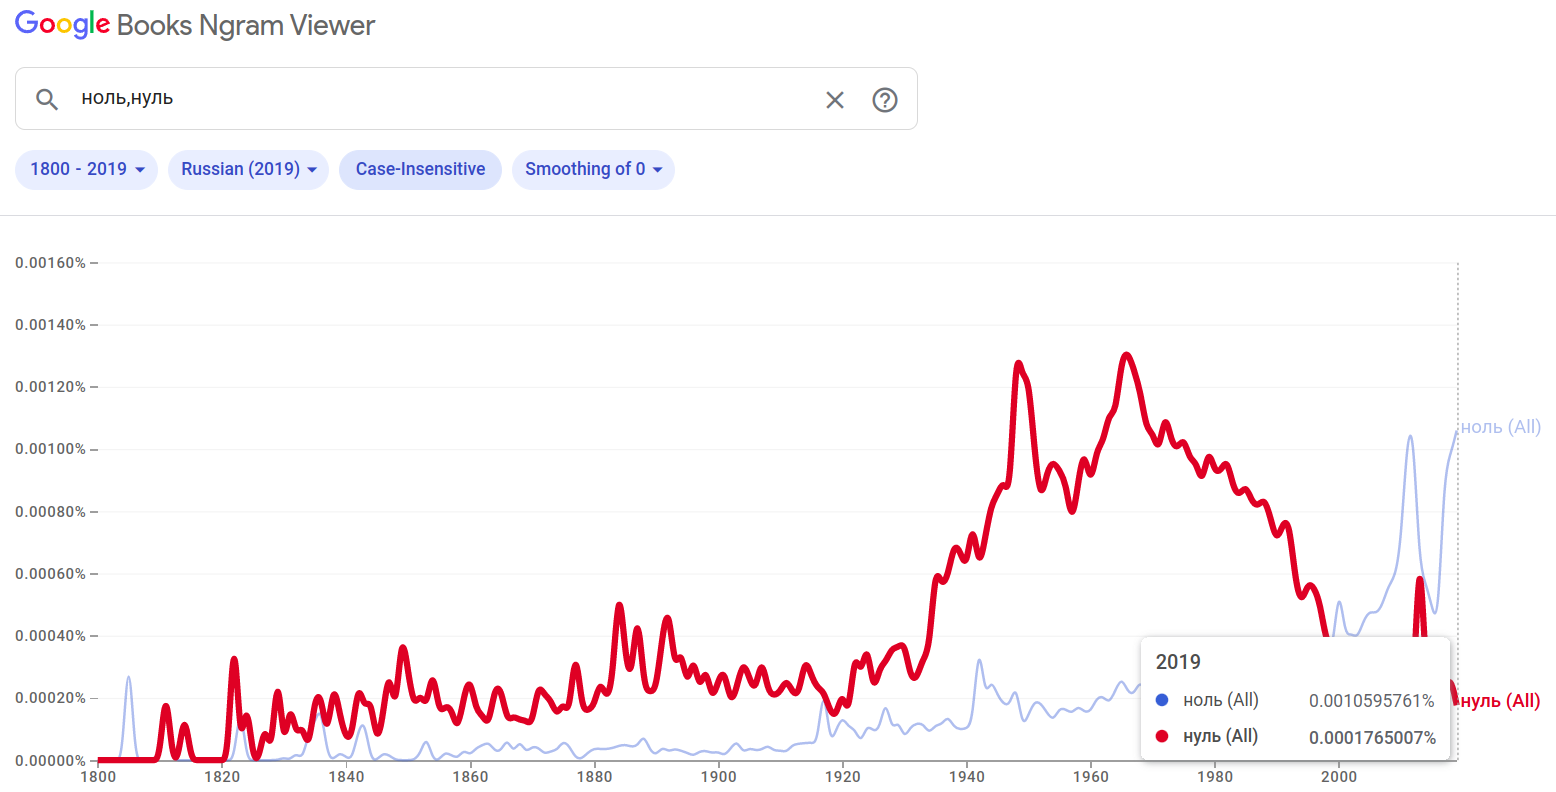

In [56]:
display.Image(b64decode(base64_ngramm_image))

In [57]:
nol_ngram = 0.0010595761
nul_ngram = 0.0001765007
print(f'Соотношение нолей к нулям: {nol_ngram / nul_ngram}')
print(f'Соотношение нулей к нолям: {nul_ngram / nol_ngram}')

Соотношение нолей к нулям: 6.003240213778189
Соотношение нулей к нолям: 0.16657670930856217


Замечание: НКРЯ и Google Books Ngram ищут словоформы, а в livejournal'е мы считали лексемы.

Таким образом, данные НКРЯ и Google Books Ngram не совпали с livejournal. Видимо, "нуль" чаще употребляется в разговорной речи, а "ноль" в книгах.